# Ссылки на этапы
1. План работы:
    - [Начало](#План-работы)
    - [Собственно сам план](#План-работы-(итог))
2. Код решения
    - [Начало](#Код-решения)
    - [Итоги](#Итоги)
3. [Отчет](#Отчет)

# План работы

## Условие задачи

Оператор связи *«Ниединогоразрыва.ком»* хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_provider/`.

Целевой признак: столбец `'EndDate'` равен `'No'`.

Основная метрика: **AUC-ROC**.

Дополнительная метрика: **Accuracy**.

Критерии оценки:

| Метрика | Баллы |
| --- | --- |
| AUC-ROC < 0.75 | 0 sp |
| 0.75 ≤ AUC-ROC < 0.81 | 4 sp |
| 0.81 ≤ AUC-ROC < 0.85 | 4.5 sp |
| 0.85 ≤ AUC-ROC < 0.87 | 5 sp |
| 0.87 ≤ AUC-ROC < 0.88 | 5.5 sp |
| AUC-ROC ≥ 0.88 | 6 sp |

# Исследовательский анализ данных

## imports

In [3]:
import pandas as pd
import numpy as np
from venn import venn # диаграммы Вена
# import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from lofo import LOFOImportance, Dataset, plot_importance

C:\Users\stask\AppData\Roaming\Python\Python37\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [4]:
# настройки
pd.options.display.max_columns=25

## Чтение данных

In [5]:
# словарь вида: 'имя_файла.csv':'имя_переменной'
files = {
    'contract.csv':'contract',
    'internet.csv':'internet',
    'personal.csv':'personal',
    'phone.csv':'phone',
}

# универсальное чтение данных
for file, variable in files.items():
    try:
        vars()[variable] = pd.read_csv("./datasets/" + file)
    except:
        try:
            vars()[variable] = pd.read_csv("/datasets/final_provider/" + file)
        except:
            vars()[variable] = pd.read_csv("https://..." + file)
#     finally:
#         print(vars()[variable].info())
#         display(vars()[variable].head())

## contract.csv (информация о договоре)

In [6]:
display(contract.head())
print(contract.info())

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


Явных пропусков нет. В поле `EndDate` значение `No` можно считать за неявный пропуск, но так нужно для решение задачи. Поле `TotalCharges` по умолчанию приведено к типу `object`, т.к. там встречаются пробелы. Заменим их на нули, т.к. это новые абоненты, которые не внесли оплату (см. ниже).

Необходимо заменить типы данных:
- `BeginDate` -> Date
- `EndDate` -> Date (целевой признак, поэтому добавим новый признак `Lost`)
- `Type` -> category
- `PaperlessBilling` -> bool
- `PaymentMethod` -> category
- `TotalCharges` -> float

In [7]:
contract[contract['TotalCharges'] == ' '].sample(5)

customerID   BeginDate EndDate      Type PaperlessBilling  \
3826  3213-VVOLG  2020-02-01      No  Two year               No   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   

                PaymentMethod  MonthlyCharges TotalCharges  
3826             Mailed check           25.35               
6670             Mailed check           73.35               
3331             Mailed check           19.85               
4380             Mailed check           20.00               
1340  Credit card (automatic)           56.05

In [8]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['Lost'] = contract['EndDate'] != 'No' # добавляем новую целевую переменную
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce') # значения No меняем на пропуски
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 0)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])
contract['Type'] = contract['Type'].astype('category')
contract['PaperlessBilling'] = contract['PaperlessBilling'].replace({'Yes':1, 'No':0}).astype('bool')
contract['PaymentMethod'] = contract['PaymentMethod'].astype('category')

Исследовательский анализ с помощью `pandas_profiling`

### Наблюдения, размышления по `contract`:
- заметен небольшой прирост новых абонентов с 2017 года
- данные выгружены с фильтрацией по `EndDate` за 4 месяца с 2019-10 по 2020-01
- 26.5% абонентов ушли от оператора (целевой признак несбалансирован)
- `customerID` состоит из 2-ух частей, причем, если их разделить, то каждая по отдельности будет иметь дубликаты

### Вопросы:
1. Что такое PaperlessBilling? Счета по электронной почте? Необходимо больше вводной информации по этому полю
2. Почему `customerID` состоит из 2-ух частей? Какой механизм формирования ID?

## personal.csv (персональные данные клиента)

In [9]:
display(personal.head())
print(personal.info())

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


Явных пропусков нет.

Необходимо заменить типы данных:
- `gender` -> category
- `SeniorCitizen` -> bool
- `Partner` -> bool
- `Dependents` -> bool

In [10]:
personal['gender'] = personal['gender'].astype('category')
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('bool')
personal['Partner'] = personal['Partner'].replace({'Yes':1, 'No':0}).astype('bool')
personal['Dependents'] = personal['Dependents'].replace({'Yes':1, 'No':0}).astype('bool')

### Наблюдения, размышления по `personal`:
- `SeniorCitizen` интересное поле (16.2% пожилых)

### Вопросы:
1. Какой порог возраста для `SeniorCitizen`?
2. `Partner` это реферальная программа? Т.е. абонент пришел по приглашению? Необходимо больше вводной информации по этому полю
3. `Dependents` есть ли у абонента приглашенный друг?

## internet.csv (информация об интернет-услугах)

In [11]:
display(internet.head())
print(internet.info())

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


Явных пропусков нет.

Необходимо заменить типы данных:
- `InternetService` -> category
- `OnlineSecurity` -> bool
- `OnlineBackup` -> bool
- `DeviceProtection` -> bool
- `TechSupport` -> bool
- `StreamingTV` -> bool
- `StreamingMovies` -> bool

In [12]:
internet['InternetService'] = internet['InternetService'].astype('category')
internet['OnlineSecurity'] = internet['OnlineSecurity'].replace({'Yes':1, 'No':0}).astype('bool')
internet['OnlineBackup'] = internet['OnlineBackup'].replace({'Yes':1, 'No':0}).astype('bool')
internet['DeviceProtection'] = internet['DeviceProtection'].replace({'Yes':1, 'No':0}).astype('bool')
internet['TechSupport'] = internet['TechSupport'].replace({'Yes':1, 'No':0}).astype('bool')
internet['StreamingTV'] = internet['StreamingTV'].replace({'Yes':1, 'No':0}).astype('bool')
internet['StreamingMovies'] = internet['StreamingMovies'].replace({'Yes':1, 'No':0}).astype('bool')

### Наблюдения, размышления по `internet`:
- Достаточно большой процент подключенных доп.опций (видимо продажники хорошо потрудились)

### Вопросы:
- нет

## phone.csv (информация об услугах телефонии)

In [13]:
display(phone.head())
print(phone.info())

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


Явных пропусков нет.

Необходимо заменить типы данных:
- `MultipleLines` -> bool

In [14]:
phone['MultipleLines'] = phone['MultipleLines'].replace({'Yes':1, 'No':0}).astype('bool')

### Наблюдения, размышления по `phone`:
- нет

### Вопросы:
- поле `MultipleLines` означает факт подключения телефона от оператора? Все представленные в этой таблице абоненты пользуются телефоном, и часть из них по нескольким линиям? Необходимо больше вводной информации по этому полю

## Общие наблюдения по входным данным:
1. Количество записей в таблицах:
    - contract 7043
    - personal 7043
    - internet 5517
    - phone 6361

Пока не понятно, почему записей в последних двух таблицах меньше. Вероятно некоторые абоненты не пользуются интернетом/телефоном. Нужно попробовать посмотреть на пересечения множеств

2. Необходимо объединить все представленные таблицы

## Общий список вопросов

1. **contract**:
    1. Что такое PaperlessBilling? Счета по электронной почте? Необходимо больше вводной информации по этому полю
    2. Почему `customerID` состоит из 2-ух частей? Какой механизм формирования ID?
2. **personal**:
    1. Известен порог возраста для `SeniorCitizen`?
    2. `Partner` это реферальная программа? Т.е. абонент пришел по приглашению? Необходимо больше вводной информации по этому полю
    3. `Dependents` есть ли у абонента приглашенный друг?
3. **internet** - нет вопросов
4. **phone**:
    1. Поле `MultipleLines` означает факт подключения телефона от оператора? Все представленные в этой таблице абоненты пользуются телефоном, и часть из них по нескольким линиям? Необходимо больше вводной информации по этому полю

## Ответы тимлида
    
1. **contract**:
    1. Да, присылаем ли ему банамажку
    2. Ну особеность биллинга
2. **personal**:
    1. По предъявлению пенсионного удостверения. 
    2. Нет это есть ли супург.
    3. Есть ли дети
3. **internet** - нет вопросов - нет ответов
4. **phone**:
    1. Нет, это подключено ли многоканальная линия

## План работы (итог)

1. Объединение данных
    - При слиянии таблиц `internet` и `phone` должно получиться 7043 уникальных записи. Если нет, то понять в чем ошибка.
    - Поле `customerID` в таблицах `contract` и `personal` должно полностью совпадать
2. Исследование баланса классов, корреляции признаков, поиск инсайтов
3. Подготовка данных и признаков
    - добавление доп принаков в данные
    - кодирование
    - масштабирование
    - разделение на train, valid и test (необходимо учесть дисбаланс классов)
4. Подбор модели и гиперпараметров
    - необходимо учесть дисбаланс классов (возможно попробовать разные методы)
    - если ROC-AUC будет ниже 0.88, то повтор шага 3
5. Анализ и интерпретация результатов
    - максимально простое объяснение проделанной работы и полученных результатов
    - рекомендации для бизнеса

# Код решения

## Объединение данных

Объединим данные о договорах и клиентах

In [15]:
data = pd.merge(contract, personal, on='customerID')

In [16]:
# Оцениваем, сколько всего уникальных идентификаторов в internet и phone
pd.merge(internet, phone, on='customerID', how='outer').shape[0]

7043

7043 - как и ожидалось. Именно столько уникальных записей в таблице `contract`. Построим диаграммы Вена для наглядности

In [17]:
print('Всего абонентов:',
      data.shape[0])
print('Количество абонентов с подключенным интернетом:',
      internet.shape[0])
print('Количество абонентов с подключенным телефоном:',
      phone.shape[0])
print('Количество абонентов с подключенным интернетом и телефоном:',
      internet.merge(phone, on='customerID', how='inner').shape[0])
print('Количество абонентов с подключенным интернетом и без телефона:',
      internet.shape[0] - internet.merge(phone, on='customerID', how='inner').shape[0])
print('Количество абонентов с подключенным телефоном и без интернета:',
      phone.shape[0] - internet.merge(phone, on='customerID', how='inner').shape[0])

users = {
    'Количество абонентов с подключенным интернетом': set(internet['customerID']),
    'Количество абонентов с подключенным телефоном': set(phone['customerID']),
}

Всего абонентов: 7043
Количество абонентов с подключенным интернетом: 5517
Количество абонентов с подключенным телефоном: 6361
Количество абонентов с подключенным интернетом и телефоном: 4835
Количество абонентов с подключенным интернетом и без телефона: 682
Количество абонентов с подключенным телефоном и без интернета: 1526


## Диаграммы Вена

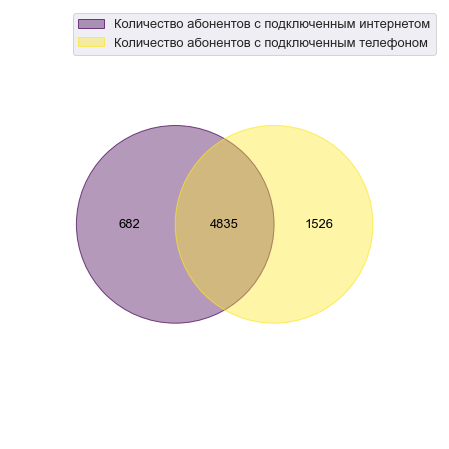

In [18]:
venn(users);

Думаю, что условно можно все данные разделить на 4 различные группы:
1. все данные - 7043 записи (основа)
2. с подключенным интернетом - 5517 записей
3. с подключенным телефоном - 6361 запись
4. с подключенным интернетом и телефоном - 4835 записей

Для этого объединим все данные в одной таблице и добавим метку

In [19]:
# объединяем все данные
data = data.merge(
    pd.merge(
        internet,
        phone,
        on='customerID',
        how='outer',
        indicator='internet_phone', # спец поле для индикации наличия интернета/телефона
    ),
    on='customerID',
    how='left'
)

In [20]:
# добавим "индикаторы" для пользователей интернета и телефона
data['internet'] = (data['internet_phone'] == 'left_only') | (data['internet_phone'] == 'both')
data['phone'] = (data['internet_phone'] == 'right_only') | (data['internet_phone'] == 'both')
# удаляем промежуточную фичу
data = data.drop(columns=['internet_phone'])

## Избавимся от пропусков

In [21]:
# пропуски даты заполним самым актуальным значением, всё равно факт ухода абонента зафиксирован
data['EndDate'] = data['EndDate'].fillna(data['EndDate'].max())

# пропуски в категориальной колонке
data['InternetService'] = data['InternetService'].cat.add_categories('None').fillna('None')

# список с оставшимися пропусками в bool-колонках
col_list_na = [col_name for col_name in data.columns if data[col_name].isna().sum() != 0]
# заменяем пропуски
data[col_list_na] = data[col_list_na].fillna(False)

## Добавление фич

In [22]:
# добавим количество дней действия контракта
data['duration'] = (data['EndDate']-data['BeginDate']).dt.days

## Исследование баланса классов

Wall time: 12.8 s


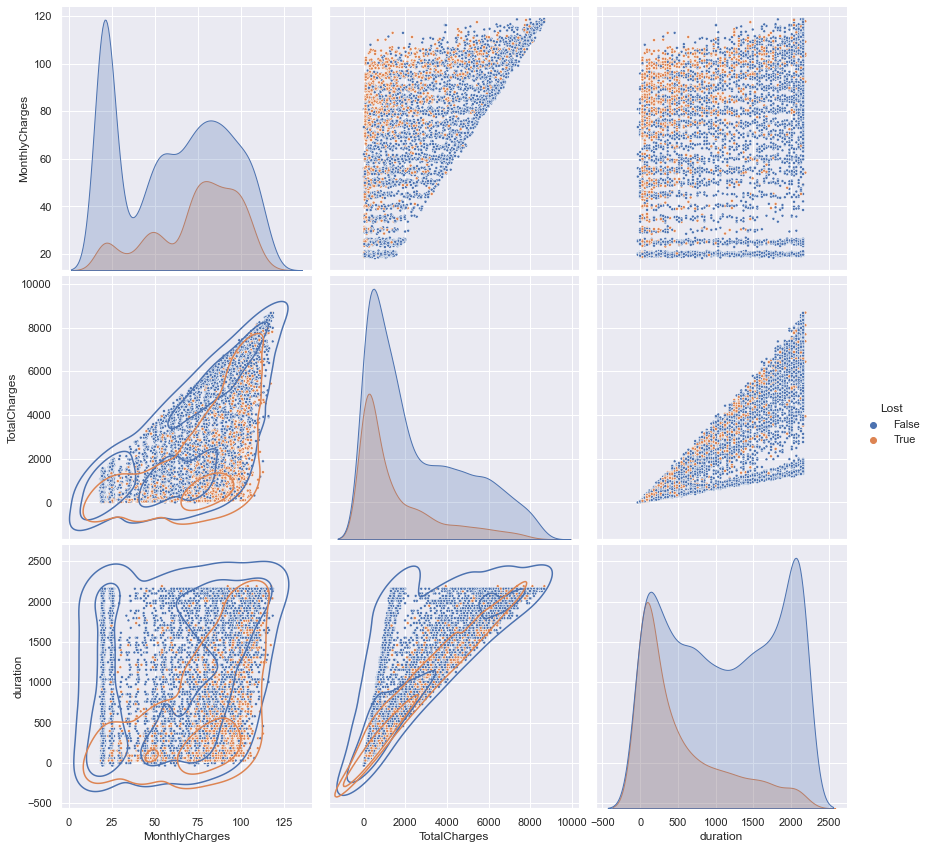

In [23]:
%%time
# около 30-40 сек

not_bool_col = [col for col, col_type in dict(data.dtypes).items() if ('bool' not in str(col_type)) or (col == 'Lost')]

g = sns.pairplot(data[not_bool_col], hue='Lost', markers='.', height=4);

g.map_lower(sns.kdeplot, levels=3, color=".2");

Можно заметить, что ушедшие клиенты обладали бОльшими ежемесячными платежами. При этом чаще всего клиенты уходят в первые 500-1000 дней.

## Важность признаков

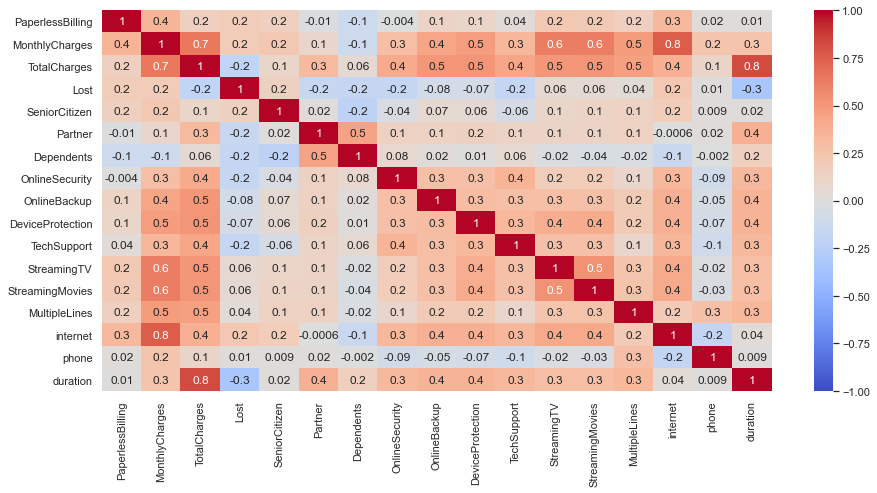

In [24]:
# корреляционная матрица
fig, ax = plt.subplots(figsize=(15,7)) 
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g', ax=ax);

Корреляция 0.8 - достаточно высокая. Т.е. TotalChargs - можно смело удалять.

Ещё можно посмотреть технику VIF для оценки мультиколлинеарности (пример скопипастил, чтобы потом попробовать, к этим данным он не относится):

```python
print(data.head())
```

```
Output :
   Gender  Height  Weight  Index
0    Male     174      96      4
1    Male     189      87      2
2  Female     185     110      4
3  Female     195     104      3
4    Male     149      61      3
```

```python
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# creating dummies for gender 
data['Gender'] = data['Gender'].map({'Male':0, 'Female':1}) 

# the independent variables set 
X = data[['Gender', 'Height', 'Weight']] 

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
						for i in range(len(X.columns))] 

print(vif_data)
```

```
Output :

  feature        VIF
0  Gender   2.028864
1  Height  11.623103
2  Weight  10.688377
```


## LOFO
LOFO (Leave One Feature Out) - это метод вычисления важности признаков на основе выбранной метрики для выбранной модели путем итеративного удаления каждого признака из данных и оценки качества модели.(По умолчанию `LGBMRegressor`). В конце для лучшей модели будет дополнительный расчет. Сейчас просто для общего понимания.

Очевидно, что `EndDate` содержит утечку целевого признака

## Разделение данных (отложенная выборка)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   category      
 4   PaperlessBilling  7043 non-null   bool          
 5   PaymentMethod     7043 non-null   category      
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Lost              7043 non-null   bool          
 9   gender            7043 non-null   category      
 10  SeniorCitizen     7043 non-null   bool          
 11  Partner           7043 non-null   bool          
 12  Dependents        7043 non-null   bool          
 13  InternetService   7043 non-null   category      
 14  OnlineSecurity    7043 n

In [26]:
# избавляемся от ненужных данных и данных с утечкой целевого признака
features = data.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Lost'])
target = data['Lost']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)
# features_train, features_valid, target_train, target_valid = train_test_split(
#     features_train, target_train, test_size=0.25, random_state=12345)

## Категориальные колонки

In [27]:
cat_columns = [col for col, type_col in dict(data.dtypes).items() if 'category' in str(type_col)]
# заменяем категориальные признаки с помощью get_dummies
train_in = features_train.join(pd.get_dummies(features_train[cat_columns], drop_first=True)).drop(columns=cat_columns)
test_in = features_test.join(pd.get_dummies(features_test[cat_columns], drop_first=True)).drop(columns=cat_columns)
# заменим булев тип на int
train_in *= 1
test_in *= 1

train_out = target_train * 1
test_out = target_test * 1

## Проверка данных перед обучением

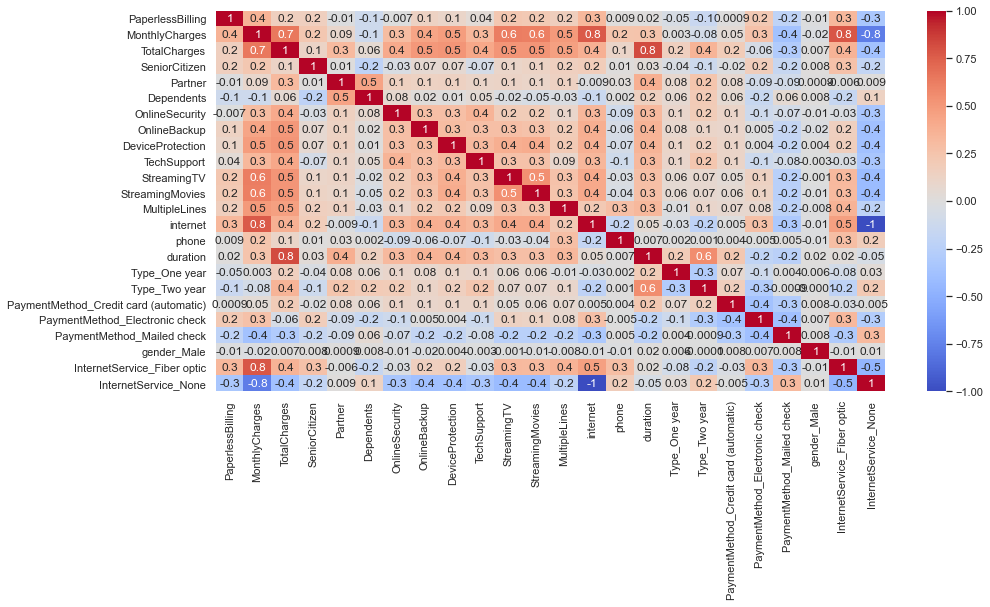

In [28]:
# корреляционная матрица
fig, ax = plt.subplots(figsize=(15,7)) 
sns.heatmap(train_in.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g', ax=ax);

In [29]:
# боремся с мультиколлениарностью
train_in = train_in.drop(columns=['InternetService_None'])
test_in = test_in.drop(columns=['InternetService_None'])

## VIF

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# the independent variables set 
X = train_in

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 

vif_data

C:\Users\stask\anaconda3\envs\practicum\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



feature          VIF
0                        PaperlessBilling     2.942143
1                          MonthlyCharges  4825.826310
2                            TotalCharges    17.511362
3                           SeniorCitizen     1.392231
4                                 Partner     2.837258
5                              Dependents     1.951074
6                          OnlineSecurity     8.959103
7                            OnlineBackup    10.359887
8                        DeviceProtection    10.508024
9                             TechSupport     9.072871
10                            StreamingTV    39.066889
11                        StreamingMovies    39.163886
12                          MultipleLines    12.434906
13                               internet   474.139111
14                                  phone   350.414617
15                               duration    15.824378
16                          Type_One year     1.977874
17                          Type_Two year     3.422380
18  PaymentMethod_Credit card (automatic)     1.859590
19         PaymentMethod_Electronic check     2.704979
20             PaymentMethod_Mailed check     1.987491
21                            gender_Male     1.967779
22            InternetService_Fiber optic   261.346868

Теперь видно, какие признаки могут отрицательно влиять на качество модели

Чем больше - тем хуже

# Тестируем модели

## Графики

In [31]:
# Создаем фигуру для отрисовки ROC-кривых
fig = go.Figure()
# ROC-кривая случайной модели (выглядит как прямая)
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name="Случайная модель",
                         line=dict(color='firebrick', width=2,dash='dot')))

# Edit the layout
fig.update_layout(
    title='ROC-кривые',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
);

In [32]:
def show_result(target_test,
                predicted_proba,
                model,
                name_suff='',
                threshold_range=(0.2, 0.8, 0.05)
               ):
    """
    Функция вывода результатов и отрисовки графиков
    """
    score = roc_auc_score(target_test, predicted_proba[:,1])
    print('ROC-AUC:', score)
#     print('Accuracy:', accuracy_score(target_test, predicted_proba[:,1]>0.5))
    print()
    for threshold in np.arange(*threshold_range):
        print('Threshold={:.2f}:\tROC_AUC={:.3f}\tAccuracy={:.3f}'.format(
            threshold,
            roc_auc_score(target_test,predicted_proba[:,1] > threshold),
            accuracy_score(target_test, predicted_proba[:,1] > threshold)))
    fpr, tpr, thresholds = roc_curve(target_test, predicted_proba[:, 1])
    model_name = str(model.__class__).strip('<>\'').split('.')[-1] + name_suff + ' (ROC-AUC=' + str(round(score, 3)) + ')'
    fig.add_scatter(x=fpr, y=tpr, name=model_name)

    fig.show()

## LogisticRegressionCV

In [33]:
model = LogisticRegressionCV(
    random_state=12345,
#    cv=cv,
    cv=3,  # ВЫДАВАЛА ОШИБКУ, ПОДСТАВИЛ ПРОСТО ЧИСЛО
    class_weight='balanced',
)

model.fit(train_in, train_out)

predicted_proba = model.predict_proba(test_in)

In [34]:
show_result(
    target_test=test_out,
    predicted_proba=predicted_proba,
    model=model,
#     name_suff='_with_Ohe',
)

ROC-AUC: 0.8276705675682658

Threshold=0.20:	ROC_AUC=0.685	Accuracy=0.556
Threshold=0.25:	ROC_AUC=0.707	Accuracy=0.599
Threshold=0.30:	ROC_AUC=0.722	Accuracy=0.632
Threshold=0.35:	ROC_AUC=0.742	Accuracy=0.671
Threshold=0.40:	ROC_AUC=0.741	Accuracy=0.691
Threshold=0.45:	ROC_AUC=0.743	Accuracy=0.715
Threshold=0.50:	ROC_AUC=0.751	Accuracy=0.737
Threshold=0.55:	ROC_AUC=0.745	Accuracy=0.751
Threshold=0.60:	ROC_AUC=0.738	Accuracy=0.764
Threshold=0.65:	ROC_AUC=0.731	Accuracy=0.781
Threshold=0.70:	ROC_AUC=0.716	Accuracy=0.784
Threshold=0.75:	ROC_AUC=0.709	Accuracy=0.799
Threshold=0.80:	ROC_AUC=0.663	Accuracy=0.789


![](./image/1.png)

## RandomForestClassifier

In [35]:
model = RandomForestClassifier(
    random_state=12345,
    n_estimators=2000,
    n_jobs=-1,
    class_weight='balanced',
)

model.fit(train_in,
          train_out)

predicted_proba = model.predict_proba(test_in)

In [36]:
# Cross validation score
np.mean(cross_val_score(model,
                        features_train.drop(columns=cat_columns),
                        target_train,
                        scoring='roc_auc',
                        cv=3))

0.8560270152412247

In [37]:
show_result(
    target_test=target_test,
    predicted_proba=predicted_proba,
    model=model
)

ROC-AUC: 0.8597264202123537

Threshold=0.20:	ROC_AUC=0.766	Accuracy=0.720
Threshold=0.25:	ROC_AUC=0.771	Accuracy=0.752
Threshold=0.30:	ROC_AUC=0.773	Accuracy=0.777
Threshold=0.35:	ROC_AUC=0.765	Accuracy=0.791
Threshold=0.40:	ROC_AUC=0.758	Accuracy=0.811
Threshold=0.45:	ROC_AUC=0.750	Accuracy=0.821
Threshold=0.50:	ROC_AUC=0.736	Accuracy=0.822
Threshold=0.55:	ROC_AUC=0.713	Accuracy=0.821
Threshold=0.60:	ROC_AUC=0.695	Accuracy=0.820
Threshold=0.65:	ROC_AUC=0.674	Accuracy=0.814
Threshold=0.70:	ROC_AUC=0.655	Accuracy=0.810
Threshold=0.75:	ROC_AUC=0.630	Accuracy=0.798
Threshold=0.80:	ROC_AUC=0.600	Accuracy=0.784


![](./image/2.png)

## LGBMClassifier

In [38]:
model = lgb.LGBMClassifier(
    class_weight='balanced',
)
model.fit(features_train, target_train)

predicted_proba = model.predict_proba(features_test)

In [39]:
show_result(
    target_test=target_test,
    predicted_proba=predicted_proba,
    model=model
)

ROC-AUC: 0.8962773515203182

Threshold=0.20:	ROC_AUC=0.748	Accuracy=0.676
Threshold=0.25:	ROC_AUC=0.768	Accuracy=0.711
Threshold=0.30:	ROC_AUC=0.779	Accuracy=0.735
Threshold=0.35:	ROC_AUC=0.788	Accuracy=0.761
Threshold=0.40:	ROC_AUC=0.801	Accuracy=0.784
Threshold=0.45:	ROC_AUC=0.810	Accuracy=0.806
Threshold=0.50:	ROC_AUC=0.815	Accuracy=0.823
Threshold=0.55:	ROC_AUC=0.812	Accuracy=0.834
Threshold=0.60:	ROC_AUC=0.806	Accuracy=0.841
Threshold=0.65:	ROC_AUC=0.796	Accuracy=0.849
Threshold=0.70:	ROC_AUC=0.789	Accuracy=0.859
Threshold=0.75:	ROC_AUC=0.774	Accuracy=0.862
Threshold=0.80:	ROC_AUC=0.745	Accuracy=0.855


![](./image/3.png)

## CatBoostClassifier

In [40]:
model = CatBoostClassifier(
    cat_features=['Type','PaymentMethod','gender','InternetService'],
    iterations=500,
    custom_metric='AUC',
    eval_metric='AUC',
    class_weights=[1, 1/target_train.mean()],
)
model.fit(features_train, target_train, verbose=50)

predicted_proba = model.predict_proba(features_test)

Learning rate set to 0.040698
0:	total: 208ms	remaining: 1m 43s
50:	total: 1.23s	remaining: 10.8s
100:	total: 2.27s	remaining: 8.98s
150:	total: 3.38s	remaining: 7.82s
200:	total: 4.42s	remaining: 6.58s
250:	total: 5.72s	remaining: 5.67s
300:	total: 7.17s	remaining: 4.74s
350:	total: 8.67s	remaining: 3.68s
400:	total: 10.1s	remaining: 2.48s
450:	total: 11.5s	remaining: 1.25s
499:	total: 13.1s	remaining: 0us


In [41]:
show_result(
    target_test=target_test,
    predicted_proba=predicted_proba,
    model=model
)

ROC-AUC: 0.8948797437288486

Threshold=0.20:	ROC_AUC=0.725	Accuracy=0.618
Threshold=0.25:	ROC_AUC=0.744	Accuracy=0.651
Threshold=0.30:	ROC_AUC=0.762	Accuracy=0.684
Threshold=0.35:	ROC_AUC=0.767	Accuracy=0.705
Threshold=0.40:	ROC_AUC=0.782	Accuracy=0.732
Threshold=0.45:	ROC_AUC=0.798	Accuracy=0.762
Threshold=0.50:	ROC_AUC=0.807	Accuracy=0.789
Threshold=0.55:	ROC_AUC=0.811	Accuracy=0.807
Threshold=0.60:	ROC_AUC=0.803	Accuracy=0.816
Threshold=0.65:	ROC_AUC=0.802	Accuracy=0.832
Threshold=0.70:	ROC_AUC=0.799	Accuracy=0.846
Threshold=0.75:	ROC_AUC=0.785	Accuracy=0.851
Threshold=0.80:	ROC_AUC=0.770	Accuracy=0.855


![](./image/4.png)

## GridSearch CatBoostClassifier

## CatBoostClassifier с подобранными гиперпараметрами

In [42]:
model = CatBoostClassifier(
#     cat_features=['Type','PaymentMethod','gender','InternetService'],
#     iterations=500,
    custom_metric='AUC',
    eval_metric='AUC',
    depth=2,
    learning_rate=0.7,
    l2_leaf_reg=0.1,
)
model.fit(train_in, train_out, verbose=50)

predicted_proba = model.predict_proba(test_in)

0:	total: 2.73ms	remaining: 2.73s
50:	total: 170ms	remaining: 3.17s
100:	total: 360ms	remaining: 3.2s
150:	total: 529ms	remaining: 2.98s
200:	total: 682ms	remaining: 2.71s
250:	total: 856ms	remaining: 2.56s
300:	total: 1s	remaining: 2.32s
350:	total: 1.23s	remaining: 2.28s
400:	total: 1.38s	remaining: 2.06s
450:	total: 1.5s	remaining: 1.82s
500:	total: 1.64s	remaining: 1.64s
550:	total: 1.79s	remaining: 1.46s
600:	total: 1.9s	remaining: 1.26s
650:	total: 2.04s	remaining: 1.09s
700:	total: 2.18s	remaining: 929ms
750:	total: 2.34s	remaining: 776ms
800:	total: 2.46s	remaining: 611ms
850:	total: 2.6s	remaining: 456ms
900:	total: 2.73s	remaining: 300ms
950:	total: 2.88s	remaining: 148ms
999:	total: 3s	remaining: 0us


In [43]:
show_result(
    target_test=target_test,
    predicted_proba=predicted_proba,
    model=model,
    name_suff='_tune',
)

ROC-AUC: 0.9272933943010668

Threshold=0.20:	ROC_AUC=0.860	Accuracy=0.864
Threshold=0.25:	ROC_AUC=0.861	Accuracy=0.875
Threshold=0.30:	ROC_AUC=0.856	Accuracy=0.878
Threshold=0.35:	ROC_AUC=0.853	Accuracy=0.884
Threshold=0.40:	ROC_AUC=0.855	Accuracy=0.889
Threshold=0.45:	ROC_AUC=0.852	Accuracy=0.893
Threshold=0.50:	ROC_AUC=0.843	Accuracy=0.893
Threshold=0.55:	ROC_AUC=0.837	Accuracy=0.893
Threshold=0.60:	ROC_AUC=0.837	Accuracy=0.897
Threshold=0.65:	ROC_AUC=0.834	Accuracy=0.898
Threshold=0.70:	ROC_AUC=0.828	Accuracy=0.897
Threshold=0.75:	ROC_AUC=0.813	Accuracy=0.890
Threshold=0.80:	ROC_AUC=0.801	Accuracy=0.888


![](./image/5.png)

Катбуст немного выигрывает у LGBM, поэтому попробовал затюнить его. Результат получился неплохой. ROC-AUC около 0.93. Выше, требуемого значения в 0.88

Стоить отметить, что CatBoost показывает одинаковые результаты при использовании данных с категориальными фичами (`features_train`) и с закодированными (`train_in`)

## GridSearch CatBoostClassifier importance_features
Посмотрим, как изменится качество, если использовать только значимые фичи по версии LOFO

0:	total: 2.25ms	remaining: 2.25s
1:	total: 4.37ms	remaining: 2.18s
2:	total: 6.58ms	remaining: 2.19s
3:	total: 8.46ms	remaining: 2.1s
4:	total: 10.3ms	remaining: 2.05s
5:	total: 12.1ms	remaining: 2.01s
6:	total: 19.8ms	remaining: 2.81s
7:	total: 21.6ms	remaining: 2.68s
8:	total: 23.5ms	remaining: 2.58s
9:	total: 25.3ms	remaining: 2.51s
10:	total: 27.1ms	remaining: 2.44s
11:	total: 29.2ms	remaining: 2.4s
12:	total: 30.9ms	remaining: 2.34s
13:	total: 32.7ms	remaining: 2.3s
14:	total: 34.4ms	remaining: 2.26s
15:	total: 36.2ms	remaining: 2.23s
16:	total: 51.1ms	remaining: 2.96s
17:	total: 67ms	remaining: 3.65s
18:	total: 69ms	remaining: 3.56s
19:	total: 71.1ms	remaining: 3.48s
20:	total: 72.9ms	remaining: 3.4s
21:	total: 74.8ms	remaining: 3.33s
22:	total: 76.6ms	remaining: 3.25s
23:	total: 78.4ms	remaining: 3.19s
24:	total: 82.4ms	remaining: 3.21s
25:	total: 84.5ms	remaining: 3.17s
26:	total: 86.4ms	remaining: 3.11s
27:	total: 88.2ms	remaining: 3.06s
28:	total: 90ms	remaining: 3.02s
29:	t

241:	total: 606ms	remaining: 1.9s
242:	total: 608ms	remaining: 1.89s
243:	total: 610ms	remaining: 1.89s
244:	total: 612ms	remaining: 1.88s
245:	total: 613ms	remaining: 1.88s
246:	total: 615ms	remaining: 1.88s
247:	total: 617ms	remaining: 1.87s
248:	total: 619ms	remaining: 1.87s
249:	total: 621ms	remaining: 1.86s
250:	total: 631ms	remaining: 1.88s
251:	total: 633ms	remaining: 1.88s
252:	total: 635ms	remaining: 1.87s
253:	total: 637ms	remaining: 1.87s
254:	total: 639ms	remaining: 1.86s
255:	total: 640ms	remaining: 1.86s
256:	total: 643ms	remaining: 1.86s
257:	total: 644ms	remaining: 1.85s
258:	total: 646ms	remaining: 1.85s
259:	total: 648ms	remaining: 1.84s
260:	total: 650ms	remaining: 1.84s
261:	total: 652ms	remaining: 1.84s
262:	total: 654ms	remaining: 1.83s
263:	total: 656ms	remaining: 1.83s
264:	total: 657ms	remaining: 1.82s
265:	total: 659ms	remaining: 1.82s
266:	total: 661ms	remaining: 1.81s
267:	total: 663ms	remaining: 1.81s
268:	total: 665ms	remaining: 1.81s
269:	total: 666ms	rem

497:	total: 1.15s	remaining: 1.16s
498:	total: 1.15s	remaining: 1.15s
499:	total: 1.15s	remaining: 1.15s
500:	total: 1.15s	remaining: 1.15s
501:	total: 1.15s	remaining: 1.15s
502:	total: 1.16s	remaining: 1.14s
503:	total: 1.16s	remaining: 1.14s
504:	total: 1.16s	remaining: 1.14s
505:	total: 1.18s	remaining: 1.15s
506:	total: 1.18s	remaining: 1.15s
507:	total: 1.18s	remaining: 1.15s
508:	total: 1.19s	remaining: 1.15s
509:	total: 1.2s	remaining: 1.15s
510:	total: 1.2s	remaining: 1.15s
511:	total: 1.2s	remaining: 1.14s
512:	total: 1.2s	remaining: 1.14s
513:	total: 1.2s	remaining: 1.14s
514:	total: 1.21s	remaining: 1.13s
515:	total: 1.21s	remaining: 1.13s
516:	total: 1.21s	remaining: 1.13s
517:	total: 1.21s	remaining: 1.13s
518:	total: 1.21s	remaining: 1.12s
519:	total: 1.21s	remaining: 1.12s
520:	total: 1.22s	remaining: 1.12s
521:	total: 1.22s	remaining: 1.11s
522:	total: 1.22s	remaining: 1.11s
523:	total: 1.22s	remaining: 1.11s
524:	total: 1.22s	remaining: 1.11s
525:	total: 1.22s	remaini

783:	total: 1.81s	remaining: 498ms
784:	total: 1.81s	remaining: 496ms
785:	total: 1.81s	remaining: 494ms
786:	total: 1.81s	remaining: 491ms
787:	total: 1.82s	remaining: 489ms
788:	total: 1.82s	remaining: 486ms
789:	total: 1.82s	remaining: 484ms
790:	total: 1.82s	remaining: 481ms
791:	total: 1.82s	remaining: 479ms
792:	total: 1.82s	remaining: 477ms
793:	total: 1.83s	remaining: 474ms
794:	total: 1.83s	remaining: 472ms
795:	total: 1.83s	remaining: 469ms
796:	total: 1.83s	remaining: 467ms
797:	total: 1.83s	remaining: 465ms
798:	total: 1.84s	remaining: 462ms
799:	total: 1.85s	remaining: 464ms
800:	total: 1.86s	remaining: 461ms
801:	total: 1.87s	remaining: 462ms
802:	total: 1.87s	remaining: 459ms
803:	total: 1.87s	remaining: 457ms
804:	total: 1.88s	remaining: 456ms
805:	total: 1.89s	remaining: 454ms
806:	total: 1.89s	remaining: 452ms
807:	total: 1.9s	remaining: 452ms
808:	total: 1.9s	remaining: 449ms
809:	total: 1.9s	remaining: 447ms
810:	total: 1.91s	remaining: 444ms
811:	total: 1.91s	remai

77:	total: 176ms	remaining: 2.08s
78:	total: 178ms	remaining: 2.07s
79:	total: 179ms	remaining: 2.06s
80:	total: 181ms	remaining: 2.06s
81:	total: 183ms	remaining: 2.05s
82:	total: 185ms	remaining: 2.04s
83:	total: 187ms	remaining: 2.04s
84:	total: 189ms	remaining: 2.03s
85:	total: 203ms	remaining: 2.16s
86:	total: 205ms	remaining: 2.15s
87:	total: 207ms	remaining: 2.14s
88:	total: 209ms	remaining: 2.14s
89:	total: 210ms	remaining: 2.13s
90:	total: 212ms	remaining: 2.12s
91:	total: 214ms	remaining: 2.11s
92:	total: 216ms	remaining: 2.11s
93:	total: 218ms	remaining: 2.1s
94:	total: 220ms	remaining: 2.09s
95:	total: 221ms	remaining: 2.08s
96:	total: 223ms	remaining: 2.08s
97:	total: 225ms	remaining: 2.07s
98:	total: 227ms	remaining: 2.06s
99:	total: 229ms	remaining: 2.06s
100:	total: 230ms	remaining: 2.05s
101:	total: 233ms	remaining: 2.05s
102:	total: 234ms	remaining: 2.04s
103:	total: 236ms	remaining: 2.04s
104:	total: 250ms	remaining: 2.13s
105:	total: 252ms	remaining: 2.13s
106:	tota

400:	total: 899ms	remaining: 1.34s
401:	total: 901ms	remaining: 1.34s
402:	total: 919ms	remaining: 1.36s
403:	total: 921ms	remaining: 1.36s
404:	total: 922ms	remaining: 1.35s
405:	total: 935ms	remaining: 1.37s
406:	total: 937ms	remaining: 1.36s
407:	total: 939ms	remaining: 1.36s
408:	total: 940ms	remaining: 1.36s
409:	total: 942ms	remaining: 1.35s
410:	total: 944ms	remaining: 1.35s
411:	total: 945ms	remaining: 1.35s
412:	total: 947ms	remaining: 1.35s
413:	total: 949ms	remaining: 1.34s
414:	total: 951ms	remaining: 1.34s
415:	total: 953ms	remaining: 1.34s
416:	total: 954ms	remaining: 1.33s
417:	total: 956ms	remaining: 1.33s
418:	total: 958ms	remaining: 1.33s
419:	total: 960ms	remaining: 1.32s
420:	total: 961ms	remaining: 1.32s
421:	total: 963ms	remaining: 1.32s
422:	total: 965ms	remaining: 1.32s
423:	total: 967ms	remaining: 1.31s
424:	total: 969ms	remaining: 1.31s
425:	total: 981ms	remaining: 1.32s
426:	total: 983ms	remaining: 1.32s
427:	total: 997ms	remaining: 1.33s
428:	total: 1.01s	re

720:	total: 1.65s	remaining: 640ms
721:	total: 1.65s	remaining: 637ms
722:	total: 1.66s	remaining: 635ms
723:	total: 1.66s	remaining: 632ms
724:	total: 1.66s	remaining: 630ms
725:	total: 1.66s	remaining: 627ms
726:	total: 1.66s	remaining: 625ms
727:	total: 1.67s	remaining: 622ms
728:	total: 1.67s	remaining: 620ms
729:	total: 1.67s	remaining: 617ms
730:	total: 1.67s	remaining: 615ms
731:	total: 1.67s	remaining: 612ms
732:	total: 1.67s	remaining: 610ms
733:	total: 1.68s	remaining: 608ms
734:	total: 1.69s	remaining: 608ms
735:	total: 1.69s	remaining: 605ms
736:	total: 1.69s	remaining: 603ms
737:	total: 1.69s	remaining: 600ms
738:	total: 1.69s	remaining: 598ms
739:	total: 1.69s	remaining: 595ms
740:	total: 1.7s	remaining: 593ms
741:	total: 1.7s	remaining: 590ms
742:	total: 1.7s	remaining: 588ms
743:	total: 1.7s	remaining: 585ms
744:	total: 1.7s	remaining: 583ms
745:	total: 1.71s	remaining: 581ms
746:	total: 1.71s	remaining: 578ms
747:	total: 1.71s	remaining: 576ms
748:	total: 1.71s	remaini

983:	total: 2.19s	remaining: 35.7ms
984:	total: 2.19s	remaining: 33.4ms
985:	total: 2.2s	remaining: 31.2ms
986:	total: 2.2s	remaining: 29ms
987:	total: 2.2s	remaining: 26.7ms
988:	total: 2.2s	remaining: 24.5ms
989:	total: 2.2s	remaining: 22.3ms
990:	total: 2.21s	remaining: 20ms
991:	total: 2.21s	remaining: 17.8ms
992:	total: 2.21s	remaining: 15.6ms
993:	total: 2.21s	remaining: 13.4ms
994:	total: 2.21s	remaining: 11.1ms
995:	total: 2.22s	remaining: 8.9ms
996:	total: 2.23s	remaining: 6.72ms
997:	total: 2.25s	remaining: 4.5ms
998:	total: 2.25s	remaining: 2.25ms
999:	total: 2.25s	remaining: 0us
0:	total: 16.3ms	remaining: 16.3s
1:	total: 18.5ms	remaining: 9.22s
2:	total: 20.5ms	remaining: 6.81s
3:	total: 22.3ms	remaining: 5.55s
4:	total: 24.1ms	remaining: 4.8s
5:	total: 26.1ms	remaining: 4.33s
6:	total: 27.9ms	remaining: 3.96s
7:	total: 29.7ms	remaining: 3.68s
8:	total: 31.5ms	remaining: 3.47s
9:	total: 33.2ms	remaining: 3.29s
10:	total: 35ms	remaining: 3.15s
11:	total: 36.8ms	remaining: 3

226:	total: 571ms	remaining: 1.94s
227:	total: 573ms	remaining: 1.94s
228:	total: 585ms	remaining: 1.97s
229:	total: 587ms	remaining: 1.97s
230:	total: 589ms	remaining: 1.96s
231:	total: 591ms	remaining: 1.96s
232:	total: 601ms	remaining: 1.98s
233:	total: 603ms	remaining: 1.97s
234:	total: 605ms	remaining: 1.97s
235:	total: 606ms	remaining: 1.96s
236:	total: 608ms	remaining: 1.96s
237:	total: 610ms	remaining: 1.95s
238:	total: 612ms	remaining: 1.95s
239:	total: 614ms	remaining: 1.94s
240:	total: 616ms	remaining: 1.94s
241:	total: 618ms	remaining: 1.94s
242:	total: 620ms	remaining: 1.93s
243:	total: 622ms	remaining: 1.93s
244:	total: 624ms	remaining: 1.92s
245:	total: 626ms	remaining: 1.92s
246:	total: 627ms	remaining: 1.91s
247:	total: 629ms	remaining: 1.91s
248:	total: 631ms	remaining: 1.9s
249:	total: 633ms	remaining: 1.9s
250:	total: 635ms	remaining: 1.89s
251:	total: 637ms	remaining: 1.89s
252:	total: 638ms	remaining: 1.88s
253:	total: 640ms	remaining: 1.88s
254:	total: 642ms	rema

488:	total: 1.1s	remaining: 1.15s
489:	total: 1.11s	remaining: 1.15s
490:	total: 1.11s	remaining: 1.15s
491:	total: 1.11s	remaining: 1.15s
492:	total: 1.11s	remaining: 1.14s
493:	total: 1.11s	remaining: 1.14s
494:	total: 1.12s	remaining: 1.14s
495:	total: 1.12s	remaining: 1.14s
496:	total: 1.12s	remaining: 1.13s
497:	total: 1.12s	remaining: 1.13s
498:	total: 1.12s	remaining: 1.13s
499:	total: 1.13s	remaining: 1.13s
500:	total: 1.13s	remaining: 1.12s
501:	total: 1.13s	remaining: 1.12s
502:	total: 1.13s	remaining: 1.12s
503:	total: 1.13s	remaining: 1.11s
504:	total: 1.15s	remaining: 1.13s
505:	total: 1.17s	remaining: 1.14s
506:	total: 1.17s	remaining: 1.13s
507:	total: 1.17s	remaining: 1.13s
508:	total: 1.17s	remaining: 1.13s
509:	total: 1.17s	remaining: 1.13s
510:	total: 1.17s	remaining: 1.12s
511:	total: 1.18s	remaining: 1.12s
512:	total: 1.18s	remaining: 1.12s
513:	total: 1.18s	remaining: 1.12s
514:	total: 1.18s	remaining: 1.11s
515:	total: 1.18s	remaining: 1.11s
516:	total: 1.19s	rem

729:	total: 1.66s	remaining: 613ms
730:	total: 1.67s	remaining: 615ms
731:	total: 1.69s	remaining: 617ms
732:	total: 1.69s	remaining: 615ms
733:	total: 1.69s	remaining: 613ms
734:	total: 1.69s	remaining: 610ms
735:	total: 1.69s	remaining: 608ms
736:	total: 1.7s	remaining: 605ms
737:	total: 1.7s	remaining: 603ms
738:	total: 1.7s	remaining: 600ms
739:	total: 1.7s	remaining: 598ms
740:	total: 1.7s	remaining: 595ms
741:	total: 1.71s	remaining: 593ms
742:	total: 1.71s	remaining: 591ms
743:	total: 1.71s	remaining: 588ms
744:	total: 1.71s	remaining: 586ms
745:	total: 1.71s	remaining: 583ms
746:	total: 1.71s	remaining: 581ms
747:	total: 1.72s	remaining: 578ms
748:	total: 1.72s	remaining: 576ms
749:	total: 1.72s	remaining: 573ms
750:	total: 1.72s	remaining: 571ms
751:	total: 1.72s	remaining: 569ms
752:	total: 1.73s	remaining: 566ms
753:	total: 1.73s	remaining: 564ms
754:	total: 1.73s	remaining: 561ms
755:	total: 1.75s	remaining: 564ms
756:	total: 1.75s	remaining: 562ms
757:	total: 1.75s	remaini

977:	total: 2.2s	remaining: 49.6ms
978:	total: 2.2s	remaining: 47.3ms
979:	total: 2.21s	remaining: 45ms
980:	total: 2.21s	remaining: 42.8ms
981:	total: 2.21s	remaining: 40.5ms
982:	total: 2.21s	remaining: 38.3ms
983:	total: 2.21s	remaining: 36ms
984:	total: 2.23s	remaining: 34ms
985:	total: 2.23s	remaining: 31.7ms
986:	total: 2.23s	remaining: 29.4ms
987:	total: 2.23s	remaining: 27.1ms
988:	total: 2.25s	remaining: 25ms
989:	total: 2.25s	remaining: 22.7ms
990:	total: 2.25s	remaining: 20.4ms
991:	total: 2.25s	remaining: 18.2ms
992:	total: 2.25s	remaining: 15.9ms
993:	total: 2.25s	remaining: 13.6ms
994:	total: 2.26s	remaining: 11.3ms
995:	total: 2.26s	remaining: 9.07ms
996:	total: 2.26s	remaining: 6.8ms
997:	total: 2.26s	remaining: 4.53ms
998:	total: 2.26s	remaining: 2.27ms
999:	total: 2.27s	remaining: 0us


0:	total: 2.06ms	remaining: 2.06s
1:	total: 9.95ms	remaining: 4.96s
2:	total: 12.1ms	remaining: 4.03s
3:	total: 13.9ms	remaining: 3.47s
4:	total: 15.8ms	remaining: 3.14s
5:	total: 17.6ms	remaining: 2.92s
6:	total: 19.4ms	remaining: 2.75s
7:	total: 21.3ms	remaining: 2.64s
8:	total: 23.1ms	remaining: 2.54s
9:	total: 24.9ms	remaining: 2.46s
10:	total: 26.8ms	remaining: 2.41s
11:	total: 28.6ms	remaining: 2.35s
12:	total: 30.7ms	remaining: 2.33s
13:	total: 32.7ms	remaining: 2.31s
14:	total: 34.9ms	remaining: 2.29s
15:	total: 36.6ms	remaining: 2.25s
16:	total: 38.3ms	remaining: 2.22s
17:	total: 40.2ms	remaining: 2.19s
18:	total: 42ms	remaining: 2.17s
19:	total: 43.7ms	remaining: 2.14s
20:	total: 45.6ms	remaining: 2.12s
21:	total: 47.3ms	remaining: 2.1s
22:	total: 49.2ms	remaining: 2.09s
23:	total: 51ms	remaining: 2.07s
24:	total: 53ms	remaining: 2.06s
25:	total: 54.8ms	remaining: 2.05s
26:	total: 56.9ms	remaining: 2.05s
27:	total: 59ms	remaining: 2.05s
28:	total: 60.9ms	remaining: 2.04s
29:	

256:	total: 533ms	remaining: 1.54s
257:	total: 535ms	remaining: 1.54s
258:	total: 537ms	remaining: 1.53s
259:	total: 539ms	remaining: 1.53s
260:	total: 541ms	remaining: 1.53s
261:	total: 543ms	remaining: 1.53s
262:	total: 545ms	remaining: 1.53s
263:	total: 546ms	remaining: 1.52s
264:	total: 548ms	remaining: 1.52s
265:	total: 550ms	remaining: 1.52s
266:	total: 552ms	remaining: 1.51s
267:	total: 553ms	remaining: 1.51s
268:	total: 555ms	remaining: 1.51s
269:	total: 557ms	remaining: 1.51s
270:	total: 559ms	remaining: 1.5s
271:	total: 561ms	remaining: 1.5s
272:	total: 563ms	remaining: 1.5s
273:	total: 565ms	remaining: 1.5s
274:	total: 566ms	remaining: 1.49s
275:	total: 568ms	remaining: 1.49s
276:	total: 570ms	remaining: 1.49s
277:	total: 572ms	remaining: 1.49s
278:	total: 574ms	remaining: 1.48s
279:	total: 576ms	remaining: 1.48s
280:	total: 577ms	remaining: 1.48s
281:	total: 579ms	remaining: 1.47s
282:	total: 581ms	remaining: 1.47s
283:	total: 583ms	remaining: 1.47s
284:	total: 585ms	remain

515:	total: 1.07s	remaining: 1s
516:	total: 1.07s	remaining: 1s
517:	total: 1.07s	remaining: 1s
518:	total: 1.08s	remaining: 998ms
519:	total: 1.08s	remaining: 996ms
520:	total: 1.08s	remaining: 994ms
521:	total: 1.08s	remaining: 991ms
522:	total: 1.08s	remaining: 989ms
523:	total: 1.09s	remaining: 987ms
524:	total: 1.09s	remaining: 984ms
525:	total: 1.09s	remaining: 982ms
526:	total: 1.09s	remaining: 980ms
527:	total: 1.09s	remaining: 977ms
528:	total: 1.09s	remaining: 975ms
529:	total: 1.11s	remaining: 985ms
530:	total: 1.11s	remaining: 983ms
531:	total: 1.11s	remaining: 980ms
532:	total: 1.12s	remaining: 978ms
533:	total: 1.12s	remaining: 975ms
534:	total: 1.12s	remaining: 973ms
535:	total: 1.12s	remaining: 971ms
536:	total: 1.12s	remaining: 969ms
537:	total: 1.13s	remaining: 966ms
538:	total: 1.14s	remaining: 977ms
539:	total: 1.14s	remaining: 974ms
540:	total: 1.15s	remaining: 972ms
541:	total: 1.15s	remaining: 970ms
542:	total: 1.15s	remaining: 967ms
543:	total: 1.15s	remaining: 

762:	total: 1.61s	remaining: 501ms
763:	total: 1.61s	remaining: 499ms
764:	total: 1.62s	remaining: 497ms
765:	total: 1.62s	remaining: 494ms
766:	total: 1.62s	remaining: 492ms
767:	total: 1.62s	remaining: 490ms
768:	total: 1.62s	remaining: 488ms
769:	total: 1.63s	remaining: 486ms
770:	total: 1.63s	remaining: 483ms
771:	total: 1.63s	remaining: 481ms
772:	total: 1.63s	remaining: 480ms
773:	total: 1.64s	remaining: 478ms
774:	total: 1.64s	remaining: 476ms
775:	total: 1.64s	remaining: 473ms
776:	total: 1.64s	remaining: 471ms
777:	total: 1.64s	remaining: 469ms
778:	total: 1.65s	remaining: 467ms
779:	total: 1.65s	remaining: 465ms
780:	total: 1.65s	remaining: 462ms
781:	total: 1.67s	remaining: 464ms
782:	total: 1.67s	remaining: 462ms
783:	total: 1.67s	remaining: 460ms
784:	total: 1.67s	remaining: 458ms
785:	total: 1.67s	remaining: 455ms
786:	total: 1.67s	remaining: 453ms
787:	total: 1.68s	remaining: 451ms
788:	total: 1.68s	remaining: 449ms
789:	total: 1.68s	remaining: 447ms
790:	total: 1.68s	re

0:	total: 2ms	remaining: 2s
1:	total: 4.23ms	remaining: 2.11s
2:	total: 6.41ms	remaining: 2.13s
3:	total: 8.37ms	remaining: 2.08s
4:	total: 10.2ms	remaining: 2.03s
5:	total: 20.5ms	remaining: 3.39s
6:	total: 22.3ms	remaining: 3.16s
7:	total: 24.3ms	remaining: 3.01s
8:	total: 26.2ms	remaining: 2.88s
9:	total: 36.4ms	remaining: 3.6s
10:	total: 38.2ms	remaining: 3.44s
11:	total: 40ms	remaining: 3.29s
12:	total: 41.8ms	remaining: 3.17s
13:	total: 43.9ms	remaining: 3.09s
14:	total: 45.8ms	remaining: 3s
15:	total: 47.6ms	remaining: 2.93s
16:	total: 49.5ms	remaining: 2.86s
17:	total: 51.3ms	remaining: 2.8s
18:	total: 53.1ms	remaining: 2.74s
19:	total: 54.9ms	remaining: 2.69s
20:	total: 56.7ms	remaining: 2.65s
21:	total: 58.7ms	remaining: 2.61s
22:	total: 60.5ms	remaining: 2.57s
23:	total: 62.3ms	remaining: 2.53s
24:	total: 64.2ms	remaining: 2.5s
25:	total: 66.2ms	remaining: 2.48s
26:	total: 68.1ms	remaining: 2.46s
27:	total: 69.9ms	remaining: 2.43s
28:	total: 71.7ms	remaining: 2.4s
29:	total:

245:	total: 540ms	remaining: 1.65s
246:	total: 542ms	remaining: 1.65s
247:	total: 544ms	remaining: 1.65s
248:	total: 546ms	remaining: 1.65s
249:	total: 547ms	remaining: 1.64s
250:	total: 549ms	remaining: 1.64s
251:	total: 551ms	remaining: 1.64s
252:	total: 553ms	remaining: 1.63s
253:	total: 555ms	remaining: 1.63s
254:	total: 557ms	remaining: 1.63s
255:	total: 559ms	remaining: 1.62s
256:	total: 561ms	remaining: 1.62s
257:	total: 563ms	remaining: 1.62s
258:	total: 564ms	remaining: 1.61s
259:	total: 566ms	remaining: 1.61s
260:	total: 568ms	remaining: 1.61s
261:	total: 570ms	remaining: 1.61s
262:	total: 572ms	remaining: 1.6s
263:	total: 574ms	remaining: 1.6s
264:	total: 576ms	remaining: 1.6s
265:	total: 578ms	remaining: 1.59s
266:	total: 580ms	remaining: 1.59s
267:	total: 582ms	remaining: 1.59s
268:	total: 583ms	remaining: 1.58s
269:	total: 586ms	remaining: 1.58s
270:	total: 587ms	remaining: 1.58s
271:	total: 589ms	remaining: 1.58s
272:	total: 591ms	remaining: 1.57s
273:	total: 593ms	remai

494:	total: 1.08s	remaining: 1.1s
495:	total: 1.08s	remaining: 1.1s
496:	total: 1.08s	remaining: 1.1s
497:	total: 1.09s	remaining: 1.09s
498:	total: 1.09s	remaining: 1.09s
499:	total: 1.09s	remaining: 1.09s
500:	total: 1.09s	remaining: 1.09s
501:	total: 1.09s	remaining: 1.08s
502:	total: 1.1s	remaining: 1.08s
503:	total: 1.1s	remaining: 1.08s
504:	total: 1.1s	remaining: 1.08s
505:	total: 1.1s	remaining: 1.08s
506:	total: 1.1s	remaining: 1.07s
507:	total: 1.11s	remaining: 1.07s
508:	total: 1.11s	remaining: 1.07s
509:	total: 1.11s	remaining: 1.07s
510:	total: 1.11s	remaining: 1.06s
511:	total: 1.11s	remaining: 1.06s
512:	total: 1.12s	remaining: 1.06s
513:	total: 1.12s	remaining: 1.06s
514:	total: 1.12s	remaining: 1.05s
515:	total: 1.12s	remaining: 1.05s
516:	total: 1.12s	remaining: 1.05s
517:	total: 1.13s	remaining: 1.05s
518:	total: 1.13s	remaining: 1.04s
519:	total: 1.13s	remaining: 1.04s
520:	total: 1.14s	remaining: 1.04s
521:	total: 1.14s	remaining: 1.04s
522:	total: 1.14s	remaining:

758:	total: 1.62s	remaining: 514ms
759:	total: 1.62s	remaining: 512ms
760:	total: 1.62s	remaining: 510ms
761:	total: 1.63s	remaining: 508ms
762:	total: 1.63s	remaining: 505ms
763:	total: 1.63s	remaining: 503ms
764:	total: 1.63s	remaining: 501ms
765:	total: 1.63s	remaining: 499ms
766:	total: 1.63s	remaining: 497ms
767:	total: 1.64s	remaining: 494ms
768:	total: 1.64s	remaining: 492ms
769:	total: 1.64s	remaining: 490ms
770:	total: 1.65s	remaining: 490ms
771:	total: 1.65s	remaining: 488ms
772:	total: 1.65s	remaining: 486ms
773:	total: 1.66s	remaining: 483ms
774:	total: 1.66s	remaining: 481ms
775:	total: 1.66s	remaining: 479ms
776:	total: 1.66s	remaining: 477ms
777:	total: 1.66s	remaining: 474ms
778:	total: 1.66s	remaining: 472ms
779:	total: 1.67s	remaining: 470ms
780:	total: 1.67s	remaining: 468ms
781:	total: 1.67s	remaining: 466ms
782:	total: 1.67s	remaining: 463ms
783:	total: 1.67s	remaining: 461ms
784:	total: 1.68s	remaining: 459ms
785:	total: 1.68s	remaining: 457ms
786:	total: 1.68s	re

0:	total: 10.9ms	remaining: 10.8s
1:	total: 13.2ms	remaining: 6.6s
2:	total: 15.5ms	remaining: 5.15s
3:	total: 17.3ms	remaining: 4.3s
4:	total: 19.2ms	remaining: 3.81s
5:	total: 21ms	remaining: 3.48s
6:	total: 23.1ms	remaining: 3.27s
7:	total: 24.8ms	remaining: 3.07s
8:	total: 26.6ms	remaining: 2.92s
9:	total: 28.4ms	remaining: 2.81s
10:	total: 30.2ms	remaining: 2.71s
11:	total: 32ms	remaining: 2.63s
12:	total: 33.9ms	remaining: 2.57s
13:	total: 41.5ms	remaining: 2.93s
14:	total: 43.3ms	remaining: 2.85s
15:	total: 45.3ms	remaining: 2.79s
16:	total: 47.3ms	remaining: 2.73s
17:	total: 49.1ms	remaining: 2.68s
18:	total: 50.8ms	remaining: 2.62s
19:	total: 52.7ms	remaining: 2.58s
20:	total: 54.5ms	remaining: 2.54s
21:	total: 56.2ms	remaining: 2.5s
22:	total: 58ms	remaining: 2.46s
23:	total: 59.7ms	remaining: 2.43s
24:	total: 61.8ms	remaining: 2.41s
25:	total: 63.5ms	remaining: 2.38s
26:	total: 65.3ms	remaining: 2.35s
27:	total: 67ms	remaining: 2.33s
28:	total: 69ms	remaining: 2.31s
29:	tota

258:	total: 540ms	remaining: 1.54s
259:	total: 543ms	remaining: 1.54s
260:	total: 545ms	remaining: 1.54s
261:	total: 547ms	remaining: 1.54s
262:	total: 549ms	remaining: 1.54s
263:	total: 551ms	remaining: 1.53s
264:	total: 552ms	remaining: 1.53s
265:	total: 554ms	remaining: 1.53s
266:	total: 556ms	remaining: 1.53s
267:	total: 558ms	remaining: 1.52s
268:	total: 560ms	remaining: 1.52s
269:	total: 561ms	remaining: 1.52s
270:	total: 563ms	remaining: 1.51s
271:	total: 565ms	remaining: 1.51s
272:	total: 567ms	remaining: 1.51s
273:	total: 569ms	remaining: 1.51s
274:	total: 571ms	remaining: 1.5s
275:	total: 586ms	remaining: 1.54s
276:	total: 601ms	remaining: 1.57s
277:	total: 603ms	remaining: 1.56s
278:	total: 605ms	remaining: 1.56s
279:	total: 606ms	remaining: 1.56s
280:	total: 609ms	remaining: 1.56s
281:	total: 611ms	remaining: 1.55s
282:	total: 613ms	remaining: 1.55s
283:	total: 615ms	remaining: 1.55s
284:	total: 617ms	remaining: 1.55s
285:	total: 619ms	remaining: 1.54s
286:	total: 620ms	rem

496:	total: 1.08s	remaining: 1.09s
497:	total: 1.08s	remaining: 1.09s
498:	total: 1.08s	remaining: 1.09s
499:	total: 1.09s	remaining: 1.09s
500:	total: 1.09s	remaining: 1.08s
501:	total: 1.09s	remaining: 1.08s
502:	total: 1.09s	remaining: 1.08s
503:	total: 1.09s	remaining: 1.08s
504:	total: 1.09s	remaining: 1.07s
505:	total: 1.1s	remaining: 1.07s
506:	total: 1.1s	remaining: 1.07s
507:	total: 1.1s	remaining: 1.07s
508:	total: 1.1s	remaining: 1.06s
509:	total: 1.1s	remaining: 1.06s
510:	total: 1.11s	remaining: 1.07s
511:	total: 1.13s	remaining: 1.08s
512:	total: 1.13s	remaining: 1.08s
513:	total: 1.14s	remaining: 1.07s
514:	total: 1.14s	remaining: 1.07s
515:	total: 1.14s	remaining: 1.07s
516:	total: 1.14s	remaining: 1.06s
517:	total: 1.14s	remaining: 1.06s
518:	total: 1.14s	remaining: 1.06s
519:	total: 1.15s	remaining: 1.06s
520:	total: 1.15s	remaining: 1.05s
521:	total: 1.15s	remaining: 1.05s
522:	total: 1.15s	remaining: 1.05s
523:	total: 1.15s	remaining: 1.05s
524:	total: 1.16s	remaini

803:	total: 1.8s	remaining: 440ms
804:	total: 1.8s	remaining: 437ms
805:	total: 1.81s	remaining: 435ms
806:	total: 1.81s	remaining: 433ms
807:	total: 1.81s	remaining: 430ms
808:	total: 1.81s	remaining: 428ms
809:	total: 1.81s	remaining: 426ms
810:	total: 1.82s	remaining: 423ms
811:	total: 1.82s	remaining: 421ms
812:	total: 1.82s	remaining: 419ms
813:	total: 1.83s	remaining: 419ms
814:	total: 1.83s	remaining: 417ms
815:	total: 1.84s	remaining: 414ms
816:	total: 1.84s	remaining: 412ms
817:	total: 1.84s	remaining: 410ms
818:	total: 1.84s	remaining: 407ms
819:	total: 1.85s	remaining: 406ms
820:	total: 1.85s	remaining: 404ms
821:	total: 1.85s	remaining: 401ms
822:	total: 1.85s	remaining: 399ms
823:	total: 1.86s	remaining: 396ms
824:	total: 1.86s	remaining: 394ms
825:	total: 1.86s	remaining: 392ms
826:	total: 1.86s	remaining: 389ms
827:	total: 1.86s	remaining: 387ms
828:	total: 1.86s	remaining: 385ms
829:	total: 1.87s	remaining: 382ms
830:	total: 1.87s	remaining: 380ms
831:	total: 1.87s	rema

94:	total: 172ms	remaining: 1.64s
95:	total: 174ms	remaining: 1.63s
96:	total: 175ms	remaining: 1.63s
97:	total: 177ms	remaining: 1.63s
98:	total: 179ms	remaining: 1.63s
99:	total: 181ms	remaining: 1.63s
100:	total: 183ms	remaining: 1.63s
101:	total: 184ms	remaining: 1.62s
102:	total: 186ms	remaining: 1.62s
103:	total: 188ms	remaining: 1.62s
104:	total: 190ms	remaining: 1.62s
105:	total: 192ms	remaining: 1.61s
106:	total: 193ms	remaining: 1.61s
107:	total: 195ms	remaining: 1.61s
108:	total: 197ms	remaining: 1.61s
109:	total: 199ms	remaining: 1.61s
110:	total: 201ms	remaining: 1.61s
111:	total: 202ms	remaining: 1.6s
112:	total: 204ms	remaining: 1.6s
113:	total: 206ms	remaining: 1.6s
114:	total: 208ms	remaining: 1.6s
115:	total: 209ms	remaining: 1.6s
116:	total: 211ms	remaining: 1.59s
117:	total: 213ms	remaining: 1.59s
118:	total: 215ms	remaining: 1.59s
119:	total: 217ms	remaining: 1.59s
120:	total: 219ms	remaining: 1.59s
121:	total: 220ms	remaining: 1.58s
122:	total: 222ms	remaining: 1.

394:	total: 709ms	remaining: 1.09s
395:	total: 711ms	remaining: 1.08s
396:	total: 713ms	remaining: 1.08s
397:	total: 715ms	remaining: 1.08s
398:	total: 716ms	remaining: 1.08s
399:	total: 718ms	remaining: 1.08s
400:	total: 720ms	remaining: 1.07s
401:	total: 722ms	remaining: 1.07s
402:	total: 723ms	remaining: 1.07s
403:	total: 725ms	remaining: 1.07s
404:	total: 727ms	remaining: 1.07s
405:	total: 729ms	remaining: 1.07s
406:	total: 731ms	remaining: 1.06s
407:	total: 732ms	remaining: 1.06s
408:	total: 734ms	remaining: 1.06s
409:	total: 736ms	remaining: 1.06s
410:	total: 738ms	remaining: 1.06s
411:	total: 740ms	remaining: 1.05s
412:	total: 741ms	remaining: 1.05s
413:	total: 743ms	remaining: 1.05s
414:	total: 745ms	remaining: 1.05s
415:	total: 747ms	remaining: 1.05s
416:	total: 749ms	remaining: 1.05s
417:	total: 751ms	remaining: 1.04s
418:	total: 753ms	remaining: 1.04s
419:	total: 754ms	remaining: 1.04s
420:	total: 756ms	remaining: 1.04s
421:	total: 758ms	remaining: 1.04s
422:	total: 760ms	re

695:	total: 1.25s	remaining: 544ms
696:	total: 1.25s	remaining: 543ms
697:	total: 1.25s	remaining: 541ms
698:	total: 1.25s	remaining: 539ms
699:	total: 1.25s	remaining: 537ms
700:	total: 1.25s	remaining: 535ms
701:	total: 1.26s	remaining: 534ms
702:	total: 1.26s	remaining: 532ms
703:	total: 1.26s	remaining: 530ms
704:	total: 1.26s	remaining: 528ms
705:	total: 1.26s	remaining: 526ms
706:	total: 1.26s	remaining: 525ms
707:	total: 1.27s	remaining: 523ms
708:	total: 1.27s	remaining: 521ms
709:	total: 1.27s	remaining: 519ms
710:	total: 1.27s	remaining: 517ms
711:	total: 1.27s	remaining: 516ms
712:	total: 1.28s	remaining: 514ms
713:	total: 1.28s	remaining: 512ms
714:	total: 1.28s	remaining: 510ms
715:	total: 1.28s	remaining: 508ms
716:	total: 1.28s	remaining: 506ms
717:	total: 1.28s	remaining: 505ms
718:	total: 1.29s	remaining: 503ms
719:	total: 1.29s	remaining: 501ms
720:	total: 1.29s	remaining: 499ms
721:	total: 1.29s	remaining: 498ms
722:	total: 1.29s	remaining: 496ms
723:	total: 1.3s	rem

998:	total: 1.78s	remaining: 1.78ms
999:	total: 1.78s	remaining: 0us
0:	total: 1.82ms	remaining: 1.82s
1:	total: 3.77ms	remaining: 1.88s
2:	total: 5.51ms	remaining: 1.83s
3:	total: 7.51ms	remaining: 1.87s
4:	total: 9.26ms	remaining: 1.84s
5:	total: 11.2ms	remaining: 1.86s
6:	total: 12.9ms	remaining: 1.82s
7:	total: 14.5ms	remaining: 1.8s
8:	total: 16.4ms	remaining: 1.81s
9:	total: 18.1ms	remaining: 1.79s
10:	total: 19.9ms	remaining: 1.78s
11:	total: 21.6ms	remaining: 1.78s
12:	total: 23.4ms	remaining: 1.78s
13:	total: 25.1ms	remaining: 1.77s
14:	total: 27.1ms	remaining: 1.78s
15:	total: 28.8ms	remaining: 1.77s
16:	total: 30.6ms	remaining: 1.77s
17:	total: 32.4ms	remaining: 1.76s
18:	total: 34.1ms	remaining: 1.76s
19:	total: 36.1ms	remaining: 1.77s
20:	total: 37.8ms	remaining: 1.76s
21:	total: 39.5ms	remaining: 1.76s
22:	total: 41.3ms	remaining: 1.75s
23:	total: 43.1ms	remaining: 1.75s
24:	total: 44.8ms	remaining: 1.75s
25:	total: 46.7ms	remaining: 1.75s
26:	total: 48.3ms	remaining: 1.7

314:	total: 566ms	remaining: 1.23s
315:	total: 568ms	remaining: 1.23s
316:	total: 570ms	remaining: 1.23s
317:	total: 572ms	remaining: 1.23s
318:	total: 574ms	remaining: 1.22s
319:	total: 576ms	remaining: 1.22s
320:	total: 577ms	remaining: 1.22s
321:	total: 579ms	remaining: 1.22s
322:	total: 581ms	remaining: 1.22s
323:	total: 583ms	remaining: 1.22s
324:	total: 584ms	remaining: 1.21s
325:	total: 586ms	remaining: 1.21s
326:	total: 588ms	remaining: 1.21s
327:	total: 590ms	remaining: 1.21s
328:	total: 592ms	remaining: 1.21s
329:	total: 594ms	remaining: 1.21s
330:	total: 595ms	remaining: 1.2s
331:	total: 597ms	remaining: 1.2s
332:	total: 599ms	remaining: 1.2s
333:	total: 601ms	remaining: 1.2s
334:	total: 603ms	remaining: 1.2s
335:	total: 605ms	remaining: 1.19s
336:	total: 606ms	remaining: 1.19s
337:	total: 608ms	remaining: 1.19s
338:	total: 610ms	remaining: 1.19s
339:	total: 612ms	remaining: 1.19s
340:	total: 614ms	remaining: 1.19s
341:	total: 616ms	remaining: 1.18s
342:	total: 617ms	remaini

613:	total: 1.1s	remaining: 694ms
614:	total: 1.1s	remaining: 692ms
615:	total: 1.11s	remaining: 690ms
616:	total: 1.11s	remaining: 688ms
617:	total: 1.11s	remaining: 686ms
618:	total: 1.11s	remaining: 685ms
619:	total: 1.11s	remaining: 683ms
620:	total: 1.11s	remaining: 681ms
621:	total: 1.12s	remaining: 679ms
622:	total: 1.12s	remaining: 677ms
623:	total: 1.12s	remaining: 675ms
624:	total: 1.12s	remaining: 674ms
625:	total: 1.12s	remaining: 672ms
626:	total: 1.13s	remaining: 670ms
627:	total: 1.13s	remaining: 668ms
628:	total: 1.13s	remaining: 667ms
629:	total: 1.13s	remaining: 665ms
630:	total: 1.13s	remaining: 663ms
631:	total: 1.14s	remaining: 661ms
632:	total: 1.14s	remaining: 659ms
633:	total: 1.14s	remaining: 657ms
634:	total: 1.14s	remaining: 655ms
635:	total: 1.14s	remaining: 654ms
636:	total: 1.14s	remaining: 652ms
637:	total: 1.15s	remaining: 650ms
638:	total: 1.15s	remaining: 649ms
639:	total: 1.15s	remaining: 647ms
640:	total: 1.15s	remaining: 645ms
641:	total: 1.15s	rema

918:	total: 1.64s	remaining: 145ms
919:	total: 1.64s	remaining: 143ms
920:	total: 1.65s	remaining: 141ms
921:	total: 1.65s	remaining: 139ms
922:	total: 1.65s	remaining: 138ms
923:	total: 1.65s	remaining: 136ms
924:	total: 1.65s	remaining: 134ms
925:	total: 1.65s	remaining: 132ms
926:	total: 1.66s	remaining: 130ms
927:	total: 1.66s	remaining: 129ms
928:	total: 1.66s	remaining: 127ms
929:	total: 1.66s	remaining: 125ms
930:	total: 1.66s	remaining: 123ms
931:	total: 1.66s	remaining: 121ms
932:	total: 1.67s	remaining: 120ms
933:	total: 1.67s	remaining: 118ms
934:	total: 1.67s	remaining: 116ms
935:	total: 1.67s	remaining: 114ms
936:	total: 1.67s	remaining: 112ms
937:	total: 1.67s	remaining: 111ms
938:	total: 1.68s	remaining: 109ms
939:	total: 1.68s	remaining: 107ms
940:	total: 1.68s	remaining: 105ms
941:	total: 1.68s	remaining: 104ms
942:	total: 1.68s	remaining: 102ms
943:	total: 1.69s	remaining: 100ms
944:	total: 1.69s	remaining: 98.2ms
945:	total: 1.69s	remaining: 96.4ms
946:	total: 1.69s	

187:	total: 351ms	remaining: 1.51s
188:	total: 353ms	remaining: 1.51s
189:	total: 355ms	remaining: 1.51s
190:	total: 356ms	remaining: 1.51s
191:	total: 358ms	remaining: 1.51s
192:	total: 360ms	remaining: 1.5s
193:	total: 362ms	remaining: 1.5s
194:	total: 364ms	remaining: 1.5s
195:	total: 366ms	remaining: 1.5s
196:	total: 368ms	remaining: 1.5s
197:	total: 370ms	remaining: 1.5s
198:	total: 372ms	remaining: 1.5s
199:	total: 374ms	remaining: 1.49s
200:	total: 375ms	remaining: 1.49s
201:	total: 377ms	remaining: 1.49s
202:	total: 379ms	remaining: 1.49s
203:	total: 381ms	remaining: 1.49s
204:	total: 383ms	remaining: 1.49s
205:	total: 385ms	remaining: 1.48s
206:	total: 387ms	remaining: 1.48s
207:	total: 389ms	remaining: 1.48s
208:	total: 390ms	remaining: 1.48s
209:	total: 392ms	remaining: 1.48s
210:	total: 394ms	remaining: 1.47s
211:	total: 396ms	remaining: 1.47s
212:	total: 398ms	remaining: 1.47s
213:	total: 400ms	remaining: 1.47s
214:	total: 402ms	remaining: 1.47s
215:	total: 404ms	remaining

466:	total: 888ms	remaining: 1.01s
467:	total: 890ms	remaining: 1.01s
468:	total: 892ms	remaining: 1.01s
469:	total: 894ms	remaining: 1.01s
470:	total: 896ms	remaining: 1.01s
471:	total: 898ms	remaining: 1s
472:	total: 900ms	remaining: 1s
473:	total: 902ms	remaining: 1s
474:	total: 904ms	remaining: 999ms
475:	total: 906ms	remaining: 997ms
476:	total: 908ms	remaining: 995ms
477:	total: 910ms	remaining: 993ms
478:	total: 912ms	remaining: 992ms
479:	total: 914ms	remaining: 990ms
480:	total: 916ms	remaining: 988ms
481:	total: 917ms	remaining: 986ms
482:	total: 919ms	remaining: 984ms
483:	total: 921ms	remaining: 982ms
484:	total: 923ms	remaining: 980ms
485:	total: 925ms	remaining: 979ms
486:	total: 927ms	remaining: 977ms
487:	total: 929ms	remaining: 975ms
488:	total: 931ms	remaining: 973ms
489:	total: 933ms	remaining: 971ms
490:	total: 935ms	remaining: 969ms
491:	total: 937ms	remaining: 967ms
492:	total: 939ms	remaining: 965ms
493:	total: 941ms	remaining: 964ms
494:	total: 943ms	remaining: 

739:	total: 1.42s	remaining: 501ms
740:	total: 1.43s	remaining: 499ms
741:	total: 1.43s	remaining: 497ms
742:	total: 1.43s	remaining: 495ms
743:	total: 1.43s	remaining: 493ms
744:	total: 1.43s	remaining: 491ms
745:	total: 1.44s	remaining: 489ms
746:	total: 1.44s	remaining: 487ms
747:	total: 1.44s	remaining: 485ms
748:	total: 1.44s	remaining: 483ms
749:	total: 1.44s	remaining: 481ms
750:	total: 1.44s	remaining: 479ms
751:	total: 1.45s	remaining: 477ms
752:	total: 1.45s	remaining: 475ms
753:	total: 1.45s	remaining: 473ms
754:	total: 1.45s	remaining: 471ms
755:	total: 1.45s	remaining: 469ms
756:	total: 1.46s	remaining: 467ms
757:	total: 1.46s	remaining: 465ms
758:	total: 1.46s	remaining: 463ms
759:	total: 1.46s	remaining: 462ms
760:	total: 1.46s	remaining: 460ms
761:	total: 1.47s	remaining: 458ms
762:	total: 1.47s	remaining: 456ms
763:	total: 1.47s	remaining: 454ms
764:	total: 1.47s	remaining: 452ms
765:	total: 1.47s	remaining: 450ms
766:	total: 1.47s	remaining: 448ms
767:	total: 1.48s	re

0:	total: 1.92ms	remaining: 1.92s
1:	total: 3.91ms	remaining: 1.95s
2:	total: 5.93ms	remaining: 1.97s
3:	total: 7.65ms	remaining: 1.9s
4:	total: 9.39ms	remaining: 1.87s
5:	total: 11.2ms	remaining: 1.85s
6:	total: 13ms	remaining: 1.84s
7:	total: 15ms	remaining: 1.86s
8:	total: 16.6ms	remaining: 1.83s
9:	total: 18.4ms	remaining: 1.82s
10:	total: 20.1ms	remaining: 1.81s
11:	total: 22ms	remaining: 1.81s
12:	total: 23.8ms	remaining: 1.8s
13:	total: 25.5ms	remaining: 1.8s
14:	total: 27.5ms	remaining: 1.81s
15:	total: 29.2ms	remaining: 1.8s
16:	total: 31ms	remaining: 1.79s
17:	total: 32.7ms	remaining: 1.79s
18:	total: 34.5ms	remaining: 1.78s
19:	total: 36.3ms	remaining: 1.78s
20:	total: 38ms	remaining: 1.77s
21:	total: 39.8ms	remaining: 1.77s
22:	total: 41.5ms	remaining: 1.76s
23:	total: 43.3ms	remaining: 1.76s
24:	total: 45.3ms	remaining: 1.77s
25:	total: 47ms	remaining: 1.76s
26:	total: 48.9ms	remaining: 1.76s
27:	total: 50.6ms	remaining: 1.76s
28:	total: 52.3ms	remaining: 1.75s
29:	total: 

294:	total: 538ms	remaining: 1.29s
295:	total: 540ms	remaining: 1.28s
296:	total: 542ms	remaining: 1.28s
297:	total: 544ms	remaining: 1.28s
298:	total: 545ms	remaining: 1.28s
299:	total: 547ms	remaining: 1.28s
300:	total: 549ms	remaining: 1.27s
301:	total: 551ms	remaining: 1.27s
302:	total: 552ms	remaining: 1.27s
303:	total: 554ms	remaining: 1.27s
304:	total: 556ms	remaining: 1.27s
305:	total: 558ms	remaining: 1.26s
306:	total: 560ms	remaining: 1.26s
307:	total: 561ms	remaining: 1.26s
308:	total: 563ms	remaining: 1.26s
309:	total: 565ms	remaining: 1.26s
310:	total: 567ms	remaining: 1.25s
311:	total: 569ms	remaining: 1.25s
312:	total: 570ms	remaining: 1.25s
313:	total: 572ms	remaining: 1.25s
314:	total: 574ms	remaining: 1.25s
315:	total: 576ms	remaining: 1.25s
316:	total: 578ms	remaining: 1.24s
317:	total: 579ms	remaining: 1.24s
318:	total: 581ms	remaining: 1.24s
319:	total: 583ms	remaining: 1.24s
320:	total: 585ms	remaining: 1.24s
321:	total: 586ms	remaining: 1.23s
322:	total: 588ms	re

594:	total: 1.07s	remaining: 732ms
595:	total: 1.08s	remaining: 730ms
596:	total: 1.08s	remaining: 728ms
597:	total: 1.08s	remaining: 727ms
598:	total: 1.08s	remaining: 725ms
599:	total: 1.08s	remaining: 723ms
600:	total: 1.09s	remaining: 721ms
601:	total: 1.09s	remaining: 720ms
602:	total: 1.09s	remaining: 718ms
603:	total: 1.09s	remaining: 716ms
604:	total: 1.09s	remaining: 714ms
605:	total: 1.09s	remaining: 712ms
606:	total: 1.1s	remaining: 711ms
607:	total: 1.1s	remaining: 709ms
608:	total: 1.1s	remaining: 707ms
609:	total: 1.1s	remaining: 705ms
610:	total: 1.1s	remaining: 703ms
611:	total: 1.11s	remaining: 701ms
612:	total: 1.11s	remaining: 699ms
613:	total: 1.11s	remaining: 698ms
614:	total: 1.11s	remaining: 696ms
615:	total: 1.11s	remaining: 694ms
616:	total: 1.11s	remaining: 692ms
617:	total: 1.12s	remaining: 690ms
618:	total: 1.12s	remaining: 688ms
619:	total: 1.12s	remaining: 686ms
620:	total: 1.12s	remaining: 685ms
621:	total: 1.12s	remaining: 683ms
622:	total: 1.13s	remaini

900:	total: 1.61s	remaining: 177ms
901:	total: 1.61s	remaining: 176ms
902:	total: 1.62s	remaining: 174ms
903:	total: 1.62s	remaining: 172ms
904:	total: 1.62s	remaining: 170ms
905:	total: 1.62s	remaining: 168ms
906:	total: 1.62s	remaining: 167ms
907:	total: 1.63s	remaining: 165ms
908:	total: 1.63s	remaining: 163ms
909:	total: 1.63s	remaining: 161ms
910:	total: 1.63s	remaining: 159ms
911:	total: 1.63s	remaining: 158ms
912:	total: 1.63s	remaining: 156ms
913:	total: 1.64s	remaining: 154ms
914:	total: 1.64s	remaining: 152ms
915:	total: 1.64s	remaining: 150ms
916:	total: 1.64s	remaining: 149ms
917:	total: 1.64s	remaining: 147ms
918:	total: 1.65s	remaining: 145ms
919:	total: 1.65s	remaining: 143ms
920:	total: 1.65s	remaining: 141ms
921:	total: 1.65s	remaining: 140ms
922:	total: 1.65s	remaining: 138ms
923:	total: 1.65s	remaining: 136ms
924:	total: 1.66s	remaining: 134ms
925:	total: 1.66s	remaining: 132ms
926:	total: 1.66s	remaining: 131ms
927:	total: 1.66s	remaining: 129ms
928:	total: 1.66s	re

197:	total: 364ms	remaining: 1.48s
198:	total: 366ms	remaining: 1.47s
199:	total: 368ms	remaining: 1.47s
200:	total: 369ms	remaining: 1.47s
201:	total: 371ms	remaining: 1.47s
202:	total: 373ms	remaining: 1.46s
203:	total: 375ms	remaining: 1.46s
204:	total: 377ms	remaining: 1.46s
205:	total: 378ms	remaining: 1.46s
206:	total: 380ms	remaining: 1.46s
207:	total: 382ms	remaining: 1.45s
208:	total: 384ms	remaining: 1.45s
209:	total: 386ms	remaining: 1.45s
210:	total: 388ms	remaining: 1.45s
211:	total: 389ms	remaining: 1.45s
212:	total: 391ms	remaining: 1.45s
213:	total: 393ms	remaining: 1.44s
214:	total: 395ms	remaining: 1.44s
215:	total: 397ms	remaining: 1.44s
216:	total: 399ms	remaining: 1.44s
217:	total: 400ms	remaining: 1.44s
218:	total: 402ms	remaining: 1.43s
219:	total: 404ms	remaining: 1.43s
220:	total: 406ms	remaining: 1.43s
221:	total: 407ms	remaining: 1.43s
222:	total: 409ms	remaining: 1.43s
223:	total: 411ms	remaining: 1.42s
224:	total: 413ms	remaining: 1.42s
225:	total: 415ms	re

481:	total: 903ms	remaining: 970ms
482:	total: 905ms	remaining: 968ms
483:	total: 907ms	remaining: 967ms
484:	total: 908ms	remaining: 965ms
485:	total: 910ms	remaining: 963ms
486:	total: 912ms	remaining: 961ms
487:	total: 914ms	remaining: 959ms
488:	total: 916ms	remaining: 957ms
489:	total: 918ms	remaining: 955ms
490:	total: 919ms	remaining: 953ms
491:	total: 921ms	remaining: 951ms
492:	total: 923ms	remaining: 949ms
493:	total: 925ms	remaining: 947ms
494:	total: 927ms	remaining: 945ms
495:	total: 928ms	remaining: 943ms
496:	total: 930ms	remaining: 941ms
497:	total: 932ms	remaining: 939ms
498:	total: 934ms	remaining: 937ms
499:	total: 936ms	remaining: 936ms
500:	total: 938ms	remaining: 934ms
501:	total: 939ms	remaining: 932ms
502:	total: 941ms	remaining: 930ms
503:	total: 943ms	remaining: 928ms
504:	total: 945ms	remaining: 926ms
505:	total: 947ms	remaining: 924ms
506:	total: 948ms	remaining: 922ms
507:	total: 950ms	remaining: 920ms
508:	total: 952ms	remaining: 918ms
509:	total: 954ms	re

766:	total: 1.44s	remaining: 437ms
767:	total: 1.44s	remaining: 435ms
768:	total: 1.44s	remaining: 433ms
769:	total: 1.44s	remaining: 431ms
770:	total: 1.45s	remaining: 430ms
771:	total: 1.45s	remaining: 428ms
772:	total: 1.45s	remaining: 426ms
773:	total: 1.45s	remaining: 424ms
774:	total: 1.45s	remaining: 422ms
775:	total: 1.46s	remaining: 420ms
776:	total: 1.46s	remaining: 418ms
777:	total: 1.46s	remaining: 417ms
778:	total: 1.46s	remaining: 415ms
779:	total: 1.46s	remaining: 413ms
780:	total: 1.47s	remaining: 411ms
781:	total: 1.47s	remaining: 409ms
782:	total: 1.47s	remaining: 407ms
783:	total: 1.47s	remaining: 405ms
784:	total: 1.47s	remaining: 403ms
785:	total: 1.47s	remaining: 402ms
786:	total: 1.48s	remaining: 400ms
787:	total: 1.48s	remaining: 398ms
788:	total: 1.48s	remaining: 396ms
789:	total: 1.48s	remaining: 394ms
790:	total: 1.48s	remaining: 392ms
791:	total: 1.49s	remaining: 390ms
792:	total: 1.49s	remaining: 388ms
793:	total: 1.49s	remaining: 387ms
794:	total: 1.49s	re

0:	total: 1.92ms	remaining: 1.92s
1:	total: 3.77ms	remaining: 1.88s
2:	total: 5.71ms	remaining: 1.9s
3:	total: 7.43ms	remaining: 1.85s
4:	total: 9.19ms	remaining: 1.83s
5:	total: 14.6ms	remaining: 2.41s
6:	total: 16.3ms	remaining: 2.31s
7:	total: 18.1ms	remaining: 2.25s
8:	total: 20.1ms	remaining: 2.21s
9:	total: 21.8ms	remaining: 2.16s
10:	total: 23.5ms	remaining: 2.12s
11:	total: 25.6ms	remaining: 2.1s
12:	total: 27.2ms	remaining: 2.07s
13:	total: 29ms	remaining: 2.04s
14:	total: 31.3ms	remaining: 2.06s
15:	total: 33ms	remaining: 2.03s
16:	total: 34.7ms	remaining: 2.01s
17:	total: 36.4ms	remaining: 1.99s
18:	total: 38.4ms	remaining: 1.98s
19:	total: 40.2ms	remaining: 1.97s
20:	total: 42.1ms	remaining: 1.96s
21:	total: 43.8ms	remaining: 1.95s
22:	total: 45.8ms	remaining: 1.95s
23:	total: 47.5ms	remaining: 1.93s
24:	total: 49.5ms	remaining: 1.93s
25:	total: 51.1ms	remaining: 1.92s
26:	total: 52.9ms	remaining: 1.9s
27:	total: 54.6ms	remaining: 1.9s
28:	total: 56.4ms	remaining: 1.89s
29:

291:	total: 534ms	remaining: 1.29s
292:	total: 536ms	remaining: 1.29s
293:	total: 538ms	remaining: 1.29s
294:	total: 540ms	remaining: 1.29s
295:	total: 541ms	remaining: 1.29s
296:	total: 544ms	remaining: 1.29s
297:	total: 545ms	remaining: 1.28s
298:	total: 547ms	remaining: 1.28s
299:	total: 549ms	remaining: 1.28s
300:	total: 551ms	remaining: 1.28s
301:	total: 553ms	remaining: 1.28s
302:	total: 554ms	remaining: 1.27s
303:	total: 556ms	remaining: 1.27s
304:	total: 558ms	remaining: 1.27s
305:	total: 560ms	remaining: 1.27s
306:	total: 561ms	remaining: 1.27s
307:	total: 563ms	remaining: 1.26s
308:	total: 565ms	remaining: 1.26s
309:	total: 567ms	remaining: 1.26s
310:	total: 569ms	remaining: 1.26s
311:	total: 570ms	remaining: 1.26s
312:	total: 572ms	remaining: 1.25s
313:	total: 574ms	remaining: 1.25s
314:	total: 576ms	remaining: 1.25s
315:	total: 578ms	remaining: 1.25s
316:	total: 580ms	remaining: 1.25s
317:	total: 582ms	remaining: 1.25s
318:	total: 584ms	remaining: 1.25s
319:	total: 585ms	re

593:	total: 1.07s	remaining: 733ms
594:	total: 1.07s	remaining: 731ms
595:	total: 1.07s	remaining: 729ms
596:	total: 1.08s	remaining: 727ms
597:	total: 1.08s	remaining: 726ms
598:	total: 1.08s	remaining: 724ms
599:	total: 1.08s	remaining: 722ms
600:	total: 1.08s	remaining: 720ms
601:	total: 1.09s	remaining: 718ms
602:	total: 1.09s	remaining: 717ms
603:	total: 1.09s	remaining: 715ms
604:	total: 1.09s	remaining: 713ms
605:	total: 1.09s	remaining: 711ms
606:	total: 1.09s	remaining: 709ms
607:	total: 1.1s	remaining: 707ms
608:	total: 1.1s	remaining: 705ms
609:	total: 1.1s	remaining: 703ms
610:	total: 1.1s	remaining: 702ms
611:	total: 1.1s	remaining: 700ms
612:	total: 1.1s	remaining: 698ms
613:	total: 1.11s	remaining: 696ms
614:	total: 1.11s	remaining: 694ms
615:	total: 1.11s	remaining: 693ms
616:	total: 1.11s	remaining: 691ms
617:	total: 1.11s	remaining: 689ms
618:	total: 1.12s	remaining: 687ms
619:	total: 1.12s	remaining: 685ms
620:	total: 1.12s	remaining: 683ms
621:	total: 1.12s	remainin

895:	total: 1.61s	remaining: 187ms
896:	total: 1.61s	remaining: 185ms
897:	total: 1.61s	remaining: 183ms
898:	total: 1.61s	remaining: 181ms
899:	total: 1.61s	remaining: 179ms
900:	total: 1.62s	remaining: 178ms
901:	total: 1.62s	remaining: 176ms
902:	total: 1.62s	remaining: 174ms
903:	total: 1.62s	remaining: 172ms
904:	total: 1.62s	remaining: 170ms
905:	total: 1.63s	remaining: 169ms
906:	total: 1.63s	remaining: 167ms
907:	total: 1.63s	remaining: 165ms
908:	total: 1.63s	remaining: 163ms
909:	total: 1.63s	remaining: 161ms
910:	total: 1.63s	remaining: 160ms
911:	total: 1.64s	remaining: 158ms
912:	total: 1.64s	remaining: 156ms
913:	total: 1.64s	remaining: 154ms
914:	total: 1.64s	remaining: 152ms
915:	total: 1.64s	remaining: 151ms
916:	total: 1.64s	remaining: 149ms
917:	total: 1.65s	remaining: 147ms
918:	total: 1.65s	remaining: 145ms
919:	total: 1.65s	remaining: 143ms
920:	total: 1.65s	remaining: 142ms
921:	total: 1.65s	remaining: 140ms
922:	total: 1.66s	remaining: 138ms
923:	total: 1.66s	re

160:	total: 368ms	remaining: 1.92s
161:	total: 370ms	remaining: 1.91s
162:	total: 372ms	remaining: 1.91s
163:	total: 374ms	remaining: 1.9s
164:	total: 375ms	remaining: 1.9s
165:	total: 377ms	remaining: 1.89s
166:	total: 379ms	remaining: 1.89s
167:	total: 381ms	remaining: 1.89s
168:	total: 387ms	remaining: 1.91s
169:	total: 389ms	remaining: 1.9s
170:	total: 404ms	remaining: 1.96s
171:	total: 405ms	remaining: 1.95s
172:	total: 407ms	remaining: 1.95s
173:	total: 409ms	remaining: 1.94s
174:	total: 411ms	remaining: 1.94s
175:	total: 413ms	remaining: 1.93s
176:	total: 414ms	remaining: 1.93s
177:	total: 416ms	remaining: 1.92s
178:	total: 418ms	remaining: 1.92s
179:	total: 420ms	remaining: 1.91s
180:	total: 422ms	remaining: 1.91s
181:	total: 424ms	remaining: 1.9s
182:	total: 426ms	remaining: 1.9s
183:	total: 428ms	remaining: 1.9s
184:	total: 429ms	remaining: 1.89s
185:	total: 431ms	remaining: 1.89s
186:	total: 433ms	remaining: 1.88s
187:	total: 435ms	remaining: 1.88s
188:	total: 437ms	remainin

425:	total: 909ms	remaining: 1.23s
426:	total: 925ms	remaining: 1.24s
427:	total: 927ms	remaining: 1.24s
428:	total: 929ms	remaining: 1.24s
429:	total: 931ms	remaining: 1.23s
430:	total: 933ms	remaining: 1.23s
431:	total: 935ms	remaining: 1.23s
432:	total: 940ms	remaining: 1.23s
433:	total: 956ms	remaining: 1.25s
434:	total: 958ms	remaining: 1.24s
435:	total: 971ms	remaining: 1.26s
436:	total: 973ms	remaining: 1.25s
437:	total: 975ms	remaining: 1.25s
438:	total: 977ms	remaining: 1.25s
439:	total: 979ms	remaining: 1.25s
440:	total: 981ms	remaining: 1.24s
441:	total: 983ms	remaining: 1.24s
442:	total: 985ms	remaining: 1.24s
443:	total: 987ms	remaining: 1.24s
444:	total: 988ms	remaining: 1.23s
445:	total: 990ms	remaining: 1.23s
446:	total: 992ms	remaining: 1.23s
447:	total: 994ms	remaining: 1.22s
448:	total: 996ms	remaining: 1.22s
449:	total: 998ms	remaining: 1.22s
450:	total: 1000ms	remaining: 1.22s
451:	total: 1s	remaining: 1.21s
452:	total: 1s	remaining: 1.21s
453:	total: 1s	remaining:

741:	total: 1.63s	remaining: 568ms
742:	total: 1.63s	remaining: 565ms
743:	total: 1.64s	remaining: 563ms
744:	total: 1.64s	remaining: 560ms
745:	total: 1.64s	remaining: 558ms
746:	total: 1.64s	remaining: 556ms
747:	total: 1.64s	remaining: 553ms
748:	total: 1.64s	remaining: 551ms
749:	total: 1.65s	remaining: 549ms
750:	total: 1.65s	remaining: 546ms
751:	total: 1.65s	remaining: 544ms
752:	total: 1.65s	remaining: 542ms
753:	total: 1.65s	remaining: 539ms
754:	total: 1.65s	remaining: 537ms
755:	total: 1.66s	remaining: 535ms
756:	total: 1.66s	remaining: 532ms
757:	total: 1.66s	remaining: 530ms
758:	total: 1.66s	remaining: 528ms
759:	total: 1.66s	remaining: 525ms
760:	total: 1.67s	remaining: 525ms
761:	total: 1.67s	remaining: 523ms
762:	total: 1.68s	remaining: 521ms
763:	total: 1.68s	remaining: 518ms
764:	total: 1.69s	remaining: 519ms
765:	total: 1.69s	remaining: 516ms
766:	total: 1.69s	remaining: 514ms
767:	total: 1.69s	remaining: 512ms
768:	total: 1.7s	remaining: 509ms
769:	total: 1.7s	rema

991:	total: 2.18s	remaining: 17.6ms
992:	total: 2.18s	remaining: 15.4ms
993:	total: 2.18s	remaining: 13.2ms
994:	total: 2.18s	remaining: 11ms
995:	total: 2.18s	remaining: 8.77ms
996:	total: 2.19s	remaining: 6.58ms
997:	total: 2.19s	remaining: 4.38ms
998:	total: 2.19s	remaining: 2.19ms
999:	total: 2.19s	remaining: 0us
0:	total: 2.02ms	remaining: 2.02s
1:	total: 3.96ms	remaining: 1.97s
2:	total: 6.01ms	remaining: 2s
3:	total: 7.83ms	remaining: 1.95s
4:	total: 9.62ms	remaining: 1.91s
5:	total: 11.5ms	remaining: 1.9s
6:	total: 13.5ms	remaining: 1.91s
7:	total: 15.4ms	remaining: 1.91s
8:	total: 17.1ms	remaining: 1.88s
9:	total: 18.9ms	remaining: 1.87s
10:	total: 20.7ms	remaining: 1.86s
11:	total: 22.5ms	remaining: 1.85s
12:	total: 24.3ms	remaining: 1.84s
13:	total: 26ms	remaining: 1.83s
14:	total: 27.8ms	remaining: 1.83s
15:	total: 29.5ms	remaining: 1.81s
16:	total: 31.3ms	remaining: 1.81s
17:	total: 33.1ms	remaining: 1.81s
18:	total: 35.1ms	remaining: 1.81s
19:	total: 36.8ms	remaining: 1.8

267:	total: 540ms	remaining: 1.47s
268:	total: 542ms	remaining: 1.47s
269:	total: 544ms	remaining: 1.47s
270:	total: 545ms	remaining: 1.47s
271:	total: 547ms	remaining: 1.46s
272:	total: 549ms	remaining: 1.46s
273:	total: 551ms	remaining: 1.46s
274:	total: 553ms	remaining: 1.46s
275:	total: 554ms	remaining: 1.45s
276:	total: 565ms	remaining: 1.47s
277:	total: 566ms	remaining: 1.47s
278:	total: 568ms	remaining: 1.47s
279:	total: 581ms	remaining: 1.49s
280:	total: 583ms	remaining: 1.49s
281:	total: 585ms	remaining: 1.49s
282:	total: 587ms	remaining: 1.49s
283:	total: 589ms	remaining: 1.48s
284:	total: 591ms	remaining: 1.48s
285:	total: 592ms	remaining: 1.48s
286:	total: 594ms	remaining: 1.48s
287:	total: 596ms	remaining: 1.47s
288:	total: 598ms	remaining: 1.47s
289:	total: 600ms	remaining: 1.47s
290:	total: 602ms	remaining: 1.47s
291:	total: 603ms	remaining: 1.46s
292:	total: 605ms	remaining: 1.46s
293:	total: 607ms	remaining: 1.46s
294:	total: 609ms	remaining: 1.45s
295:	total: 611ms	re

584:	total: 1.28s	remaining: 906ms
585:	total: 1.28s	remaining: 904ms
586:	total: 1.28s	remaining: 901ms
587:	total: 1.3s	remaining: 910ms
588:	total: 1.3s	remaining: 908ms
589:	total: 1.3s	remaining: 905ms
590:	total: 1.31s	remaining: 910ms
591:	total: 1.32s	remaining: 908ms
592:	total: 1.32s	remaining: 905ms
593:	total: 1.32s	remaining: 903ms
594:	total: 1.32s	remaining: 900ms
595:	total: 1.32s	remaining: 898ms
596:	total: 1.32s	remaining: 895ms
597:	total: 1.33s	remaining: 892ms
598:	total: 1.33s	remaining: 890ms
599:	total: 1.33s	remaining: 887ms
600:	total: 1.33s	remaining: 885ms
601:	total: 1.33s	remaining: 882ms
602:	total: 1.34s	remaining: 880ms
603:	total: 1.34s	remaining: 877ms
604:	total: 1.34s	remaining: 875ms
605:	total: 1.34s	remaining: 873ms
606:	total: 1.34s	remaining: 870ms
607:	total: 1.34s	remaining: 868ms
608:	total: 1.35s	remaining: 865ms
609:	total: 1.35s	remaining: 863ms
610:	total: 1.35s	remaining: 860ms
611:	total: 1.35s	remaining: 858ms
612:	total: 1.35s	remai

849:	total: 1.81s	remaining: 320ms
850:	total: 1.82s	remaining: 318ms
851:	total: 1.82s	remaining: 316ms
852:	total: 1.83s	remaining: 315ms
853:	total: 1.83s	remaining: 313ms
854:	total: 1.83s	remaining: 310ms
855:	total: 1.83s	remaining: 308ms
856:	total: 1.83s	remaining: 306ms
857:	total: 1.83s	remaining: 304ms
858:	total: 1.84s	remaining: 302ms
859:	total: 1.84s	remaining: 299ms
860:	total: 1.84s	remaining: 297ms
861:	total: 1.84s	remaining: 295ms
862:	total: 1.84s	remaining: 293ms
863:	total: 1.85s	remaining: 291ms
864:	total: 1.85s	remaining: 288ms
865:	total: 1.85s	remaining: 286ms
866:	total: 1.86s	remaining: 285ms
867:	total: 1.86s	remaining: 283ms
868:	total: 1.86s	remaining: 280ms
869:	total: 1.86s	remaining: 278ms
870:	total: 1.86s	remaining: 276ms
871:	total: 1.86s	remaining: 274ms
872:	total: 1.87s	remaining: 272ms
873:	total: 1.87s	remaining: 269ms
874:	total: 1.87s	remaining: 267ms
875:	total: 1.87s	remaining: 265ms
876:	total: 1.87s	remaining: 263ms
877:	total: 1.88s	re

95:	total: 186ms	remaining: 1.75s
96:	total: 189ms	remaining: 1.75s
97:	total: 190ms	remaining: 1.75s
98:	total: 192ms	remaining: 1.75s
99:	total: 194ms	remaining: 1.75s
100:	total: 196ms	remaining: 1.74s
101:	total: 198ms	remaining: 1.74s
102:	total: 199ms	remaining: 1.74s
103:	total: 201ms	remaining: 1.73s
104:	total: 203ms	remaining: 1.73s
105:	total: 205ms	remaining: 1.73s
106:	total: 207ms	remaining: 1.72s
107:	total: 208ms	remaining: 1.72s
108:	total: 210ms	remaining: 1.72s
109:	total: 212ms	remaining: 1.71s
110:	total: 214ms	remaining: 1.71s
111:	total: 216ms	remaining: 1.71s
112:	total: 223ms	remaining: 1.75s
113:	total: 225ms	remaining: 1.75s
114:	total: 227ms	remaining: 1.74s
115:	total: 229ms	remaining: 1.74s
116:	total: 230ms	remaining: 1.74s
117:	total: 232ms	remaining: 1.73s
118:	total: 234ms	remaining: 1.73s
119:	total: 236ms	remaining: 1.73s
120:	total: 238ms	remaining: 1.73s
121:	total: 240ms	remaining: 1.73s
122:	total: 242ms	remaining: 1.72s
123:	total: 244ms	remaini

425:	total: 907ms	remaining: 1.22s
426:	total: 909ms	remaining: 1.22s
427:	total: 911ms	remaining: 1.22s
428:	total: 913ms	remaining: 1.22s
429:	total: 915ms	remaining: 1.21s
430:	total: 917ms	remaining: 1.21s
431:	total: 919ms	remaining: 1.21s
432:	total: 921ms	remaining: 1.21s
433:	total: 923ms	remaining: 1.2s
434:	total: 925ms	remaining: 1.2s
435:	total: 927ms	remaining: 1.2s
436:	total: 929ms	remaining: 1.2s
437:	total: 930ms	remaining: 1.19s
438:	total: 932ms	remaining: 1.19s
439:	total: 934ms	remaining: 1.19s
440:	total: 936ms	remaining: 1.19s
441:	total: 940ms	remaining: 1.19s
442:	total: 941ms	remaining: 1.18s
443:	total: 943ms	remaining: 1.18s
444:	total: 945ms	remaining: 1.18s
445:	total: 947ms	remaining: 1.18s
446:	total: 949ms	remaining: 1.17s
447:	total: 951ms	remaining: 1.17s
448:	total: 952ms	remaining: 1.17s
449:	total: 954ms	remaining: 1.17s
450:	total: 956ms	remaining: 1.16s
451:	total: 958ms	remaining: 1.16s
452:	total: 960ms	remaining: 1.16s
453:	total: 961ms	remain

687:	total: 1.45s	remaining: 656ms
688:	total: 1.45s	remaining: 654ms
689:	total: 1.45s	remaining: 651ms
690:	total: 1.45s	remaining: 649ms
691:	total: 1.45s	remaining: 647ms
692:	total: 1.46s	remaining: 645ms
693:	total: 1.46s	remaining: 643ms
694:	total: 1.46s	remaining: 640ms
695:	total: 1.46s	remaining: 638ms
696:	total: 1.46s	remaining: 636ms
697:	total: 1.47s	remaining: 634ms
698:	total: 1.47s	remaining: 632ms
699:	total: 1.47s	remaining: 629ms
700:	total: 1.47s	remaining: 627ms
701:	total: 1.47s	remaining: 625ms
702:	total: 1.47s	remaining: 623ms
703:	total: 1.48s	remaining: 621ms
704:	total: 1.48s	remaining: 619ms
705:	total: 1.48s	remaining: 616ms
706:	total: 1.48s	remaining: 614ms
707:	total: 1.48s	remaining: 612ms
708:	total: 1.5s	remaining: 614ms
709:	total: 1.5s	remaining: 612ms
710:	total: 1.5s	remaining: 610ms
711:	total: 1.5s	remaining: 608ms
712:	total: 1.51s	remaining: 608ms
713:	total: 1.51s	remaining: 606ms
714:	total: 1.51s	remaining: 604ms
715:	total: 1.52s	remain

950:	total: 1.98s	remaining: 102ms
951:	total: 1.99s	remaining: 100ms
952:	total: 1.99s	remaining: 98.1ms
953:	total: 1.99s	remaining: 96ms
954:	total: 1.99s	remaining: 93.9ms
955:	total: 1.99s	remaining: 91.8ms
956:	total: 2s	remaining: 89.7ms
957:	total: 2s	remaining: 87.6ms
958:	total: 2s	remaining: 85.5ms
959:	total: 2s	remaining: 83.4ms
960:	total: 2s	remaining: 81.3ms
961:	total: 2s	remaining: 79.2ms
962:	total: 2.01s	remaining: 77.1ms
963:	total: 2.01s	remaining: 75.1ms
964:	total: 2.01s	remaining: 73ms
965:	total: 2.01s	remaining: 70.9ms
966:	total: 2.02s	remaining: 68.8ms
967:	total: 2.02s	remaining: 66.7ms
968:	total: 2.02s	remaining: 64.6ms
969:	total: 2.02s	remaining: 62.5ms
970:	total: 2.02s	remaining: 60.4ms
971:	total: 2.02s	remaining: 58.3ms
972:	total: 2.03s	remaining: 56.3ms
973:	total: 2.03s	remaining: 54.2ms
974:	total: 2.03s	remaining: 52.1ms
975:	total: 2.03s	remaining: 50ms
976:	total: 2.04s	remaining: 47.9ms
977:	total: 2.04s	remaining: 45.8ms
978:	total: 2.04s	

236:	total: 541ms	remaining: 1.74s
237:	total: 544ms	remaining: 1.74s
238:	total: 547ms	remaining: 1.74s
239:	total: 548ms	remaining: 1.74s
240:	total: 550ms	remaining: 1.73s
241:	total: 552ms	remaining: 1.73s
242:	total: 554ms	remaining: 1.73s
243:	total: 556ms	remaining: 1.72s
244:	total: 557ms	remaining: 1.72s
245:	total: 559ms	remaining: 1.71s
246:	total: 561ms	remaining: 1.71s
247:	total: 563ms	remaining: 1.71s
248:	total: 577ms	remaining: 1.74s
249:	total: 578ms	remaining: 1.74s
250:	total: 580ms	remaining: 1.73s
251:	total: 582ms	remaining: 1.73s
252:	total: 584ms	remaining: 1.73s
253:	total: 586ms	remaining: 1.72s
254:	total: 588ms	remaining: 1.72s
255:	total: 590ms	remaining: 1.71s
256:	total: 592ms	remaining: 1.71s
257:	total: 593ms	remaining: 1.71s
258:	total: 605ms	remaining: 1.73s
259:	total: 607ms	remaining: 1.73s
260:	total: 609ms	remaining: 1.72s
261:	total: 611ms	remaining: 1.72s
262:	total: 613ms	remaining: 1.72s
263:	total: 614ms	remaining: 1.71s
264:	total: 616ms	re

473:	total: 1.08s	remaining: 1.2s
474:	total: 1.08s	remaining: 1.2s
475:	total: 1.09s	remaining: 1.2s
476:	total: 1.09s	remaining: 1.19s
477:	total: 1.09s	remaining: 1.19s
478:	total: 1.09s	remaining: 1.19s
479:	total: 1.11s	remaining: 1.2s
480:	total: 1.11s	remaining: 1.2s
481:	total: 1.11s	remaining: 1.2s
482:	total: 1.13s	remaining: 1.2s
483:	total: 1.13s	remaining: 1.2s
484:	total: 1.13s	remaining: 1.2s
485:	total: 1.13s	remaining: 1.2s
486:	total: 1.13s	remaining: 1.19s
487:	total: 1.13s	remaining: 1.19s
488:	total: 1.14s	remaining: 1.19s
489:	total: 1.14s	remaining: 1.18s
490:	total: 1.14s	remaining: 1.18s
491:	total: 1.14s	remaining: 1.18s
492:	total: 1.14s	remaining: 1.18s
493:	total: 1.14s	remaining: 1.17s
494:	total: 1.15s	remaining: 1.17s
495:	total: 1.15s	remaining: 1.17s
496:	total: 1.15s	remaining: 1.16s
497:	total: 1.15s	remaining: 1.16s
498:	total: 1.15s	remaining: 1.16s
499:	total: 1.16s	remaining: 1.16s
500:	total: 1.16s	remaining: 1.15s
501:	total: 1.16s	remaining: 1

725:	total: 1.62s	remaining: 613ms
726:	total: 1.63s	remaining: 611ms
727:	total: 1.63s	remaining: 608ms
728:	total: 1.63s	remaining: 606ms
729:	total: 1.63s	remaining: 604ms
730:	total: 1.63s	remaining: 601ms
731:	total: 1.64s	remaining: 599ms
732:	total: 1.64s	remaining: 596ms
733:	total: 1.64s	remaining: 596ms
734:	total: 1.65s	remaining: 593ms
735:	total: 1.65s	remaining: 591ms
736:	total: 1.65s	remaining: 589ms
737:	total: 1.65s	remaining: 586ms
738:	total: 1.66s	remaining: 586ms
739:	total: 1.66s	remaining: 583ms
740:	total: 1.66s	remaining: 581ms
741:	total: 1.66s	remaining: 579ms
742:	total: 1.67s	remaining: 576ms
743:	total: 1.67s	remaining: 574ms
744:	total: 1.67s	remaining: 572ms
745:	total: 1.67s	remaining: 569ms
746:	total: 1.67s	remaining: 567ms
747:	total: 1.68s	remaining: 564ms
748:	total: 1.68s	remaining: 562ms
749:	total: 1.68s	remaining: 560ms
750:	total: 1.68s	remaining: 557ms
751:	total: 1.68s	remaining: 555ms
752:	total: 1.68s	remaining: 552ms
753:	total: 1.69s	re

975:	total: 2.17s	remaining: 53.3ms
976:	total: 2.17s	remaining: 51.1ms
977:	total: 2.17s	remaining: 48.9ms
978:	total: 2.17s	remaining: 46.6ms
979:	total: 2.17s	remaining: 44.4ms
980:	total: 2.18s	remaining: 42.2ms
981:	total: 2.18s	remaining: 39.9ms
982:	total: 2.18s	remaining: 37.7ms
983:	total: 2.2s	remaining: 35.7ms
984:	total: 2.2s	remaining: 33.5ms
985:	total: 2.2s	remaining: 31.2ms
986:	total: 2.2s	remaining: 29ms
987:	total: 2.2s	remaining: 26.8ms
988:	total: 2.21s	remaining: 24.5ms
989:	total: 2.21s	remaining: 22.3ms
990:	total: 2.21s	remaining: 20.1ms
991:	total: 2.21s	remaining: 17.8ms
992:	total: 2.21s	remaining: 15.6ms
993:	total: 2.21s	remaining: 13.4ms
994:	total: 2.23s	remaining: 11.2ms
995:	total: 2.24s	remaining: 9.01ms
996:	total: 2.25s	remaining: 6.76ms
997:	total: 2.25s	remaining: 4.5ms
998:	total: 2.25s	remaining: 2.25ms
999:	total: 2.25s	remaining: 0us
0:	total: 1.96ms	remaining: 1.96s
1:	total: 4.03ms	remaining: 2.01s
2:	total: 6.08ms	remaining: 2.02s
3:	total:

239:	total: 533ms	remaining: 1.69s
240:	total: 535ms	remaining: 1.68s
241:	total: 537ms	remaining: 1.68s
242:	total: 538ms	remaining: 1.68s
243:	total: 540ms	remaining: 1.67s
244:	total: 542ms	remaining: 1.67s
245:	total: 544ms	remaining: 1.67s
246:	total: 546ms	remaining: 1.66s
247:	total: 548ms	remaining: 1.66s
248:	total: 550ms	remaining: 1.66s
249:	total: 551ms	remaining: 1.65s
250:	total: 553ms	remaining: 1.65s
251:	total: 555ms	remaining: 1.65s
252:	total: 557ms	remaining: 1.65s
253:	total: 559ms	remaining: 1.64s
254:	total: 561ms	remaining: 1.64s
255:	total: 563ms	remaining: 1.64s
256:	total: 565ms	remaining: 1.63s
257:	total: 567ms	remaining: 1.63s
258:	total: 568ms	remaining: 1.63s
259:	total: 571ms	remaining: 1.62s
260:	total: 572ms	remaining: 1.62s
261:	total: 574ms	remaining: 1.62s
262:	total: 576ms	remaining: 1.61s
263:	total: 578ms	remaining: 1.61s
264:	total: 580ms	remaining: 1.61s
265:	total: 581ms	remaining: 1.6s
266:	total: 583ms	remaining: 1.6s
267:	total: 585ms	rema

511:	total: 1.07s	remaining: 1.02s
512:	total: 1.07s	remaining: 1.02s
513:	total: 1.08s	remaining: 1.02s
514:	total: 1.08s	remaining: 1.01s
515:	total: 1.08s	remaining: 1.01s
516:	total: 1.08s	remaining: 1.01s
517:	total: 1.08s	remaining: 1.01s
518:	total: 1.08s	remaining: 1s
519:	total: 1.09s	remaining: 1s
520:	total: 1.09s	remaining: 1s
521:	total: 1.09s	remaining: 999ms
522:	total: 1.09s	remaining: 996ms
523:	total: 1.09s	remaining: 994ms
524:	total: 1.1s	remaining: 992ms
525:	total: 1.11s	remaining: 1s
526:	total: 1.11s	remaining: 1s
527:	total: 1.12s	remaining: 998ms
528:	total: 1.12s	remaining: 996ms
529:	total: 1.12s	remaining: 993ms
530:	total: 1.12s	remaining: 991ms
531:	total: 1.12s	remaining: 988ms
532:	total: 1.13s	remaining: 986ms
533:	total: 1.13s	remaining: 984ms
534:	total: 1.13s	remaining: 981ms
535:	total: 1.13s	remaining: 979ms
536:	total: 1.13s	remaining: 977ms
537:	total: 1.13s	remaining: 974ms
538:	total: 1.14s	remaining: 972ms
539:	total: 1.14s	remaining: 970ms
5

765:	total: 1.62s	remaining: 496ms
766:	total: 1.62s	remaining: 493ms
767:	total: 1.63s	remaining: 491ms
768:	total: 1.63s	remaining: 489ms
769:	total: 1.63s	remaining: 487ms
770:	total: 1.63s	remaining: 485ms
771:	total: 1.63s	remaining: 482ms
772:	total: 1.64s	remaining: 480ms
773:	total: 1.64s	remaining: 478ms
774:	total: 1.64s	remaining: 476ms
775:	total: 1.64s	remaining: 474ms
776:	total: 1.64s	remaining: 471ms
777:	total: 1.64s	remaining: 469ms
778:	total: 1.65s	remaining: 467ms
779:	total: 1.65s	remaining: 465ms
780:	total: 1.65s	remaining: 463ms
781:	total: 1.65s	remaining: 460ms
782:	total: 1.65s	remaining: 458ms
783:	total: 1.66s	remaining: 456ms
784:	total: 1.66s	remaining: 454ms
785:	total: 1.66s	remaining: 452ms
786:	total: 1.66s	remaining: 450ms
787:	total: 1.66s	remaining: 447ms
788:	total: 1.66s	remaining: 445ms
789:	total: 1.67s	remaining: 443ms
790:	total: 1.67s	remaining: 441ms
791:	total: 1.67s	remaining: 439ms
792:	total: 1.67s	remaining: 436ms
793:	total: 1.67s	re

0:	total: 1.85ms	remaining: 1.84s
1:	total: 3.78ms	remaining: 1.89s
2:	total: 5.85ms	remaining: 1.95s
3:	total: 7.65ms	remaining: 1.9s
4:	total: 9.38ms	remaining: 1.87s
5:	total: 11ms	remaining: 1.83s
6:	total: 13.1ms	remaining: 1.86s
7:	total: 14.9ms	remaining: 1.84s
8:	total: 16.6ms	remaining: 1.82s
9:	total: 18.3ms	remaining: 1.81s
10:	total: 20.2ms	remaining: 1.82s
11:	total: 22ms	remaining: 1.81s
12:	total: 23.8ms	remaining: 1.8s
13:	total: 25.8ms	remaining: 1.82s
14:	total: 27.5ms	remaining: 1.81s
15:	total: 29.6ms	remaining: 1.82s
16:	total: 31.3ms	remaining: 1.81s
17:	total: 33.2ms	remaining: 1.81s
18:	total: 35ms	remaining: 1.81s
19:	total: 36.8ms	remaining: 1.8s
20:	total: 38.5ms	remaining: 1.79s
21:	total: 40.2ms	remaining: 1.78s
22:	total: 41.9ms	remaining: 1.78s
23:	total: 44.1ms	remaining: 1.79s
24:	total: 45.8ms	remaining: 1.79s
25:	total: 47.6ms	remaining: 1.78s
26:	total: 49.5ms	remaining: 1.78s
27:	total: 51.3ms	remaining: 1.78s
28:	total: 68.9ms	remaining: 2.31s
29:	

316:	total: 722ms	remaining: 1.56s
317:	total: 724ms	remaining: 1.55s
318:	total: 726ms	remaining: 1.55s
319:	total: 728ms	remaining: 1.55s
320:	total: 730ms	remaining: 1.54s
321:	total: 732ms	remaining: 1.54s
322:	total: 733ms	remaining: 1.54s
323:	total: 735ms	remaining: 1.53s
324:	total: 737ms	remaining: 1.53s
325:	total: 739ms	remaining: 1.53s
326:	total: 741ms	remaining: 1.52s
327:	total: 752ms	remaining: 1.54s
328:	total: 754ms	remaining: 1.54s
329:	total: 755ms	remaining: 1.53s
330:	total: 758ms	remaining: 1.53s
331:	total: 759ms	remaining: 1.53s
332:	total: 761ms	remaining: 1.52s
333:	total: 763ms	remaining: 1.52s
334:	total: 765ms	remaining: 1.52s
335:	total: 767ms	remaining: 1.52s
336:	total: 769ms	remaining: 1.51s
337:	total: 771ms	remaining: 1.51s
338:	total: 773ms	remaining: 1.51s
339:	total: 775ms	remaining: 1.5s
340:	total: 777ms	remaining: 1.5s
341:	total: 778ms	remaining: 1.5s
342:	total: 781ms	remaining: 1.5s
343:	total: 782ms	remaining: 1.49s
344:	total: 784ms	remain

585:	total: 1.26s	remaining: 893ms
586:	total: 1.26s	remaining: 890ms
587:	total: 1.27s	remaining: 888ms
588:	total: 1.27s	remaining: 886ms
589:	total: 1.27s	remaining: 883ms
590:	total: 1.27s	remaining: 881ms
591:	total: 1.27s	remaining: 878ms
592:	total: 1.28s	remaining: 876ms
593:	total: 1.28s	remaining: 874ms
594:	total: 1.28s	remaining: 871ms
595:	total: 1.28s	remaining: 869ms
596:	total: 1.28s	remaining: 866ms
597:	total: 1.28s	remaining: 864ms
598:	total: 1.29s	remaining: 861ms
599:	total: 1.29s	remaining: 859ms
600:	total: 1.29s	remaining: 857ms
601:	total: 1.29s	remaining: 855ms
602:	total: 1.29s	remaining: 852ms
603:	total: 1.3s	remaining: 850ms
604:	total: 1.3s	remaining: 847ms
605:	total: 1.3s	remaining: 845ms
606:	total: 1.3s	remaining: 843ms
607:	total: 1.3s	remaining: 840ms
608:	total: 1.3s	remaining: 838ms
609:	total: 1.31s	remaining: 835ms
610:	total: 1.31s	remaining: 833ms
611:	total: 1.31s	remaining: 831ms
612:	total: 1.31s	remaining: 828ms
613:	total: 1.31s	remainin

852:	total: 1.8s	remaining: 311ms
853:	total: 1.8s	remaining: 309ms
854:	total: 1.81s	remaining: 306ms
855:	total: 1.81s	remaining: 304ms
856:	total: 1.81s	remaining: 302ms
857:	total: 1.81s	remaining: 300ms
858:	total: 1.81s	remaining: 298ms
859:	total: 1.81s	remaining: 296ms
860:	total: 1.82s	remaining: 293ms
861:	total: 1.82s	remaining: 291ms
862:	total: 1.82s	remaining: 289ms
863:	total: 1.82s	remaining: 287ms
864:	total: 1.82s	remaining: 285ms
865:	total: 1.83s	remaining: 283ms
866:	total: 1.83s	remaining: 281ms
867:	total: 1.83s	remaining: 279ms
868:	total: 1.84s	remaining: 277ms
869:	total: 1.84s	remaining: 275ms
870:	total: 1.84s	remaining: 273ms
871:	total: 1.84s	remaining: 270ms
872:	total: 1.84s	remaining: 268ms
873:	total: 1.85s	remaining: 266ms
874:	total: 1.85s	remaining: 264ms
875:	total: 1.85s	remaining: 262ms
876:	total: 1.85s	remaining: 260ms
877:	total: 1.85s	remaining: 258ms
878:	total: 1.85s	remaining: 255ms
879:	total: 1.86s	remaining: 253ms
880:	total: 1.86s	rema

95:	total: 184ms	remaining: 1.74s
96:	total: 186ms	remaining: 1.73s
97:	total: 188ms	remaining: 1.73s
98:	total: 190ms	remaining: 1.73s
99:	total: 192ms	remaining: 1.73s
100:	total: 194ms	remaining: 1.73s
101:	total: 196ms	remaining: 1.72s
102:	total: 197ms	remaining: 1.72s
103:	total: 199ms	remaining: 1.72s
104:	total: 201ms	remaining: 1.71s
105:	total: 203ms	remaining: 1.71s
106:	total: 205ms	remaining: 1.71s
107:	total: 222ms	remaining: 1.83s
108:	total: 224ms	remaining: 1.83s
109:	total: 226ms	remaining: 1.82s
110:	total: 237ms	remaining: 1.9s
111:	total: 239ms	remaining: 1.9s
112:	total: 241ms	remaining: 1.89s
113:	total: 243ms	remaining: 1.89s
114:	total: 245ms	remaining: 1.88s
115:	total: 246ms	remaining: 1.88s
116:	total: 248ms	remaining: 1.87s
117:	total: 250ms	remaining: 1.87s
118:	total: 252ms	remaining: 1.86s
119:	total: 254ms	remaining: 1.86s
120:	total: 256ms	remaining: 1.86s
121:	total: 257ms	remaining: 1.85s
122:	total: 259ms	remaining: 1.85s
123:	total: 261ms	remaining

357:	total: 724ms	remaining: 1.3s
358:	total: 726ms	remaining: 1.3s
359:	total: 728ms	remaining: 1.29s
360:	total: 729ms	remaining: 1.29s
361:	total: 731ms	remaining: 1.29s
362:	total: 733ms	remaining: 1.29s
363:	total: 735ms	remaining: 1.28s
364:	total: 737ms	remaining: 1.28s
365:	total: 738ms	remaining: 1.28s
366:	total: 740ms	remaining: 1.28s
367:	total: 742ms	remaining: 1.27s
368:	total: 744ms	remaining: 1.27s
369:	total: 746ms	remaining: 1.27s
370:	total: 748ms	remaining: 1.27s
371:	total: 750ms	remaining: 1.26s
372:	total: 751ms	remaining: 1.26s
373:	total: 768ms	remaining: 1.28s
374:	total: 770ms	remaining: 1.28s
375:	total: 772ms	remaining: 1.28s
376:	total: 773ms	remaining: 1.28s
377:	total: 775ms	remaining: 1.27s
378:	total: 777ms	remaining: 1.27s
379:	total: 779ms	remaining: 1.27s
380:	total: 781ms	remaining: 1.27s
381:	total: 782ms	remaining: 1.26s
382:	total: 784ms	remaining: 1.26s
383:	total: 786ms	remaining: 1.26s
384:	total: 788ms	remaining: 1.26s
385:	total: 790ms	rema

604:	total: 1.27s	remaining: 828ms
605:	total: 1.27s	remaining: 826ms
606:	total: 1.27s	remaining: 823ms
607:	total: 1.27s	remaining: 821ms
608:	total: 1.27s	remaining: 819ms
609:	total: 1.28s	remaining: 816ms
610:	total: 1.29s	remaining: 821ms
611:	total: 1.3s	remaining: 828ms
612:	total: 1.31s	remaining: 825ms
613:	total: 1.31s	remaining: 823ms
614:	total: 1.31s	remaining: 821ms
615:	total: 1.31s	remaining: 818ms
616:	total: 1.31s	remaining: 816ms
617:	total: 1.32s	remaining: 814ms
618:	total: 1.32s	remaining: 811ms
619:	total: 1.32s	remaining: 809ms
620:	total: 1.32s	remaining: 807ms
621:	total: 1.32s	remaining: 804ms
622:	total: 1.32s	remaining: 802ms
623:	total: 1.33s	remaining: 800ms
624:	total: 1.33s	remaining: 797ms
625:	total: 1.33s	remaining: 795ms
626:	total: 1.33s	remaining: 793ms
627:	total: 1.33s	remaining: 791ms
628:	total: 1.34s	remaining: 788ms
629:	total: 1.34s	remaining: 786ms
630:	total: 1.34s	remaining: 783ms
631:	total: 1.34s	remaining: 781ms
632:	total: 1.34s	rem

866:	total: 1.81s	remaining: 277ms
867:	total: 1.81s	remaining: 275ms
868:	total: 1.81s	remaining: 273ms
869:	total: 1.81s	remaining: 271ms
870:	total: 1.81s	remaining: 269ms
871:	total: 1.82s	remaining: 267ms
872:	total: 1.82s	remaining: 265ms
873:	total: 1.82s	remaining: 262ms
874:	total: 1.82s	remaining: 260ms
875:	total: 1.82s	remaining: 258ms
876:	total: 1.82s	remaining: 256ms
877:	total: 1.83s	remaining: 254ms
878:	total: 1.83s	remaining: 252ms
879:	total: 1.83s	remaining: 250ms
880:	total: 1.83s	remaining: 248ms
881:	total: 1.83s	remaining: 245ms
882:	total: 1.84s	remaining: 243ms
883:	total: 1.84s	remaining: 241ms
884:	total: 1.84s	remaining: 239ms
885:	total: 1.84s	remaining: 237ms
886:	total: 1.84s	remaining: 235ms
887:	total: 1.85s	remaining: 233ms
888:	total: 1.86s	remaining: 232ms
889:	total: 1.86s	remaining: 230ms
890:	total: 1.86s	remaining: 228ms
891:	total: 1.86s	remaining: 226ms
892:	total: 1.87s	remaining: 224ms
893:	total: 1.87s	remaining: 222ms
894:	total: 1.87s	re

140:	total: 369ms	remaining: 2.25s
141:	total: 371ms	remaining: 2.24s
142:	total: 373ms	remaining: 2.23s
143:	total: 375ms	remaining: 2.23s
144:	total: 376ms	remaining: 2.22s
145:	total: 378ms	remaining: 2.21s
146:	total: 380ms	remaining: 2.21s
147:	total: 382ms	remaining: 2.2s
148:	total: 384ms	remaining: 2.19s
149:	total: 386ms	remaining: 2.19s
150:	total: 387ms	remaining: 2.18s
151:	total: 389ms	remaining: 2.17s
152:	total: 391ms	remaining: 2.16s
153:	total: 393ms	remaining: 2.16s
154:	total: 395ms	remaining: 2.15s
155:	total: 396ms	remaining: 2.14s
156:	total: 399ms	remaining: 2.14s
157:	total: 400ms	remaining: 2.13s
158:	total: 402ms	remaining: 2.13s
159:	total: 404ms	remaining: 2.12s
160:	total: 406ms	remaining: 2.11s
161:	total: 407ms	remaining: 2.11s
162:	total: 409ms	remaining: 2.1s
163:	total: 411ms	remaining: 2.1s
164:	total: 413ms	remaining: 2.09s
165:	total: 415ms	remaining: 2.08s
166:	total: 417ms	remaining: 2.08s
167:	total: 419ms	remaining: 2.07s
168:	total: 420ms	remai

411:	total: 908ms	remaining: 1.29s
412:	total: 910ms	remaining: 1.29s
413:	total: 912ms	remaining: 1.29s
414:	total: 913ms	remaining: 1.29s
415:	total: 915ms	remaining: 1.28s
416:	total: 917ms	remaining: 1.28s
417:	total: 919ms	remaining: 1.28s
418:	total: 931ms	remaining: 1.29s
419:	total: 933ms	remaining: 1.29s
420:	total: 935ms	remaining: 1.28s
421:	total: 936ms	remaining: 1.28s
422:	total: 947ms	remaining: 1.29s
423:	total: 949ms	remaining: 1.29s
424:	total: 962ms	remaining: 1.3s
425:	total: 964ms	remaining: 1.3s
426:	total: 978ms	remaining: 1.31s
427:	total: 980ms	remaining: 1.31s
428:	total: 982ms	remaining: 1.31s
429:	total: 984ms	remaining: 1.3s
430:	total: 985ms	remaining: 1.3s
431:	total: 987ms	remaining: 1.3s
432:	total: 989ms	remaining: 1.29s
433:	total: 991ms	remaining: 1.29s
434:	total: 993ms	remaining: 1.29s
435:	total: 995ms	remaining: 1.29s
436:	total: 997ms	remaining: 1.28s
437:	total: 999ms	remaining: 1.28s
438:	total: 1s	remaining: 1.28s
439:	total: 1s	remaining: 1.

656:	total: 1.45s	remaining: 757ms
657:	total: 1.45s	remaining: 755ms
658:	total: 1.45s	remaining: 753ms
659:	total: 1.46s	remaining: 750ms
660:	total: 1.46s	remaining: 748ms
661:	total: 1.46s	remaining: 745ms
662:	total: 1.46s	remaining: 743ms
663:	total: 1.46s	remaining: 740ms
664:	total: 1.47s	remaining: 738ms
665:	total: 1.47s	remaining: 736ms
666:	total: 1.47s	remaining: 733ms
667:	total: 1.47s	remaining: 731ms
668:	total: 1.47s	remaining: 728ms
669:	total: 1.47s	remaining: 726ms
670:	total: 1.48s	remaining: 724ms
671:	total: 1.48s	remaining: 721ms
672:	total: 1.48s	remaining: 719ms
673:	total: 1.48s	remaining: 716ms
674:	total: 1.48s	remaining: 714ms
675:	total: 1.48s	remaining: 712ms
676:	total: 1.49s	remaining: 709ms
677:	total: 1.49s	remaining: 707ms
678:	total: 1.49s	remaining: 705ms
679:	total: 1.49s	remaining: 702ms
680:	total: 1.49s	remaining: 700ms
681:	total: 1.5s	remaining: 697ms
682:	total: 1.5s	remaining: 695ms
683:	total: 1.5s	remaining: 693ms
684:	total: 1.5s	remain

919:	total: 1.99s	remaining: 173ms
920:	total: 1.99s	remaining: 171ms
921:	total: 1.99s	remaining: 169ms
922:	total: 2s	remaining: 166ms
923:	total: 2s	remaining: 164ms
924:	total: 2s	remaining: 162ms
925:	total: 2s	remaining: 160ms
926:	total: 2s	remaining: 158ms
927:	total: 2s	remaining: 156ms
928:	total: 2.01s	remaining: 153ms
929:	total: 2.01s	remaining: 151ms
930:	total: 2.01s	remaining: 149ms
931:	total: 2.01s	remaining: 147ms
932:	total: 2.01s	remaining: 145ms
933:	total: 2.02s	remaining: 142ms
934:	total: 2.02s	remaining: 140ms
935:	total: 2.02s	remaining: 138ms
936:	total: 2.03s	remaining: 137ms
937:	total: 2.04s	remaining: 135ms
938:	total: 2.04s	remaining: 132ms
939:	total: 2.04s	remaining: 130ms
940:	total: 2.04s	remaining: 128ms
941:	total: 2.04s	remaining: 126ms
942:	total: 2.04s	remaining: 124ms
943:	total: 2.05s	remaining: 121ms
944:	total: 2.05s	remaining: 119ms
945:	total: 2.05s	remaining: 117ms
946:	total: 2.05s	remaining: 115ms
947:	total: 2.05s	remaining: 113ms
948

156:	total: 359ms	remaining: 1.93s
157:	total: 360ms	remaining: 1.92s
158:	total: 362ms	remaining: 1.92s
159:	total: 364ms	remaining: 1.91s
160:	total: 366ms	remaining: 1.91s
161:	total: 368ms	remaining: 1.9s
162:	total: 370ms	remaining: 1.9s
163:	total: 372ms	remaining: 1.89s
164:	total: 374ms	remaining: 1.89s
165:	total: 376ms	remaining: 1.89s
166:	total: 381ms	remaining: 1.9s
167:	total: 383ms	remaining: 1.89s
168:	total: 384ms	remaining: 1.89s
169:	total: 386ms	remaining: 1.89s
170:	total: 388ms	remaining: 1.88s
171:	total: 396ms	remaining: 1.91s
172:	total: 398ms	remaining: 1.9s
173:	total: 399ms	remaining: 1.9s
174:	total: 401ms	remaining: 1.89s
175:	total: 403ms	remaining: 1.89s
176:	total: 405ms	remaining: 1.88s
177:	total: 407ms	remaining: 1.88s
178:	total: 408ms	remaining: 1.87s
179:	total: 410ms	remaining: 1.87s
180:	total: 412ms	remaining: 1.86s
181:	total: 414ms	remaining: 1.86s
182:	total: 416ms	remaining: 1.86s
183:	total: 418ms	remaining: 1.85s
184:	total: 419ms	remaini

405:	total: 901ms	remaining: 1.32s
406:	total: 903ms	remaining: 1.31s
407:	total: 905ms	remaining: 1.31s
408:	total: 906ms	remaining: 1.31s
409:	total: 908ms	remaining: 1.31s
410:	total: 910ms	remaining: 1.3s
411:	total: 912ms	remaining: 1.3s
412:	total: 914ms	remaining: 1.3s
413:	total: 915ms	remaining: 1.29s
414:	total: 917ms	remaining: 1.29s
415:	total: 919ms	remaining: 1.29s
416:	total: 921ms	remaining: 1.29s
417:	total: 922ms	remaining: 1.28s
418:	total: 924ms	remaining: 1.28s
419:	total: 926ms	remaining: 1.28s
420:	total: 930ms	remaining: 1.28s
421:	total: 931ms	remaining: 1.27s
422:	total: 933ms	remaining: 1.27s
423:	total: 935ms	remaining: 1.27s
424:	total: 937ms	remaining: 1.27s
425:	total: 939ms	remaining: 1.26s
426:	total: 940ms	remaining: 1.26s
427:	total: 942ms	remaining: 1.26s
428:	total: 944ms	remaining: 1.26s
429:	total: 946ms	remaining: 1.25s
430:	total: 948ms	remaining: 1.25s
431:	total: 950ms	remaining: 1.25s
432:	total: 951ms	remaining: 1.25s
433:	total: 953ms	remai

657:	total: 1.44s	remaining: 750ms
658:	total: 1.44s	remaining: 748ms
659:	total: 1.45s	remaining: 745ms
660:	total: 1.45s	remaining: 743ms
661:	total: 1.45s	remaining: 740ms
662:	total: 1.45s	remaining: 738ms
663:	total: 1.45s	remaining: 735ms
664:	total: 1.46s	remaining: 733ms
665:	total: 1.46s	remaining: 731ms
666:	total: 1.46s	remaining: 728ms
667:	total: 1.46s	remaining: 726ms
668:	total: 1.46s	remaining: 724ms
669:	total: 1.46s	remaining: 721ms
670:	total: 1.47s	remaining: 719ms
671:	total: 1.47s	remaining: 716ms
672:	total: 1.47s	remaining: 714ms
673:	total: 1.47s	remaining: 712ms
674:	total: 1.47s	remaining: 709ms
675:	total: 1.48s	remaining: 707ms
676:	total: 1.48s	remaining: 705ms
677:	total: 1.48s	remaining: 702ms
678:	total: 1.48s	remaining: 700ms
679:	total: 1.48s	remaining: 698ms
680:	total: 1.48s	remaining: 695ms
681:	total: 1.49s	remaining: 693ms
682:	total: 1.49s	remaining: 690ms
683:	total: 1.49s	remaining: 688ms
684:	total: 1.49s	remaining: 686ms
685:	total: 1.49s	re

924:	total: 1.98s	remaining: 161ms
925:	total: 1.99s	remaining: 159ms
926:	total: 1.99s	remaining: 157ms
927:	total: 1.99s	remaining: 154ms
928:	total: 1.99s	remaining: 152ms
929:	total: 1.99s	remaining: 150ms
930:	total: 1.99s	remaining: 148ms
931:	total: 2s	remaining: 146ms
932:	total: 2s	remaining: 143ms
933:	total: 2s	remaining: 141ms
934:	total: 2s	remaining: 139ms
935:	total: 2s	remaining: 137ms
936:	total: 2s	remaining: 135ms
937:	total: 2.01s	remaining: 133ms
938:	total: 2.01s	remaining: 130ms
939:	total: 2.01s	remaining: 128ms
940:	total: 2.01s	remaining: 126ms
941:	total: 2.01s	remaining: 124ms
942:	total: 2.02s	remaining: 122ms
943:	total: 2.02s	remaining: 120ms
944:	total: 2.02s	remaining: 118ms
945:	total: 2.02s	remaining: 115ms
946:	total: 2.02s	remaining: 113ms
947:	total: 2.02s	remaining: 111ms
948:	total: 2.03s	remaining: 109ms
949:	total: 2.03s	remaining: 107ms
950:	total: 2.03s	remaining: 105ms
951:	total: 2.03s	remaining: 102ms
952:	total: 2.03s	remaining: 100ms
953

186:	total: 374ms	remaining: 1.62s
187:	total: 376ms	remaining: 1.62s
188:	total: 377ms	remaining: 1.62s
189:	total: 379ms	remaining: 1.62s
190:	total: 381ms	remaining: 1.61s
191:	total: 383ms	remaining: 1.61s
192:	total: 384ms	remaining: 1.61s
193:	total: 386ms	remaining: 1.6s
194:	total: 388ms	remaining: 1.6s
195:	total: 390ms	remaining: 1.6s
196:	total: 392ms	remaining: 1.6s
197:	total: 393ms	remaining: 1.59s
198:	total: 396ms	remaining: 1.59s
199:	total: 397ms	remaining: 1.59s
200:	total: 399ms	remaining: 1.59s
201:	total: 401ms	remaining: 1.58s
202:	total: 403ms	remaining: 1.58s
203:	total: 405ms	remaining: 1.58s
204:	total: 407ms	remaining: 1.58s
205:	total: 409ms	remaining: 1.57s
206:	total: 410ms	remaining: 1.57s
207:	total: 412ms	remaining: 1.57s
208:	total: 414ms	remaining: 1.57s
209:	total: 416ms	remaining: 1.56s
210:	total: 418ms	remaining: 1.56s
211:	total: 419ms	remaining: 1.56s
212:	total: 421ms	remaining: 1.56s
213:	total: 423ms	remaining: 1.55s
214:	total: 425ms	remain

430:	total: 917ms	remaining: 1.21s
431:	total: 919ms	remaining: 1.21s
432:	total: 921ms	remaining: 1.21s
433:	total: 922ms	remaining: 1.2s
434:	total: 924ms	remaining: 1.2s
435:	total: 926ms	remaining: 1.2s
436:	total: 928ms	remaining: 1.2s
437:	total: 930ms	remaining: 1.19s
438:	total: 935ms	remaining: 1.19s
439:	total: 951ms	remaining: 1.21s
440:	total: 953ms	remaining: 1.21s
441:	total: 955ms	remaining: 1.21s
442:	total: 957ms	remaining: 1.2s
443:	total: 958ms	remaining: 1.2s
444:	total: 960ms	remaining: 1.2s
445:	total: 962ms	remaining: 1.2s
446:	total: 964ms	remaining: 1.19s
447:	total: 966ms	remaining: 1.19s
448:	total: 967ms	remaining: 1.19s
449:	total: 969ms	remaining: 1.18s
450:	total: 971ms	remaining: 1.18s
451:	total: 973ms	remaining: 1.18s
452:	total: 975ms	remaining: 1.18s
453:	total: 977ms	remaining: 1.17s
454:	total: 978ms	remaining: 1.17s
455:	total: 980ms	remaining: 1.17s
456:	total: 982ms	remaining: 1.17s
457:	total: 984ms	remaining: 1.16s
458:	total: 986ms	remaining:

756:	total: 1.64s	remaining: 526ms
757:	total: 1.64s	remaining: 524ms
758:	total: 1.64s	remaining: 521ms
759:	total: 1.64s	remaining: 519ms
760:	total: 1.65s	remaining: 517ms
761:	total: 1.65s	remaining: 515ms
762:	total: 1.65s	remaining: 512ms
763:	total: 1.65s	remaining: 510ms
764:	total: 1.65s	remaining: 508ms
765:	total: 1.66s	remaining: 506ms
766:	total: 1.66s	remaining: 503ms
767:	total: 1.66s	remaining: 501ms
768:	total: 1.66s	remaining: 499ms
769:	total: 1.66s	remaining: 496ms
770:	total: 1.66s	remaining: 494ms
771:	total: 1.67s	remaining: 492ms
772:	total: 1.67s	remaining: 490ms
773:	total: 1.67s	remaining: 488ms
774:	total: 1.69s	remaining: 490ms
775:	total: 1.69s	remaining: 488ms
776:	total: 1.69s	remaining: 486ms
777:	total: 1.69s	remaining: 484ms
778:	total: 1.7s	remaining: 481ms
779:	total: 1.7s	remaining: 479ms
780:	total: 1.7s	remaining: 477ms
781:	total: 1.7s	remaining: 474ms
782:	total: 1.7s	remaining: 472ms
783:	total: 1.71s	remaining: 470ms
784:	total: 1.71s	remaini

0:	total: 2ms	remaining: 1.99s
1:	total: 4.08ms	remaining: 2.04s
2:	total: 6.3ms	remaining: 2.1s
3:	total: 8.26ms	remaining: 2.06s
4:	total: 10.1ms	remaining: 2.01s
5:	total: 12ms	remaining: 1.98s
6:	total: 14ms	remaining: 1.99s
7:	total: 16ms	remaining: 1.98s
8:	total: 18.1ms	remaining: 1.99s
9:	total: 19.8ms	remaining: 1.96s
10:	total: 21.5ms	remaining: 1.94s
11:	total: 23.3ms	remaining: 1.92s
12:	total: 25.1ms	remaining: 1.9s
13:	total: 26.8ms	remaining: 1.89s
14:	total: 28.6ms	remaining: 1.88s
15:	total: 30.6ms	remaining: 1.88s
16:	total: 32.4ms	remaining: 1.87s
17:	total: 34.4ms	remaining: 1.88s
18:	total: 36.1ms	remaining: 1.86s
19:	total: 38.1ms	remaining: 1.86s
20:	total: 40ms	remaining: 1.87s
21:	total: 41.8ms	remaining: 1.86s
22:	total: 43.6ms	remaining: 1.85s
23:	total: 45.7ms	remaining: 1.86s
24:	total: 47.4ms	remaining: 1.85s
25:	total: 49.1ms	remaining: 1.84s
26:	total: 51.1ms	remaining: 1.84s
27:	total: 52.7ms	remaining: 1.83s
28:	total: 54.7ms	remaining: 1.83s
29:	total

280:	total: 534ms	remaining: 1.36s
281:	total: 536ms	remaining: 1.36s
282:	total: 537ms	remaining: 1.36s
283:	total: 539ms	remaining: 1.36s
284:	total: 541ms	remaining: 1.36s
285:	total: 543ms	remaining: 1.36s
286:	total: 545ms	remaining: 1.35s
287:	total: 548ms	remaining: 1.35s
288:	total: 549ms	remaining: 1.35s
289:	total: 551ms	remaining: 1.35s
290:	total: 553ms	remaining: 1.35s
291:	total: 555ms	remaining: 1.34s
292:	total: 563ms	remaining: 1.36s
293:	total: 578ms	remaining: 1.39s
294:	total: 581ms	remaining: 1.39s
295:	total: 582ms	remaining: 1.38s
296:	total: 584ms	remaining: 1.38s
297:	total: 587ms	remaining: 1.38s
298:	total: 588ms	remaining: 1.38s
299:	total: 590ms	remaining: 1.38s
300:	total: 592ms	remaining: 1.38s
301:	total: 594ms	remaining: 1.37s
302:	total: 596ms	remaining: 1.37s
303:	total: 598ms	remaining: 1.37s
304:	total: 600ms	remaining: 1.37s
305:	total: 601ms	remaining: 1.36s
306:	total: 603ms	remaining: 1.36s
307:	total: 608ms	remaining: 1.37s
308:	total: 610ms	re

554:	total: 1.09s	remaining: 874ms
555:	total: 1.09s	remaining: 872ms
556:	total: 1.09s	remaining: 870ms
557:	total: 1.09s	remaining: 868ms
558:	total: 1.1s	remaining: 866ms
559:	total: 1.1s	remaining: 863ms
560:	total: 1.1s	remaining: 861ms
561:	total: 1.1s	remaining: 859ms
562:	total: 1.1s	remaining: 857ms
563:	total: 1.11s	remaining: 855ms
564:	total: 1.11s	remaining: 853ms
565:	total: 1.11s	remaining: 851ms
566:	total: 1.11s	remaining: 849ms
567:	total: 1.11s	remaining: 847ms
568:	total: 1.11s	remaining: 845ms
569:	total: 1.12s	remaining: 842ms
570:	total: 1.12s	remaining: 840ms
571:	total: 1.12s	remaining: 838ms
572:	total: 1.12s	remaining: 836ms
573:	total: 1.12s	remaining: 834ms
574:	total: 1.13s	remaining: 832ms
575:	total: 1.13s	remaining: 830ms
576:	total: 1.13s	remaining: 828ms
577:	total: 1.13s	remaining: 826ms
578:	total: 1.13s	remaining: 824ms
579:	total: 1.13s	remaining: 822ms
580:	total: 1.14s	remaining: 819ms
581:	total: 1.14s	remaining: 817ms
582:	total: 1.14s	remaini

829:	total: 1.63s	remaining: 334ms
830:	total: 1.63s	remaining: 332ms
831:	total: 1.63s	remaining: 330ms
832:	total: 1.64s	remaining: 329ms
833:	total: 1.64s	remaining: 327ms
834:	total: 1.64s	remaining: 325ms
835:	total: 1.64s	remaining: 323ms
836:	total: 1.65s	remaining: 321ms
837:	total: 1.65s	remaining: 319ms
838:	total: 1.65s	remaining: 317ms
839:	total: 1.65s	remaining: 315ms
840:	total: 1.66s	remaining: 313ms
841:	total: 1.66s	remaining: 311ms
842:	total: 1.66s	remaining: 309ms
843:	total: 1.66s	remaining: 307ms
844:	total: 1.66s	remaining: 305ms
845:	total: 1.67s	remaining: 303ms
846:	total: 1.67s	remaining: 301ms
847:	total: 1.67s	remaining: 299ms
848:	total: 1.67s	remaining: 297ms
849:	total: 1.67s	remaining: 295ms
850:	total: 1.67s	remaining: 293ms
851:	total: 1.68s	remaining: 291ms
852:	total: 1.68s	remaining: 289ms
853:	total: 1.68s	remaining: 287ms
854:	total: 1.68s	remaining: 285ms
855:	total: 1.68s	remaining: 283ms
856:	total: 1.68s	remaining: 281ms
857:	total: 1.69s	re

85:	total: 177ms	remaining: 1.89s
86:	total: 179ms	remaining: 1.88s
87:	total: 185ms	remaining: 1.92s
88:	total: 187ms	remaining: 1.91s
89:	total: 201ms	remaining: 2.03s
90:	total: 203ms	remaining: 2.02s
91:	total: 204ms	remaining: 2.02s
92:	total: 206ms	remaining: 2.01s
93:	total: 208ms	remaining: 2s
94:	total: 210ms	remaining: 2s
95:	total: 211ms	remaining: 1.99s
96:	total: 213ms	remaining: 1.99s
97:	total: 215ms	remaining: 1.98s
98:	total: 217ms	remaining: 1.97s
99:	total: 219ms	remaining: 1.97s
100:	total: 221ms	remaining: 1.96s
101:	total: 223ms	remaining: 1.96s
102:	total: 224ms	remaining: 1.95s
103:	total: 226ms	remaining: 1.95s
104:	total: 228ms	remaining: 1.94s
105:	total: 230ms	remaining: 1.94s
106:	total: 231ms	remaining: 1.93s
107:	total: 233ms	remaining: 1.93s
108:	total: 235ms	remaining: 1.92s
109:	total: 237ms	remaining: 1.92s
110:	total: 239ms	remaining: 1.91s
111:	total: 241ms	remaining: 1.91s
112:	total: 242ms	remaining: 1.9s
113:	total: 244ms	remaining: 1.9s
114:	tot

368:	total: 749ms	remaining: 1.28s
369:	total: 751ms	remaining: 1.28s
370:	total: 754ms	remaining: 1.28s
371:	total: 756ms	remaining: 1.27s
372:	total: 758ms	remaining: 1.27s
373:	total: 759ms	remaining: 1.27s
374:	total: 761ms	remaining: 1.27s
375:	total: 763ms	remaining: 1.27s
376:	total: 779ms	remaining: 1.29s
377:	total: 781ms	remaining: 1.28s
378:	total: 783ms	remaining: 1.28s
379:	total: 784ms	remaining: 1.28s
380:	total: 786ms	remaining: 1.28s
381:	total: 788ms	remaining: 1.27s
382:	total: 790ms	remaining: 1.27s
383:	total: 792ms	remaining: 1.27s
384:	total: 794ms	remaining: 1.27s
385:	total: 796ms	remaining: 1.26s
386:	total: 798ms	remaining: 1.26s
387:	total: 800ms	remaining: 1.26s
388:	total: 801ms	remaining: 1.26s
389:	total: 803ms	remaining: 1.26s
390:	total: 805ms	remaining: 1.25s
391:	total: 807ms	remaining: 1.25s
392:	total: 809ms	remaining: 1.25s
393:	total: 811ms	remaining: 1.25s
394:	total: 812ms	remaining: 1.24s
395:	total: 814ms	remaining: 1.24s
396:	total: 816ms	re

614:	total: 1.29s	remaining: 807ms
615:	total: 1.29s	remaining: 804ms
616:	total: 1.29s	remaining: 802ms
617:	total: 1.29s	remaining: 800ms
618:	total: 1.3s	remaining: 798ms
619:	total: 1.3s	remaining: 796ms
620:	total: 1.3s	remaining: 793ms
621:	total: 1.3s	remaining: 791ms
622:	total: 1.3s	remaining: 789ms
623:	total: 1.3s	remaining: 787ms
624:	total: 1.31s	remaining: 785ms
625:	total: 1.31s	remaining: 782ms
626:	total: 1.31s	remaining: 780ms
627:	total: 1.31s	remaining: 778ms
628:	total: 1.31s	remaining: 776ms
629:	total: 1.33s	remaining: 779ms
630:	total: 1.33s	remaining: 777ms
631:	total: 1.33s	remaining: 775ms
632:	total: 1.33s	remaining: 772ms
633:	total: 1.33s	remaining: 770ms
634:	total: 1.34s	remaining: 768ms
635:	total: 1.34s	remaining: 766ms
636:	total: 1.34s	remaining: 764ms
637:	total: 1.34s	remaining: 761ms
638:	total: 1.34s	remaining: 759ms
639:	total: 1.34s	remaining: 757ms
640:	total: 1.35s	remaining: 754ms
641:	total: 1.35s	remaining: 752ms
642:	total: 1.35s	remainin

857:	total: 1.83s	remaining: 303ms
858:	total: 1.83s	remaining: 301ms
859:	total: 1.84s	remaining: 300ms
860:	total: 1.85s	remaining: 298ms
861:	total: 1.85s	remaining: 296ms
862:	total: 1.85s	remaining: 294ms
863:	total: 1.85s	remaining: 291ms
864:	total: 1.85s	remaining: 289ms
865:	total: 1.86s	remaining: 287ms
866:	total: 1.86s	remaining: 285ms
867:	total: 1.86s	remaining: 283ms
868:	total: 1.86s	remaining: 281ms
869:	total: 1.86s	remaining: 279ms
870:	total: 1.87s	remaining: 276ms
871:	total: 1.87s	remaining: 274ms
872:	total: 1.87s	remaining: 272ms
873:	total: 1.87s	remaining: 270ms
874:	total: 1.87s	remaining: 268ms
875:	total: 1.88s	remaining: 266ms
876:	total: 1.88s	remaining: 263ms
877:	total: 1.88s	remaining: 261ms
878:	total: 1.88s	remaining: 259ms
879:	total: 1.88s	remaining: 257ms
880:	total: 1.88s	remaining: 255ms
881:	total: 1.89s	remaining: 252ms
882:	total: 1.89s	remaining: 250ms
883:	total: 1.89s	remaining: 248ms
884:	total: 1.89s	remaining: 246ms
885:	total: 1.9s	rem

181:	total: 365ms	remaining: 1.64s
182:	total: 367ms	remaining: 1.64s
183:	total: 369ms	remaining: 1.64s
184:	total: 370ms	remaining: 1.63s
185:	total: 372ms	remaining: 1.63s
186:	total: 374ms	remaining: 1.63s
187:	total: 376ms	remaining: 1.62s
188:	total: 378ms	remaining: 1.62s
189:	total: 380ms	remaining: 1.62s
190:	total: 382ms	remaining: 1.62s
191:	total: 394ms	remaining: 1.66s
192:	total: 396ms	remaining: 1.65s
193:	total: 409ms	remaining: 1.7s
194:	total: 411ms	remaining: 1.7s
195:	total: 413ms	remaining: 1.69s
196:	total: 415ms	remaining: 1.69s
197:	total: 417ms	remaining: 1.69s
198:	total: 418ms	remaining: 1.68s
199:	total: 421ms	remaining: 1.68s
200:	total: 422ms	remaining: 1.68s
201:	total: 424ms	remaining: 1.67s
202:	total: 426ms	remaining: 1.67s
203:	total: 428ms	remaining: 1.67s
204:	total: 429ms	remaining: 1.67s
205:	total: 431ms	remaining: 1.66s
206:	total: 433ms	remaining: 1.66s
207:	total: 435ms	remaining: 1.66s
208:	total: 437ms	remaining: 1.65s
209:	total: 439ms	rema

439:	total: 924ms	remaining: 1.18s
440:	total: 926ms	remaining: 1.17s
441:	total: 927ms	remaining: 1.17s
442:	total: 929ms	remaining: 1.17s
443:	total: 931ms	remaining: 1.17s
444:	total: 933ms	remaining: 1.16s
445:	total: 935ms	remaining: 1.16s
446:	total: 936ms	remaining: 1.16s
447:	total: 938ms	remaining: 1.16s
448:	total: 940ms	remaining: 1.15s
449:	total: 942ms	remaining: 1.15s
450:	total: 944ms	remaining: 1.15s
451:	total: 945ms	remaining: 1.15s
452:	total: 948ms	remaining: 1.14s
453:	total: 949ms	remaining: 1.14s
454:	total: 952ms	remaining: 1.14s
455:	total: 953ms	remaining: 1.14s
456:	total: 955ms	remaining: 1.14s
457:	total: 957ms	remaining: 1.13s
458:	total: 959ms	remaining: 1.13s
459:	total: 961ms	remaining: 1.13s
460:	total: 962ms	remaining: 1.13s
461:	total: 974ms	remaining: 1.13s
462:	total: 976ms	remaining: 1.13s
463:	total: 978ms	remaining: 1.13s
464:	total: 980ms	remaining: 1.13s
465:	total: 982ms	remaining: 1.13s
466:	total: 984ms	remaining: 1.12s
467:	total: 986ms	re

715:	total: 1.46s	remaining: 581ms
716:	total: 1.47s	remaining: 579ms
717:	total: 1.48s	remaining: 581ms
718:	total: 1.48s	remaining: 579ms
719:	total: 1.48s	remaining: 577ms
720:	total: 1.48s	remaining: 575ms
721:	total: 1.49s	remaining: 572ms
722:	total: 1.49s	remaining: 570ms
723:	total: 1.49s	remaining: 568ms
724:	total: 1.49s	remaining: 566ms
725:	total: 1.49s	remaining: 564ms
726:	total: 1.5s	remaining: 562ms
727:	total: 1.51s	remaining: 564ms
728:	total: 1.51s	remaining: 562ms
729:	total: 1.51s	remaining: 560ms
730:	total: 1.52s	remaining: 558ms
731:	total: 1.52s	remaining: 556ms
732:	total: 1.52s	remaining: 554ms
733:	total: 1.52s	remaining: 551ms
734:	total: 1.52s	remaining: 549ms
735:	total: 1.52s	remaining: 547ms
736:	total: 1.53s	remaining: 545ms
737:	total: 1.53s	remaining: 543ms
738:	total: 1.53s	remaining: 541ms
739:	total: 1.53s	remaining: 538ms
740:	total: 1.53s	remaining: 536ms
741:	total: 1.53s	remaining: 534ms
742:	total: 1.54s	remaining: 532ms
743:	total: 1.54s	rem

991:	total: 2s	remaining: 16.2ms
992:	total: 2.01s	remaining: 14.1ms
993:	total: 2.02s	remaining: 12.2ms
994:	total: 2.02s	remaining: 10.1ms
995:	total: 2.02s	remaining: 8.12ms
996:	total: 2.02s	remaining: 6.09ms
997:	total: 2.02s	remaining: 4.06ms
998:	total: 2.03s	remaining: 2.04ms
999:	total: 2.04s	remaining: 0us
0:	total: 11.5ms	remaining: 11.5s
1:	total: 13.6ms	remaining: 6.76s
2:	total: 15.6ms	remaining: 5.18s
3:	total: 17.4ms	remaining: 4.33s
4:	total: 19.2ms	remaining: 3.82s
5:	total: 26.5ms	remaining: 4.39s
6:	total: 43.2ms	remaining: 6.13s
7:	total: 45.5ms	remaining: 5.64s
8:	total: 47.5ms	remaining: 5.23s
9:	total: 49.2ms	remaining: 4.87s
10:	total: 50.9ms	remaining: 4.58s
11:	total: 52.7ms	remaining: 4.34s
12:	total: 54.4ms	remaining: 4.13s
13:	total: 56.2ms	remaining: 3.96s
14:	total: 58ms	remaining: 3.81s
15:	total: 59.8ms	remaining: 3.68s
16:	total: 61.8ms	remaining: 3.57s
17:	total: 63.8ms	remaining: 3.48s
18:	total: 65.5ms	remaining: 3.38s
19:	total: 67.3ms	remaining: 

251:	total: 554ms	remaining: 1.64s
252:	total: 556ms	remaining: 1.64s
253:	total: 558ms	remaining: 1.64s
254:	total: 560ms	remaining: 1.64s
255:	total: 562ms	remaining: 1.63s
256:	total: 563ms	remaining: 1.63s
257:	total: 565ms	remaining: 1.63s
258:	total: 567ms	remaining: 1.62s
259:	total: 569ms	remaining: 1.62s
260:	total: 571ms	remaining: 1.61s
261:	total: 572ms	remaining: 1.61s
262:	total: 574ms	remaining: 1.61s
263:	total: 576ms	remaining: 1.6s
264:	total: 578ms	remaining: 1.6s
265:	total: 588ms	remaining: 1.62s
266:	total: 590ms	remaining: 1.62s
267:	total: 592ms	remaining: 1.61s
268:	total: 593ms	remaining: 1.61s
269:	total: 595ms	remaining: 1.61s
270:	total: 597ms	remaining: 1.6s
271:	total: 599ms	remaining: 1.6s
272:	total: 600ms	remaining: 1.6s
273:	total: 602ms	remaining: 1.59s
274:	total: 604ms	remaining: 1.59s
275:	total: 606ms	remaining: 1.59s
276:	total: 607ms	remaining: 1.58s
277:	total: 609ms	remaining: 1.58s
278:	total: 611ms	remaining: 1.58s
279:	total: 613ms	remaini

506:	total: 1.09s	remaining: 1.06s
507:	total: 1.1s	remaining: 1.06s
508:	total: 1.1s	remaining: 1.06s
509:	total: 1.1s	remaining: 1.06s
510:	total: 1.1s	remaining: 1.05s
511:	total: 1.1s	remaining: 1.05s
512:	total: 1.11s	remaining: 1.05s
513:	total: 1.11s	remaining: 1.05s
514:	total: 1.11s	remaining: 1.04s
515:	total: 1.12s	remaining: 1.05s
516:	total: 1.13s	remaining: 1.05s
517:	total: 1.13s	remaining: 1.05s
518:	total: 1.13s	remaining: 1.05s
519:	total: 1.14s	remaining: 1.05s
520:	total: 1.16s	remaining: 1.06s
521:	total: 1.16s	remaining: 1.06s
522:	total: 1.16s	remaining: 1.06s
523:	total: 1.16s	remaining: 1.05s
524:	total: 1.16s	remaining: 1.05s
525:	total: 1.16s	remaining: 1.05s
526:	total: 1.17s	remaining: 1.05s
527:	total: 1.17s	remaining: 1.04s
528:	total: 1.17s	remaining: 1.04s
529:	total: 1.17s	remaining: 1.04s
530:	total: 1.17s	remaining: 1.04s
531:	total: 1.17s	remaining: 1.03s
532:	total: 1.18s	remaining: 1.03s
533:	total: 1.18s	remaining: 1.03s
534:	total: 1.18s	remaini

771:	total: 1.64s	remaining: 483ms
772:	total: 1.64s	remaining: 481ms
773:	total: 1.64s	remaining: 479ms
774:	total: 1.64s	remaining: 476ms
775:	total: 1.64s	remaining: 474ms
776:	total: 1.64s	remaining: 472ms
777:	total: 1.65s	remaining: 470ms
778:	total: 1.66s	remaining: 470ms
779:	total: 1.66s	remaining: 468ms
780:	total: 1.66s	remaining: 466ms
781:	total: 1.66s	remaining: 464ms
782:	total: 1.67s	remaining: 464ms
783:	total: 1.68s	remaining: 462ms
784:	total: 1.68s	remaining: 459ms
785:	total: 1.69s	remaining: 460ms
786:	total: 1.69s	remaining: 458ms
787:	total: 1.69s	remaining: 455ms
788:	total: 1.69s	remaining: 453ms
789:	total: 1.7s	remaining: 451ms
790:	total: 1.7s	remaining: 449ms
791:	total: 1.7s	remaining: 446ms
792:	total: 1.7s	remaining: 444ms
793:	total: 1.7s	remaining: 442ms
794:	total: 1.71s	remaining: 440ms
795:	total: 1.71s	remaining: 438ms
796:	total: 1.71s	remaining: 435ms
797:	total: 1.71s	remaining: 433ms
798:	total: 1.71s	remaining: 431ms
799:	total: 1.71s	remaini

89:	total: 188ms	remaining: 1.9s
90:	total: 189ms	remaining: 1.89s
91:	total: 191ms	remaining: 1.89s
92:	total: 193ms	remaining: 1.88s
93:	total: 195ms	remaining: 1.88s
94:	total: 197ms	remaining: 1.87s
95:	total: 198ms	remaining: 1.87s
96:	total: 201ms	remaining: 1.87s
97:	total: 217ms	remaining: 1.99s
98:	total: 219ms	remaining: 1.99s
99:	total: 233ms	remaining: 2.1s
100:	total: 235ms	remaining: 2.09s
101:	total: 236ms	remaining: 2.08s
102:	total: 238ms	remaining: 2.07s
103:	total: 240ms	remaining: 2.07s
104:	total: 242ms	remaining: 2.06s
105:	total: 243ms	remaining: 2.05s
106:	total: 245ms	remaining: 2.05s
107:	total: 247ms	remaining: 2.04s
108:	total: 249ms	remaining: 2.03s
109:	total: 251ms	remaining: 2.03s
110:	total: 252ms	remaining: 2.02s
111:	total: 254ms	remaining: 2.02s
112:	total: 256ms	remaining: 2.01s
113:	total: 258ms	remaining: 2s
114:	total: 260ms	remaining: 2s
115:	total: 262ms	remaining: 1.99s
116:	total: 264ms	remaining: 1.99s
117:	total: 265ms	remaining: 1.98s
118:

374:	total: 914ms	remaining: 1.52s
375:	total: 916ms	remaining: 1.52s
376:	total: 918ms	remaining: 1.52s
377:	total: 919ms	remaining: 1.51s
378:	total: 921ms	remaining: 1.51s
379:	total: 926ms	remaining: 1.51s
380:	total: 928ms	remaining: 1.51s
381:	total: 929ms	remaining: 1.5s
382:	total: 931ms	remaining: 1.5s
383:	total: 933ms	remaining: 1.5s
384:	total: 935ms	remaining: 1.49s
385:	total: 937ms	remaining: 1.49s
386:	total: 939ms	remaining: 1.49s
387:	total: 941ms	remaining: 1.48s
388:	total: 942ms	remaining: 1.48s
389:	total: 944ms	remaining: 1.48s
390:	total: 946ms	remaining: 1.47s
391:	total: 948ms	remaining: 1.47s
392:	total: 950ms	remaining: 1.47s
393:	total: 951ms	remaining: 1.46s
394:	total: 953ms	remaining: 1.46s
395:	total: 955ms	remaining: 1.46s
396:	total: 957ms	remaining: 1.45s
397:	total: 959ms	remaining: 1.45s
398:	total: 960ms	remaining: 1.45s
399:	total: 962ms	remaining: 1.44s
400:	total: 964ms	remaining: 1.44s
401:	total: 966ms	remaining: 1.44s
402:	total: 967ms	remai

689:	total: 1.64s	remaining: 739ms
690:	total: 1.65s	remaining: 736ms
691:	total: 1.65s	remaining: 734ms
692:	total: 1.65s	remaining: 731ms
693:	total: 1.65s	remaining: 728ms
694:	total: 1.65s	remaining: 726ms
695:	total: 1.66s	remaining: 723ms
696:	total: 1.66s	remaining: 720ms
697:	total: 1.66s	remaining: 718ms
698:	total: 1.66s	remaining: 715ms
699:	total: 1.66s	remaining: 712ms
700:	total: 1.66s	remaining: 710ms
701:	total: 1.67s	remaining: 707ms
702:	total: 1.67s	remaining: 705ms
703:	total: 1.67s	remaining: 702ms
704:	total: 1.67s	remaining: 699ms
705:	total: 1.67s	remaining: 697ms
706:	total: 1.69s	remaining: 699ms
707:	total: 1.69s	remaining: 697ms
708:	total: 1.69s	remaining: 694ms
709:	total: 1.69s	remaining: 691ms
710:	total: 1.69s	remaining: 689ms
711:	total: 1.7s	remaining: 686ms
712:	total: 1.7s	remaining: 684ms
713:	total: 1.7s	remaining: 681ms
714:	total: 1.7s	remaining: 678ms
715:	total: 1.7s	remaining: 676ms
716:	total: 1.71s	remaining: 673ms
717:	total: 1.71s	remaini

924:	total: 2.18s	remaining: 177ms
925:	total: 2.18s	remaining: 174ms
926:	total: 2.19s	remaining: 172ms
927:	total: 2.19s	remaining: 170ms
928:	total: 2.19s	remaining: 167ms
929:	total: 2.19s	remaining: 165ms
930:	total: 2.21s	remaining: 164ms
931:	total: 2.21s	remaining: 161ms
932:	total: 2.21s	remaining: 159ms
933:	total: 2.21s	remaining: 157ms
934:	total: 2.22s	remaining: 154ms
935:	total: 2.22s	remaining: 152ms
936:	total: 2.22s	remaining: 149ms
937:	total: 2.22s	remaining: 147ms
938:	total: 2.22s	remaining: 144ms
939:	total: 2.23s	remaining: 142ms
940:	total: 2.23s	remaining: 140ms
941:	total: 2.23s	remaining: 137ms
942:	total: 2.23s	remaining: 135ms
943:	total: 2.23s	remaining: 132ms
944:	total: 2.23s	remaining: 130ms
945:	total: 2.24s	remaining: 128ms
946:	total: 2.24s	remaining: 125ms
947:	total: 2.24s	remaining: 123ms
948:	total: 2.24s	remaining: 120ms
949:	total: 2.24s	remaining: 118ms
950:	total: 2.25s	remaining: 116ms
951:	total: 2.25s	remaining: 114ms
952:	total: 2.26s	re

183:	total: 357ms	remaining: 1.58s
184:	total: 359ms	remaining: 1.58s
185:	total: 360ms	remaining: 1.58s
186:	total: 362ms	remaining: 1.57s
187:	total: 364ms	remaining: 1.57s
188:	total: 366ms	remaining: 1.57s
189:	total: 374ms	remaining: 1.59s
190:	total: 376ms	remaining: 1.59s
191:	total: 390ms	remaining: 1.64s
192:	total: 392ms	remaining: 1.64s
193:	total: 394ms	remaining: 1.64s
194:	total: 396ms	remaining: 1.63s
195:	total: 398ms	remaining: 1.63s
196:	total: 399ms	remaining: 1.63s
197:	total: 401ms	remaining: 1.62s
198:	total: 403ms	remaining: 1.62s
199:	total: 405ms	remaining: 1.62s
200:	total: 407ms	remaining: 1.62s
201:	total: 408ms	remaining: 1.61s
202:	total: 410ms	remaining: 1.61s
203:	total: 412ms	remaining: 1.61s
204:	total: 413ms	remaining: 1.6s
205:	total: 415ms	remaining: 1.6s
206:	total: 417ms	remaining: 1.6s
207:	total: 419ms	remaining: 1.59s
208:	total: 421ms	remaining: 1.59s
209:	total: 422ms	remaining: 1.59s
210:	total: 424ms	remaining: 1.58s
211:	total: 426ms	remai

441:	total: 898ms	remaining: 1.13s
442:	total: 899ms	remaining: 1.13s
443:	total: 901ms	remaining: 1.13s
444:	total: 903ms	remaining: 1.13s
445:	total: 905ms	remaining: 1.12s
446:	total: 907ms	remaining: 1.12s
447:	total: 909ms	remaining: 1.12s
448:	total: 911ms	remaining: 1.12s
449:	total: 912ms	remaining: 1.11s
450:	total: 914ms	remaining: 1.11s
451:	total: 916ms	remaining: 1.11s
452:	total: 918ms	remaining: 1.11s
453:	total: 919ms	remaining: 1.1s
454:	total: 921ms	remaining: 1.1s
455:	total: 923ms	remaining: 1.1s
456:	total: 925ms	remaining: 1.1s
457:	total: 939ms	remaining: 1.11s
458:	total: 941ms	remaining: 1.11s
459:	total: 943ms	remaining: 1.11s
460:	total: 945ms	remaining: 1.1s
461:	total: 947ms	remaining: 1.1s
462:	total: 948ms	remaining: 1.1s
463:	total: 950ms	remaining: 1.1s
464:	total: 952ms	remaining: 1.09s
465:	total: 954ms	remaining: 1.09s
466:	total: 956ms	remaining: 1.09s
467:	total: 957ms	remaining: 1.09s
468:	total: 959ms	remaining: 1.09s
469:	total: 961ms	remaining:

687:	total: 1.44s	remaining: 653ms
688:	total: 1.44s	remaining: 650ms
689:	total: 1.44s	remaining: 648ms
690:	total: 1.44s	remaining: 646ms
691:	total: 1.45s	remaining: 644ms
692:	total: 1.45s	remaining: 641ms
693:	total: 1.45s	remaining: 639ms
694:	total: 1.45s	remaining: 637ms
695:	total: 1.45s	remaining: 635ms
696:	total: 1.46s	remaining: 633ms
697:	total: 1.46s	remaining: 630ms
698:	total: 1.46s	remaining: 628ms
699:	total: 1.46s	remaining: 626ms
700:	total: 1.46s	remaining: 624ms
701:	total: 1.46s	remaining: 622ms
702:	total: 1.47s	remaining: 619ms
703:	total: 1.47s	remaining: 617ms
704:	total: 1.47s	remaining: 615ms
705:	total: 1.48s	remaining: 616ms
706:	total: 1.48s	remaining: 614ms
707:	total: 1.48s	remaining: 611ms
708:	total: 1.48s	remaining: 609ms
709:	total: 1.49s	remaining: 607ms
710:	total: 1.49s	remaining: 605ms
711:	total: 1.49s	remaining: 602ms
712:	total: 1.49s	remaining: 600ms
713:	total: 1.49s	remaining: 598ms
714:	total: 1.5s	remaining: 596ms
715:	total: 1.5s	rema

941:	total: 1.98s	remaining: 122ms
942:	total: 1.98s	remaining: 120ms
943:	total: 1.98s	remaining: 118ms
944:	total: 1.99s	remaining: 116ms
945:	total: 1.99s	remaining: 113ms
946:	total: 1.99s	remaining: 111ms
947:	total: 1.99s	remaining: 109ms
948:	total: 1.99s	remaining: 107ms
949:	total: 2s	remaining: 105ms
950:	total: 2s	remaining: 103ms
951:	total: 2s	remaining: 101ms
952:	total: 2s	remaining: 98.7ms
953:	total: 2s	remaining: 96.6ms
954:	total: 2s	remaining: 94.4ms
955:	total: 2s	remaining: 92.3ms
956:	total: 2.01s	remaining: 90.2ms
957:	total: 2.01s	remaining: 88.1ms
958:	total: 2.01s	remaining: 86ms
959:	total: 2.01s	remaining: 83.9ms
960:	total: 2.02s	remaining: 81.8ms
961:	total: 2.02s	remaining: 79.7ms
962:	total: 2.02s	remaining: 77.6ms
963:	total: 2.02s	remaining: 75.4ms
964:	total: 2.02s	remaining: 73.3ms
965:	total: 2.02s	remaining: 71.2ms
966:	total: 2.02s	remaining: 69.1ms
967:	total: 2.03s	remaining: 67ms
968:	total: 2.03s	remaining: 64.9ms
969:	total: 2.03s	remaining:

238:	total: 557ms	remaining: 1.77s
239:	total: 559ms	remaining: 1.77s
240:	total: 561ms	remaining: 1.77s
241:	total: 563ms	remaining: 1.76s
242:	total: 570ms	remaining: 1.77s
243:	total: 571ms	remaining: 1.77s
244:	total: 573ms	remaining: 1.77s
245:	total: 575ms	remaining: 1.76s
246:	total: 577ms	remaining: 1.76s
247:	total: 579ms	remaining: 1.75s
248:	total: 581ms	remaining: 1.75s
249:	total: 583ms	remaining: 1.75s
250:	total: 585ms	remaining: 1.75s
251:	total: 587ms	remaining: 1.74s
252:	total: 589ms	remaining: 1.74s
253:	total: 591ms	remaining: 1.73s
254:	total: 592ms	remaining: 1.73s
255:	total: 594ms	remaining: 1.73s
256:	total: 596ms	remaining: 1.72s
257:	total: 598ms	remaining: 1.72s
258:	total: 599ms	remaining: 1.72s
259:	total: 615ms	remaining: 1.75s
260:	total: 617ms	remaining: 1.75s
261:	total: 618ms	remaining: 1.74s
262:	total: 620ms	remaining: 1.74s
263:	total: 622ms	remaining: 1.73s
264:	total: 624ms	remaining: 1.73s
265:	total: 626ms	remaining: 1.73s
266:	total: 628ms	re

474:	total: 1.1s	remaining: 1.22s
475:	total: 1.1s	remaining: 1.21s
476:	total: 1.1s	remaining: 1.21s
477:	total: 1.1s	remaining: 1.21s
478:	total: 1.11s	remaining: 1.2s
479:	total: 1.11s	remaining: 1.2s
480:	total: 1.11s	remaining: 1.2s
481:	total: 1.11s	remaining: 1.2s
482:	total: 1.11s	remaining: 1.19s
483:	total: 1.12s	remaining: 1.19s
484:	total: 1.12s	remaining: 1.19s
485:	total: 1.12s	remaining: 1.18s
486:	total: 1.12s	remaining: 1.18s
487:	total: 1.12s	remaining: 1.18s
488:	total: 1.13s	remaining: 1.18s
489:	total: 1.13s	remaining: 1.17s
490:	total: 1.13s	remaining: 1.17s
491:	total: 1.13s	remaining: 1.17s
492:	total: 1.13s	remaining: 1.16s
493:	total: 1.13s	remaining: 1.16s
494:	total: 1.14s	remaining: 1.16s
495:	total: 1.14s	remaining: 1.16s
496:	total: 1.14s	remaining: 1.15s
497:	total: 1.14s	remaining: 1.15s
498:	total: 1.14s	remaining: 1.15s
499:	total: 1.15s	remaining: 1.15s
500:	total: 1.15s	remaining: 1.14s
501:	total: 1.15s	remaining: 1.14s
502:	total: 1.15s	remaining:

755:	total: 1.64s	remaining: 529ms
756:	total: 1.64s	remaining: 527ms
757:	total: 1.64s	remaining: 525ms
758:	total: 1.65s	remaining: 522ms
759:	total: 1.65s	remaining: 520ms
760:	total: 1.65s	remaining: 518ms
761:	total: 1.65s	remaining: 516ms
762:	total: 1.65s	remaining: 513ms
763:	total: 1.65s	remaining: 511ms
764:	total: 1.66s	remaining: 509ms
765:	total: 1.66s	remaining: 506ms
766:	total: 1.66s	remaining: 504ms
767:	total: 1.66s	remaining: 502ms
768:	total: 1.66s	remaining: 500ms
769:	total: 1.66s	remaining: 497ms
770:	total: 1.68s	remaining: 500ms
771:	total: 1.69s	remaining: 498ms
772:	total: 1.69s	remaining: 495ms
773:	total: 1.69s	remaining: 493ms
774:	total: 1.69s	remaining: 491ms
775:	total: 1.69s	remaining: 488ms
776:	total: 1.69s	remaining: 486ms
777:	total: 1.7s	remaining: 484ms
778:	total: 1.7s	remaining: 482ms
779:	total: 1.7s	remaining: 479ms
780:	total: 1.7s	remaining: 477ms
781:	total: 1.7s	remaining: 475ms
782:	total: 1.7s	remaining: 472ms
783:	total: 1.71s	remainin

0:	total: 17.9ms	remaining: 17.8s
1:	total: 19.7ms	remaining: 9.83s
2:	total: 21.7ms	remaining: 7.22s
3:	total: 23.5ms	remaining: 5.86s
4:	total: 25.3ms	remaining: 5.03s
5:	total: 27ms	remaining: 4.46s
6:	total: 29ms	remaining: 4.12s
7:	total: 30.8ms	remaining: 3.81s
8:	total: 32.5ms	remaining: 3.58s
9:	total: 34.3ms	remaining: 3.39s
10:	total: 36ms	remaining: 3.24s
11:	total: 38.1ms	remaining: 3.13s
12:	total: 39.8ms	remaining: 3.02s
13:	total: 41.6ms	remaining: 2.93s
14:	total: 43.6ms	remaining: 2.87s
15:	total: 45.6ms	remaining: 2.8s
16:	total: 47.6ms	remaining: 2.75s
17:	total: 49.4ms	remaining: 2.69s
18:	total: 51.2ms	remaining: 2.64s
19:	total: 53.2ms	remaining: 2.61s
20:	total: 54.9ms	remaining: 2.56s
21:	total: 56.7ms	remaining: 2.52s
22:	total: 58.6ms	remaining: 2.49s
23:	total: 60.4ms	remaining: 2.46s
24:	total: 62.2ms	remaining: 2.43s
25:	total: 64ms	remaining: 2.4s
26:	total: 65.9ms	remaining: 2.37s
27:	total: 67.9ms	remaining: 2.36s
28:	total: 69.6ms	remaining: 2.33s
29:	t

254:	total: 555ms	remaining: 1.62s
255:	total: 557ms	remaining: 1.62s
256:	total: 559ms	remaining: 1.61s
257:	total: 561ms	remaining: 1.61s
258:	total: 563ms	remaining: 1.61s
259:	total: 564ms	remaining: 1.61s
260:	total: 566ms	remaining: 1.6s
261:	total: 568ms	remaining: 1.6s
262:	total: 570ms	remaining: 1.6s
263:	total: 572ms	remaining: 1.59s
264:	total: 574ms	remaining: 1.59s
265:	total: 576ms	remaining: 1.59s
266:	total: 578ms	remaining: 1.58s
267:	total: 579ms	remaining: 1.58s
268:	total: 581ms	remaining: 1.58s
269:	total: 583ms	remaining: 1.58s
270:	total: 585ms	remaining: 1.57s
271:	total: 587ms	remaining: 1.57s
272:	total: 590ms	remaining: 1.57s
273:	total: 593ms	remaining: 1.57s
274:	total: 596ms	remaining: 1.57s
275:	total: 612ms	remaining: 1.6s
276:	total: 628ms	remaining: 1.64s
277:	total: 630ms	remaining: 1.64s
278:	total: 631ms	remaining: 1.63s
279:	total: 633ms	remaining: 1.63s
280:	total: 635ms	remaining: 1.62s
281:	total: 637ms	remaining: 1.62s
282:	total: 639ms	remain

491:	total: 1.1s	remaining: 1.13s
492:	total: 1.1s	remaining: 1.13s
493:	total: 1.1s	remaining: 1.13s
494:	total: 1.1s	remaining: 1.13s
495:	total: 1.1s	remaining: 1.12s
496:	total: 1.11s	remaining: 1.12s
497:	total: 1.11s	remaining: 1.12s
498:	total: 1.11s	remaining: 1.11s
499:	total: 1.11s	remaining: 1.11s
500:	total: 1.11s	remaining: 1.11s
501:	total: 1.12s	remaining: 1.11s
502:	total: 1.13s	remaining: 1.12s
503:	total: 1.14s	remaining: 1.12s
504:	total: 1.14s	remaining: 1.11s
505:	total: 1.14s	remaining: 1.11s
506:	total: 1.14s	remaining: 1.11s
507:	total: 1.14s	remaining: 1.11s
508:	total: 1.15s	remaining: 1.11s
509:	total: 1.15s	remaining: 1.1s
510:	total: 1.15s	remaining: 1.1s
511:	total: 1.15s	remaining: 1.1s
512:	total: 1.16s	remaining: 1.1s
513:	total: 1.16s	remaining: 1.09s
514:	total: 1.16s	remaining: 1.09s
515:	total: 1.16s	remaining: 1.09s
516:	total: 1.16s	remaining: 1.09s
517:	total: 1.18s	remaining: 1.1s
518:	total: 1.18s	remaining: 1.09s
519:	total: 1.18s	remaining: 1

755:	total: 1.64s	remaining: 529ms
756:	total: 1.64s	remaining: 527ms
757:	total: 1.64s	remaining: 525ms
758:	total: 1.65s	remaining: 522ms
759:	total: 1.65s	remaining: 520ms
760:	total: 1.65s	remaining: 518ms
761:	total: 1.66s	remaining: 518ms
762:	total: 1.66s	remaining: 515ms
763:	total: 1.66s	remaining: 513ms
764:	total: 1.66s	remaining: 511ms
765:	total: 1.67s	remaining: 509ms
766:	total: 1.67s	remaining: 506ms
767:	total: 1.67s	remaining: 504ms
768:	total: 1.67s	remaining: 502ms
769:	total: 1.67s	remaining: 500ms
770:	total: 1.67s	remaining: 497ms
771:	total: 1.68s	remaining: 495ms
772:	total: 1.68s	remaining: 493ms
773:	total: 1.68s	remaining: 491ms
774:	total: 1.68s	remaining: 489ms
775:	total: 1.68s	remaining: 486ms
776:	total: 1.69s	remaining: 484ms
777:	total: 1.69s	remaining: 482ms
778:	total: 1.69s	remaining: 480ms
779:	total: 1.69s	remaining: 477ms
780:	total: 1.69s	remaining: 475ms
781:	total: 1.7s	remaining: 473ms
782:	total: 1.7s	remaining: 471ms
783:	total: 1.7s	remai

0:	total: 2.2ms	remaining: 2.2s
1:	total: 4.09ms	remaining: 2.04s
2:	total: 6.14ms	remaining: 2.04s
3:	total: 7.92ms	remaining: 1.97s
4:	total: 9.89ms	remaining: 1.97s
5:	total: 11.7ms	remaining: 1.94s
6:	total: 13.5ms	remaining: 1.91s
7:	total: 15.2ms	remaining: 1.89s
8:	total: 17ms	remaining: 1.88s
9:	total: 19.1ms	remaining: 1.89s
10:	total: 21.1ms	remaining: 1.9s
11:	total: 22.8ms	remaining: 1.88s
12:	total: 24.6ms	remaining: 1.86s
13:	total: 26.4ms	remaining: 1.86s
14:	total: 28.1ms	remaining: 1.85s
15:	total: 30ms	remaining: 1.84s
16:	total: 32.1ms	remaining: 1.86s
17:	total: 33.8ms	remaining: 1.84s
18:	total: 35.7ms	remaining: 1.84s
19:	total: 37.5ms	remaining: 1.84s
20:	total: 39.4ms	remaining: 1.83s
21:	total: 41.2ms	remaining: 1.83s
22:	total: 43ms	remaining: 1.83s
23:	total: 44.8ms	remaining: 1.82s
24:	total: 46.6ms	remaining: 1.82s
25:	total: 48.5ms	remaining: 1.82s
26:	total: 50.3ms	remaining: 1.81s
27:	total: 52ms	remaining: 1.8s
28:	total: 53.8ms	remaining: 1.8s
29:	tota

267:	total: 533ms	remaining: 1.45s
268:	total: 535ms	remaining: 1.45s
269:	total: 537ms	remaining: 1.45s
270:	total: 539ms	remaining: 1.45s
271:	total: 541ms	remaining: 1.45s
272:	total: 542ms	remaining: 1.44s
273:	total: 544ms	remaining: 1.44s
274:	total: 546ms	remaining: 1.44s
275:	total: 548ms	remaining: 1.44s
276:	total: 550ms	remaining: 1.44s
277:	total: 552ms	remaining: 1.43s
278:	total: 553ms	remaining: 1.43s
279:	total: 555ms	remaining: 1.43s
280:	total: 557ms	remaining: 1.43s
281:	total: 559ms	remaining: 1.42s
282:	total: 561ms	remaining: 1.42s
283:	total: 562ms	remaining: 1.42s
284:	total: 564ms	remaining: 1.42s
285:	total: 566ms	remaining: 1.41s
286:	total: 582ms	remaining: 1.45s
287:	total: 584ms	remaining: 1.44s
288:	total: 586ms	remaining: 1.44s
289:	total: 588ms	remaining: 1.44s
290:	total: 590ms	remaining: 1.44s
291:	total: 592ms	remaining: 1.43s
292:	total: 594ms	remaining: 1.43s
293:	total: 595ms	remaining: 1.43s
294:	total: 597ms	remaining: 1.43s
295:	total: 599ms	re

520:	total: 1.07s	remaining: 987ms
521:	total: 1.07s	remaining: 985ms
522:	total: 1.08s	remaining: 982ms
523:	total: 1.08s	remaining: 980ms
524:	total: 1.08s	remaining: 978ms
525:	total: 1.08s	remaining: 975ms
526:	total: 1.08s	remaining: 973ms
527:	total: 1.09s	remaining: 971ms
528:	total: 1.09s	remaining: 969ms
529:	total: 1.09s	remaining: 967ms
530:	total: 1.09s	remaining: 965ms
531:	total: 1.09s	remaining: 962ms
532:	total: 1.1s	remaining: 963ms
533:	total: 1.1s	remaining: 961ms
534:	total: 1.1s	remaining: 959ms
535:	total: 1.1s	remaining: 957ms
536:	total: 1.11s	remaining: 954ms
537:	total: 1.11s	remaining: 952ms
538:	total: 1.11s	remaining: 950ms
539:	total: 1.11s	remaining: 947ms
540:	total: 1.11s	remaining: 945ms
541:	total: 1.11s	remaining: 943ms
542:	total: 1.12s	remaining: 940ms
543:	total: 1.12s	remaining: 938ms
544:	total: 1.12s	remaining: 936ms
545:	total: 1.12s	remaining: 934ms
546:	total: 1.12s	remaining: 932ms
547:	total: 1.13s	remaining: 929ms
548:	total: 1.13s	remain

813:	total: 1.61s	remaining: 368ms
814:	total: 1.61s	remaining: 366ms
815:	total: 1.61s	remaining: 364ms
816:	total: 1.62s	remaining: 362ms
817:	total: 1.62s	remaining: 360ms
818:	total: 1.62s	remaining: 358ms
819:	total: 1.62s	remaining: 356ms
820:	total: 1.62s	remaining: 354ms
821:	total: 1.63s	remaining: 352ms
822:	total: 1.63s	remaining: 350ms
823:	total: 1.63s	remaining: 348ms
824:	total: 1.63s	remaining: 346ms
825:	total: 1.63s	remaining: 344ms
826:	total: 1.64s	remaining: 342ms
827:	total: 1.64s	remaining: 340ms
828:	total: 1.65s	remaining: 340ms
829:	total: 1.65s	remaining: 338ms
830:	total: 1.65s	remaining: 336ms
831:	total: 1.65s	remaining: 334ms
832:	total: 1.65s	remaining: 332ms
833:	total: 1.66s	remaining: 330ms
834:	total: 1.66s	remaining: 328ms
835:	total: 1.66s	remaining: 325ms
836:	total: 1.66s	remaining: 323ms
837:	total: 1.66s	remaining: 321ms
838:	total: 1.66s	remaining: 319ms
839:	total: 1.67s	remaining: 317ms
840:	total: 1.67s	remaining: 315ms
841:	total: 1.67s	re

51:	total: 174ms	remaining: 3.17s
52:	total: 176ms	remaining: 3.14s
53:	total: 177ms	remaining: 3.11s
54:	total: 179ms	remaining: 3.08s
55:	total: 181ms	remaining: 3.05s
56:	total: 183ms	remaining: 3.03s
57:	total: 185ms	remaining: 3s
58:	total: 187ms	remaining: 2.98s
59:	total: 189ms	remaining: 2.95s
60:	total: 191ms	remaining: 2.94s
61:	total: 193ms	remaining: 2.92s
62:	total: 194ms	remaining: 2.89s
63:	total: 196ms	remaining: 2.87s
64:	total: 201ms	remaining: 2.9s
65:	total: 203ms	remaining: 2.88s
66:	total: 205ms	remaining: 2.86s
67:	total: 207ms	remaining: 2.84s
68:	total: 209ms	remaining: 2.81s
69:	total: 211ms	remaining: 2.8s
70:	total: 212ms	remaining: 2.78s
71:	total: 214ms	remaining: 2.76s
72:	total: 216ms	remaining: 2.74s
73:	total: 218ms	remaining: 2.73s
74:	total: 220ms	remaining: 2.71s
75:	total: 222ms	remaining: 2.69s
76:	total: 223ms	remaining: 2.68s
77:	total: 225ms	remaining: 2.66s
78:	total: 227ms	remaining: 2.65s
79:	total: 229ms	remaining: 2.63s
80:	total: 231ms	re

296:	total: 716ms	remaining: 1.69s
297:	total: 718ms	remaining: 1.69s
298:	total: 720ms	remaining: 1.69s
299:	total: 722ms	remaining: 1.68s
300:	total: 724ms	remaining: 1.68s
301:	total: 726ms	remaining: 1.68s
302:	total: 727ms	remaining: 1.67s
303:	total: 729ms	remaining: 1.67s
304:	total: 731ms	remaining: 1.67s
305:	total: 733ms	remaining: 1.66s
306:	total: 735ms	remaining: 1.66s
307:	total: 737ms	remaining: 1.66s
308:	total: 742ms	remaining: 1.66s
309:	total: 744ms	remaining: 1.66s
310:	total: 746ms	remaining: 1.65s
311:	total: 748ms	remaining: 1.65s
312:	total: 749ms	remaining: 1.64s
313:	total: 751ms	remaining: 1.64s
314:	total: 753ms	remaining: 1.64s
315:	total: 755ms	remaining: 1.63s
316:	total: 757ms	remaining: 1.63s
317:	total: 758ms	remaining: 1.63s
318:	total: 760ms	remaining: 1.62s
319:	total: 762ms	remaining: 1.62s
320:	total: 764ms	remaining: 1.61s
321:	total: 766ms	remaining: 1.61s
322:	total: 768ms	remaining: 1.61s
323:	total: 770ms	remaining: 1.6s
324:	total: 772ms	rem

551:	total: 1.26s	remaining: 1.02s
552:	total: 1.26s	remaining: 1.02s
553:	total: 1.26s	remaining: 1.01s
554:	total: 1.26s	remaining: 1.01s
555:	total: 1.26s	remaining: 1.01s
556:	total: 1.27s	remaining: 1.01s
557:	total: 1.27s	remaining: 1s
558:	total: 1.27s	remaining: 1s
559:	total: 1.27s	remaining: 1s
560:	total: 1.27s	remaining: 997ms
561:	total: 1.28s	remaining: 995ms
562:	total: 1.28s	remaining: 992ms
563:	total: 1.28s	remaining: 989ms
564:	total: 1.28s	remaining: 987ms
565:	total: 1.29s	remaining: 990ms
566:	total: 1.29s	remaining: 987ms
567:	total: 1.29s	remaining: 985ms
568:	total: 1.3s	remaining: 982ms
569:	total: 1.3s	remaining: 980ms
570:	total: 1.3s	remaining: 977ms
571:	total: 1.3s	remaining: 975ms
572:	total: 1.3s	remaining: 972ms
573:	total: 1.31s	remaining: 969ms
574:	total: 1.31s	remaining: 967ms
575:	total: 1.31s	remaining: 964ms
576:	total: 1.31s	remaining: 962ms
577:	total: 1.31s	remaining: 959ms
578:	total: 1.31s	remaining: 956ms
579:	total: 1.32s	remaining: 954ms

799:	total: 1.8s	remaining: 450ms
800:	total: 1.8s	remaining: 448ms
801:	total: 1.8s	remaining: 445ms
802:	total: 1.81s	remaining: 443ms
803:	total: 1.81s	remaining: 441ms
804:	total: 1.81s	remaining: 438ms
805:	total: 1.81s	remaining: 436ms
806:	total: 1.81s	remaining: 434ms
807:	total: 1.82s	remaining: 432ms
808:	total: 1.82s	remaining: 430ms
809:	total: 1.82s	remaining: 428ms
810:	total: 1.82s	remaining: 425ms
811:	total: 1.83s	remaining: 425ms
812:	total: 1.84s	remaining: 423ms
813:	total: 1.85s	remaining: 423ms
814:	total: 1.85s	remaining: 421ms
815:	total: 1.85s	remaining: 418ms
816:	total: 1.86s	remaining: 416ms
817:	total: 1.86s	remaining: 414ms
818:	total: 1.86s	remaining: 411ms
819:	total: 1.86s	remaining: 409ms
820:	total: 1.86s	remaining: 407ms
821:	total: 1.87s	remaining: 404ms
822:	total: 1.87s	remaining: 402ms
823:	total: 1.87s	remaining: 400ms
824:	total: 1.87s	remaining: 397ms
825:	total: 1.87s	remaining: 395ms
826:	total: 1.88s	remaining: 392ms
827:	total: 1.88s	remai

88:	total: 186ms	remaining: 1.9s
89:	total: 188ms	remaining: 1.9s
90:	total: 190ms	remaining: 1.89s
91:	total: 191ms	remaining: 1.89s
92:	total: 193ms	remaining: 1.88s
93:	total: 195ms	remaining: 1.88s
94:	total: 197ms	remaining: 1.88s
95:	total: 199ms	remaining: 1.88s
96:	total: 201ms	remaining: 1.87s
97:	total: 203ms	remaining: 1.87s
98:	total: 205ms	remaining: 1.86s
99:	total: 206ms	remaining: 1.86s
100:	total: 208ms	remaining: 1.85s
101:	total: 210ms	remaining: 1.85s
102:	total: 212ms	remaining: 1.85s
103:	total: 214ms	remaining: 1.85s
104:	total: 217ms	remaining: 1.84s
105:	total: 218ms	remaining: 1.84s
106:	total: 220ms	remaining: 1.84s
107:	total: 222ms	remaining: 1.83s
108:	total: 235ms	remaining: 1.92s
109:	total: 237ms	remaining: 1.92s
110:	total: 251ms	remaining: 2.01s
111:	total: 253ms	remaining: 2.01s
112:	total: 255ms	remaining: 2s
113:	total: 257ms	remaining: 2s
114:	total: 259ms	remaining: 1.99s
115:	total: 261ms	remaining: 1.99s
116:	total: 263ms	remaining: 1.98s
117:	

352:	total: 742ms	remaining: 1.36s
353:	total: 744ms	remaining: 1.36s
354:	total: 745ms	remaining: 1.35s
355:	total: 747ms	remaining: 1.35s
356:	total: 749ms	remaining: 1.35s
357:	total: 751ms	remaining: 1.35s
358:	total: 753ms	remaining: 1.34s
359:	total: 755ms	remaining: 1.34s
360:	total: 757ms	remaining: 1.34s
361:	total: 758ms	remaining: 1.34s
362:	total: 760ms	remaining: 1.33s
363:	total: 762ms	remaining: 1.33s
364:	total: 764ms	remaining: 1.33s
365:	total: 766ms	remaining: 1.33s
366:	total: 768ms	remaining: 1.32s
367:	total: 770ms	remaining: 1.32s
368:	total: 772ms	remaining: 1.32s
369:	total: 774ms	remaining: 1.32s
370:	total: 776ms	remaining: 1.31s
371:	total: 778ms	remaining: 1.31s
372:	total: 780ms	remaining: 1.31s
373:	total: 781ms	remaining: 1.31s
374:	total: 783ms	remaining: 1.3s
375:	total: 785ms	remaining: 1.3s
376:	total: 787ms	remaining: 1.3s
377:	total: 789ms	remaining: 1.3s
378:	total: 790ms	remaining: 1.29s
379:	total: 792ms	remaining: 1.29s
380:	total: 794ms	remain

607:	total: 1.28s	remaining: 827ms
608:	total: 1.28s	remaining: 825ms
609:	total: 1.29s	remaining: 822ms
610:	total: 1.29s	remaining: 820ms
611:	total: 1.29s	remaining: 818ms
612:	total: 1.29s	remaining: 816ms
613:	total: 1.29s	remaining: 813ms
614:	total: 1.29s	remaining: 811ms
615:	total: 1.31s	remaining: 818ms
616:	total: 1.31s	remaining: 816ms
617:	total: 1.32s	remaining: 814ms
618:	total: 1.32s	remaining: 811ms
619:	total: 1.32s	remaining: 809ms
620:	total: 1.32s	remaining: 807ms
621:	total: 1.32s	remaining: 805ms
622:	total: 1.32s	remaining: 802ms
623:	total: 1.33s	remaining: 800ms
624:	total: 1.33s	remaining: 798ms
625:	total: 1.33s	remaining: 795ms
626:	total: 1.33s	remaining: 793ms
627:	total: 1.33s	remaining: 791ms
628:	total: 1.34s	remaining: 788ms
629:	total: 1.34s	remaining: 786ms
630:	total: 1.34s	remaining: 784ms
631:	total: 1.34s	remaining: 781ms
632:	total: 1.34s	remaining: 779ms
633:	total: 1.34s	remaining: 777ms
634:	total: 1.35s	remaining: 775ms
635:	total: 1.35s	re

870:	total: 1.82s	remaining: 270ms
871:	total: 1.82s	remaining: 268ms
872:	total: 1.83s	remaining: 266ms
873:	total: 1.83s	remaining: 264ms
874:	total: 1.83s	remaining: 262ms
875:	total: 1.84s	remaining: 261ms
876:	total: 1.84s	remaining: 259ms
877:	total: 1.85s	remaining: 257ms
878:	total: 1.85s	remaining: 254ms
879:	total: 1.85s	remaining: 252ms
880:	total: 1.85s	remaining: 250ms
881:	total: 1.85s	remaining: 248ms
882:	total: 1.85s	remaining: 246ms
883:	total: 1.86s	remaining: 244ms
884:	total: 1.86s	remaining: 242ms
885:	total: 1.86s	remaining: 239ms
886:	total: 1.86s	remaining: 237ms
887:	total: 1.86s	remaining: 235ms
888:	total: 1.87s	remaining: 233ms
889:	total: 1.87s	remaining: 231ms
890:	total: 1.87s	remaining: 229ms
891:	total: 1.87s	remaining: 227ms
892:	total: 1.87s	remaining: 225ms
893:	total: 1.88s	remaining: 222ms
894:	total: 1.88s	remaining: 220ms
895:	total: 1.88s	remaining: 218ms
896:	total: 1.88s	remaining: 216ms
897:	total: 1.88s	remaining: 214ms
898:	total: 1.88s	re

153:	total: 356ms	remaining: 1.96s
154:	total: 358ms	remaining: 1.95s
155:	total: 360ms	remaining: 1.95s
156:	total: 361ms	remaining: 1.94s
157:	total: 363ms	remaining: 1.94s
158:	total: 365ms	remaining: 1.93s
159:	total: 367ms	remaining: 1.93s
160:	total: 369ms	remaining: 1.92s
161:	total: 371ms	remaining: 1.92s
162:	total: 373ms	remaining: 1.91s
163:	total: 374ms	remaining: 1.91s
164:	total: 376ms	remaining: 1.9s
165:	total: 378ms	remaining: 1.9s
166:	total: 380ms	remaining: 1.9s
167:	total: 382ms	remaining: 1.89s
168:	total: 384ms	remaining: 1.89s
169:	total: 386ms	remaining: 1.88s
170:	total: 388ms	remaining: 1.88s
171:	total: 389ms	remaining: 1.87s
172:	total: 391ms	remaining: 1.87s
173:	total: 393ms	remaining: 1.86s
174:	total: 395ms	remaining: 1.86s
175:	total: 397ms	remaining: 1.86s
176:	total: 399ms	remaining: 1.85s
177:	total: 416ms	remaining: 1.92s
178:	total: 418ms	remaining: 1.92s
179:	total: 420ms	remaining: 1.92s
180:	total: 422ms	remaining: 1.91s
181:	total: 424ms	remai

394:	total: 898ms	remaining: 1.38s
395:	total: 900ms	remaining: 1.37s
396:	total: 902ms	remaining: 1.37s
397:	total: 904ms	remaining: 1.37s
398:	total: 906ms	remaining: 1.36s
399:	total: 908ms	remaining: 1.36s
400:	total: 910ms	remaining: 1.36s
401:	total: 911ms	remaining: 1.35s
402:	total: 913ms	remaining: 1.35s
403:	total: 915ms	remaining: 1.35s
404:	total: 917ms	remaining: 1.35s
405:	total: 919ms	remaining: 1.34s
406:	total: 921ms	remaining: 1.34s
407:	total: 922ms	remaining: 1.34s
408:	total: 924ms	remaining: 1.33s
409:	total: 926ms	remaining: 1.33s
410:	total: 928ms	remaining: 1.33s
411:	total: 930ms	remaining: 1.33s
412:	total: 934ms	remaining: 1.33s
413:	total: 936ms	remaining: 1.32s
414:	total: 938ms	remaining: 1.32s
415:	total: 940ms	remaining: 1.32s
416:	total: 941ms	remaining: 1.32s
417:	total: 943ms	remaining: 1.31s
418:	total: 945ms	remaining: 1.31s
419:	total: 947ms	remaining: 1.31s
420:	total: 949ms	remaining: 1.3s
421:	total: 951ms	remaining: 1.3s
422:	total: 952ms	rema

658:	total: 1.44s	remaining: 744ms
659:	total: 1.44s	remaining: 742ms
660:	total: 1.44s	remaining: 740ms
661:	total: 1.44s	remaining: 737ms
662:	total: 1.45s	remaining: 735ms
663:	total: 1.45s	remaining: 732ms
664:	total: 1.45s	remaining: 730ms
665:	total: 1.45s	remaining: 728ms
666:	total: 1.45s	remaining: 725ms
667:	total: 1.46s	remaining: 723ms
668:	total: 1.46s	remaining: 721ms
669:	total: 1.46s	remaining: 719ms
670:	total: 1.46s	remaining: 716ms
671:	total: 1.46s	remaining: 714ms
672:	total: 1.46s	remaining: 711ms
673:	total: 1.47s	remaining: 712ms
674:	total: 1.47s	remaining: 710ms
675:	total: 1.49s	remaining: 713ms
676:	total: 1.49s	remaining: 711ms
677:	total: 1.49s	remaining: 708ms
678:	total: 1.49s	remaining: 706ms
679:	total: 1.49s	remaining: 704ms
680:	total: 1.5s	remaining: 701ms
681:	total: 1.5s	remaining: 699ms
682:	total: 1.5s	remaining: 696ms
683:	total: 1.5s	remaining: 694ms
684:	total: 1.5s	remaining: 692ms
685:	total: 1.5s	remaining: 689ms
686:	total: 1.51s	remainin

929:	total: 1.98s	remaining: 149ms
930:	total: 1.99s	remaining: 147ms
931:	total: 2s	remaining: 146ms
932:	total: 2.02s	remaining: 145ms
933:	total: 2.02s	remaining: 143ms
934:	total: 2.02s	remaining: 141ms
935:	total: 2.02s	remaining: 138ms
936:	total: 2.03s	remaining: 136ms
937:	total: 2.03s	remaining: 134ms
938:	total: 2.03s	remaining: 132ms
939:	total: 2.03s	remaining: 130ms
940:	total: 2.03s	remaining: 128ms
941:	total: 2.04s	remaining: 125ms
942:	total: 2.04s	remaining: 123ms
943:	total: 2.04s	remaining: 121ms
944:	total: 2.04s	remaining: 119ms
945:	total: 2.04s	remaining: 117ms
946:	total: 2.04s	remaining: 114ms
947:	total: 2.05s	remaining: 112ms
948:	total: 2.05s	remaining: 110ms
949:	total: 2.05s	remaining: 108ms
950:	total: 2.05s	remaining: 106ms
951:	total: 2.05s	remaining: 104ms
952:	total: 2.06s	remaining: 101ms
953:	total: 2.06s	remaining: 99.2ms
954:	total: 2.06s	remaining: 97ms
955:	total: 2.06s	remaining: 94.8ms
956:	total: 2.06s	remaining: 92.7ms
957:	total: 2.06s	rem

221:	total: 534ms	remaining: 1.87s
222:	total: 536ms	remaining: 1.87s
223:	total: 538ms	remaining: 1.86s
224:	total: 540ms	remaining: 1.86s
225:	total: 541ms	remaining: 1.85s
226:	total: 543ms	remaining: 1.85s
227:	total: 545ms	remaining: 1.84s
228:	total: 547ms	remaining: 1.84s
229:	total: 549ms	remaining: 1.84s
230:	total: 550ms	remaining: 1.83s
231:	total: 552ms	remaining: 1.83s
232:	total: 554ms	remaining: 1.82s
233:	total: 556ms	remaining: 1.82s
234:	total: 558ms	remaining: 1.81s
235:	total: 560ms	remaining: 1.81s
236:	total: 561ms	remaining: 1.81s
237:	total: 563ms	remaining: 1.8s
238:	total: 565ms	remaining: 1.8s
239:	total: 568ms	remaining: 1.8s
240:	total: 570ms	remaining: 1.79s
241:	total: 572ms	remaining: 1.79s
242:	total: 584ms	remaining: 1.82s
243:	total: 586ms	remaining: 1.82s
244:	total: 588ms	remaining: 1.81s
245:	total: 600ms	remaining: 1.84s
246:	total: 602ms	remaining: 1.83s
247:	total: 604ms	remaining: 1.83s
248:	total: 605ms	remaining: 1.82s
249:	total: 607ms	remai

468:	total: 1.08s	remaining: 1.22s
469:	total: 1.08s	remaining: 1.22s
470:	total: 1.08s	remaining: 1.21s
471:	total: 1.08s	remaining: 1.21s
472:	total: 1.08s	remaining: 1.21s
473:	total: 1.09s	remaining: 1.21s
474:	total: 1.09s	remaining: 1.2s
475:	total: 1.09s	remaining: 1.2s
476:	total: 1.09s	remaining: 1.2s
477:	total: 1.09s	remaining: 1.2s
478:	total: 1.1s	remaining: 1.19s
479:	total: 1.1s	remaining: 1.19s
480:	total: 1.1s	remaining: 1.19s
481:	total: 1.1s	remaining: 1.18s
482:	total: 1.1s	remaining: 1.18s
483:	total: 1.11s	remaining: 1.18s
484:	total: 1.11s	remaining: 1.18s
485:	total: 1.11s	remaining: 1.17s
486:	total: 1.11s	remaining: 1.17s
487:	total: 1.11s	remaining: 1.17s
488:	total: 1.11s	remaining: 1.17s
489:	total: 1.12s	remaining: 1.16s
490:	total: 1.12s	remaining: 1.16s
491:	total: 1.12s	remaining: 1.16s
492:	total: 1.12s	remaining: 1.16s
493:	total: 1.13s	remaining: 1.15s
494:	total: 1.13s	remaining: 1.15s
495:	total: 1.13s	remaining: 1.15s
496:	total: 1.13s	remaining: 

746:	total: 1.61s	remaining: 547ms
747:	total: 1.62s	remaining: 544ms
748:	total: 1.63s	remaining: 545ms
749:	total: 1.63s	remaining: 543ms
750:	total: 1.63s	remaining: 541ms
751:	total: 1.63s	remaining: 538ms
752:	total: 1.63s	remaining: 536ms
753:	total: 1.64s	remaining: 534ms
754:	total: 1.64s	remaining: 532ms
755:	total: 1.64s	remaining: 530ms
756:	total: 1.64s	remaining: 528ms
757:	total: 1.65s	remaining: 526ms
758:	total: 1.66s	remaining: 526ms
759:	total: 1.66s	remaining: 524ms
760:	total: 1.66s	remaining: 522ms
761:	total: 1.66s	remaining: 519ms
762:	total: 1.66s	remaining: 517ms
763:	total: 1.67s	remaining: 515ms
764:	total: 1.67s	remaining: 512ms
765:	total: 1.67s	remaining: 510ms
766:	total: 1.67s	remaining: 508ms
767:	total: 1.67s	remaining: 505ms
768:	total: 1.67s	remaining: 503ms
769:	total: 1.68s	remaining: 501ms
770:	total: 1.68s	remaining: 499ms
771:	total: 1.68s	remaining: 496ms
772:	total: 1.68s	remaining: 494ms
773:	total: 1.68s	remaining: 492ms
774:	total: 1.69s	re

0:	total: 1.81ms	remaining: 1.8s
1:	total: 8.6ms	remaining: 4.29s
2:	total: 10.8ms	remaining: 3.58s
3:	total: 13.2ms	remaining: 3.28s
4:	total: 15.3ms	remaining: 3.04s
5:	total: 23.2ms	remaining: 3.85s
6:	total: 25.3ms	remaining: 3.59s
7:	total: 27.1ms	remaining: 3.36s
8:	total: 28.9ms	remaining: 3.19s
9:	total: 31.4ms	remaining: 3.11s
10:	total: 33.5ms	remaining: 3.02s
11:	total: 35.4ms	remaining: 2.91s
12:	total: 37.2ms	remaining: 2.83s
13:	total: 39.1ms	remaining: 2.75s
14:	total: 41.3ms	remaining: 2.71s
15:	total: 43.1ms	remaining: 2.65s
16:	total: 45.2ms	remaining: 2.62s
17:	total: 47.4ms	remaining: 2.59s
18:	total: 49.3ms	remaining: 2.54s
19:	total: 51.2ms	remaining: 2.51s
20:	total: 53.2ms	remaining: 2.48s
21:	total: 55ms	remaining: 2.44s
22:	total: 56.8ms	remaining: 2.41s
23:	total: 58.6ms	remaining: 2.38s
24:	total: 60.6ms	remaining: 2.36s
25:	total: 84.5ms	remaining: 3.17s
26:	total: 86.5ms	remaining: 3.12s
27:	total: 88.4ms	remaining: 3.07s
28:	total: 90.2ms	remaining: 3.02s

311:	total: 727ms	remaining: 1.6s
312:	total: 729ms	remaining: 1.6s
313:	total: 731ms	remaining: 1.6s
314:	total: 733ms	remaining: 1.59s
315:	total: 735ms	remaining: 1.59s
316:	total: 737ms	remaining: 1.59s
317:	total: 738ms	remaining: 1.58s
318:	total: 740ms	remaining: 1.58s
319:	total: 742ms	remaining: 1.58s
320:	total: 744ms	remaining: 1.57s
321:	total: 746ms	remaining: 1.57s
322:	total: 760ms	remaining: 1.59s
323:	total: 762ms	remaining: 1.59s
324:	total: 775ms	remaining: 1.61s
325:	total: 777ms	remaining: 1.61s
326:	total: 779ms	remaining: 1.6s
327:	total: 780ms	remaining: 1.6s
328:	total: 782ms	remaining: 1.59s
329:	total: 784ms	remaining: 1.59s
330:	total: 786ms	remaining: 1.59s
331:	total: 788ms	remaining: 1.58s
332:	total: 790ms	remaining: 1.58s
333:	total: 792ms	remaining: 1.58s
334:	total: 794ms	remaining: 1.57s
335:	total: 795ms	remaining: 1.57s
336:	total: 797ms	remaining: 1.57s
337:	total: 799ms	remaining: 1.56s
338:	total: 801ms	remaining: 1.56s
339:	total: 806ms	remaini

603:	total: 1.45s	remaining: 953ms
604:	total: 1.45s	remaining: 950ms
605:	total: 1.46s	remaining: 947ms
606:	total: 1.46s	remaining: 944ms
607:	total: 1.47s	remaining: 946ms
608:	total: 1.47s	remaining: 943ms
609:	total: 1.47s	remaining: 940ms
610:	total: 1.47s	remaining: 937ms
611:	total: 1.47s	remaining: 935ms
612:	total: 1.48s	remaining: 936ms
613:	total: 1.48s	remaining: 933ms
614:	total: 1.49s	remaining: 930ms
615:	total: 1.49s	remaining: 927ms
616:	total: 1.49s	remaining: 925ms
617:	total: 1.49s	remaining: 922ms
618:	total: 1.49s	remaining: 919ms
619:	total: 1.49s	remaining: 916ms
620:	total: 1.5s	remaining: 913ms
621:	total: 1.5s	remaining: 911ms
622:	total: 1.5s	remaining: 908ms
623:	total: 1.5s	remaining: 906ms
624:	total: 1.51s	remaining: 908ms
625:	total: 1.51s	remaining: 905ms
626:	total: 1.52s	remaining: 902ms
627:	total: 1.52s	remaining: 900ms
628:	total: 1.53s	remaining: 902ms
629:	total: 1.53s	remaining: 899ms
630:	total: 1.53s	remaining: 896ms
631:	total: 1.53s	remain

860:	total: 2.19s	remaining: 354ms
861:	total: 2.19s	remaining: 351ms
862:	total: 2.2s	remaining: 349ms
863:	total: 2.2s	remaining: 346ms
864:	total: 2.2s	remaining: 344ms
865:	total: 2.2s	remaining: 341ms
866:	total: 2.21s	remaining: 338ms
867:	total: 2.21s	remaining: 336ms
868:	total: 2.21s	remaining: 333ms
869:	total: 2.21s	remaining: 330ms
870:	total: 2.21s	remaining: 328ms
871:	total: 2.21s	remaining: 325ms
872:	total: 2.22s	remaining: 322ms
873:	total: 2.22s	remaining: 320ms
874:	total: 2.22s	remaining: 317ms
875:	total: 2.22s	remaining: 315ms
876:	total: 2.23s	remaining: 312ms
877:	total: 2.23s	remaining: 309ms
878:	total: 2.23s	remaining: 307ms
879:	total: 2.23s	remaining: 304ms
880:	total: 2.23s	remaining: 302ms
881:	total: 2.23s	remaining: 299ms
882:	total: 2.24s	remaining: 296ms
883:	total: 2.24s	remaining: 294ms
884:	total: 2.24s	remaining: 291ms
885:	total: 2.24s	remaining: 288ms
886:	total: 2.24s	remaining: 286ms
887:	total: 2.25s	remaining: 283ms
888:	total: 2.25s	remain

126:	total: 360ms	remaining: 2.48s
127:	total: 374ms	remaining: 2.55s
128:	total: 390ms	remaining: 2.63s
129:	total: 392ms	remaining: 2.62s
130:	total: 394ms	remaining: 2.61s
131:	total: 396ms	remaining: 2.6s
132:	total: 398ms	remaining: 2.59s
133:	total: 400ms	remaining: 2.58s
134:	total: 401ms	remaining: 2.57s
135:	total: 403ms	remaining: 2.56s
136:	total: 405ms	remaining: 2.55s
137:	total: 407ms	remaining: 2.54s
138:	total: 409ms	remaining: 2.53s
139:	total: 421ms	remaining: 2.59s
140:	total: 423ms	remaining: 2.58s
141:	total: 425ms	remaining: 2.57s
142:	total: 427ms	remaining: 2.56s
143:	total: 429ms	remaining: 2.55s
144:	total: 431ms	remaining: 2.54s
145:	total: 437ms	remaining: 2.56s
146:	total: 439ms	remaining: 2.55s
147:	total: 441ms	remaining: 2.54s
148:	total: 443ms	remaining: 2.53s
149:	total: 445ms	remaining: 2.52s
150:	total: 446ms	remaining: 2.51s
151:	total: 448ms	remaining: 2.5s
152:	total: 450ms	remaining: 2.49s
153:	total: 452ms	remaining: 2.48s
154:	total: 454ms	rema

379:	total: 1.09s	remaining: 1.77s
380:	total: 1.09s	remaining: 1.77s
381:	total: 1.09s	remaining: 1.77s
382:	total: 1.09s	remaining: 1.76s
383:	total: 1.09s	remaining: 1.76s
384:	total: 1.1s	remaining: 1.75s
385:	total: 1.1s	remaining: 1.75s
386:	total: 1.1s	remaining: 1.74s
387:	total: 1.1s	remaining: 1.74s
388:	total: 1.1s	remaining: 1.74s
389:	total: 1.11s	remaining: 1.73s
390:	total: 1.11s	remaining: 1.73s
391:	total: 1.11s	remaining: 1.72s
392:	total: 1.11s	remaining: 1.72s
393:	total: 1.11s	remaining: 1.71s
394:	total: 1.11s	remaining: 1.71s
395:	total: 1.12s	remaining: 1.7s
396:	total: 1.12s	remaining: 1.71s
397:	total: 1.13s	remaining: 1.7s
398:	total: 1.14s	remaining: 1.72s
399:	total: 1.14s	remaining: 1.71s
400:	total: 1.14s	remaining: 1.71s
401:	total: 1.15s	remaining: 1.7s
402:	total: 1.15s	remaining: 1.7s
403:	total: 1.15s	remaining: 1.7s
404:	total: 1.15s	remaining: 1.69s
405:	total: 1.15s	remaining: 1.69s
406:	total: 1.15s	remaining: 1.68s
407:	total: 1.16s	remaining: 1

641:	total: 1.63s	remaining: 910ms
642:	total: 1.63s	remaining: 907ms
643:	total: 1.64s	remaining: 904ms
644:	total: 1.64s	remaining: 901ms
645:	total: 1.64s	remaining: 898ms
646:	total: 1.64s	remaining: 895ms
647:	total: 1.64s	remaining: 892ms
648:	total: 1.64s	remaining: 889ms
649:	total: 1.65s	remaining: 886ms
650:	total: 1.65s	remaining: 884ms
651:	total: 1.65s	remaining: 881ms
652:	total: 1.66s	remaining: 882ms
653:	total: 1.66s	remaining: 880ms
654:	total: 1.66s	remaining: 877ms
655:	total: 1.67s	remaining: 874ms
656:	total: 1.67s	remaining: 871ms
657:	total: 1.67s	remaining: 868ms
658:	total: 1.67s	remaining: 865ms
659:	total: 1.67s	remaining: 862ms
660:	total: 1.68s	remaining: 859ms
661:	total: 1.68s	remaining: 856ms
662:	total: 1.68s	remaining: 854ms
663:	total: 1.68s	remaining: 851ms
664:	total: 1.68s	remaining: 848ms
665:	total: 1.68s	remaining: 845ms
666:	total: 1.69s	remaining: 842ms
667:	total: 1.69s	remaining: 839ms
668:	total: 1.69s	remaining: 837ms
669:	total: 1.69s	re

903:	total: 2.17s	remaining: 231ms
904:	total: 2.17s	remaining: 228ms
905:	total: 2.17s	remaining: 226ms
906:	total: 2.18s	remaining: 224ms
907:	total: 2.18s	remaining: 221ms
908:	total: 2.19s	remaining: 219ms
909:	total: 2.19s	remaining: 216ms
910:	total: 2.19s	remaining: 214ms
911:	total: 2.19s	remaining: 212ms
912:	total: 2.19s	remaining: 209ms
913:	total: 2.19s	remaining: 207ms
914:	total: 2.2s	remaining: 204ms
915:	total: 2.2s	remaining: 202ms
916:	total: 2.2s	remaining: 199ms
917:	total: 2.2s	remaining: 197ms
918:	total: 2.2s	remaining: 194ms
919:	total: 2.21s	remaining: 192ms
920:	total: 2.21s	remaining: 189ms
921:	total: 2.21s	remaining: 187ms
922:	total: 2.21s	remaining: 185ms
923:	total: 2.21s	remaining: 182ms
924:	total: 2.22s	remaining: 180ms
925:	total: 2.22s	remaining: 177ms
926:	total: 2.22s	remaining: 175ms
927:	total: 2.22s	remaining: 172ms
928:	total: 2.22s	remaining: 170ms
929:	total: 2.23s	remaining: 167ms
930:	total: 2.23s	remaining: 165ms
931:	total: 2.23s	remaini

144:	total: 383ms	remaining: 2.26s
145:	total: 385ms	remaining: 2.25s
146:	total: 386ms	remaining: 2.24s
147:	total: 388ms	remaining: 2.23s
148:	total: 390ms	remaining: 2.23s
149:	total: 392ms	remaining: 2.22s
150:	total: 394ms	remaining: 2.21s
151:	total: 410ms	remaining: 2.29s
152:	total: 426ms	remaining: 2.36s
153:	total: 428ms	remaining: 2.35s
154:	total: 429ms	remaining: 2.34s
155:	total: 431ms	remaining: 2.33s
156:	total: 433ms	remaining: 2.33s
157:	total: 435ms	remaining: 2.32s
158:	total: 437ms	remaining: 2.31s
159:	total: 439ms	remaining: 2.31s
160:	total: 441ms	remaining: 2.3s
161:	total: 457ms	remaining: 2.36s
162:	total: 473ms	remaining: 2.43s
163:	total: 489ms	remaining: 2.49s
164:	total: 491ms	remaining: 2.48s
165:	total: 492ms	remaining: 2.47s
166:	total: 494ms	remaining: 2.46s
167:	total: 496ms	remaining: 2.46s
168:	total: 498ms	remaining: 2.45s
169:	total: 500ms	remaining: 2.44s
170:	total: 502ms	remaining: 2.43s
171:	total: 504ms	remaining: 2.42s
172:	total: 506ms	rem

440:	total: 1.32s	remaining: 1.67s
441:	total: 1.33s	remaining: 1.69s
442:	total: 1.34s	remaining: 1.68s
443:	total: 1.34s	remaining: 1.68s
444:	total: 1.34s	remaining: 1.67s
445:	total: 1.34s	remaining: 1.67s
446:	total: 1.34s	remaining: 1.66s
447:	total: 1.35s	remaining: 1.66s
448:	total: 1.35s	remaining: 1.65s
449:	total: 1.35s	remaining: 1.65s
450:	total: 1.35s	remaining: 1.65s
451:	total: 1.35s	remaining: 1.64s
452:	total: 1.35s	remaining: 1.64s
453:	total: 1.36s	remaining: 1.63s
454:	total: 1.36s	remaining: 1.63s
455:	total: 1.36s	remaining: 1.62s
456:	total: 1.36s	remaining: 1.62s
457:	total: 1.36s	remaining: 1.61s
458:	total: 1.38s	remaining: 1.63s
459:	total: 1.4s	remaining: 1.64s
460:	total: 1.41s	remaining: 1.65s
461:	total: 1.41s	remaining: 1.64s
462:	total: 1.41s	remaining: 1.64s
463:	total: 1.42s	remaining: 1.64s
464:	total: 1.42s	remaining: 1.63s
465:	total: 1.42s	remaining: 1.63s
466:	total: 1.42s	remaining: 1.62s
467:	total: 1.42s	remaining: 1.62s
468:	total: 1.43s	rem

729:	total: 2.03s	remaining: 752ms
730:	total: 2.03s	remaining: 749ms
731:	total: 2.04s	remaining: 745ms
732:	total: 2.04s	remaining: 742ms
733:	total: 2.04s	remaining: 739ms
734:	total: 2.04s	remaining: 736ms
735:	total: 2.04s	remaining: 733ms
736:	total: 2.05s	remaining: 733ms
737:	total: 2.07s	remaining: 735ms
738:	total: 2.07s	remaining: 732ms
739:	total: 2.07s	remaining: 729ms
740:	total: 2.08s	remaining: 729ms
741:	total: 2.09s	remaining: 726ms
742:	total: 2.09s	remaining: 723ms
743:	total: 2.09s	remaining: 720ms
744:	total: 2.09s	remaining: 716ms
745:	total: 2.09s	remaining: 713ms
746:	total: 2.1s	remaining: 711ms
747:	total: 2.1s	remaining: 708ms
748:	total: 2.1s	remaining: 705ms
749:	total: 2.11s	remaining: 702ms
750:	total: 2.11s	remaining: 699ms
751:	total: 2.11s	remaining: 696ms
752:	total: 2.11s	remaining: 693ms
753:	total: 2.11s	remaining: 690ms
754:	total: 2.12s	remaining: 687ms
755:	total: 2.12s	remaining: 683ms
756:	total: 2.12s	remaining: 680ms
757:	total: 2.12s	remai

965:	total: 2.59s	remaining: 91.3ms
966:	total: 2.59s	remaining: 88.5ms
967:	total: 2.6s	remaining: 85.8ms
968:	total: 2.6s	remaining: 83.1ms
969:	total: 2.6s	remaining: 80.4ms
970:	total: 2.6s	remaining: 77.7ms
971:	total: 2.6s	remaining: 75ms
972:	total: 2.6s	remaining: 72.3ms
973:	total: 2.61s	remaining: 69.6ms
974:	total: 2.61s	remaining: 66.9ms
975:	total: 2.61s	remaining: 64.2ms
976:	total: 2.61s	remaining: 61.5ms
977:	total: 2.61s	remaining: 58.8ms
978:	total: 2.62s	remaining: 56.1ms
979:	total: 2.62s	remaining: 53.4ms
980:	total: 2.62s	remaining: 50.7ms
981:	total: 2.62s	remaining: 48.1ms
982:	total: 2.64s	remaining: 45.6ms
983:	total: 2.65s	remaining: 43.2ms
984:	total: 2.66s	remaining: 40.5ms
985:	total: 2.66s	remaining: 37.7ms
986:	total: 2.67s	remaining: 35.2ms
987:	total: 2.67s	remaining: 32.5ms
988:	total: 2.67s	remaining: 29.7ms
989:	total: 2.68s	remaining: 27ms
990:	total: 2.68s	remaining: 24.3ms
991:	total: 2.68s	remaining: 21.6ms
992:	total: 2.68s	remaining: 18.9ms
99

248:	total: 757ms	remaining: 2.28s
249:	total: 759ms	remaining: 2.27s
250:	total: 760ms	remaining: 2.27s
251:	total: 762ms	remaining: 2.26s
252:	total: 764ms	remaining: 2.26s
253:	total: 766ms	remaining: 2.25s
254:	total: 768ms	remaining: 2.24s
255:	total: 786ms	remaining: 2.28s
256:	total: 788ms	remaining: 2.28s
257:	total: 789ms	remaining: 2.27s
258:	total: 791ms	remaining: 2.26s
259:	total: 793ms	remaining: 2.26s
260:	total: 795ms	remaining: 2.25s
261:	total: 797ms	remaining: 2.24s
262:	total: 799ms	remaining: 2.24s
263:	total: 800ms	remaining: 2.23s
264:	total: 802ms	remaining: 2.22s
265:	total: 804ms	remaining: 2.22s
266:	total: 806ms	remaining: 2.21s
267:	total: 808ms	remaining: 2.21s
268:	total: 810ms	remaining: 2.2s
269:	total: 812ms	remaining: 2.19s
270:	total: 813ms	remaining: 2.19s
271:	total: 815ms	remaining: 2.18s
272:	total: 817ms	remaining: 2.17s
273:	total: 819ms	remaining: 2.17s
274:	total: 821ms	remaining: 2.16s
275:	total: 822ms	remaining: 2.16s
276:	total: 824ms	rem

555:	total: 1.51s	remaining: 1.2s
556:	total: 1.52s	remaining: 1.21s
557:	total: 1.52s	remaining: 1.2s
558:	total: 1.52s	remaining: 1.2s
559:	total: 1.52s	remaining: 1.2s
560:	total: 1.53s	remaining: 1.2s
561:	total: 1.53s	remaining: 1.19s
562:	total: 1.53s	remaining: 1.19s
563:	total: 1.53s	remaining: 1.18s
564:	total: 1.55s	remaining: 1.19s
565:	total: 1.55s	remaining: 1.19s
566:	total: 1.55s	remaining: 1.19s
567:	total: 1.55s	remaining: 1.18s
568:	total: 1.56s	remaining: 1.18s
569:	total: 1.56s	remaining: 1.18s
570:	total: 1.56s	remaining: 1.18s
571:	total: 1.57s	remaining: 1.17s
572:	total: 1.57s	remaining: 1.17s
573:	total: 1.58s	remaining: 1.17s
574:	total: 1.58s	remaining: 1.17s
575:	total: 1.58s	remaining: 1.17s
576:	total: 1.59s	remaining: 1.16s
577:	total: 1.59s	remaining: 1.16s
578:	total: 1.59s	remaining: 1.16s
579:	total: 1.59s	remaining: 1.15s
580:	total: 1.59s	remaining: 1.15s
581:	total: 1.6s	remaining: 1.15s
582:	total: 1.6s	remaining: 1.14s
583:	total: 1.6s	remaining:

860:	total: 2.23s	remaining: 359ms
861:	total: 2.23s	remaining: 357ms
862:	total: 2.23s	remaining: 354ms
863:	total: 2.24s	remaining: 353ms
864:	total: 2.24s	remaining: 350ms
865:	total: 2.25s	remaining: 347ms
866:	total: 2.25s	remaining: 345ms
867:	total: 2.25s	remaining: 342ms
868:	total: 2.25s	remaining: 339ms
869:	total: 2.25s	remaining: 337ms
870:	total: 2.25s	remaining: 334ms
871:	total: 2.25s	remaining: 331ms
872:	total: 2.26s	remaining: 328ms
873:	total: 2.27s	remaining: 328ms
874:	total: 2.27s	remaining: 325ms
875:	total: 2.28s	remaining: 322ms
876:	total: 2.28s	remaining: 320ms
877:	total: 2.28s	remaining: 317ms
878:	total: 2.28s	remaining: 314ms
879:	total: 2.28s	remaining: 312ms
880:	total: 2.29s	remaining: 309ms
881:	total: 2.3s	remaining: 308ms
882:	total: 2.31s	remaining: 306ms
883:	total: 2.32s	remaining: 304ms
884:	total: 2.32s	remaining: 302ms
885:	total: 2.32s	remaining: 299ms
886:	total: 2.32s	remaining: 296ms
887:	total: 2.33s	remaining: 294ms
888:	total: 2.34s	rem

162:	total: 359ms	remaining: 1.84s
163:	total: 361ms	remaining: 1.84s
164:	total: 363ms	remaining: 1.84s
165:	total: 365ms	remaining: 1.83s
166:	total: 367ms	remaining: 1.83s
167:	total: 369ms	remaining: 1.83s
168:	total: 371ms	remaining: 1.82s
169:	total: 372ms	remaining: 1.82s
170:	total: 374ms	remaining: 1.81s
171:	total: 376ms	remaining: 1.81s
172:	total: 378ms	remaining: 1.81s
173:	total: 380ms	remaining: 1.8s
174:	total: 382ms	remaining: 1.8s
175:	total: 384ms	remaining: 1.8s
176:	total: 386ms	remaining: 1.79s
177:	total: 388ms	remaining: 1.79s
178:	total: 390ms	remaining: 1.79s
179:	total: 392ms	remaining: 1.78s
180:	total: 393ms	remaining: 1.78s
181:	total: 395ms	remaining: 1.78s
182:	total: 397ms	remaining: 1.77s
183:	total: 399ms	remaining: 1.77s
184:	total: 401ms	remaining: 1.77s
185:	total: 403ms	remaining: 1.76s
186:	total: 405ms	remaining: 1.76s
187:	total: 407ms	remaining: 1.75s
188:	total: 408ms	remaining: 1.75s
189:	total: 410ms	remaining: 1.75s
190:	total: 426ms	remai

397:	total: 1.09s	remaining: 1.65s
398:	total: 1.09s	remaining: 1.64s
399:	total: 1.09s	remaining: 1.64s
400:	total: 1.09s	remaining: 1.64s
401:	total: 1.1s	remaining: 1.63s
402:	total: 1.1s	remaining: 1.63s
403:	total: 1.1s	remaining: 1.62s
404:	total: 1.1s	remaining: 1.62s
405:	total: 1.1s	remaining: 1.61s
406:	total: 1.1s	remaining: 1.61s
407:	total: 1.11s	remaining: 1.61s
408:	total: 1.11s	remaining: 1.6s
409:	total: 1.11s	remaining: 1.6s
410:	total: 1.11s	remaining: 1.59s
411:	total: 1.11s	remaining: 1.59s
412:	total: 1.12s	remaining: 1.59s
413:	total: 1.12s	remaining: 1.58s
414:	total: 1.12s	remaining: 1.58s
415:	total: 1.12s	remaining: 1.58s
416:	total: 1.12s	remaining: 1.57s
417:	total: 1.13s	remaining: 1.57s
418:	total: 1.13s	remaining: 1.57s
419:	total: 1.13s	remaining: 1.56s
420:	total: 1.13s	remaining: 1.56s
421:	total: 1.14s	remaining: 1.55s
422:	total: 1.14s	remaining: 1.56s
423:	total: 1.15s	remaining: 1.55s
424:	total: 1.15s	remaining: 1.55s
425:	total: 1.15s	remaining:

650:	total: 1.63s	remaining: 873ms
651:	total: 1.63s	remaining: 871ms
652:	total: 1.63s	remaining: 868ms
653:	total: 1.63s	remaining: 865ms
654:	total: 1.64s	remaining: 862ms
655:	total: 1.64s	remaining: 859ms
656:	total: 1.64s	remaining: 856ms
657:	total: 1.65s	remaining: 859ms
658:	total: 1.65s	remaining: 856ms
659:	total: 1.66s	remaining: 853ms
660:	total: 1.66s	remaining: 850ms
661:	total: 1.66s	remaining: 847ms
662:	total: 1.66s	remaining: 845ms
663:	total: 1.66s	remaining: 842ms
664:	total: 1.67s	remaining: 839ms
665:	total: 1.68s	remaining: 844ms
666:	total: 1.68s	remaining: 841ms
667:	total: 1.69s	remaining: 838ms
668:	total: 1.69s	remaining: 836ms
669:	total: 1.69s	remaining: 833ms
670:	total: 1.69s	remaining: 830ms
671:	total: 1.69s	remaining: 827ms
672:	total: 1.7s	remaining: 824ms
673:	total: 1.7s	remaining: 821ms
674:	total: 1.7s	remaining: 818ms
675:	total: 1.7s	remaining: 816ms
676:	total: 1.7s	remaining: 813ms
677:	total: 1.71s	remaining: 810ms
678:	total: 1.71s	remaini

896:	total: 2.17s	remaining: 250ms
897:	total: 2.17s	remaining: 247ms
898:	total: 2.18s	remaining: 245ms
899:	total: 2.18s	remaining: 242ms
900:	total: 2.18s	remaining: 240ms
901:	total: 2.18s	remaining: 237ms
902:	total: 2.18s	remaining: 235ms
903:	total: 2.19s	remaining: 232ms
904:	total: 2.19s	remaining: 230ms
905:	total: 2.19s	remaining: 227ms
906:	total: 2.19s	remaining: 225ms
907:	total: 2.19s	remaining: 222ms
908:	total: 2.19s	remaining: 220ms
909:	total: 2.2s	remaining: 217ms
910:	total: 2.2s	remaining: 215ms
911:	total: 2.2s	remaining: 212ms
912:	total: 2.21s	remaining: 210ms
913:	total: 2.21s	remaining: 208ms
914:	total: 2.21s	remaining: 205ms
915:	total: 2.21s	remaining: 203ms
916:	total: 2.21s	remaining: 200ms
917:	total: 2.21s	remaining: 198ms
918:	total: 2.22s	remaining: 195ms
919:	total: 2.22s	remaining: 193ms
920:	total: 2.22s	remaining: 190ms
921:	total: 2.22s	remaining: 188ms
922:	total: 2.22s	remaining: 185ms
923:	total: 2.23s	remaining: 183ms
924:	total: 2.23s	remai

164:	total: 365ms	remaining: 1.85s
165:	total: 367ms	remaining: 1.84s
166:	total: 369ms	remaining: 1.84s
167:	total: 371ms	remaining: 1.83s
168:	total: 373ms	remaining: 1.83s
169:	total: 375ms	remaining: 1.83s
170:	total: 377ms	remaining: 1.82s
171:	total: 378ms	remaining: 1.82s
172:	total: 382ms	remaining: 1.83s
173:	total: 384ms	remaining: 1.82s
174:	total: 386ms	remaining: 1.82s
175:	total: 388ms	remaining: 1.81s
176:	total: 389ms	remaining: 1.81s
177:	total: 398ms	remaining: 1.84s
178:	total: 400ms	remaining: 1.83s
179:	total: 402ms	remaining: 1.83s
180:	total: 404ms	remaining: 1.83s
181:	total: 405ms	remaining: 1.82s
182:	total: 407ms	remaining: 1.82s
183:	total: 409ms	remaining: 1.81s
184:	total: 411ms	remaining: 1.81s
185:	total: 413ms	remaining: 1.81s
186:	total: 415ms	remaining: 1.8s
187:	total: 429ms	remaining: 1.85s
188:	total: 445ms	remaining: 1.91s
189:	total: 447ms	remaining: 1.9s
190:	total: 448ms	remaining: 1.9s
191:	total: 450ms	remaining: 1.9s
192:	total: 452ms	remain

403:	total: 906ms	remaining: 1.34s
404:	total: 908ms	remaining: 1.33s
405:	total: 917ms	remaining: 1.34s
406:	total: 932ms	remaining: 1.36s
407:	total: 934ms	remaining: 1.35s
408:	total: 936ms	remaining: 1.35s
409:	total: 938ms	remaining: 1.35s
410:	total: 948ms	remaining: 1.36s
411:	total: 950ms	remaining: 1.35s
412:	total: 952ms	remaining: 1.35s
413:	total: 954ms	remaining: 1.35s
414:	total: 955ms	remaining: 1.35s
415:	total: 957ms	remaining: 1.34s
416:	total: 959ms	remaining: 1.34s
417:	total: 963ms	remaining: 1.34s
418:	total: 965ms	remaining: 1.34s
419:	total: 967ms	remaining: 1.33s
420:	total: 968ms	remaining: 1.33s
421:	total: 970ms	remaining: 1.33s
422:	total: 972ms	remaining: 1.32s
423:	total: 974ms	remaining: 1.32s
424:	total: 975ms	remaining: 1.32s
425:	total: 977ms	remaining: 1.32s
426:	total: 979ms	remaining: 1.31s
427:	total: 981ms	remaining: 1.31s
428:	total: 983ms	remaining: 1.31s
429:	total: 985ms	remaining: 1.3s
430:	total: 986ms	remaining: 1.3s
431:	total: 988ms	rema

646:	total: 1.45s	remaining: 789ms
647:	total: 1.45s	remaining: 787ms
648:	total: 1.47s	remaining: 793ms
649:	total: 1.47s	remaining: 790ms
650:	total: 1.47s	remaining: 788ms
651:	total: 1.47s	remaining: 785ms
652:	total: 1.47s	remaining: 783ms
653:	total: 1.48s	remaining: 780ms
654:	total: 1.48s	remaining: 778ms
655:	total: 1.48s	remaining: 775ms
656:	total: 1.48s	remaining: 773ms
657:	total: 1.48s	remaining: 771ms
658:	total: 1.48s	remaining: 768ms
659:	total: 1.49s	remaining: 766ms
660:	total: 1.49s	remaining: 763ms
661:	total: 1.49s	remaining: 761ms
662:	total: 1.49s	remaining: 758ms
663:	total: 1.49s	remaining: 756ms
664:	total: 1.5s	remaining: 754ms
665:	total: 1.5s	remaining: 751ms
666:	total: 1.5s	remaining: 749ms
667:	total: 1.5s	remaining: 746ms
668:	total: 1.5s	remaining: 744ms
669:	total: 1.5s	remaining: 741ms
670:	total: 1.51s	remaining: 739ms
671:	total: 1.51s	remaining: 736ms
672:	total: 1.51s	remaining: 734ms
673:	total: 1.51s	remaining: 731ms
674:	total: 1.51s	remainin

921:	total: 1.99s	remaining: 168ms
922:	total: 1.99s	remaining: 166ms
923:	total: 1.99s	remaining: 164ms
924:	total: 1.99s	remaining: 162ms
925:	total: 1.99s	remaining: 159ms
926:	total: 2s	remaining: 157ms
927:	total: 2s	remaining: 155ms
928:	total: 2s	remaining: 153ms
929:	total: 2s	remaining: 151ms
930:	total: 2s	remaining: 148ms
931:	total: 2s	remaining: 146ms
932:	total: 2.01s	remaining: 144ms
933:	total: 2.01s	remaining: 142ms
934:	total: 2.01s	remaining: 140ms
935:	total: 2.01s	remaining: 138ms
936:	total: 2.01s	remaining: 135ms
937:	total: 2.02s	remaining: 133ms
938:	total: 2.02s	remaining: 131ms
939:	total: 2.02s	remaining: 129ms
940:	total: 2.02s	remaining: 127ms
941:	total: 2.02s	remaining: 125ms
942:	total: 2.02s	remaining: 122ms
943:	total: 2.03s	remaining: 120ms
944:	total: 2.03s	remaining: 118ms
945:	total: 2.03s	remaining: 116ms
946:	total: 2.03s	remaining: 114ms
947:	total: 2.03s	remaining: 112ms
948:	total: 2.04s	remaining: 109ms
949:	total: 2.04s	remaining: 107ms
950

189:	total: 364ms	remaining: 1.55s
190:	total: 366ms	remaining: 1.55s
191:	total: 368ms	remaining: 1.55s
192:	total: 370ms	remaining: 1.54s
193:	total: 371ms	remaining: 1.54s
194:	total: 373ms	remaining: 1.54s
195:	total: 375ms	remaining: 1.54s
196:	total: 377ms	remaining: 1.54s
197:	total: 379ms	remaining: 1.53s
198:	total: 380ms	remaining: 1.53s
199:	total: 382ms	remaining: 1.53s
200:	total: 384ms	remaining: 1.53s
201:	total: 386ms	remaining: 1.52s
202:	total: 388ms	remaining: 1.52s
203:	total: 390ms	remaining: 1.52s
204:	total: 392ms	remaining: 1.52s
205:	total: 393ms	remaining: 1.51s
206:	total: 395ms	remaining: 1.51s
207:	total: 397ms	remaining: 1.51s
208:	total: 399ms	remaining: 1.51s
209:	total: 401ms	remaining: 1.51s
210:	total: 402ms	remaining: 1.5s
211:	total: 404ms	remaining: 1.5s
212:	total: 406ms	remaining: 1.5s
213:	total: 408ms	remaining: 1.5s
214:	total: 410ms	remaining: 1.5s
215:	total: 412ms	remaining: 1.49s
216:	total: 413ms	remaining: 1.49s
217:	total: 415ms	remaini

440:	total: 903ms	remaining: 1.14s
441:	total: 905ms	remaining: 1.14s
442:	total: 907ms	remaining: 1.14s
443:	total: 909ms	remaining: 1.14s
444:	total: 911ms	remaining: 1.14s
445:	total: 913ms	remaining: 1.13s
446:	total: 915ms	remaining: 1.13s
447:	total: 917ms	remaining: 1.13s
448:	total: 918ms	remaining: 1.13s
449:	total: 920ms	remaining: 1.12s
450:	total: 922ms	remaining: 1.12s
451:	total: 924ms	remaining: 1.12s
452:	total: 926ms	remaining: 1.12s
453:	total: 928ms	remaining: 1.11s
454:	total: 930ms	remaining: 1.11s
455:	total: 931ms	remaining: 1.11s
456:	total: 934ms	remaining: 1.11s
457:	total: 936ms	remaining: 1.11s
458:	total: 937ms	remaining: 1.1s
459:	total: 939ms	remaining: 1.1s
460:	total: 941ms	remaining: 1.1s
461:	total: 943ms	remaining: 1.1s
462:	total: 945ms	remaining: 1.09s
463:	total: 946ms	remaining: 1.09s
464:	total: 948ms	remaining: 1.09s
465:	total: 950ms	remaining: 1.09s
466:	total: 952ms	remaining: 1.09s
467:	total: 954ms	remaining: 1.08s
468:	total: 955ms	remain

684:	total: 1.45s	remaining: 665ms
685:	total: 1.45s	remaining: 663ms
686:	total: 1.45s	remaining: 661ms
687:	total: 1.45s	remaining: 658ms
688:	total: 1.45s	remaining: 656ms
689:	total: 1.46s	remaining: 654ms
690:	total: 1.46s	remaining: 652ms
691:	total: 1.46s	remaining: 649ms
692:	total: 1.46s	remaining: 647ms
693:	total: 1.47s	remaining: 648ms
694:	total: 1.49s	remaining: 652ms
695:	total: 1.49s	remaining: 650ms
696:	total: 1.49s	remaining: 647ms
697:	total: 1.49s	remaining: 645ms
698:	total: 1.49s	remaining: 643ms
699:	total: 1.49s	remaining: 640ms
700:	total: 1.5s	remaining: 638ms
701:	total: 1.5s	remaining: 636ms
702:	total: 1.5s	remaining: 634ms
703:	total: 1.5s	remaining: 632ms
704:	total: 1.5s	remaining: 629ms
705:	total: 1.5s	remaining: 627ms
706:	total: 1.51s	remaining: 625ms
707:	total: 1.51s	remaining: 622ms
708:	total: 1.51s	remaining: 620ms
709:	total: 1.51s	remaining: 618ms
710:	total: 1.51s	remaining: 616ms
711:	total: 1.52s	remaining: 613ms
712:	total: 1.52s	remainin

957:	total: 1.99s	remaining: 87ms
958:	total: 1.99s	remaining: 85ms
959:	total: 1.99s	remaining: 82.9ms
960:	total: 1.99s	remaining: 80.8ms
961:	total: 1.99s	remaining: 78.7ms
962:	total: 1.99s	remaining: 76.6ms
963:	total: 2s	remaining: 74.6ms
964:	total: 2s	remaining: 72.5ms
965:	total: 2s	remaining: 70.4ms
966:	total: 2s	remaining: 68.3ms
967:	total: 2s	remaining: 66.3ms
968:	total: 2.01s	remaining: 64.2ms
969:	total: 2.01s	remaining: 62.1ms
970:	total: 2.01s	remaining: 60ms
971:	total: 2.02s	remaining: 58.2ms
972:	total: 2.02s	remaining: 56.1ms
973:	total: 2.02s	remaining: 54ms
974:	total: 2.03s	remaining: 52ms
975:	total: 2.03s	remaining: 49.9ms
976:	total: 2.03s	remaining: 47.8ms
977:	total: 2.03s	remaining: 45.7ms
978:	total: 2.03s	remaining: 43.6ms
979:	total: 2.04s	remaining: 41.5ms
980:	total: 2.04s	remaining: 39.5ms
981:	total: 2.04s	remaining: 37.4ms
982:	total: 2.04s	remaining: 35.3ms
983:	total: 2.04s	remaining: 33.2ms
984:	total: 2.04s	remaining: 31.1ms
985:	total: 2.05s

271:	total: 529ms	remaining: 1.41s
272:	total: 531ms	remaining: 1.41s
273:	total: 547ms	remaining: 1.45s
274:	total: 563ms	remaining: 1.48s
275:	total: 578ms	remaining: 1.52s
276:	total: 580ms	remaining: 1.51s
277:	total: 582ms	remaining: 1.51s
278:	total: 584ms	remaining: 1.51s
279:	total: 586ms	remaining: 1.51s
280:	total: 588ms	remaining: 1.5s
281:	total: 590ms	remaining: 1.5s
282:	total: 591ms	remaining: 1.5s
283:	total: 593ms	remaining: 1.5s
284:	total: 595ms	remaining: 1.49s
285:	total: 597ms	remaining: 1.49s
286:	total: 599ms	remaining: 1.49s
287:	total: 600ms	remaining: 1.48s
288:	total: 602ms	remaining: 1.48s
289:	total: 604ms	remaining: 1.48s
290:	total: 606ms	remaining: 1.48s
291:	total: 607ms	remaining: 1.47s
292:	total: 609ms	remaining: 1.47s
293:	total: 611ms	remaining: 1.47s
294:	total: 613ms	remaining: 1.46s
295:	total: 615ms	remaining: 1.46s
296:	total: 616ms	remaining: 1.46s
297:	total: 618ms	remaining: 1.46s
298:	total: 620ms	remaining: 1.45s
299:	total: 622ms	remain

521:	total: 1.07s	remaining: 981ms
522:	total: 1.07s	remaining: 979ms
523:	total: 1.07s	remaining: 976ms
524:	total: 1.08s	remaining: 974ms
525:	total: 1.08s	remaining: 972ms
526:	total: 1.08s	remaining: 970ms
527:	total: 1.08s	remaining: 967ms
528:	total: 1.08s	remaining: 965ms
529:	total: 1.08s	remaining: 963ms
530:	total: 1.09s	remaining: 961ms
531:	total: 1.09s	remaining: 959ms
532:	total: 1.09s	remaining: 956ms
533:	total: 1.09s	remaining: 955ms
534:	total: 1.09s	remaining: 952ms
535:	total: 1.1s	remaining: 951ms
536:	total: 1.1s	remaining: 948ms
537:	total: 1.1s	remaining: 946ms
538:	total: 1.1s	remaining: 944ms
539:	total: 1.1s	remaining: 942ms
540:	total: 1.11s	remaining: 940ms
541:	total: 1.11s	remaining: 938ms
542:	total: 1.11s	remaining: 936ms
543:	total: 1.11s	remaining: 933ms
544:	total: 1.11s	remaining: 931ms
545:	total: 1.12s	remaining: 929ms
546:	total: 1.12s	remaining: 927ms
547:	total: 1.12s	remaining: 925ms
548:	total: 1.12s	remaining: 923ms
549:	total: 1.13s	remaini

799:	total: 1.61s	remaining: 402ms
800:	total: 1.61s	remaining: 400ms
801:	total: 1.61s	remaining: 398ms
802:	total: 1.61s	remaining: 396ms
803:	total: 1.62s	remaining: 394ms
804:	total: 1.62s	remaining: 392ms
805:	total: 1.62s	remaining: 390ms
806:	total: 1.62s	remaining: 388ms
807:	total: 1.62s	remaining: 386ms
808:	total: 1.63s	remaining: 384ms
809:	total: 1.63s	remaining: 383ms
810:	total: 1.65s	remaining: 384ms
811:	total: 1.66s	remaining: 385ms
812:	total: 1.66s	remaining: 383ms
813:	total: 1.67s	remaining: 381ms
814:	total: 1.68s	remaining: 381ms
815:	total: 1.68s	remaining: 379ms
816:	total: 1.68s	remaining: 377ms
817:	total: 1.68s	remaining: 375ms
818:	total: 1.69s	remaining: 372ms
819:	total: 1.69s	remaining: 370ms
820:	total: 1.69s	remaining: 368ms
821:	total: 1.69s	remaining: 366ms
822:	total: 1.69s	remaining: 364ms
823:	total: 1.69s	remaining: 362ms
824:	total: 1.7s	remaining: 360ms
825:	total: 1.7s	remaining: 358ms
826:	total: 1.7s	remaining: 356ms
827:	total: 1.7s	remain

93:	total: 182ms	remaining: 1.75s
94:	total: 184ms	remaining: 1.75s
95:	total: 186ms	remaining: 1.75s
96:	total: 187ms	remaining: 1.74s
97:	total: 189ms	remaining: 1.74s
98:	total: 191ms	remaining: 1.74s
99:	total: 193ms	remaining: 1.74s
100:	total: 195ms	remaining: 1.73s
101:	total: 197ms	remaining: 1.73s
102:	total: 214ms	remaining: 1.86s
103:	total: 230ms	remaining: 1.98s
104:	total: 232ms	remaining: 1.98s
105:	total: 246ms	remaining: 2.07s
106:	total: 248ms	remaining: 2.07s
107:	total: 250ms	remaining: 2.06s
108:	total: 251ms	remaining: 2.06s
109:	total: 253ms	remaining: 2.05s
110:	total: 255ms	remaining: 2.04s
111:	total: 257ms	remaining: 2.04s
112:	total: 259ms	remaining: 2.03s
113:	total: 261ms	remaining: 2.03s
114:	total: 263ms	remaining: 2.02s
115:	total: 264ms	remaining: 2.02s
116:	total: 266ms	remaining: 2.01s
117:	total: 268ms	remaining: 2s
118:	total: 270ms	remaining: 2s
119:	total: 272ms	remaining: 1.99s
120:	total: 274ms	remaining: 1.99s
121:	total: 276ms	remaining: 1.98

356:	total: 723ms	remaining: 1.3s
357:	total: 725ms	remaining: 1.3s
358:	total: 727ms	remaining: 1.3s
359:	total: 729ms	remaining: 1.29s
360:	total: 731ms	remaining: 1.29s
361:	total: 732ms	remaining: 1.29s
362:	total: 734ms	remaining: 1.29s
363:	total: 736ms	remaining: 1.29s
364:	total: 738ms	remaining: 1.28s
365:	total: 740ms	remaining: 1.28s
366:	total: 741ms	remaining: 1.28s
367:	total: 743ms	remaining: 1.28s
368:	total: 745ms	remaining: 1.27s
369:	total: 747ms	remaining: 1.27s
370:	total: 748ms	remaining: 1.27s
371:	total: 750ms	remaining: 1.27s
372:	total: 752ms	remaining: 1.26s
373:	total: 754ms	remaining: 1.26s
374:	total: 756ms	remaining: 1.26s
375:	total: 758ms	remaining: 1.26s
376:	total: 759ms	remaining: 1.25s
377:	total: 761ms	remaining: 1.25s
378:	total: 763ms	remaining: 1.25s
379:	total: 765ms	remaining: 1.25s
380:	total: 767ms	remaining: 1.25s
381:	total: 769ms	remaining: 1.24s
382:	total: 770ms	remaining: 1.24s
383:	total: 772ms	remaining: 1.24s
384:	total: 774ms	remai

599:	total: 1.26s	remaining: 843ms
600:	total: 1.27s	remaining: 841ms
601:	total: 1.27s	remaining: 839ms
602:	total: 1.27s	remaining: 836ms
603:	total: 1.27s	remaining: 834ms
604:	total: 1.27s	remaining: 832ms
605:	total: 1.27s	remaining: 829ms
606:	total: 1.28s	remaining: 827ms
607:	total: 1.28s	remaining: 825ms
608:	total: 1.28s	remaining: 823ms
609:	total: 1.28s	remaining: 820ms
610:	total: 1.28s	remaining: 818ms
611:	total: 1.29s	remaining: 816ms
612:	total: 1.29s	remaining: 813ms
613:	total: 1.29s	remaining: 811ms
614:	total: 1.29s	remaining: 809ms
615:	total: 1.29s	remaining: 807ms
616:	total: 1.31s	remaining: 811ms
617:	total: 1.32s	remaining: 817ms
618:	total: 1.34s	remaining: 824ms
619:	total: 1.35s	remaining: 830ms
620:	total: 1.36s	remaining: 828ms
621:	total: 1.36s	remaining: 825ms
622:	total: 1.36s	remaining: 823ms
623:	total: 1.36s	remaining: 821ms
624:	total: 1.36s	remaining: 818ms
625:	total: 1.36s	remaining: 816ms
626:	total: 1.37s	remaining: 813ms
627:	total: 1.37s	re

909:	total: 1.99s	remaining: 197ms
910:	total: 1.99s	remaining: 195ms
911:	total: 1.99s	remaining: 192ms
912:	total: 2s	remaining: 190ms
913:	total: 2s	remaining: 188ms
914:	total: 2s	remaining: 186ms
915:	total: 2s	remaining: 184ms
916:	total: 2s	remaining: 181ms
917:	total: 2.01s	remaining: 179ms
918:	total: 2.01s	remaining: 177ms
919:	total: 2.01s	remaining: 175ms
920:	total: 2.01s	remaining: 173ms
921:	total: 2.01s	remaining: 170ms
922:	total: 2.02s	remaining: 168ms
923:	total: 2.02s	remaining: 166ms
924:	total: 2.03s	remaining: 165ms
925:	total: 2.03s	remaining: 162ms
926:	total: 2.03s	remaining: 160ms
927:	total: 2.04s	remaining: 158ms
928:	total: 2.04s	remaining: 156ms
929:	total: 2.04s	remaining: 153ms
930:	total: 2.04s	remaining: 151ms
931:	total: 2.04s	remaining: 149ms
932:	total: 2.04s	remaining: 147ms
933:	total: 2.05s	remaining: 145ms
934:	total: 2.05s	remaining: 142ms
935:	total: 2.05s	remaining: 140ms
936:	total: 2.05s	remaining: 138ms
937:	total: 2.05s	remaining: 136ms


180:	total: 384ms	remaining: 1.74s
181:	total: 386ms	remaining: 1.73s
182:	total: 388ms	remaining: 1.73s
183:	total: 390ms	remaining: 1.73s
184:	total: 391ms	remaining: 1.72s
185:	total: 393ms	remaining: 1.72s
186:	total: 395ms	remaining: 1.72s
187:	total: 397ms	remaining: 1.71s
188:	total: 399ms	remaining: 1.71s
189:	total: 401ms	remaining: 1.71s
190:	total: 402ms	remaining: 1.7s
191:	total: 404ms	remaining: 1.7s
192:	total: 406ms	remaining: 1.7s
193:	total: 408ms	remaining: 1.7s
194:	total: 412ms	remaining: 1.7s
195:	total: 413ms	remaining: 1.7s
196:	total: 416ms	remaining: 1.69s
197:	total: 417ms	remaining: 1.69s
198:	total: 419ms	remaining: 1.69s
199:	total: 421ms	remaining: 1.68s
200:	total: 423ms	remaining: 1.68s
201:	total: 425ms	remaining: 1.68s
202:	total: 441ms	remaining: 1.73s
203:	total: 456ms	remaining: 1.78s
204:	total: 458ms	remaining: 1.77s
205:	total: 459ms	remaining: 1.77s
206:	total: 461ms	remaining: 1.77s
207:	total: 463ms	remaining: 1.76s
208:	total: 465ms	remainin

418:	total: 916ms	remaining: 1.27s
419:	total: 934ms	remaining: 1.29s
420:	total: 936ms	remaining: 1.29s
421:	total: 938ms	remaining: 1.28s
422:	total: 940ms	remaining: 1.28s
423:	total: 941ms	remaining: 1.28s
424:	total: 943ms	remaining: 1.28s
425:	total: 945ms	remaining: 1.27s
426:	total: 947ms	remaining: 1.27s
427:	total: 949ms	remaining: 1.27s
428:	total: 951ms	remaining: 1.26s
429:	total: 952ms	remaining: 1.26s
430:	total: 954ms	remaining: 1.26s
431:	total: 956ms	remaining: 1.26s
432:	total: 958ms	remaining: 1.25s
433:	total: 960ms	remaining: 1.25s
434:	total: 961ms	remaining: 1.25s
435:	total: 963ms	remaining: 1.25s
436:	total: 965ms	remaining: 1.24s
437:	total: 967ms	remaining: 1.24s
438:	total: 968ms	remaining: 1.24s
439:	total: 970ms	remaining: 1.24s
440:	total: 973ms	remaining: 1.23s
441:	total: 975ms	remaining: 1.23s
442:	total: 976ms	remaining: 1.23s
443:	total: 978ms	remaining: 1.22s
444:	total: 980ms	remaining: 1.22s
445:	total: 982ms	remaining: 1.22s
446:	total: 984ms	re

739:	total: 1.67s	remaining: 587ms
740:	total: 1.67s	remaining: 584ms
741:	total: 1.67s	remaining: 582ms
742:	total: 1.68s	remaining: 580ms
743:	total: 1.68s	remaining: 577ms
744:	total: 1.68s	remaining: 575ms
745:	total: 1.68s	remaining: 572ms
746:	total: 1.68s	remaining: 570ms
747:	total: 1.68s	remaining: 568ms
748:	total: 1.69s	remaining: 565ms
749:	total: 1.69s	remaining: 563ms
750:	total: 1.69s	remaining: 560ms
751:	total: 1.69s	remaining: 558ms
752:	total: 1.69s	remaining: 555ms
753:	total: 1.7s	remaining: 553ms
754:	total: 1.7s	remaining: 551ms
755:	total: 1.7s	remaining: 548ms
756:	total: 1.7s	remaining: 546ms
757:	total: 1.7s	remaining: 544ms
758:	total: 1.7s	remaining: 541ms
759:	total: 1.71s	remaining: 539ms
760:	total: 1.71s	remaining: 536ms
761:	total: 1.71s	remaining: 534ms
762:	total: 1.71s	remaining: 532ms
763:	total: 1.71s	remaining: 529ms
764:	total: 1.71s	remaining: 527ms
765:	total: 1.72s	remaining: 524ms
766:	total: 1.72s	remaining: 522ms
767:	total: 1.72s	remainin

996:	total: 2.21s	remaining: 6.66ms
997:	total: 2.21s	remaining: 4.44ms
998:	total: 2.22s	remaining: 2.22ms
999:	total: 2.22s	remaining: 0us
0:	total: 1.81ms	remaining: 1.8s
1:	total: 3.93ms	remaining: 1.96s
2:	total: 6.06ms	remaining: 2.01s
3:	total: 7.97ms	remaining: 1.98s
4:	total: 9.86ms	remaining: 1.96s
5:	total: 11.7ms	remaining: 1.94s
6:	total: 13.5ms	remaining: 1.92s
7:	total: 15.4ms	remaining: 1.9s
8:	total: 17.3ms	remaining: 1.91s
9:	total: 23.1ms	remaining: 2.28s
10:	total: 38.1ms	remaining: 3.43s
11:	total: 40.2ms	remaining: 3.31s
12:	total: 52.9ms	remaining: 4.02s
13:	total: 68.9ms	remaining: 4.85s
14:	total: 70.6ms	remaining: 4.64s
15:	total: 72.4ms	remaining: 4.45s
16:	total: 74.2ms	remaining: 4.29s
17:	total: 76.3ms	remaining: 4.16s
18:	total: 78.1ms	remaining: 4.03s
19:	total: 79.9ms	remaining: 3.91s
20:	total: 81.7ms	remaining: 3.81s
21:	total: 83.5ms	remaining: 3.71s
22:	total: 85.4ms	remaining: 3.63s
23:	total: 87.3ms	remaining: 3.55s
24:	total: 89.1ms	remaining: 3.

252:	total: 534ms	remaining: 1.58s
253:	total: 536ms	remaining: 1.57s
254:	total: 538ms	remaining: 1.57s
255:	total: 540ms	remaining: 1.57s
256:	total: 541ms	remaining: 1.56s
257:	total: 543ms	remaining: 1.56s
258:	total: 545ms	remaining: 1.56s
259:	total: 547ms	remaining: 1.56s
260:	total: 549ms	remaining: 1.55s
261:	total: 551ms	remaining: 1.55s
262:	total: 552ms	remaining: 1.55s
263:	total: 554ms	remaining: 1.54s
264:	total: 556ms	remaining: 1.54s
265:	total: 558ms	remaining: 1.54s
266:	total: 560ms	remaining: 1.54s
267:	total: 562ms	remaining: 1.53s
268:	total: 564ms	remaining: 1.53s
269:	total: 566ms	remaining: 1.53s
270:	total: 568ms	remaining: 1.53s
271:	total: 569ms	remaining: 1.52s
272:	total: 571ms	remaining: 1.52s
273:	total: 573ms	remaining: 1.52s
274:	total: 575ms	remaining: 1.52s
275:	total: 577ms	remaining: 1.51s
276:	total: 579ms	remaining: 1.51s
277:	total: 581ms	remaining: 1.51s
278:	total: 582ms	remaining: 1.5s
279:	total: 584ms	remaining: 1.5s
280:	total: 586ms	rema

498:	total: 1.08s	remaining: 1.08s
499:	total: 1.08s	remaining: 1.08s
500:	total: 1.08s	remaining: 1.08s
501:	total: 1.08s	remaining: 1.07s
502:	total: 1.08s	remaining: 1.07s
503:	total: 1.09s	remaining: 1.07s
504:	total: 1.09s	remaining: 1.07s
505:	total: 1.1s	remaining: 1.08s
506:	total: 1.12s	remaining: 1.09s
507:	total: 1.12s	remaining: 1.08s
508:	total: 1.12s	remaining: 1.08s
509:	total: 1.12s	remaining: 1.08s
510:	total: 1.13s	remaining: 1.08s
511:	total: 1.13s	remaining: 1.07s
512:	total: 1.13s	remaining: 1.07s
513:	total: 1.13s	remaining: 1.07s
514:	total: 1.13s	remaining: 1.07s
515:	total: 1.14s	remaining: 1.06s
516:	total: 1.14s	remaining: 1.06s
517:	total: 1.14s	remaining: 1.06s
518:	total: 1.14s	remaining: 1.06s
519:	total: 1.14s	remaining: 1.05s
520:	total: 1.14s	remaining: 1.05s
521:	total: 1.15s	remaining: 1.05s
522:	total: 1.15s	remaining: 1.05s
523:	total: 1.15s	remaining: 1.04s
524:	total: 1.15s	remaining: 1.04s
525:	total: 1.15s	remaining: 1.04s
526:	total: 1.16s	rem

752:	total: 1.62s	remaining: 531ms
753:	total: 1.62s	remaining: 529ms
754:	total: 1.62s	remaining: 527ms
755:	total: 1.62s	remaining: 524ms
756:	total: 1.63s	remaining: 522ms
757:	total: 1.63s	remaining: 520ms
758:	total: 1.63s	remaining: 518ms
759:	total: 1.63s	remaining: 515ms
760:	total: 1.63s	remaining: 513ms
761:	total: 1.64s	remaining: 511ms
762:	total: 1.64s	remaining: 509ms
763:	total: 1.64s	remaining: 506ms
764:	total: 1.64s	remaining: 504ms
765:	total: 1.64s	remaining: 502ms
766:	total: 1.64s	remaining: 500ms
767:	total: 1.65s	remaining: 500ms
768:	total: 1.66s	remaining: 498ms
769:	total: 1.66s	remaining: 495ms
770:	total: 1.66s	remaining: 493ms
771:	total: 1.66s	remaining: 491ms
772:	total: 1.66s	remaining: 489ms
773:	total: 1.67s	remaining: 486ms
774:	total: 1.67s	remaining: 484ms
775:	total: 1.67s	remaining: 482ms
776:	total: 1.67s	remaining: 479ms
777:	total: 1.67s	remaining: 477ms
778:	total: 1.67s	remaining: 475ms
779:	total: 1.68s	remaining: 473ms
780:	total: 1.68s	re

0:	total: 2.05ms	remaining: 2.04s
1:	total: 4ms	remaining: 2s
2:	total: 6.09ms	remaining: 2.02s
3:	total: 7.9ms	remaining: 1.97s
4:	total: 9.69ms	remaining: 1.93s
5:	total: 11.5ms	remaining: 1.91s
6:	total: 13.5ms	remaining: 1.92s
7:	total: 15.5ms	remaining: 1.93s
8:	total: 17.6ms	remaining: 1.94s
9:	total: 19.3ms	remaining: 1.91s
10:	total: 21ms	remaining: 1.89s
11:	total: 22.8ms	remaining: 1.87s
12:	total: 24.6ms	remaining: 1.87s
13:	total: 26.4ms	remaining: 1.86s
14:	total: 28.2ms	remaining: 1.85s
15:	total: 30ms	remaining: 1.84s
16:	total: 31.7ms	remaining: 1.83s
17:	total: 33.7ms	remaining: 1.84s
18:	total: 35.5ms	remaining: 1.83s
19:	total: 37.5ms	remaining: 1.83s
20:	total: 39.2ms	remaining: 1.83s
21:	total: 41ms	remaining: 1.82s
22:	total: 42.9ms	remaining: 1.82s
23:	total: 44.7ms	remaining: 1.82s
24:	total: 46.5ms	remaining: 1.81s
25:	total: 48.3ms	remaining: 1.81s
26:	total: 50.4ms	remaining: 1.81s
27:	total: 52.1ms	remaining: 1.81s
28:	total: 53.8ms	remaining: 1.8s
29:	total

251:	total: 541ms	remaining: 1.61s
252:	total: 543ms	remaining: 1.6s
253:	total: 545ms	remaining: 1.6s
254:	total: 547ms	remaining: 1.6s
255:	total: 549ms	remaining: 1.59s
256:	total: 551ms	remaining: 1.59s
257:	total: 552ms	remaining: 1.59s
258:	total: 554ms	remaining: 1.58s
259:	total: 556ms	remaining: 1.58s
260:	total: 558ms	remaining: 1.58s
261:	total: 560ms	remaining: 1.58s
262:	total: 561ms	remaining: 1.57s
263:	total: 564ms	remaining: 1.57s
264:	total: 565ms	remaining: 1.57s
265:	total: 567ms	remaining: 1.56s
266:	total: 569ms	remaining: 1.56s
267:	total: 571ms	remaining: 1.56s
268:	total: 573ms	remaining: 1.56s
269:	total: 575ms	remaining: 1.55s
270:	total: 576ms	remaining: 1.55s
271:	total: 590ms	remaining: 1.58s
272:	total: 592ms	remaining: 1.57s
273:	total: 594ms	remaining: 1.57s
274:	total: 596ms	remaining: 1.57s
275:	total: 597ms	remaining: 1.57s
276:	total: 599ms	remaining: 1.56s
277:	total: 601ms	remaining: 1.56s
278:	total: 603ms	remaining: 1.56s
279:	total: 605ms	remai

515:	total: 1.08s	remaining: 1.01s
516:	total: 1.08s	remaining: 1.01s
517:	total: 1.09s	remaining: 1.01s
518:	total: 1.09s	remaining: 1.01s
519:	total: 1.09s	remaining: 1s
520:	total: 1.09s	remaining: 1s
521:	total: 1.09s	remaining: 1s
522:	total: 1.09s	remaining: 999ms
523:	total: 1.1s	remaining: 996ms
524:	total: 1.1s	remaining: 994ms
525:	total: 1.1s	remaining: 992ms
526:	total: 1.1s	remaining: 989ms
527:	total: 1.1s	remaining: 987ms
528:	total: 1.1s	remaining: 985ms
529:	total: 1.11s	remaining: 982ms
530:	total: 1.11s	remaining: 980ms
531:	total: 1.11s	remaining: 978ms
532:	total: 1.11s	remaining: 975ms
533:	total: 1.11s	remaining: 973ms
534:	total: 1.12s	remaining: 971ms
535:	total: 1.12s	remaining: 969ms
536:	total: 1.12s	remaining: 966ms
537:	total: 1.12s	remaining: 964ms
538:	total: 1.12s	remaining: 962ms
539:	total: 1.13s	remaining: 960ms
540:	total: 1.13s	remaining: 957ms
541:	total: 1.13s	remaining: 955ms
542:	total: 1.13s	remaining: 952ms
543:	total: 1.13s	remaining: 950ms


795:	total: 1.62s	remaining: 415ms
796:	total: 1.62s	remaining: 413ms
797:	total: 1.62s	remaining: 411ms
798:	total: 1.63s	remaining: 409ms
799:	total: 1.63s	remaining: 407ms
800:	total: 1.63s	remaining: 405ms
801:	total: 1.63s	remaining: 403ms
802:	total: 1.63s	remaining: 401ms
803:	total: 1.64s	remaining: 399ms
804:	total: 1.64s	remaining: 397ms
805:	total: 1.64s	remaining: 395ms
806:	total: 1.66s	remaining: 396ms
807:	total: 1.66s	remaining: 394ms
808:	total: 1.66s	remaining: 392ms
809:	total: 1.66s	remaining: 390ms
810:	total: 1.66s	remaining: 388ms
811:	total: 1.67s	remaining: 386ms
812:	total: 1.67s	remaining: 384ms
813:	total: 1.67s	remaining: 381ms
814:	total: 1.67s	remaining: 379ms
815:	total: 1.67s	remaining: 377ms
816:	total: 1.67s	remaining: 375ms
817:	total: 1.68s	remaining: 373ms
818:	total: 1.68s	remaining: 371ms
819:	total: 1.68s	remaining: 369ms
820:	total: 1.68s	remaining: 367ms
821:	total: 1.68s	remaining: 365ms
822:	total: 1.69s	remaining: 362ms
823:	total: 1.69s	re

96:	total: 183ms	remaining: 1.7s
97:	total: 186ms	remaining: 1.71s
98:	total: 188ms	remaining: 1.71s
99:	total: 190ms	remaining: 1.71s
100:	total: 192ms	remaining: 1.71s
101:	total: 194ms	remaining: 1.7s
102:	total: 196ms	remaining: 1.7s
103:	total: 201ms	remaining: 1.73s
104:	total: 203ms	remaining: 1.73s
105:	total: 205ms	remaining: 1.73s
106:	total: 206ms	remaining: 1.72s
107:	total: 208ms	remaining: 1.72s
108:	total: 210ms	remaining: 1.72s
109:	total: 212ms	remaining: 1.72s
110:	total: 216ms	remaining: 1.73s
111:	total: 218ms	remaining: 1.73s
112:	total: 220ms	remaining: 1.72s
113:	total: 221ms	remaining: 1.72s
114:	total: 223ms	remaining: 1.72s
115:	total: 225ms	remaining: 1.72s
116:	total: 227ms	remaining: 1.71s
117:	total: 229ms	remaining: 1.71s
118:	total: 231ms	remaining: 1.71s
119:	total: 233ms	remaining: 1.71s
120:	total: 234ms	remaining: 1.7s
121:	total: 236ms	remaining: 1.7s
122:	total: 238ms	remaining: 1.7s
123:	total: 240ms	remaining: 1.69s
124:	total: 242ms	remaining: 1

361:	total: 723ms	remaining: 1.27s
362:	total: 725ms	remaining: 1.27s
363:	total: 727ms	remaining: 1.27s
364:	total: 729ms	remaining: 1.27s
365:	total: 731ms	remaining: 1.26s
366:	total: 732ms	remaining: 1.26s
367:	total: 734ms	remaining: 1.26s
368:	total: 736ms	remaining: 1.26s
369:	total: 738ms	remaining: 1.26s
370:	total: 740ms	remaining: 1.25s
371:	total: 742ms	remaining: 1.25s
372:	total: 743ms	remaining: 1.25s
373:	total: 745ms	remaining: 1.25s
374:	total: 747ms	remaining: 1.24s
375:	total: 750ms	remaining: 1.24s
376:	total: 752ms	remaining: 1.24s
377:	total: 754ms	remaining: 1.24s
378:	total: 756ms	remaining: 1.24s
379:	total: 766ms	remaining: 1.25s
380:	total: 782ms	remaining: 1.27s
381:	total: 784ms	remaining: 1.27s
382:	total: 785ms	remaining: 1.26s
383:	total: 787ms	remaining: 1.26s
384:	total: 789ms	remaining: 1.26s
385:	total: 791ms	remaining: 1.26s
386:	total: 792ms	remaining: 1.25s
387:	total: 794ms	remaining: 1.25s
388:	total: 796ms	remaining: 1.25s
389:	total: 798ms	re

638:	total: 1.26s	remaining: 713ms
639:	total: 1.26s	remaining: 711ms
640:	total: 1.26s	remaining: 709ms
641:	total: 1.27s	remaining: 707ms
642:	total: 1.27s	remaining: 705ms
643:	total: 1.27s	remaining: 703ms
644:	total: 1.27s	remaining: 701ms
645:	total: 1.27s	remaining: 699ms
646:	total: 1.28s	remaining: 696ms
647:	total: 1.28s	remaining: 694ms
648:	total: 1.28s	remaining: 692ms
649:	total: 1.28s	remaining: 690ms
650:	total: 1.28s	remaining: 688ms
651:	total: 1.28s	remaining: 686ms
652:	total: 1.29s	remaining: 684ms
653:	total: 1.29s	remaining: 682ms
654:	total: 1.29s	remaining: 680ms
655:	total: 1.29s	remaining: 678ms
656:	total: 1.3s	remaining: 678ms
657:	total: 1.3s	remaining: 676ms
658:	total: 1.31s	remaining: 679ms
659:	total: 1.33s	remaining: 684ms
660:	total: 1.33s	remaining: 682ms
661:	total: 1.33s	remaining: 680ms
662:	total: 1.33s	remaining: 678ms
663:	total: 1.33s	remaining: 675ms
664:	total: 1.34s	remaining: 673ms
665:	total: 1.34s	remaining: 671ms
666:	total: 1.34s	rema

901:	total: 1.8s	remaining: 196ms
902:	total: 1.8s	remaining: 194ms
903:	total: 1.81s	remaining: 192ms
904:	total: 1.81s	remaining: 190ms
905:	total: 1.81s	remaining: 188ms
906:	total: 1.81s	remaining: 186ms
907:	total: 1.81s	remaining: 184ms
908:	total: 1.81s	remaining: 182ms
909:	total: 1.82s	remaining: 180ms
910:	total: 1.82s	remaining: 178ms
911:	total: 1.82s	remaining: 176ms
912:	total: 1.82s	remaining: 174ms
913:	total: 1.82s	remaining: 172ms
914:	total: 1.83s	remaining: 170ms
915:	total: 1.83s	remaining: 168ms
916:	total: 1.83s	remaining: 166ms
917:	total: 1.85s	remaining: 165ms
918:	total: 1.86s	remaining: 164ms
919:	total: 1.88s	remaining: 163ms
920:	total: 1.9s	remaining: 163ms
921:	total: 1.9s	remaining: 161ms
922:	total: 1.9s	remaining: 158ms
923:	total: 1.9s	remaining: 156ms
924:	total: 1.9s	remaining: 154ms
925:	total: 1.9s	remaining: 152ms
926:	total: 1.91s	remaining: 150ms
927:	total: 1.91s	remaining: 148ms
928:	total: 1.91s	remaining: 146ms
929:	total: 1.91s	remaining:

195:	total: 354ms	remaining: 1.45s
196:	total: 356ms	remaining: 1.45s
197:	total: 358ms	remaining: 1.45s
198:	total: 360ms	remaining: 1.45s
199:	total: 361ms	remaining: 1.45s
200:	total: 363ms	remaining: 1.44s
201:	total: 365ms	remaining: 1.44s
202:	total: 367ms	remaining: 1.44s
203:	total: 369ms	remaining: 1.44s
204:	total: 371ms	remaining: 1.44s
205:	total: 372ms	remaining: 1.44s
206:	total: 374ms	remaining: 1.43s
207:	total: 376ms	remaining: 1.43s
208:	total: 378ms	remaining: 1.43s
209:	total: 380ms	remaining: 1.43s
210:	total: 381ms	remaining: 1.43s
211:	total: 383ms	remaining: 1.42s
212:	total: 385ms	remaining: 1.42s
213:	total: 387ms	remaining: 1.42s
214:	total: 388ms	remaining: 1.42s
215:	total: 390ms	remaining: 1.42s
216:	total: 392ms	remaining: 1.41s
217:	total: 394ms	remaining: 1.41s
218:	total: 396ms	remaining: 1.41s
219:	total: 397ms	remaining: 1.41s
220:	total: 399ms	remaining: 1.41s
221:	total: 401ms	remaining: 1.4s
222:	total: 403ms	remaining: 1.4s
223:	total: 404ms	rema

494:	total: 892ms	remaining: 910ms
495:	total: 894ms	remaining: 909ms
496:	total: 896ms	remaining: 907ms
497:	total: 898ms	remaining: 905ms
498:	total: 900ms	remaining: 903ms
499:	total: 901ms	remaining: 901ms
500:	total: 903ms	remaining: 899ms
501:	total: 905ms	remaining: 898ms
502:	total: 907ms	remaining: 896ms
503:	total: 909ms	remaining: 894ms
504:	total: 911ms	remaining: 893ms
505:	total: 912ms	remaining: 891ms
506:	total: 914ms	remaining: 889ms
507:	total: 916ms	remaining: 887ms
508:	total: 918ms	remaining: 885ms
509:	total: 920ms	remaining: 884ms
510:	total: 921ms	remaining: 882ms
511:	total: 923ms	remaining: 880ms
512:	total: 925ms	remaining: 878ms
513:	total: 927ms	remaining: 876ms
514:	total: 928ms	remaining: 874ms
515:	total: 930ms	remaining: 873ms
516:	total: 932ms	remaining: 871ms
517:	total: 934ms	remaining: 869ms
518:	total: 936ms	remaining: 867ms
519:	total: 938ms	remaining: 866ms
520:	total: 939ms	remaining: 864ms
521:	total: 942ms	remaining: 862ms
522:	total: 943ms	re

775:	total: 1.43s	remaining: 413ms
776:	total: 1.43s	remaining: 411ms
777:	total: 1.43s	remaining: 409ms
778:	total: 1.44s	remaining: 407ms
779:	total: 1.44s	remaining: 405ms
780:	total: 1.44s	remaining: 404ms
781:	total: 1.44s	remaining: 402ms
782:	total: 1.44s	remaining: 400ms
783:	total: 1.45s	remaining: 398ms
784:	total: 1.45s	remaining: 396ms
785:	total: 1.45s	remaining: 395ms
786:	total: 1.45s	remaining: 393ms
787:	total: 1.45s	remaining: 391ms
788:	total: 1.46s	remaining: 389ms
789:	total: 1.46s	remaining: 387ms
790:	total: 1.46s	remaining: 386ms
791:	total: 1.46s	remaining: 384ms
792:	total: 1.46s	remaining: 382ms
793:	total: 1.46s	remaining: 380ms
794:	total: 1.47s	remaining: 378ms
795:	total: 1.47s	remaining: 376ms
796:	total: 1.47s	remaining: 375ms
797:	total: 1.47s	remaining: 373ms
798:	total: 1.47s	remaining: 371ms
799:	total: 1.48s	remaining: 369ms
800:	total: 1.48s	remaining: 367ms
801:	total: 1.48s	remaining: 365ms
802:	total: 1.48s	remaining: 364ms
803:	total: 1.48s	re

94:	total: 175ms	remaining: 1.67s
95:	total: 177ms	remaining: 1.67s
96:	total: 179ms	remaining: 1.66s
97:	total: 180ms	remaining: 1.66s
98:	total: 182ms	remaining: 1.66s
99:	total: 184ms	remaining: 1.66s
100:	total: 186ms	remaining: 1.65s
101:	total: 188ms	remaining: 1.65s
102:	total: 189ms	remaining: 1.65s
103:	total: 191ms	remaining: 1.65s
104:	total: 193ms	remaining: 1.64s
105:	total: 195ms	remaining: 1.64s
106:	total: 197ms	remaining: 1.64s
107:	total: 199ms	remaining: 1.64s
108:	total: 200ms	remaining: 1.64s
109:	total: 202ms	remaining: 1.64s
110:	total: 204ms	remaining: 1.63s
111:	total: 206ms	remaining: 1.63s
112:	total: 208ms	remaining: 1.63s
113:	total: 209ms	remaining: 1.63s
114:	total: 211ms	remaining: 1.63s
115:	total: 213ms	remaining: 1.63s
116:	total: 215ms	remaining: 1.62s
117:	total: 217ms	remaining: 1.62s
118:	total: 219ms	remaining: 1.62s
119:	total: 220ms	remaining: 1.62s
120:	total: 222ms	remaining: 1.61s
121:	total: 224ms	remaining: 1.61s
122:	total: 226ms	remainin

384:	total: 713ms	remaining: 1.14s
385:	total: 715ms	remaining: 1.14s
386:	total: 717ms	remaining: 1.14s
387:	total: 719ms	remaining: 1.13s
388:	total: 721ms	remaining: 1.13s
389:	total: 722ms	remaining: 1.13s
390:	total: 724ms	remaining: 1.13s
391:	total: 726ms	remaining: 1.13s
392:	total: 728ms	remaining: 1.12s
393:	total: 730ms	remaining: 1.12s
394:	total: 732ms	remaining: 1.12s
395:	total: 734ms	remaining: 1.12s
396:	total: 736ms	remaining: 1.12s
397:	total: 738ms	remaining: 1.11s
398:	total: 740ms	remaining: 1.11s
399:	total: 742ms	remaining: 1.11s
400:	total: 744ms	remaining: 1.11s
401:	total: 746ms	remaining: 1.11s
402:	total: 748ms	remaining: 1.11s
403:	total: 750ms	remaining: 1.1s
404:	total: 752ms	remaining: 1.1s
405:	total: 754ms	remaining: 1.1s
406:	total: 755ms	remaining: 1.1s
407:	total: 757ms	remaining: 1.1s
408:	total: 759ms	remaining: 1.1s
409:	total: 761ms	remaining: 1.09s
410:	total: 763ms	remaining: 1.09s
411:	total: 765ms	remaining: 1.09s
412:	total: 767ms	remainin

662:	total: 1.25s	remaining: 636ms
663:	total: 1.25s	remaining: 634ms
664:	total: 1.25s	remaining: 632ms
665:	total: 1.26s	remaining: 630ms
666:	total: 1.26s	remaining: 629ms
667:	total: 1.26s	remaining: 627ms
668:	total: 1.26s	remaining: 625ms
669:	total: 1.26s	remaining: 623ms
670:	total: 1.27s	remaining: 621ms
671:	total: 1.27s	remaining: 619ms
672:	total: 1.27s	remaining: 617ms
673:	total: 1.27s	remaining: 615ms
674:	total: 1.27s	remaining: 614ms
675:	total: 1.28s	remaining: 612ms
676:	total: 1.28s	remaining: 610ms
677:	total: 1.28s	remaining: 608ms
678:	total: 1.28s	remaining: 606ms
679:	total: 1.28s	remaining: 604ms
680:	total: 1.28s	remaining: 602ms
681:	total: 1.29s	remaining: 600ms
682:	total: 1.29s	remaining: 599ms
683:	total: 1.29s	remaining: 597ms
684:	total: 1.29s	remaining: 595ms
685:	total: 1.29s	remaining: 593ms
686:	total: 1.3s	remaining: 591ms
687:	total: 1.3s	remaining: 589ms
688:	total: 1.3s	remaining: 587ms
689:	total: 1.3s	remaining: 586ms
690:	total: 1.3s	remaini

940:	total: 1.79s	remaining: 112ms
941:	total: 1.79s	remaining: 110ms
942:	total: 1.79s	remaining: 108ms
943:	total: 1.79s	remaining: 106ms
944:	total: 1.8s	remaining: 105ms
945:	total: 1.8s	remaining: 103ms
946:	total: 1.8s	remaining: 101ms
947:	total: 1.8s	remaining: 98.9ms
948:	total: 1.8s	remaining: 97ms
949:	total: 1.81s	remaining: 95.1ms
950:	total: 1.81s	remaining: 93.2ms
951:	total: 1.81s	remaining: 91.3ms
952:	total: 1.81s	remaining: 89.4ms
953:	total: 1.81s	remaining: 87.5ms
954:	total: 1.82s	remaining: 85.6ms
955:	total: 1.82s	remaining: 83.7ms
956:	total: 1.82s	remaining: 81.8ms
957:	total: 1.82s	remaining: 79.9ms
958:	total: 1.82s	remaining: 78ms
959:	total: 1.83s	remaining: 76.1ms
960:	total: 1.83s	remaining: 74.2ms
961:	total: 1.83s	remaining: 72.3ms
962:	total: 1.83s	remaining: 70.4ms
963:	total: 1.83s	remaining: 68.5ms
964:	total: 1.83s	remaining: 66.6ms
965:	total: 1.84s	remaining: 64.7ms
966:	total: 1.84s	remaining: 62.8ms
967:	total: 1.84s	remaining: 60.9ms
968:	tot

196:	total: 359ms	remaining: 1.46s
197:	total: 361ms	remaining: 1.46s
198:	total: 363ms	remaining: 1.46s
199:	total: 365ms	remaining: 1.46s
200:	total: 367ms	remaining: 1.46s
201:	total: 369ms	remaining: 1.46s
202:	total: 371ms	remaining: 1.46s
203:	total: 373ms	remaining: 1.45s
204:	total: 375ms	remaining: 1.45s
205:	total: 377ms	remaining: 1.45s
206:	total: 379ms	remaining: 1.45s
207:	total: 381ms	remaining: 1.45s
208:	total: 383ms	remaining: 1.45s
209:	total: 384ms	remaining: 1.45s
210:	total: 386ms	remaining: 1.44s
211:	total: 388ms	remaining: 1.44s
212:	total: 390ms	remaining: 1.44s
213:	total: 391ms	remaining: 1.44s
214:	total: 393ms	remaining: 1.44s
215:	total: 395ms	remaining: 1.43s
216:	total: 397ms	remaining: 1.43s
217:	total: 399ms	remaining: 1.43s
218:	total: 400ms	remaining: 1.43s
219:	total: 402ms	remaining: 1.43s
220:	total: 404ms	remaining: 1.43s
221:	total: 406ms	remaining: 1.42s
222:	total: 408ms	remaining: 1.42s
223:	total: 410ms	remaining: 1.42s
224:	total: 412ms	re

492:	total: 896ms	remaining: 921ms
493:	total: 897ms	remaining: 919ms
494:	total: 899ms	remaining: 917ms
495:	total: 901ms	remaining: 915ms
496:	total: 903ms	remaining: 914ms
497:	total: 905ms	remaining: 912ms
498:	total: 907ms	remaining: 910ms
499:	total: 908ms	remaining: 908ms
500:	total: 910ms	remaining: 907ms
501:	total: 912ms	remaining: 905ms
502:	total: 914ms	remaining: 903ms
503:	total: 916ms	remaining: 901ms
504:	total: 917ms	remaining: 899ms
505:	total: 919ms	remaining: 897ms
506:	total: 921ms	remaining: 896ms
507:	total: 923ms	remaining: 894ms
508:	total: 925ms	remaining: 892ms
509:	total: 927ms	remaining: 890ms
510:	total: 928ms	remaining: 888ms
511:	total: 930ms	remaining: 886ms
512:	total: 932ms	remaining: 885ms
513:	total: 934ms	remaining: 883ms
514:	total: 935ms	remaining: 881ms
515:	total: 937ms	remaining: 879ms
516:	total: 939ms	remaining: 877ms
517:	total: 941ms	remaining: 875ms
518:	total: 943ms	remaining: 874ms
519:	total: 944ms	remaining: 872ms
520:	total: 946ms	re

789:	total: 1.43s	remaining: 381ms
790:	total: 1.44s	remaining: 379ms
791:	total: 1.44s	remaining: 378ms
792:	total: 1.44s	remaining: 376ms
793:	total: 1.44s	remaining: 374ms
794:	total: 1.44s	remaining: 372ms
795:	total: 1.44s	remaining: 370ms
796:	total: 1.45s	remaining: 368ms
797:	total: 1.45s	remaining: 367ms
798:	total: 1.45s	remaining: 365ms
799:	total: 1.45s	remaining: 363ms
800:	total: 1.45s	remaining: 361ms
801:	total: 1.46s	remaining: 359ms
802:	total: 1.46s	remaining: 358ms
803:	total: 1.46s	remaining: 356ms
804:	total: 1.46s	remaining: 354ms
805:	total: 1.46s	remaining: 352ms
806:	total: 1.46s	remaining: 350ms
807:	total: 1.47s	remaining: 349ms
808:	total: 1.47s	remaining: 347ms
809:	total: 1.47s	remaining: 345ms
810:	total: 1.47s	remaining: 343ms
811:	total: 1.47s	remaining: 341ms
812:	total: 1.48s	remaining: 339ms
813:	total: 1.48s	remaining: 338ms
814:	total: 1.48s	remaining: 336ms
815:	total: 1.48s	remaining: 334ms
816:	total: 1.48s	remaining: 332ms
817:	total: 1.48s	re

75:	total: 185ms	remaining: 2.25s
76:	total: 199ms	remaining: 2.38s
77:	total: 201ms	remaining: 2.37s
78:	total: 203ms	remaining: 2.37s
79:	total: 205ms	remaining: 2.36s
80:	total: 207ms	remaining: 2.35s
81:	total: 209ms	remaining: 2.33s
82:	total: 211ms	remaining: 2.33s
83:	total: 212ms	remaining: 2.31s
84:	total: 214ms	remaining: 2.31s
85:	total: 216ms	remaining: 2.3s
86:	total: 230ms	remaining: 2.41s
87:	total: 231ms	remaining: 2.4s
88:	total: 233ms	remaining: 2.38s
89:	total: 235ms	remaining: 2.38s
90:	total: 237ms	remaining: 2.37s
91:	total: 239ms	remaining: 2.36s
92:	total: 241ms	remaining: 2.35s
93:	total: 243ms	remaining: 2.34s
94:	total: 244ms	remaining: 2.33s
95:	total: 246ms	remaining: 2.32s
96:	total: 248ms	remaining: 2.31s
97:	total: 250ms	remaining: 2.3s
98:	total: 252ms	remaining: 2.29s
99:	total: 254ms	remaining: 2.28s
100:	total: 256ms	remaining: 2.27s
101:	total: 257ms	remaining: 2.27s
102:	total: 259ms	remaining: 2.26s
103:	total: 261ms	remaining: 2.25s
104:	total: 2

321:	total: 728ms	remaining: 1.53s
322:	total: 730ms	remaining: 1.53s
323:	total: 731ms	remaining: 1.53s
324:	total: 733ms	remaining: 1.52s
325:	total: 735ms	remaining: 1.52s
326:	total: 737ms	remaining: 1.52s
327:	total: 739ms	remaining: 1.51s
328:	total: 741ms	remaining: 1.51s
329:	total: 743ms	remaining: 1.51s
330:	total: 744ms	remaining: 1.5s
331:	total: 746ms	remaining: 1.5s
332:	total: 748ms	remaining: 1.5s
333:	total: 750ms	remaining: 1.5s
334:	total: 752ms	remaining: 1.49s
335:	total: 754ms	remaining: 1.49s
336:	total: 756ms	remaining: 1.49s
337:	total: 758ms	remaining: 1.48s
338:	total: 760ms	remaining: 1.48s
339:	total: 762ms	remaining: 1.48s
340:	total: 775ms	remaining: 1.5s
341:	total: 777ms	remaining: 1.5s
342:	total: 791ms	remaining: 1.51s
343:	total: 793ms	remaining: 1.51s
344:	total: 795ms	remaining: 1.51s
345:	total: 797ms	remaining: 1.5s
346:	total: 799ms	remaining: 1.5s
347:	total: 801ms	remaining: 1.5s
348:	total: 802ms	remaining: 1.5s
349:	total: 804ms	remaining: 1

590:	total: 1.27s	remaining: 878ms
591:	total: 1.27s	remaining: 875ms
592:	total: 1.28s	remaining: 879ms
593:	total: 1.28s	remaining: 877ms
594:	total: 1.28s	remaining: 874ms
595:	total: 1.29s	remaining: 872ms
596:	total: 1.29s	remaining: 870ms
597:	total: 1.29s	remaining: 867ms
598:	total: 1.29s	remaining: 865ms
599:	total: 1.29s	remaining: 862ms
600:	total: 1.29s	remaining: 860ms
601:	total: 1.3s	remaining: 858ms
602:	total: 1.3s	remaining: 856ms
603:	total: 1.3s	remaining: 853ms
604:	total: 1.3s	remaining: 851ms
605:	total: 1.3s	remaining: 849ms
606:	total: 1.31s	remaining: 846ms
607:	total: 1.31s	remaining: 844ms
608:	total: 1.31s	remaining: 842ms
609:	total: 1.31s	remaining: 840ms
610:	total: 1.31s	remaining: 837ms
611:	total: 1.32s	remaining: 835ms
612:	total: 1.32s	remaining: 832ms
613:	total: 1.32s	remaining: 830ms
614:	total: 1.32s	remaining: 828ms
615:	total: 1.32s	remaining: 825ms
616:	total: 1.32s	remaining: 823ms
617:	total: 1.33s	remaining: 821ms
618:	total: 1.33s	remaini

862:	total: 1.81s	remaining: 287ms
863:	total: 1.81s	remaining: 285ms
864:	total: 1.81s	remaining: 283ms
865:	total: 1.81s	remaining: 281ms
866:	total: 1.81s	remaining: 279ms
867:	total: 1.82s	remaining: 276ms
868:	total: 1.82s	remaining: 274ms
869:	total: 1.82s	remaining: 272ms
870:	total: 1.82s	remaining: 270ms
871:	total: 1.82s	remaining: 268ms
872:	total: 1.83s	remaining: 266ms
873:	total: 1.83s	remaining: 264ms
874:	total: 1.83s	remaining: 261ms
875:	total: 1.83s	remaining: 259ms
876:	total: 1.83s	remaining: 257ms
877:	total: 1.84s	remaining: 255ms
878:	total: 1.84s	remaining: 253ms
879:	total: 1.84s	remaining: 251ms
880:	total: 1.84s	remaining: 249ms
881:	total: 1.84s	remaining: 247ms
882:	total: 1.84s	remaining: 245ms
883:	total: 1.85s	remaining: 242ms
884:	total: 1.85s	remaining: 240ms
885:	total: 1.85s	remaining: 238ms
886:	total: 1.85s	remaining: 236ms
887:	total: 1.85s	remaining: 234ms
888:	total: 1.86s	remaining: 232ms
889:	total: 1.86s	remaining: 230ms
890:	total: 1.86s	re

175:	total: 360ms	remaining: 1.68s
176:	total: 361ms	remaining: 1.68s
177:	total: 363ms	remaining: 1.68s
178:	total: 365ms	remaining: 1.67s
179:	total: 367ms	remaining: 1.67s
180:	total: 369ms	remaining: 1.67s
181:	total: 370ms	remaining: 1.66s
182:	total: 372ms	remaining: 1.66s
183:	total: 379ms	remaining: 1.68s
184:	total: 381ms	remaining: 1.68s
185:	total: 383ms	remaining: 1.67s
186:	total: 384ms	remaining: 1.67s
187:	total: 386ms	remaining: 1.67s
188:	total: 394ms	remaining: 1.69s
189:	total: 396ms	remaining: 1.69s
190:	total: 398ms	remaining: 1.69s
191:	total: 400ms	remaining: 1.68s
192:	total: 401ms	remaining: 1.68s
193:	total: 403ms	remaining: 1.68s
194:	total: 405ms	remaining: 1.67s
195:	total: 407ms	remaining: 1.67s
196:	total: 409ms	remaining: 1.67s
197:	total: 411ms	remaining: 1.66s
198:	total: 412ms	remaining: 1.66s
199:	total: 414ms	remaining: 1.66s
200:	total: 416ms	remaining: 1.65s
201:	total: 418ms	remaining: 1.65s
202:	total: 419ms	remaining: 1.65s
203:	total: 421ms	re

423:	total: 900ms	remaining: 1.22s
424:	total: 902ms	remaining: 1.22s
425:	total: 915ms	remaining: 1.23s
426:	total: 930ms	remaining: 1.25s
427:	total: 932ms	remaining: 1.25s
428:	total: 947ms	remaining: 1.26s
429:	total: 962ms	remaining: 1.27s
430:	total: 964ms	remaining: 1.27s
431:	total: 966ms	remaining: 1.27s
432:	total: 968ms	remaining: 1.27s
433:	total: 970ms	remaining: 1.26s
434:	total: 978ms	remaining: 1.27s
435:	total: 980ms	remaining: 1.27s
436:	total: 982ms	remaining: 1.26s
437:	total: 984ms	remaining: 1.26s
438:	total: 986ms	remaining: 1.26s
439:	total: 988ms	remaining: 1.26s
440:	total: 990ms	remaining: 1.25s
441:	total: 991ms	remaining: 1.25s
442:	total: 993ms	remaining: 1.25s
443:	total: 995ms	remaining: 1.25s
444:	total: 1.01s	remaining: 1.26s
445:	total: 1.01s	remaining: 1.25s
446:	total: 1.02s	remaining: 1.27s
447:	total: 1.03s	remaining: 1.26s
448:	total: 1.03s	remaining: 1.26s
449:	total: 1.03s	remaining: 1.26s
450:	total: 1.03s	remaining: 1.26s
451:	total: 1.03s	re

662:	total: 1.44s	remaining: 733ms
663:	total: 1.44s	remaining: 731ms
664:	total: 1.45s	remaining: 729ms
665:	total: 1.45s	remaining: 726ms
666:	total: 1.45s	remaining: 724ms
667:	total: 1.45s	remaining: 722ms
668:	total: 1.45s	remaining: 719ms
669:	total: 1.47s	remaining: 724ms
670:	total: 1.47s	remaining: 722ms
671:	total: 1.47s	remaining: 719ms
672:	total: 1.48s	remaining: 717ms
673:	total: 1.48s	remaining: 715ms
674:	total: 1.48s	remaining: 713ms
675:	total: 1.48s	remaining: 710ms
676:	total: 1.48s	remaining: 708ms
677:	total: 1.49s	remaining: 705ms
678:	total: 1.49s	remaining: 703ms
679:	total: 1.49s	remaining: 701ms
680:	total: 1.49s	remaining: 698ms
681:	total: 1.49s	remaining: 696ms
682:	total: 1.49s	remaining: 694ms
683:	total: 1.5s	remaining: 691ms
684:	total: 1.5s	remaining: 689ms
685:	total: 1.5s	remaining: 687ms
686:	total: 1.5s	remaining: 684ms
687:	total: 1.5s	remaining: 682ms
688:	total: 1.5s	remaining: 679ms
689:	total: 1.51s	remaining: 677ms
690:	total: 1.51s	remainin

946:	total: 1.98s	remaining: 111ms
947:	total: 1.98s	remaining: 109ms
948:	total: 1.99s	remaining: 107ms
949:	total: 1.99s	remaining: 105ms
950:	total: 1.99s	remaining: 103ms
951:	total: 1.99s	remaining: 100ms
952:	total: 1.99s	remaining: 98.4ms
953:	total: 2s	remaining: 96.5ms
954:	total: 2s	remaining: 94.4ms
955:	total: 2s	remaining: 92.3ms
956:	total: 2.02s	remaining: 90.7ms
957:	total: 2.02s	remaining: 88.5ms
958:	total: 2.02s	remaining: 86.4ms
959:	total: 2.02s	remaining: 84.3ms
960:	total: 2.02s	remaining: 82.2ms
961:	total: 2.03s	remaining: 80.1ms
962:	total: 2.03s	remaining: 77.9ms
963:	total: 2.03s	remaining: 75.8ms
964:	total: 2.03s	remaining: 73.7ms
965:	total: 2.03s	remaining: 71.6ms
966:	total: 2.04s	remaining: 69.5ms
967:	total: 2.04s	remaining: 67.4ms
968:	total: 2.04s	remaining: 65.2ms
969:	total: 2.04s	remaining: 63.1ms
970:	total: 2.04s	remaining: 61ms
971:	total: 2.04s	remaining: 58.9ms
972:	total: 2.05s	remaining: 56.8ms
973:	total: 2.05s	remaining: 54.7ms
974:	tota

189:	total: 355ms	remaining: 1.51s
190:	total: 357ms	remaining: 1.51s
191:	total: 359ms	remaining: 1.51s
192:	total: 360ms	remaining: 1.51s
193:	total: 363ms	remaining: 1.51s
194:	total: 364ms	remaining: 1.5s
195:	total: 366ms	remaining: 1.5s
196:	total: 368ms	remaining: 1.5s
197:	total: 370ms	remaining: 1.5s
198:	total: 372ms	remaining: 1.5s
199:	total: 373ms	remaining: 1.49s
200:	total: 375ms	remaining: 1.49s
201:	total: 377ms	remaining: 1.49s
202:	total: 379ms	remaining: 1.49s
203:	total: 381ms	remaining: 1.48s
204:	total: 383ms	remaining: 1.48s
205:	total: 384ms	remaining: 1.48s
206:	total: 386ms	remaining: 1.48s
207:	total: 388ms	remaining: 1.48s
208:	total: 390ms	remaining: 1.48s
209:	total: 392ms	remaining: 1.47s
210:	total: 394ms	remaining: 1.47s
211:	total: 395ms	remaining: 1.47s
212:	total: 397ms	remaining: 1.47s
213:	total: 399ms	remaining: 1.47s
214:	total: 401ms	remaining: 1.46s
215:	total: 403ms	remaining: 1.46s
216:	total: 405ms	remaining: 1.46s
217:	total: 406ms	remaini

457:	total: 898ms	remaining: 1.06s
458:	total: 911ms	remaining: 1.07s
459:	total: 927ms	remaining: 1.09s
460:	total: 929ms	remaining: 1.09s
461:	total: 931ms	remaining: 1.08s
462:	total: 933ms	remaining: 1.08s
463:	total: 935ms	remaining: 1.08s
464:	total: 937ms	remaining: 1.08s
465:	total: 938ms	remaining: 1.07s
466:	total: 940ms	remaining: 1.07s
467:	total: 942ms	remaining: 1.07s
468:	total: 944ms	remaining: 1.07s
469:	total: 945ms	remaining: 1.07s
470:	total: 947ms	remaining: 1.06s
471:	total: 949ms	remaining: 1.06s
472:	total: 951ms	remaining: 1.06s
473:	total: 953ms	remaining: 1.06s
474:	total: 955ms	remaining: 1.05s
475:	total: 956ms	remaining: 1.05s
476:	total: 958ms	remaining: 1.05s
477:	total: 960ms	remaining: 1.05s
478:	total: 962ms	remaining: 1.05s
479:	total: 964ms	remaining: 1.04s
480:	total: 965ms	remaining: 1.04s
481:	total: 967ms	remaining: 1.04s
482:	total: 969ms	remaining: 1.04s
483:	total: 971ms	remaining: 1.03s
484:	total: 972ms	remaining: 1.03s
485:	total: 974ms	re

710:	total: 1.44s	remaining: 584ms
711:	total: 1.44s	remaining: 584ms
712:	total: 1.45s	remaining: 582ms
713:	total: 1.46s	remaining: 585ms
714:	total: 1.46s	remaining: 583ms
715:	total: 1.46s	remaining: 581ms
716:	total: 1.47s	remaining: 578ms
717:	total: 1.47s	remaining: 576ms
718:	total: 1.47s	remaining: 576ms
719:	total: 1.49s	remaining: 580ms
720:	total: 1.49s	remaining: 577ms
721:	total: 1.49s	remaining: 575ms
722:	total: 1.5s	remaining: 573ms
723:	total: 1.5s	remaining: 571ms
724:	total: 1.5s	remaining: 569ms
725:	total: 1.5s	remaining: 567ms
726:	total: 1.5s	remaining: 565ms
727:	total: 1.51s	remaining: 563ms
728:	total: 1.51s	remaining: 561ms
729:	total: 1.51s	remaining: 559ms
730:	total: 1.51s	remaining: 556ms
731:	total: 1.51s	remaining: 554ms
732:	total: 1.51s	remaining: 552ms
733:	total: 1.52s	remaining: 550ms
734:	total: 1.52s	remaining: 548ms
735:	total: 1.52s	remaining: 546ms
736:	total: 1.53s	remaining: 548ms
737:	total: 1.54s	remaining: 546ms
738:	total: 1.54s	remaini

951:	total: 1.98s	remaining: 99.8ms
952:	total: 1.98s	remaining: 97.7ms
953:	total: 1.98s	remaining: 95.6ms
954:	total: 1.99s	remaining: 93.5ms
955:	total: 1.99s	remaining: 91.5ms
956:	total: 1.99s	remaining: 89.4ms
957:	total: 1.99s	remaining: 87.3ms
958:	total: 2.01s	remaining: 85.9ms
959:	total: 2.01s	remaining: 83.8ms
960:	total: 2.01s	remaining: 81.7ms
961:	total: 2.01s	remaining: 79.6ms
962:	total: 2.02s	remaining: 77.5ms
963:	total: 2.02s	remaining: 75.4ms
964:	total: 2.02s	remaining: 73.3ms
965:	total: 2.02s	remaining: 71.2ms
966:	total: 2.02s	remaining: 69.1ms
967:	total: 2.03s	remaining: 67ms
968:	total: 2.03s	remaining: 64.9ms
969:	total: 2.03s	remaining: 62.8ms
970:	total: 2.03s	remaining: 60.7ms
971:	total: 2.03s	remaining: 58.6ms
972:	total: 2.04s	remaining: 56.5ms
973:	total: 2.04s	remaining: 54.4ms
974:	total: 2.04s	remaining: 52.3ms
975:	total: 2.04s	remaining: 50.2ms
976:	total: 2.04s	remaining: 48.1ms
977:	total: 2.04s	remaining: 46ms
978:	total: 2.05s	remaining: 43.

252:	total: 553ms	remaining: 1.63s
253:	total: 555ms	remaining: 1.63s
254:	total: 557ms	remaining: 1.63s
255:	total: 558ms	remaining: 1.62s
256:	total: 560ms	remaining: 1.62s
257:	total: 562ms	remaining: 1.62s
258:	total: 564ms	remaining: 1.61s
259:	total: 566ms	remaining: 1.61s
260:	total: 577ms	remaining: 1.63s
261:	total: 580ms	remaining: 1.63s
262:	total: 581ms	remaining: 1.63s
263:	total: 583ms	remaining: 1.63s
264:	total: 585ms	remaining: 1.62s
265:	total: 587ms	remaining: 1.62s
266:	total: 589ms	remaining: 1.62s
267:	total: 591ms	remaining: 1.61s
268:	total: 593ms	remaining: 1.61s
269:	total: 594ms	remaining: 1.61s
270:	total: 596ms	remaining: 1.6s
271:	total: 598ms	remaining: 1.6s
272:	total: 600ms	remaining: 1.6s
273:	total: 602ms	remaining: 1.59s
274:	total: 604ms	remaining: 1.59s
275:	total: 605ms	remaining: 1.59s
276:	total: 607ms	remaining: 1.58s
277:	total: 609ms	remaining: 1.58s
278:	total: 611ms	remaining: 1.58s
279:	total: 613ms	remaining: 1.57s
280:	total: 614ms	remai

515:	total: 1.09s	remaining: 1.03s
516:	total: 1.1s	remaining: 1.02s
517:	total: 1.1s	remaining: 1.02s
518:	total: 1.1s	remaining: 1.02s
519:	total: 1.1s	remaining: 1.02s
520:	total: 1.1s	remaining: 1.02s
521:	total: 1.11s	remaining: 1.01s
522:	total: 1.11s	remaining: 1.01s
523:	total: 1.11s	remaining: 1.01s
524:	total: 1.11s	remaining: 1.01s
525:	total: 1.11s	remaining: 1s
526:	total: 1.12s	remaining: 1s
527:	total: 1.12s	remaining: 1s
528:	total: 1.12s	remaining: 999ms
529:	total: 1.12s	remaining: 997ms
530:	total: 1.13s	remaining: 994ms
531:	total: 1.13s	remaining: 992ms
532:	total: 1.13s	remaining: 989ms
533:	total: 1.13s	remaining: 987ms
534:	total: 1.13s	remaining: 985ms
535:	total: 1.14s	remaining: 983ms
536:	total: 1.14s	remaining: 981ms
537:	total: 1.14s	remaining: 978ms
538:	total: 1.14s	remaining: 976ms
539:	total: 1.14s	remaining: 974ms
540:	total: 1.15s	remaining: 972ms
541:	total: 1.15s	remaining: 970ms
542:	total: 1.15s	remaining: 968ms
543:	total: 1.15s	remaining: 965ms

773:	total: 1.63s	remaining: 477ms
774:	total: 1.64s	remaining: 475ms
775:	total: 1.64s	remaining: 473ms
776:	total: 1.64s	remaining: 471ms
777:	total: 1.64s	remaining: 468ms
778:	total: 1.64s	remaining: 466ms
779:	total: 1.65s	remaining: 464ms
780:	total: 1.65s	remaining: 462ms
781:	total: 1.65s	remaining: 460ms
782:	total: 1.65s	remaining: 458ms
783:	total: 1.65s	remaining: 455ms
784:	total: 1.65s	remaining: 453ms
785:	total: 1.66s	remaining: 451ms
786:	total: 1.66s	remaining: 449ms
787:	total: 1.66s	remaining: 447ms
788:	total: 1.66s	remaining: 445ms
789:	total: 1.66s	remaining: 443ms
790:	total: 1.67s	remaining: 440ms
791:	total: 1.67s	remaining: 438ms
792:	total: 1.68s	remaining: 439ms
793:	total: 1.7s	remaining: 441ms
794:	total: 1.7s	remaining: 438ms
795:	total: 1.7s	remaining: 436ms
796:	total: 1.7s	remaining: 434ms
797:	total: 1.71s	remaining: 432ms
798:	total: 1.71s	remaining: 430ms
799:	total: 1.71s	remaining: 427ms
800:	total: 1.71s	remaining: 425ms
801:	total: 1.71s	remain

96:	total: 179ms	remaining: 1.67s
97:	total: 181ms	remaining: 1.67s
98:	total: 183ms	remaining: 1.66s
99:	total: 185ms	remaining: 1.66s
100:	total: 187ms	remaining: 1.66s
101:	total: 189ms	remaining: 1.66s
102:	total: 191ms	remaining: 1.66s
103:	total: 192ms	remaining: 1.66s
104:	total: 194ms	remaining: 1.65s
105:	total: 196ms	remaining: 1.65s
106:	total: 198ms	remaining: 1.65s
107:	total: 200ms	remaining: 1.65s
108:	total: 208ms	remaining: 1.7s
109:	total: 224ms	remaining: 1.81s
110:	total: 239ms	remaining: 1.92s
111:	total: 241ms	remaining: 1.91s
112:	total: 255ms	remaining: 2s
113:	total: 257ms	remaining: 2s
114:	total: 259ms	remaining: 1.99s
115:	total: 261ms	remaining: 1.99s
116:	total: 263ms	remaining: 1.98s
117:	total: 264ms	remaining: 1.98s
118:	total: 266ms	remaining: 1.97s
119:	total: 268ms	remaining: 1.97s
120:	total: 270ms	remaining: 1.96s
121:	total: 272ms	remaining: 1.96s
122:	total: 274ms	remaining: 1.95s
123:	total: 275ms	remaining: 1.95s
124:	total: 278ms	remaining: 1.

344:	total: 722ms	remaining: 1.37s
345:	total: 724ms	remaining: 1.37s
346:	total: 726ms	remaining: 1.37s
347:	total: 728ms	remaining: 1.36s
348:	total: 740ms	remaining: 1.38s
349:	total: 756ms	remaining: 1.4s
350:	total: 759ms	remaining: 1.4s
351:	total: 761ms	remaining: 1.4s
352:	total: 763ms	remaining: 1.4s
353:	total: 764ms	remaining: 1.39s
354:	total: 771ms	remaining: 1.4s
355:	total: 773ms	remaining: 1.4s
356:	total: 787ms	remaining: 1.42s
357:	total: 789ms	remaining: 1.41s
358:	total: 791ms	remaining: 1.41s
359:	total: 793ms	remaining: 1.41s
360:	total: 795ms	remaining: 1.41s
361:	total: 796ms	remaining: 1.4s
362:	total: 798ms	remaining: 1.4s
363:	total: 800ms	remaining: 1.4s
364:	total: 802ms	remaining: 1.39s
365:	total: 803ms	remaining: 1.39s
366:	total: 805ms	remaining: 1.39s
367:	total: 807ms	remaining: 1.39s
368:	total: 809ms	remaining: 1.38s
369:	total: 811ms	remaining: 1.38s
370:	total: 812ms	remaining: 1.38s
371:	total: 814ms	remaining: 1.37s
372:	total: 816ms	remaining: 

601:	total: 1.26s	remaining: 835ms
602:	total: 1.26s	remaining: 833ms
603:	total: 1.27s	remaining: 831ms
604:	total: 1.27s	remaining: 828ms
605:	total: 1.27s	remaining: 826ms
606:	total: 1.27s	remaining: 824ms
607:	total: 1.27s	remaining: 822ms
608:	total: 1.28s	remaining: 819ms
609:	total: 1.28s	remaining: 817ms
610:	total: 1.28s	remaining: 815ms
611:	total: 1.28s	remaining: 812ms
612:	total: 1.28s	remaining: 810ms
613:	total: 1.28s	remaining: 808ms
614:	total: 1.29s	remaining: 806ms
615:	total: 1.29s	remaining: 803ms
616:	total: 1.29s	remaining: 801ms
617:	total: 1.29s	remaining: 799ms
618:	total: 1.29s	remaining: 797ms
619:	total: 1.3s	remaining: 794ms
620:	total: 1.3s	remaining: 792ms
621:	total: 1.3s	remaining: 790ms
622:	total: 1.3s	remaining: 788ms
623:	total: 1.3s	remaining: 785ms
624:	total: 1.3s	remaining: 783ms
625:	total: 1.31s	remaining: 781ms
626:	total: 1.31s	remaining: 779ms
627:	total: 1.31s	remaining: 777ms
628:	total: 1.31s	remaining: 774ms
629:	total: 1.31s	remainin

876:	total: 1.8s	remaining: 253ms
877:	total: 1.8s	remaining: 251ms
878:	total: 1.8s	remaining: 249ms
879:	total: 1.81s	remaining: 247ms
880:	total: 1.81s	remaining: 244ms
881:	total: 1.81s	remaining: 242ms
882:	total: 1.81s	remaining: 240ms
883:	total: 1.81s	remaining: 238ms
884:	total: 1.82s	remaining: 236ms
885:	total: 1.82s	remaining: 234ms
886:	total: 1.82s	remaining: 232ms
887:	total: 1.82s	remaining: 230ms
888:	total: 1.82s	remaining: 228ms
889:	total: 1.82s	remaining: 226ms
890:	total: 1.83s	remaining: 224ms
891:	total: 1.83s	remaining: 222ms
892:	total: 1.83s	remaining: 219ms
893:	total: 1.83s	remaining: 217ms
894:	total: 1.83s	remaining: 215ms
895:	total: 1.84s	remaining: 214ms
896:	total: 1.86s	remaining: 213ms
897:	total: 1.86s	remaining: 211ms
898:	total: 1.87s	remaining: 210ms
899:	total: 1.88s	remaining: 208ms
900:	total: 1.88s	remaining: 206ms
901:	total: 1.88s	remaining: 204ms
902:	total: 1.88s	remaining: 202ms
903:	total: 1.88s	remaining: 200ms
904:	total: 1.88s	remai

171:	total: 380ms	remaining: 1.83s
172:	total: 382ms	remaining: 1.83s
173:	total: 384ms	remaining: 1.82s
174:	total: 386ms	remaining: 1.82s
175:	total: 388ms	remaining: 1.81s
176:	total: 390ms	remaining: 1.81s
177:	total: 391ms	remaining: 1.81s
178:	total: 393ms	remaining: 1.8s
179:	total: 395ms	remaining: 1.8s
180:	total: 397ms	remaining: 1.8s
181:	total: 399ms	remaining: 1.79s
182:	total: 401ms	remaining: 1.79s
183:	total: 403ms	remaining: 1.79s
184:	total: 405ms	remaining: 1.78s
185:	total: 406ms	remaining: 1.78s
186:	total: 408ms	remaining: 1.77s
187:	total: 410ms	remaining: 1.77s
188:	total: 412ms	remaining: 1.77s
189:	total: 414ms	remaining: 1.76s
190:	total: 416ms	remaining: 1.76s
191:	total: 418ms	remaining: 1.76s
192:	total: 420ms	remaining: 1.75s
193:	total: 422ms	remaining: 1.75s
194:	total: 423ms	remaining: 1.75s
195:	total: 426ms	remaining: 1.75s
196:	total: 428ms	remaining: 1.74s
197:	total: 430ms	remaining: 1.74s
198:	total: 431ms	remaining: 1.74s
199:	total: 433ms	remai

451:	total: 919ms	remaining: 1.11s
452:	total: 921ms	remaining: 1.11s
453:	total: 923ms	remaining: 1.11s
454:	total: 925ms	remaining: 1.11s
455:	total: 926ms	remaining: 1.1s
456:	total: 928ms	remaining: 1.1s
457:	total: 930ms	remaining: 1.1s
458:	total: 932ms	remaining: 1.1s
459:	total: 934ms	remaining: 1.09s
460:	total: 935ms	remaining: 1.09s
461:	total: 937ms	remaining: 1.09s
462:	total: 939ms	remaining: 1.09s
463:	total: 941ms	remaining: 1.09s
464:	total: 943ms	remaining: 1.08s
465:	total: 944ms	remaining: 1.08s
466:	total: 946ms	remaining: 1.08s
467:	total: 948ms	remaining: 1.08s
468:	total: 950ms	remaining: 1.07s
469:	total: 951ms	remaining: 1.07s
470:	total: 953ms	remaining: 1.07s
471:	total: 955ms	remaining: 1.07s
472:	total: 957ms	remaining: 1.07s
473:	total: 959ms	remaining: 1.06s
474:	total: 961ms	remaining: 1.06s
475:	total: 963ms	remaining: 1.06s
476:	total: 965ms	remaining: 1.06s
477:	total: 967ms	remaining: 1.05s
478:	total: 969ms	remaining: 1.05s
479:	total: 970ms	remain

703:	total: 1.46s	remaining: 614ms
704:	total: 1.46s	remaining: 612ms
705:	total: 1.46s	remaining: 610ms
706:	total: 1.47s	remaining: 608ms
707:	total: 1.47s	remaining: 606ms
708:	total: 1.47s	remaining: 603ms
709:	total: 1.47s	remaining: 601ms
710:	total: 1.47s	remaining: 599ms
711:	total: 1.48s	remaining: 597ms
712:	total: 1.48s	remaining: 595ms
713:	total: 1.48s	remaining: 592ms
714:	total: 1.48s	remaining: 590ms
715:	total: 1.49s	remaining: 593ms
716:	total: 1.51s	remaining: 596ms
717:	total: 1.51s	remaining: 594ms
718:	total: 1.51s	remaining: 591ms
719:	total: 1.52s	remaining: 593ms
720:	total: 1.53s	remaining: 591ms
721:	total: 1.53s	remaining: 589ms
722:	total: 1.53s	remaining: 587ms
723:	total: 1.53s	remaining: 584ms
724:	total: 1.53s	remaining: 582ms
725:	total: 1.54s	remaining: 580ms
726:	total: 1.54s	remaining: 578ms
727:	total: 1.54s	remaining: 575ms
728:	total: 1.54s	remaining: 573ms
729:	total: 1.54s	remaining: 571ms
730:	total: 1.54s	remaining: 569ms
731:	total: 1.55s	re

964:	total: 2s	remaining: 72.6ms
965:	total: 2s	remaining: 70.6ms
966:	total: 2.01s	remaining: 68.5ms
967:	total: 2.01s	remaining: 66.5ms
968:	total: 2.03s	remaining: 64.9ms
969:	total: 2.03s	remaining: 62.8ms
970:	total: 2.03s	remaining: 60.7ms
971:	total: 2.04s	remaining: 58.6ms
972:	total: 2.04s	remaining: 56.5ms
973:	total: 2.04s	remaining: 54.4ms
974:	total: 2.04s	remaining: 52.4ms
975:	total: 2.05s	remaining: 50.3ms
976:	total: 2.05s	remaining: 48.2ms
977:	total: 2.05s	remaining: 46.1ms
978:	total: 2.05s	remaining: 44ms
979:	total: 2.05s	remaining: 41.9ms
980:	total: 2.06s	remaining: 39.8ms
981:	total: 2.06s	remaining: 37.7ms
982:	total: 2.06s	remaining: 35.6ms
983:	total: 2.06s	remaining: 33.5ms
984:	total: 2.06s	remaining: 31.4ms
985:	total: 2.06s	remaining: 29.3ms
986:	total: 2.07s	remaining: 27.2ms
987:	total: 2.07s	remaining: 25.1ms
988:	total: 2.07s	remaining: 23ms
989:	total: 2.07s	remaining: 20.9ms
990:	total: 2.07s	remaining: 18.8ms
991:	total: 2.08s	remaining: 16.7ms
99

254:	total: 539ms	remaining: 1.57s
255:	total: 541ms	remaining: 1.57s
256:	total: 543ms	remaining: 1.57s
257:	total: 545ms	remaining: 1.57s
258:	total: 547ms	remaining: 1.56s
259:	total: 549ms	remaining: 1.56s
260:	total: 550ms	remaining: 1.56s
261:	total: 552ms	remaining: 1.55s
262:	total: 554ms	remaining: 1.55s
263:	total: 556ms	remaining: 1.55s
264:	total: 572ms	remaining: 1.59s
265:	total: 574ms	remaining: 1.58s
266:	total: 576ms	remaining: 1.58s
267:	total: 578ms	remaining: 1.58s
268:	total: 580ms	remaining: 1.57s
269:	total: 581ms	remaining: 1.57s
270:	total: 583ms	remaining: 1.57s
271:	total: 585ms	remaining: 1.56s
272:	total: 587ms	remaining: 1.56s
273:	total: 589ms	remaining: 1.56s
274:	total: 590ms	remaining: 1.56s
275:	total: 592ms	remaining: 1.55s
276:	total: 594ms	remaining: 1.55s
277:	total: 596ms	remaining: 1.55s
278:	total: 598ms	remaining: 1.54s
279:	total: 600ms	remaining: 1.54s
280:	total: 601ms	remaining: 1.54s
281:	total: 603ms	remaining: 1.54s
282:	total: 605ms	re

502:	total: 1.08s	remaining: 1.07s
503:	total: 1.08s	remaining: 1.07s
504:	total: 1.08s	remaining: 1.06s
505:	total: 1.09s	remaining: 1.06s
506:	total: 1.09s	remaining: 1.06s
507:	total: 1.09s	remaining: 1.06s
508:	total: 1.09s	remaining: 1.05s
509:	total: 1.09s	remaining: 1.05s
510:	total: 1.11s	remaining: 1.06s
511:	total: 1.12s	remaining: 1.07s
512:	total: 1.14s	remaining: 1.08s
513:	total: 1.14s	remaining: 1.08s
514:	total: 1.14s	remaining: 1.08s
515:	total: 1.14s	remaining: 1.07s
516:	total: 1.15s	remaining: 1.07s
517:	total: 1.15s	remaining: 1.07s
518:	total: 1.15s	remaining: 1.07s
519:	total: 1.15s	remaining: 1.06s
520:	total: 1.15s	remaining: 1.06s
521:	total: 1.16s	remaining: 1.06s
522:	total: 1.16s	remaining: 1.06s
523:	total: 1.16s	remaining: 1.05s
524:	total: 1.16s	remaining: 1.05s
525:	total: 1.16s	remaining: 1.05s
526:	total: 1.17s	remaining: 1.05s
527:	total: 1.17s	remaining: 1.04s
528:	total: 1.17s	remaining: 1.04s
529:	total: 1.17s	remaining: 1.04s
530:	total: 1.17s	re

754:	total: 1.62s	remaining: 526ms
755:	total: 1.62s	remaining: 524ms
756:	total: 1.63s	remaining: 522ms
757:	total: 1.63s	remaining: 520ms
758:	total: 1.63s	remaining: 518ms
759:	total: 1.63s	remaining: 515ms
760:	total: 1.63s	remaining: 513ms
761:	total: 1.64s	remaining: 511ms
762:	total: 1.64s	remaining: 509ms
763:	total: 1.64s	remaining: 506ms
764:	total: 1.64s	remaining: 504ms
765:	total: 1.64s	remaining: 502ms
766:	total: 1.64s	remaining: 500ms
767:	total: 1.65s	remaining: 497ms
768:	total: 1.65s	remaining: 495ms
769:	total: 1.65s	remaining: 493ms
770:	total: 1.65s	remaining: 491ms
771:	total: 1.65s	remaining: 488ms
772:	total: 1.66s	remaining: 486ms
773:	total: 1.66s	remaining: 484ms
774:	total: 1.66s	remaining: 482ms
775:	total: 1.66s	remaining: 479ms
776:	total: 1.66s	remaining: 477ms
777:	total: 1.66s	remaining: 475ms
778:	total: 1.67s	remaining: 473ms
779:	total: 1.67s	remaining: 471ms
780:	total: 1.67s	remaining: 468ms
781:	total: 1.67s	remaining: 466ms
782:	total: 1.67s	re

0:	total: 1.97ms	remaining: 1.97s
1:	total: 3.84ms	remaining: 1.92s
2:	total: 5.96ms	remaining: 1.98s
3:	total: 7.91ms	remaining: 1.97s
4:	total: 26ms	remaining: 5.18s
5:	total: 28.1ms	remaining: 4.65s
6:	total: 29.7ms	remaining: 4.21s
7:	total: 31.6ms	remaining: 3.91s
8:	total: 33.3ms	remaining: 3.67s
9:	total: 35.1ms	remaining: 3.47s
10:	total: 36.8ms	remaining: 3.31s
11:	total: 38.9ms	remaining: 3.2s
12:	total: 40.6ms	remaining: 3.08s
13:	total: 42.4ms	remaining: 2.99s
14:	total: 44.4ms	remaining: 2.91s
15:	total: 46.1ms	remaining: 2.84s
16:	total: 56.9ms	remaining: 3.29s
17:	total: 58.7ms	remaining: 3.2s
18:	total: 60.5ms	remaining: 3.13s
19:	total: 62.5ms	remaining: 3.06s
20:	total: 64.2ms	remaining: 2.99s
21:	total: 66.1ms	remaining: 2.94s
22:	total: 67.8ms	remaining: 2.88s
23:	total: 69.7ms	remaining: 2.83s
24:	total: 87.3ms	remaining: 3.4s
25:	total: 89.1ms	remaining: 3.34s
26:	total: 91ms	remaining: 3.28s
27:	total: 93ms	remaining: 3.23s
28:	total: 94.7ms	remaining: 3.17s
29:	

319:	total: 715ms	remaining: 1.52s
320:	total: 717ms	remaining: 1.51s
321:	total: 722ms	remaining: 1.52s
322:	total: 724ms	remaining: 1.52s
323:	total: 726ms	remaining: 1.51s
324:	total: 728ms	remaining: 1.51s
325:	total: 730ms	remaining: 1.51s
326:	total: 731ms	remaining: 1.5s
327:	total: 733ms	remaining: 1.5s
328:	total: 735ms	remaining: 1.5s
329:	total: 737ms	remaining: 1.5s
330:	total: 739ms	remaining: 1.49s
331:	total: 741ms	remaining: 1.49s
332:	total: 743ms	remaining: 1.49s
333:	total: 745ms	remaining: 1.49s
334:	total: 747ms	remaining: 1.48s
335:	total: 749ms	remaining: 1.48s
336:	total: 751ms	remaining: 1.48s
337:	total: 752ms	remaining: 1.47s
338:	total: 754ms	remaining: 1.47s
339:	total: 768ms	remaining: 1.49s
340:	total: 769ms	remaining: 1.49s
341:	total: 771ms	remaining: 1.48s
342:	total: 773ms	remaining: 1.48s
343:	total: 775ms	remaining: 1.48s
344:	total: 777ms	remaining: 1.47s
345:	total: 778ms	remaining: 1.47s
346:	total: 780ms	remaining: 1.47s
347:	total: 782ms	remain

586:	total: 1.25s	remaining: 882ms
587:	total: 1.25s	remaining: 880ms
588:	total: 1.27s	remaining: 887ms
589:	total: 1.29s	remaining: 895ms
590:	total: 1.29s	remaining: 892ms
591:	total: 1.29s	remaining: 890ms
592:	total: 1.29s	remaining: 887ms
593:	total: 1.29s	remaining: 885ms
594:	total: 1.3s	remaining: 882ms
595:	total: 1.3s	remaining: 880ms
596:	total: 1.3s	remaining: 877ms
597:	total: 1.3s	remaining: 875ms
598:	total: 1.3s	remaining: 873ms
599:	total: 1.3s	remaining: 870ms
600:	total: 1.32s	remaining: 875ms
601:	total: 1.32s	remaining: 873ms
602:	total: 1.32s	remaining: 870ms
603:	total: 1.32s	remaining: 868ms
604:	total: 1.32s	remaining: 865ms
605:	total: 1.33s	remaining: 863ms
606:	total: 1.33s	remaining: 860ms
607:	total: 1.33s	remaining: 858ms
608:	total: 1.33s	remaining: 855ms
609:	total: 1.33s	remaining: 853ms
610:	total: 1.33s	remaining: 850ms
611:	total: 1.34s	remaining: 848ms
612:	total: 1.34s	remaining: 846ms
613:	total: 1.34s	remaining: 843ms
614:	total: 1.34s	remainin

845:	total: 1.79s	remaining: 326ms
846:	total: 1.79s	remaining: 324ms
847:	total: 1.8s	remaining: 322ms
848:	total: 1.8s	remaining: 320ms
849:	total: 1.8s	remaining: 318ms
850:	total: 1.8s	remaining: 316ms
851:	total: 1.8s	remaining: 313ms
852:	total: 1.8s	remaining: 311ms
853:	total: 1.81s	remaining: 309ms
854:	total: 1.81s	remaining: 307ms
855:	total: 1.81s	remaining: 305ms
856:	total: 1.81s	remaining: 303ms
857:	total: 1.82s	remaining: 301ms
858:	total: 1.82s	remaining: 299ms
859:	total: 1.82s	remaining: 297ms
860:	total: 1.83s	remaining: 295ms
861:	total: 1.84s	remaining: 294ms
862:	total: 1.84s	remaining: 292ms
863:	total: 1.84s	remaining: 290ms
864:	total: 1.84s	remaining: 288ms
865:	total: 1.84s	remaining: 285ms
866:	total: 1.85s	remaining: 283ms
867:	total: 1.85s	remaining: 281ms
868:	total: 1.85s	remaining: 279ms
869:	total: 1.85s	remaining: 277ms
870:	total: 1.85s	remaining: 275ms
871:	total: 1.85s	remaining: 272ms
872:	total: 1.86s	remaining: 270ms
873:	total: 1.86s	remainin

91:	total: 169ms	remaining: 1.67s
92:	total: 175ms	remaining: 1.7s
93:	total: 177ms	remaining: 1.7s
94:	total: 178ms	remaining: 1.7s
95:	total: 180ms	remaining: 1.7s
96:	total: 182ms	remaining: 1.7s
97:	total: 184ms	remaining: 1.69s
98:	total: 186ms	remaining: 1.69s
99:	total: 188ms	remaining: 1.69s
100:	total: 189ms	remaining: 1.69s
101:	total: 191ms	remaining: 1.68s
102:	total: 206ms	remaining: 1.79s
103:	total: 208ms	remaining: 1.79s
104:	total: 210ms	remaining: 1.79s
105:	total: 211ms	remaining: 1.78s
106:	total: 213ms	remaining: 1.78s
107:	total: 215ms	remaining: 1.77s
108:	total: 217ms	remaining: 1.77s
109:	total: 218ms	remaining: 1.77s
110:	total: 220ms	remaining: 1.76s
111:	total: 222ms	remaining: 1.76s
112:	total: 224ms	remaining: 1.76s
113:	total: 226ms	remaining: 1.76s
114:	total: 228ms	remaining: 1.75s
115:	total: 230ms	remaining: 1.75s
116:	total: 232ms	remaining: 1.75s
117:	total: 234ms	remaining: 1.75s
118:	total: 235ms	remaining: 1.74s
119:	total: 237ms	remaining: 1.74s

363:	total: 709ms	remaining: 1.24s
364:	total: 711ms	remaining: 1.24s
365:	total: 713ms	remaining: 1.23s
366:	total: 715ms	remaining: 1.23s
367:	total: 716ms	remaining: 1.23s
368:	total: 718ms	remaining: 1.23s
369:	total: 720ms	remaining: 1.23s
370:	total: 722ms	remaining: 1.22s
371:	total: 724ms	remaining: 1.22s
372:	total: 726ms	remaining: 1.22s
373:	total: 728ms	remaining: 1.22s
374:	total: 730ms	remaining: 1.22s
375:	total: 732ms	remaining: 1.21s
376:	total: 733ms	remaining: 1.21s
377:	total: 735ms	remaining: 1.21s
378:	total: 737ms	remaining: 1.21s
379:	total: 739ms	remaining: 1.21s
380:	total: 741ms	remaining: 1.2s
381:	total: 743ms	remaining: 1.2s
382:	total: 752ms	remaining: 1.21s
383:	total: 754ms	remaining: 1.21s
384:	total: 756ms	remaining: 1.21s
385:	total: 758ms	remaining: 1.21s
386:	total: 760ms	remaining: 1.2s
387:	total: 761ms	remaining: 1.2s
388:	total: 763ms	remaining: 1.2s
389:	total: 765ms	remaining: 1.2s
390:	total: 767ms	remaining: 1.19s
391:	total: 769ms	remainin

645:	total: 1.25s	remaining: 684ms
646:	total: 1.25s	remaining: 682ms
647:	total: 1.25s	remaining: 682ms
648:	total: 1.26s	remaining: 680ms
649:	total: 1.26s	remaining: 678ms
650:	total: 1.26s	remaining: 676ms
651:	total: 1.26s	remaining: 674ms
652:	total: 1.27s	remaining: 675ms
653:	total: 1.27s	remaining: 673ms
654:	total: 1.27s	remaining: 671ms
655:	total: 1.28s	remaining: 669ms
656:	total: 1.28s	remaining: 667ms
657:	total: 1.28s	remaining: 665ms
658:	total: 1.28s	remaining: 663ms
659:	total: 1.28s	remaining: 661ms
660:	total: 1.28s	remaining: 659ms
661:	total: 1.29s	remaining: 657ms
662:	total: 1.3s	remaining: 662ms
663:	total: 1.3s	remaining: 660ms
664:	total: 1.3s	remaining: 658ms
665:	total: 1.31s	remaining: 656ms
666:	total: 1.31s	remaining: 654ms
667:	total: 1.31s	remaining: 652ms
668:	total: 1.31s	remaining: 650ms
669:	total: 1.31s	remaining: 648ms
670:	total: 1.32s	remaining: 646ms
671:	total: 1.32s	remaining: 643ms
672:	total: 1.32s	remaining: 641ms
673:	total: 1.32s	remai

899:	total: 1.79s	remaining: 199ms
900:	total: 1.79s	remaining: 197ms
901:	total: 1.79s	remaining: 195ms
902:	total: 1.79s	remaining: 193ms
903:	total: 1.79s	remaining: 191ms
904:	total: 1.8s	remaining: 189ms
905:	total: 1.8s	remaining: 187ms
906:	total: 1.8s	remaining: 185ms
907:	total: 1.8s	remaining: 183ms
908:	total: 1.81s	remaining: 181ms
909:	total: 1.81s	remaining: 179ms
910:	total: 1.81s	remaining: 177ms
911:	total: 1.81s	remaining: 175ms
912:	total: 1.81s	remaining: 173ms
913:	total: 1.81s	remaining: 171ms
914:	total: 1.82s	remaining: 169ms
915:	total: 1.82s	remaining: 167ms
916:	total: 1.82s	remaining: 165ms
917:	total: 1.82s	remaining: 163ms
918:	total: 1.82s	remaining: 161ms
919:	total: 1.83s	remaining: 159ms
920:	total: 1.83s	remaining: 157ms
921:	total: 1.83s	remaining: 155ms
922:	total: 1.84s	remaining: 153ms
923:	total: 1.85s	remaining: 152ms
924:	total: 1.85s	remaining: 150ms
925:	total: 1.85s	remaining: 148ms
926:	total: 1.85s	remaining: 146ms
927:	total: 1.86s	remain

169:	total: 364ms	remaining: 1.78s
170:	total: 366ms	remaining: 1.77s
171:	total: 368ms	remaining: 1.77s
172:	total: 369ms	remaining: 1.76s
173:	total: 371ms	remaining: 1.76s
174:	total: 373ms	remaining: 1.76s
175:	total: 375ms	remaining: 1.75s
176:	total: 377ms	remaining: 1.75s
177:	total: 379ms	remaining: 1.75s
178:	total: 381ms	remaining: 1.75s
179:	total: 383ms	remaining: 1.74s
180:	total: 384ms	remaining: 1.74s
181:	total: 386ms	remaining: 1.74s
182:	total: 388ms	remaining: 1.73s
183:	total: 403ms	remaining: 1.79s
184:	total: 405ms	remaining: 1.78s
185:	total: 419ms	remaining: 1.83s
186:	total: 434ms	remaining: 1.89s
187:	total: 437ms	remaining: 1.89s
188:	total: 438ms	remaining: 1.88s
189:	total: 440ms	remaining: 1.88s
190:	total: 442ms	remaining: 1.87s
191:	total: 444ms	remaining: 1.87s
192:	total: 445ms	remaining: 1.86s
193:	total: 447ms	remaining: 1.86s
194:	total: 449ms	remaining: 1.85s
195:	total: 451ms	remaining: 1.85s
196:	total: 453ms	remaining: 1.84s
197:	total: 455ms	re

420:	total: 906ms	remaining: 1.25s
421:	total: 908ms	remaining: 1.24s
422:	total: 910ms	remaining: 1.24s
423:	total: 912ms	remaining: 1.24s
424:	total: 913ms	remaining: 1.24s
425:	total: 915ms	remaining: 1.23s
426:	total: 917ms	remaining: 1.23s
427:	total: 919ms	remaining: 1.23s
428:	total: 921ms	remaining: 1.23s
429:	total: 923ms	remaining: 1.22s
430:	total: 925ms	remaining: 1.22s
431:	total: 927ms	remaining: 1.22s
432:	total: 928ms	remaining: 1.22s
433:	total: 930ms	remaining: 1.21s
434:	total: 932ms	remaining: 1.21s
435:	total: 934ms	remaining: 1.21s
436:	total: 936ms	remaining: 1.21s
437:	total: 938ms	remaining: 1.2s
438:	total: 940ms	remaining: 1.2s
439:	total: 941ms	remaining: 1.2s
440:	total: 944ms	remaining: 1.2s
441:	total: 950ms	remaining: 1.2s
442:	total: 951ms	remaining: 1.2s
443:	total: 953ms	remaining: 1.19s
444:	total: 955ms	remaining: 1.19s
445:	total: 957ms	remaining: 1.19s
446:	total: 959ms	remaining: 1.19s
447:	total: 960ms	remaining: 1.18s
448:	total: 962ms	remainin

674:	total: 1.45s	remaining: 696ms
675:	total: 1.45s	remaining: 694ms
676:	total: 1.45s	remaining: 692ms
677:	total: 1.45s	remaining: 690ms
678:	total: 1.45s	remaining: 687ms
679:	total: 1.46s	remaining: 685ms
680:	total: 1.46s	remaining: 683ms
681:	total: 1.46s	remaining: 680ms
682:	total: 1.46s	remaining: 678ms
683:	total: 1.46s	remaining: 676ms
684:	total: 1.47s	remaining: 677ms
685:	total: 1.47s	remaining: 675ms
686:	total: 1.48s	remaining: 672ms
687:	total: 1.48s	remaining: 670ms
688:	total: 1.48s	remaining: 668ms
689:	total: 1.48s	remaining: 666ms
690:	total: 1.48s	remaining: 663ms
691:	total: 1.49s	remaining: 661ms
692:	total: 1.49s	remaining: 659ms
693:	total: 1.49s	remaining: 657ms
694:	total: 1.49s	remaining: 655ms
695:	total: 1.49s	remaining: 652ms
696:	total: 1.5s	remaining: 650ms
697:	total: 1.5s	remaining: 648ms
698:	total: 1.5s	remaining: 646ms
699:	total: 1.5s	remaining: 643ms
700:	total: 1.5s	remaining: 641ms
701:	total: 1.5s	remaining: 639ms
702:	total: 1.51s	remainin

939:	total: 1.99s	remaining: 127ms
940:	total: 1.99s	remaining: 125ms
941:	total: 1.99s	remaining: 123ms
942:	total: 1.99s	remaining: 121ms
943:	total: 2s	remaining: 118ms
944:	total: 2s	remaining: 116ms
945:	total: 2s	remaining: 114ms
946:	total: 2s	remaining: 112ms
947:	total: 2s	remaining: 110ms
948:	total: 2.01s	remaining: 108ms
949:	total: 2.01s	remaining: 106ms
950:	total: 2.01s	remaining: 104ms
951:	total: 2.01s	remaining: 101ms
952:	total: 2.01s	remaining: 99.3ms
953:	total: 2.02s	remaining: 97.5ms
954:	total: 2.02s	remaining: 95.3ms
955:	total: 2.04s	remaining: 93.7ms
956:	total: 2.04s	remaining: 91.6ms
957:	total: 2.04s	remaining: 89.5ms
958:	total: 2.04s	remaining: 87.3ms
959:	total: 2.04s	remaining: 85.2ms
960:	total: 2.05s	remaining: 83ms
961:	total: 2.05s	remaining: 80.9ms
962:	total: 2.05s	remaining: 78.8ms
963:	total: 2.07s	remaining: 77.2ms
964:	total: 2.07s	remaining: 75ms
965:	total: 2.07s	remaining: 72.9ms
966:	total: 2.07s	remaining: 70.7ms
967:	total: 2.07s	remain

252:	total: 553ms	remaining: 1.63s
253:	total: 555ms	remaining: 1.63s
254:	total: 557ms	remaining: 1.63s
255:	total: 559ms	remaining: 1.62s
256:	total: 561ms	remaining: 1.62s
257:	total: 563ms	remaining: 1.62s
258:	total: 564ms	remaining: 1.61s
259:	total: 566ms	remaining: 1.61s
260:	total: 568ms	remaining: 1.61s
261:	total: 570ms	remaining: 1.6s
262:	total: 572ms	remaining: 1.6s
263:	total: 573ms	remaining: 1.6s
264:	total: 575ms	remaining: 1.59s
265:	total: 577ms	remaining: 1.59s
266:	total: 579ms	remaining: 1.59s
267:	total: 581ms	remaining: 1.59s
268:	total: 583ms	remaining: 1.58s
269:	total: 585ms	remaining: 1.58s
270:	total: 587ms	remaining: 1.58s
271:	total: 589ms	remaining: 1.57s
272:	total: 590ms	remaining: 1.57s
273:	total: 592ms	remaining: 1.57s
274:	total: 594ms	remaining: 1.57s
275:	total: 596ms	remaining: 1.56s
276:	total: 598ms	remaining: 1.56s
277:	total: 600ms	remaining: 1.56s
278:	total: 613ms	remaining: 1.58s
279:	total: 615ms	remaining: 1.58s
280:	total: 617ms	remai

495:	total: 1.09s	remaining: 1.11s
496:	total: 1.1s	remaining: 1.11s
497:	total: 1.1s	remaining: 1.11s
498:	total: 1.1s	remaining: 1.1s
499:	total: 1.1s	remaining: 1.1s
500:	total: 1.1s	remaining: 1.1s
501:	total: 1.1s	remaining: 1.1s
502:	total: 1.11s	remaining: 1.09s
503:	total: 1.12s	remaining: 1.1s
504:	total: 1.13s	remaining: 1.11s
505:	total: 1.15s	remaining: 1.12s
506:	total: 1.15s	remaining: 1.12s
507:	total: 1.15s	remaining: 1.11s
508:	total: 1.15s	remaining: 1.11s
509:	total: 1.16s	remaining: 1.11s
510:	total: 1.16s	remaining: 1.11s
511:	total: 1.16s	remaining: 1.1s
512:	total: 1.16s	remaining: 1.1s
513:	total: 1.16s	remaining: 1.1s
514:	total: 1.17s	remaining: 1.1s
515:	total: 1.17s	remaining: 1.09s
516:	total: 1.17s	remaining: 1.09s
517:	total: 1.17s	remaining: 1.09s
518:	total: 1.17s	remaining: 1.09s
519:	total: 1.17s	remaining: 1.08s
520:	total: 1.18s	remaining: 1.08s
521:	total: 1.18s	remaining: 1.08s
522:	total: 1.18s	remaining: 1.07s
523:	total: 1.18s	remaining: 1.07s


740:	total: 1.64s	remaining: 573ms
741:	total: 1.64s	remaining: 571ms
742:	total: 1.64s	remaining: 569ms
743:	total: 1.65s	remaining: 566ms
744:	total: 1.65s	remaining: 564ms
745:	total: 1.65s	remaining: 562ms
746:	total: 1.65s	remaining: 559ms
747:	total: 1.65s	remaining: 557ms
748:	total: 1.65s	remaining: 555ms
749:	total: 1.67s	remaining: 558ms
750:	total: 1.68s	remaining: 555ms
751:	total: 1.68s	remaining: 553ms
752:	total: 1.68s	remaining: 551ms
753:	total: 1.68s	remaining: 548ms
754:	total: 1.68s	remaining: 546ms
755:	total: 1.68s	remaining: 544ms
756:	total: 1.69s	remaining: 541ms
757:	total: 1.69s	remaining: 539ms
758:	total: 1.69s	remaining: 537ms
759:	total: 1.69s	remaining: 534ms
760:	total: 1.69s	remaining: 532ms
761:	total: 1.7s	remaining: 530ms
762:	total: 1.7s	remaining: 527ms
763:	total: 1.7s	remaining: 525ms
764:	total: 1.7s	remaining: 522ms
765:	total: 1.7s	remaining: 520ms
766:	total: 1.7s	remaining: 518ms
767:	total: 1.71s	remaining: 515ms
768:	total: 1.71s	remainin

0:	total: 11.2ms	remaining: 11.2s
1:	total: 13.3ms	remaining: 6.66s
2:	total: 15.2ms	remaining: 5.05s
3:	total: 17ms	remaining: 4.23s
4:	total: 18.8ms	remaining: 3.74s
5:	total: 20.8ms	remaining: 3.45s
6:	total: 22.8ms	remaining: 3.24s
7:	total: 24.5ms	remaining: 3.04s
8:	total: 26.3ms	remaining: 2.9s
9:	total: 28.3ms	remaining: 2.8s
10:	total: 30ms	remaining: 2.7s
11:	total: 31.8ms	remaining: 2.62s
12:	total: 33.6ms	remaining: 2.55s
13:	total: 35.3ms	remaining: 2.48s
14:	total: 37.3ms	remaining: 2.45s
15:	total: 39.1ms	remaining: 2.4s
16:	total: 40.8ms	remaining: 2.36s
17:	total: 42.6ms	remaining: 2.33s
18:	total: 44.7ms	remaining: 2.31s
19:	total: 46.4ms	remaining: 2.27s
20:	total: 48.4ms	remaining: 2.26s
21:	total: 50.2ms	remaining: 2.23s
22:	total: 51.9ms	remaining: 2.2s
23:	total: 53.7ms	remaining: 2.18s
24:	total: 55.5ms	remaining: 2.16s
25:	total: 57.3ms	remaining: 2.15s
26:	total: 59.1ms	remaining: 2.13s
27:	total: 60.8ms	remaining: 2.11s
28:	total: 62.6ms	remaining: 2.1s
29:	t

251:	total: 552ms	remaining: 1.64s
252:	total: 554ms	remaining: 1.64s
253:	total: 556ms	remaining: 1.63s
254:	total: 558ms	remaining: 1.63s
255:	total: 559ms	remaining: 1.63s
256:	total: 562ms	remaining: 1.62s
257:	total: 563ms	remaining: 1.62s
258:	total: 565ms	remaining: 1.62s
259:	total: 567ms	remaining: 1.61s
260:	total: 569ms	remaining: 1.61s
261:	total: 571ms	remaining: 1.61s
262:	total: 572ms	remaining: 1.6s
263:	total: 574ms	remaining: 1.6s
264:	total: 576ms	remaining: 1.6s
265:	total: 578ms	remaining: 1.59s
266:	total: 580ms	remaining: 1.59s
267:	total: 581ms	remaining: 1.59s
268:	total: 583ms	remaining: 1.58s
269:	total: 585ms	remaining: 1.58s
270:	total: 587ms	remaining: 1.58s
271:	total: 589ms	remaining: 1.57s
272:	total: 590ms	remaining: 1.57s
273:	total: 592ms	remaining: 1.57s
274:	total: 594ms	remaining: 1.57s
275:	total: 605ms	remaining: 1.59s
276:	total: 607ms	remaining: 1.58s
277:	total: 620ms	remaining: 1.61s
278:	total: 622ms	remaining: 1.61s
279:	total: 624ms	remai

543:	total: 1.27s	remaining: 1.07s
544:	total: 1.28s	remaining: 1.07s
545:	total: 1.28s	remaining: 1.06s
546:	total: 1.28s	remaining: 1.06s
547:	total: 1.28s	remaining: 1.06s
548:	total: 1.28s	remaining: 1.05s
549:	total: 1.29s	remaining: 1.05s
550:	total: 1.29s	remaining: 1.05s
551:	total: 1.29s	remaining: 1.05s
552:	total: 1.29s	remaining: 1.04s
553:	total: 1.29s	remaining: 1.04s
554:	total: 1.3s	remaining: 1.04s
555:	total: 1.3s	remaining: 1.04s
556:	total: 1.3s	remaining: 1.03s
557:	total: 1.3s	remaining: 1.03s
558:	total: 1.3s	remaining: 1.03s
559:	total: 1.31s	remaining: 1.03s
560:	total: 1.31s	remaining: 1.02s
561:	total: 1.31s	remaining: 1.02s
562:	total: 1.31s	remaining: 1.02s
563:	total: 1.31s	remaining: 1.01s
564:	total: 1.32s	remaining: 1.01s
565:	total: 1.32s	remaining: 1.01s
566:	total: 1.33s	remaining: 1.01s
567:	total: 1.33s	remaining: 1.01s
568:	total: 1.33s	remaining: 1.01s
569:	total: 1.34s	remaining: 1.01s
570:	total: 1.34s	remaining: 1.01s
571:	total: 1.34s	remaini

789:	total: 1.82s	remaining: 483ms
790:	total: 1.82s	remaining: 480ms
791:	total: 1.82s	remaining: 478ms
792:	total: 1.82s	remaining: 476ms
793:	total: 1.82s	remaining: 473ms
794:	total: 1.82s	remaining: 471ms
795:	total: 1.83s	remaining: 468ms
796:	total: 1.83s	remaining: 466ms
797:	total: 1.83s	remaining: 463ms
798:	total: 1.83s	remaining: 461ms
799:	total: 1.83s	remaining: 459ms
800:	total: 1.84s	remaining: 457ms
801:	total: 1.84s	remaining: 454ms
802:	total: 1.84s	remaining: 452ms
803:	total: 1.84s	remaining: 449ms
804:	total: 1.84s	remaining: 447ms
805:	total: 1.85s	remaining: 445ms
806:	total: 1.85s	remaining: 442ms
807:	total: 1.85s	remaining: 440ms
808:	total: 1.87s	remaining: 441ms
809:	total: 1.87s	remaining: 439ms
810:	total: 1.87s	remaining: 436ms
811:	total: 1.87s	remaining: 434ms
812:	total: 1.88s	remaining: 431ms
813:	total: 1.88s	remaining: 429ms
814:	total: 1.88s	remaining: 427ms
815:	total: 1.88s	remaining: 424ms
816:	total: 1.88s	remaining: 422ms
817:	total: 1.88s	re

92:	total: 175ms	remaining: 1.71s
93:	total: 177ms	remaining: 1.71s
94:	total: 179ms	remaining: 1.71s
95:	total: 181ms	remaining: 1.7s
96:	total: 183ms	remaining: 1.7s
97:	total: 185ms	remaining: 1.7s
98:	total: 186ms	remaining: 1.7s
99:	total: 189ms	remaining: 1.7s
100:	total: 204ms	remaining: 1.82s
101:	total: 206ms	remaining: 1.81s
102:	total: 219ms	remaining: 1.9s
103:	total: 221ms	remaining: 1.9s
104:	total: 222ms	remaining: 1.9s
105:	total: 224ms	remaining: 1.89s
106:	total: 226ms	remaining: 1.89s
107:	total: 234ms	remaining: 1.94s
108:	total: 236ms	remaining: 1.93s
109:	total: 238ms	remaining: 1.93s
110:	total: 240ms	remaining: 1.92s
111:	total: 242ms	remaining: 1.92s
112:	total: 244ms	remaining: 1.91s
113:	total: 246ms	remaining: 1.91s
114:	total: 248ms	remaining: 1.91s
115:	total: 249ms	remaining: 1.9s
116:	total: 251ms	remaining: 1.9s
117:	total: 253ms	remaining: 1.89s
118:	total: 255ms	remaining: 1.89s
119:	total: 257ms	remaining: 1.88s
120:	total: 259ms	remaining: 1.88s
121

348:	total: 720ms	remaining: 1.34s
349:	total: 722ms	remaining: 1.34s
350:	total: 724ms	remaining: 1.34s
351:	total: 726ms	remaining: 1.33s
352:	total: 727ms	remaining: 1.33s
353:	total: 729ms	remaining: 1.33s
354:	total: 731ms	remaining: 1.33s
355:	total: 733ms	remaining: 1.32s
356:	total: 735ms	remaining: 1.32s
357:	total: 737ms	remaining: 1.32s
358:	total: 739ms	remaining: 1.32s
359:	total: 740ms	remaining: 1.32s
360:	total: 742ms	remaining: 1.31s
361:	total: 744ms	remaining: 1.31s
362:	total: 746ms	remaining: 1.31s
363:	total: 748ms	remaining: 1.31s
364:	total: 750ms	remaining: 1.3s
365:	total: 752ms	remaining: 1.3s
366:	total: 765ms	remaining: 1.32s
367:	total: 780ms	remaining: 1.34s
368:	total: 782ms	remaining: 1.34s
369:	total: 784ms	remaining: 1.33s
370:	total: 786ms	remaining: 1.33s
371:	total: 788ms	remaining: 1.33s
372:	total: 789ms	remaining: 1.33s
373:	total: 791ms	remaining: 1.32s
374:	total: 793ms	remaining: 1.32s
375:	total: 795ms	remaining: 1.32s
376:	total: 797ms	rema

587:	total: 1.26s	remaining: 882ms
588:	total: 1.26s	remaining: 880ms
589:	total: 1.26s	remaining: 878ms
590:	total: 1.26s	remaining: 875ms
591:	total: 1.27s	remaining: 873ms
592:	total: 1.27s	remaining: 871ms
593:	total: 1.27s	remaining: 868ms
594:	total: 1.27s	remaining: 866ms
595:	total: 1.27s	remaining: 863ms
596:	total: 1.27s	remaining: 861ms
597:	total: 1.28s	remaining: 859ms
598:	total: 1.28s	remaining: 857ms
599:	total: 1.28s	remaining: 854ms
600:	total: 1.28s	remaining: 852ms
601:	total: 1.28s	remaining: 850ms
602:	total: 1.29s	remaining: 847ms
603:	total: 1.29s	remaining: 845ms
604:	total: 1.29s	remaining: 843ms
605:	total: 1.29s	remaining: 840ms
606:	total: 1.29s	remaining: 838ms
607:	total: 1.3s	remaining: 836ms
608:	total: 1.3s	remaining: 834ms
609:	total: 1.3s	remaining: 831ms
610:	total: 1.3s	remaining: 829ms
611:	total: 1.3s	remaining: 827ms
612:	total: 1.3s	remaining: 824ms
613:	total: 1.31s	remaining: 822ms
614:	total: 1.31s	remaining: 820ms
615:	total: 1.31s	remainin

871:	total: 1.8s	remaining: 264ms
872:	total: 1.8s	remaining: 262ms
873:	total: 1.8s	remaining: 260ms
874:	total: 1.8s	remaining: 258ms
875:	total: 1.81s	remaining: 256ms
876:	total: 1.81s	remaining: 254ms
877:	total: 1.81s	remaining: 252ms
878:	total: 1.81s	remaining: 250ms
879:	total: 1.82s	remaining: 248ms
880:	total: 1.82s	remaining: 246ms
881:	total: 1.82s	remaining: 244ms
882:	total: 1.82s	remaining: 242ms
883:	total: 1.83s	remaining: 240ms
884:	total: 1.83s	remaining: 238ms
885:	total: 1.83s	remaining: 236ms
886:	total: 1.83s	remaining: 234ms
887:	total: 1.83s	remaining: 231ms
888:	total: 1.84s	remaining: 229ms
889:	total: 1.84s	remaining: 227ms
890:	total: 1.84s	remaining: 225ms
891:	total: 1.85s	remaining: 224ms
892:	total: 1.85s	remaining: 222ms
893:	total: 1.85s	remaining: 220ms
894:	total: 1.85s	remaining: 218ms
895:	total: 1.86s	remaining: 216ms
896:	total: 1.86s	remaining: 213ms
897:	total: 1.86s	remaining: 211ms
898:	total: 1.86s	remaining: 209ms
899:	total: 1.86s	remain

174:	total: 361ms	remaining: 1.7s
175:	total: 362ms	remaining: 1.7s
176:	total: 364ms	remaining: 1.69s
177:	total: 366ms	remaining: 1.69s
178:	total: 368ms	remaining: 1.69s
179:	total: 376ms	remaining: 1.71s
180:	total: 378ms	remaining: 1.71s
181:	total: 391ms	remaining: 1.76s
182:	total: 407ms	remaining: 1.82s
183:	total: 409ms	remaining: 1.81s
184:	total: 411ms	remaining: 1.81s
185:	total: 413ms	remaining: 1.81s
186:	total: 415ms	remaining: 1.8s
187:	total: 417ms	remaining: 1.8s
188:	total: 418ms	remaining: 1.79s
189:	total: 420ms	remaining: 1.79s
190:	total: 422ms	remaining: 1.79s
191:	total: 424ms	remaining: 1.78s
192:	total: 426ms	remaining: 1.78s
193:	total: 428ms	remaining: 1.78s
194:	total: 430ms	remaining: 1.77s
195:	total: 432ms	remaining: 1.77s
196:	total: 434ms	remaining: 1.77s
197:	total: 435ms	remaining: 1.76s
198:	total: 437ms	remaining: 1.76s
199:	total: 439ms	remaining: 1.76s
200:	total: 441ms	remaining: 1.75s
201:	total: 443ms	remaining: 1.75s
202:	total: 445ms	remain

439:	total: 901ms	remaining: 1.15s
440:	total: 903ms	remaining: 1.14s
441:	total: 905ms	remaining: 1.14s
442:	total: 906ms	remaining: 1.14s
443:	total: 908ms	remaining: 1.14s
444:	total: 910ms	remaining: 1.14s
445:	total: 912ms	remaining: 1.13s
446:	total: 914ms	remaining: 1.13s
447:	total: 916ms	remaining: 1.13s
448:	total: 918ms	remaining: 1.13s
449:	total: 920ms	remaining: 1.12s
450:	total: 922ms	remaining: 1.12s
451:	total: 923ms	remaining: 1.12s
452:	total: 926ms	remaining: 1.12s
453:	total: 927ms	remaining: 1.11s
454:	total: 929ms	remaining: 1.11s
455:	total: 931ms	remaining: 1.11s
456:	total: 933ms	remaining: 1.11s
457:	total: 935ms	remaining: 1.11s
458:	total: 937ms	remaining: 1.1s
459:	total: 939ms	remaining: 1.1s
460:	total: 941ms	remaining: 1.1s
461:	total: 943ms	remaining: 1.1s
462:	total: 945ms	remaining: 1.09s
463:	total: 955ms	remaining: 1.1s
464:	total: 956ms	remaining: 1.1s
465:	total: 971ms	remaining: 1.11s
466:	total: 972ms	remaining: 1.11s
467:	total: 974ms	remainin

694:	total: 1.44s	remaining: 633ms
695:	total: 1.44s	remaining: 631ms
696:	total: 1.45s	remaining: 629ms
697:	total: 1.45s	remaining: 627ms
698:	total: 1.45s	remaining: 624ms
699:	total: 1.45s	remaining: 622ms
700:	total: 1.45s	remaining: 620ms
701:	total: 1.46s	remaining: 618ms
702:	total: 1.46s	remaining: 616ms
703:	total: 1.46s	remaining: 613ms
704:	total: 1.46s	remaining: 611ms
705:	total: 1.46s	remaining: 609ms
706:	total: 1.46s	remaining: 607ms
707:	total: 1.47s	remaining: 605ms
708:	total: 1.47s	remaining: 603ms
709:	total: 1.47s	remaining: 600ms
710:	total: 1.47s	remaining: 598ms
711:	total: 1.47s	remaining: 596ms
712:	total: 1.48s	remaining: 594ms
713:	total: 1.48s	remaining: 592ms
714:	total: 1.48s	remaining: 590ms
715:	total: 1.48s	remaining: 587ms
716:	total: 1.48s	remaining: 585ms
717:	total: 1.48s	remaining: 583ms
718:	total: 1.49s	remaining: 581ms
719:	total: 1.49s	remaining: 579ms
720:	total: 1.49s	remaining: 577ms
721:	total: 1.49s	remaining: 574ms
722:	total: 1.49s	re

983:	total: 1.98s	remaining: 32.2ms
984:	total: 1.98s	remaining: 30.2ms
985:	total: 1.98s	remaining: 28.2ms
986:	total: 1.99s	remaining: 26.2ms
987:	total: 1.99s	remaining: 24.1ms
988:	total: 1.99s	remaining: 22.1ms
989:	total: 1.99s	remaining: 20.1ms
990:	total: 1.99s	remaining: 18.1ms
991:	total: 1.99s	remaining: 16.1ms
992:	total: 2s	remaining: 14.1ms
993:	total: 2s	remaining: 12.1ms
994:	total: 2s	remaining: 10ms
995:	total: 2s	remaining: 8.04ms
996:	total: 2s	remaining: 6.03ms
997:	total: 2s	remaining: 4.02ms
998:	total: 2.01s	remaining: 2.01ms
999:	total: 2.01s	remaining: 0us
0:	total: 15.7ms	remaining: 15.6s
1:	total: 17.6ms	remaining: 8.77s
2:	total: 19.7ms	remaining: 6.54s
3:	total: 21.5ms	remaining: 5.34s
4:	total: 23.5ms	remaining: 4.68s
5:	total: 25.3ms	remaining: 4.19s
6:	total: 27.1ms	remaining: 3.85s
7:	total: 30.9ms	remaining: 3.83s
8:	total: 32.6ms	remaining: 3.6s
9:	total: 34.4ms	remaining: 3.41s
10:	total: 36.2ms	remaining: 3.26s
11:	total: 38ms	remaining: 3.13s
12:	

240:	total: 547ms	remaining: 1.72s
241:	total: 549ms	remaining: 1.72s
242:	total: 550ms	remaining: 1.71s
243:	total: 552ms	remaining: 1.71s
244:	total: 554ms	remaining: 1.71s
245:	total: 556ms	remaining: 1.7s
246:	total: 558ms	remaining: 1.7s
247:	total: 567ms	remaining: 1.72s
248:	total: 569ms	remaining: 1.72s
249:	total: 571ms	remaining: 1.71s
250:	total: 573ms	remaining: 1.71s
251:	total: 575ms	remaining: 1.71s
252:	total: 576ms	remaining: 1.7s
253:	total: 578ms	remaining: 1.7s
254:	total: 580ms	remaining: 1.69s
255:	total: 582ms	remaining: 1.69s
256:	total: 584ms	remaining: 1.69s
257:	total: 586ms	remaining: 1.68s
258:	total: 598ms	remaining: 1.71s
259:	total: 600ms	remaining: 1.71s
260:	total: 602ms	remaining: 1.7s
261:	total: 603ms	remaining: 1.7s
262:	total: 605ms	remaining: 1.7s
263:	total: 607ms	remaining: 1.69s
264:	total: 609ms	remaining: 1.69s
265:	total: 611ms	remaining: 1.69s
266:	total: 613ms	remaining: 1.68s
267:	total: 615ms	remaining: 1.68s
268:	total: 617ms	remaining

481:	total: 1.09s	remaining: 1.17s
482:	total: 1.09s	remaining: 1.17s
483:	total: 1.1s	remaining: 1.17s
484:	total: 1.1s	remaining: 1.17s
485:	total: 1.1s	remaining: 1.16s
486:	total: 1.1s	remaining: 1.16s
487:	total: 1.1s	remaining: 1.16s
488:	total: 1.11s	remaining: 1.16s
489:	total: 1.12s	remaining: 1.17s
490:	total: 1.12s	remaining: 1.17s
491:	total: 1.14s	remaining: 1.18s
492:	total: 1.14s	remaining: 1.17s
493:	total: 1.14s	remaining: 1.17s
494:	total: 1.14s	remaining: 1.17s
495:	total: 1.15s	remaining: 1.16s
496:	total: 1.15s	remaining: 1.16s
497:	total: 1.15s	remaining: 1.16s
498:	total: 1.15s	remaining: 1.16s
499:	total: 1.15s	remaining: 1.15s
500:	total: 1.15s	remaining: 1.15s
501:	total: 1.16s	remaining: 1.15s
502:	total: 1.16s	remaining: 1.14s
503:	total: 1.16s	remaining: 1.14s
504:	total: 1.16s	remaining: 1.14s
505:	total: 1.16s	remaining: 1.14s
506:	total: 1.17s	remaining: 1.13s
507:	total: 1.17s	remaining: 1.13s
508:	total: 1.17s	remaining: 1.13s
509:	total: 1.17s	remaini

729:	total: 1.63s	remaining: 604ms
730:	total: 1.64s	remaining: 602ms
731:	total: 1.64s	remaining: 599ms
732:	total: 1.65s	remaining: 600ms
733:	total: 1.66s	remaining: 603ms
734:	total: 1.66s	remaining: 600ms
735:	total: 1.67s	remaining: 598ms
736:	total: 1.67s	remaining: 595ms
737:	total: 1.67s	remaining: 593ms
738:	total: 1.67s	remaining: 590ms
739:	total: 1.67s	remaining: 588ms
740:	total: 1.68s	remaining: 586ms
741:	total: 1.68s	remaining: 583ms
742:	total: 1.68s	remaining: 581ms
743:	total: 1.68s	remaining: 578ms
744:	total: 1.68s	remaining: 576ms
745:	total: 1.68s	remaining: 573ms
746:	total: 1.69s	remaining: 571ms
747:	total: 1.69s	remaining: 569ms
748:	total: 1.69s	remaining: 566ms
749:	total: 1.69s	remaining: 564ms
750:	total: 1.69s	remaining: 561ms
751:	total: 1.7s	remaining: 559ms
752:	total: 1.7s	remaining: 557ms
753:	total: 1.7s	remaining: 554ms
754:	total: 1.7s	remaining: 552ms
755:	total: 1.7s	remaining: 549ms
756:	total: 1.7s	remaining: 547ms
757:	total: 1.71s	remainin

969:	total: 2.17s	remaining: 67.2ms
970:	total: 2.17s	remaining: 64.9ms
971:	total: 2.18s	remaining: 62.7ms
972:	total: 2.18s	remaining: 60.4ms
973:	total: 2.18s	remaining: 58.2ms
974:	total: 2.18s	remaining: 55.9ms
975:	total: 2.18s	remaining: 53.7ms
976:	total: 2.19s	remaining: 51.5ms
977:	total: 2.19s	remaining: 49.2ms
978:	total: 2.19s	remaining: 47ms
979:	total: 2.19s	remaining: 44.7ms
980:	total: 2.2s	remaining: 42.6ms
981:	total: 2.2s	remaining: 40.3ms
982:	total: 2.2s	remaining: 38.1ms
983:	total: 2.2s	remaining: 35.8ms
984:	total: 2.21s	remaining: 33.6ms
985:	total: 2.21s	remaining: 31.3ms
986:	total: 2.21s	remaining: 29.1ms
987:	total: 2.21s	remaining: 26.9ms
988:	total: 2.23s	remaining: 24.8ms
989:	total: 2.25s	remaining: 22.7ms
990:	total: 2.25s	remaining: 20.4ms
991:	total: 2.25s	remaining: 18.1ms
992:	total: 2.25s	remaining: 15.9ms
993:	total: 2.25s	remaining: 13.6ms
994:	total: 2.25s	remaining: 11.3ms
995:	total: 2.25s	remaining: 9.06ms
996:	total: 2.26s	remaining: 6.79m

257:	total: 545ms	remaining: 1.57s
258:	total: 547ms	remaining: 1.56s
259:	total: 553ms	remaining: 1.57s
260:	total: 569ms	remaining: 1.61s
261:	total: 571ms	remaining: 1.61s
262:	total: 584ms	remaining: 1.64s
263:	total: 586ms	remaining: 1.63s
264:	total: 588ms	remaining: 1.63s
265:	total: 589ms	remaining: 1.63s
266:	total: 592ms	remaining: 1.62s
267:	total: 593ms	remaining: 1.62s
268:	total: 595ms	remaining: 1.62s
269:	total: 597ms	remaining: 1.61s
270:	total: 599ms	remaining: 1.61s
271:	total: 600ms	remaining: 1.61s
272:	total: 602ms	remaining: 1.6s
273:	total: 604ms	remaining: 1.6s
274:	total: 606ms	remaining: 1.6s
275:	total: 608ms	remaining: 1.59s
276:	total: 610ms	remaining: 1.59s
277:	total: 611ms	remaining: 1.59s
278:	total: 613ms	remaining: 1.58s
279:	total: 615ms	remaining: 1.58s
280:	total: 617ms	remaining: 1.58s
281:	total: 619ms	remaining: 1.57s
282:	total: 620ms	remaining: 1.57s
283:	total: 622ms	remaining: 1.57s
284:	total: 624ms	remaining: 1.56s
285:	total: 626ms	remai

498:	total: 1.09s	remaining: 1.09s
499:	total: 1.09s	remaining: 1.09s
500:	total: 1.09s	remaining: 1.09s
501:	total: 1.09s	remaining: 1.08s
502:	total: 1.09s	remaining: 1.08s
503:	total: 1.1s	remaining: 1.08s
504:	total: 1.1s	remaining: 1.08s
505:	total: 1.12s	remaining: 1.09s
506:	total: 1.12s	remaining: 1.09s
507:	total: 1.12s	remaining: 1.08s
508:	total: 1.12s	remaining: 1.08s
509:	total: 1.13s	remaining: 1.09s
510:	total: 1.13s	remaining: 1.08s
511:	total: 1.14s	remaining: 1.08s
512:	total: 1.14s	remaining: 1.08s
513:	total: 1.14s	remaining: 1.08s
514:	total: 1.14s	remaining: 1.07s
515:	total: 1.14s	remaining: 1.07s
516:	total: 1.15s	remaining: 1.07s
517:	total: 1.15s	remaining: 1.07s
518:	total: 1.15s	remaining: 1.06s
519:	total: 1.15s	remaining: 1.06s
520:	total: 1.15s	remaining: 1.06s
521:	total: 1.15s	remaining: 1.06s
522:	total: 1.16s	remaining: 1.05s
523:	total: 1.16s	remaining: 1.05s
524:	total: 1.16s	remaining: 1.05s
525:	total: 1.16s	remaining: 1.05s
526:	total: 1.16s	rema

757:	total: 1.63s	remaining: 520ms
758:	total: 1.63s	remaining: 518ms
759:	total: 1.63s	remaining: 516ms
760:	total: 1.64s	remaining: 513ms
761:	total: 1.64s	remaining: 511ms
762:	total: 1.64s	remaining: 509ms
763:	total: 1.64s	remaining: 507ms
764:	total: 1.64s	remaining: 505ms
765:	total: 1.64s	remaining: 502ms
766:	total: 1.65s	remaining: 500ms
767:	total: 1.65s	remaining: 498ms
768:	total: 1.65s	remaining: 496ms
769:	total: 1.65s	remaining: 494ms
770:	total: 1.65s	remaining: 491ms
771:	total: 1.67s	remaining: 492ms
772:	total: 1.68s	remaining: 494ms
773:	total: 1.68s	remaining: 492ms
774:	total: 1.69s	remaining: 489ms
775:	total: 1.69s	remaining: 487ms
776:	total: 1.69s	remaining: 485ms
777:	total: 1.69s	remaining: 483ms
778:	total: 1.69s	remaining: 480ms
779:	total: 1.69s	remaining: 478ms
780:	total: 1.7s	remaining: 476ms
781:	total: 1.7s	remaining: 473ms
782:	total: 1.7s	remaining: 471ms
783:	total: 1.7s	remaining: 469ms
784:	total: 1.7s	remaining: 467ms
785:	total: 1.71s	remaini

997:	total: 2.17s	remaining: 4.35ms
998:	total: 2.17s	remaining: 2.17ms
999:	total: 2.17s	remaining: 0us
0:	total: 16.8ms	remaining: 16.8s
1:	total: 19.1ms	remaining: 9.54s
2:	total: 21.4ms	remaining: 7.1s
3:	total: 23.2ms	remaining: 5.78s
4:	total: 25ms	remaining: 4.98s
5:	total: 32.8ms	remaining: 5.43s
6:	total: 34.5ms	remaining: 4.89s
7:	total: 36.5ms	remaining: 4.52s
8:	total: 38.4ms	remaining: 4.23s
9:	total: 40.2ms	remaining: 3.98s
10:	total: 42ms	remaining: 3.77s
11:	total: 43.7ms	remaining: 3.6s
12:	total: 45.5ms	remaining: 3.46s
13:	total: 47.3ms	remaining: 3.33s
14:	total: 49.3ms	remaining: 3.24s
15:	total: 51.3ms	remaining: 3.15s
16:	total: 63.3ms	remaining: 3.66s
17:	total: 79.2ms	remaining: 4.32s
18:	total: 81ms	remaining: 4.18s
19:	total: 82.9ms	remaining: 4.06s
20:	total: 84.5ms	remaining: 3.94s
21:	total: 86.6ms	remaining: 3.85s
22:	total: 88.3ms	remaining: 3.75s
23:	total: 90.3ms	remaining: 3.67s
24:	total: 92.1ms	remaining: 3.59s
25:	total: 94.5ms	remaining: 3.54s
26:

318:	total: 738ms	remaining: 1.57s
319:	total: 740ms	remaining: 1.57s
320:	total: 742ms	remaining: 1.57s
321:	total: 744ms	remaining: 1.56s
322:	total: 746ms	remaining: 1.56s
323:	total: 747ms	remaining: 1.56s
324:	total: 749ms	remaining: 1.55s
325:	total: 751ms	remaining: 1.55s
326:	total: 753ms	remaining: 1.55s
327:	total: 766ms	remaining: 1.57s
328:	total: 768ms	remaining: 1.56s
329:	total: 769ms	remaining: 1.56s
330:	total: 771ms	remaining: 1.56s
331:	total: 782ms	remaining: 1.57s
332:	total: 797ms	remaining: 1.6s
333:	total: 799ms	remaining: 1.59s
334:	total: 801ms	remaining: 1.59s
335:	total: 803ms	remaining: 1.59s
336:	total: 805ms	remaining: 1.58s
337:	total: 806ms	remaining: 1.58s
338:	total: 808ms	remaining: 1.57s
339:	total: 810ms	remaining: 1.57s
340:	total: 812ms	remaining: 1.57s
341:	total: 814ms	remaining: 1.56s
342:	total: 815ms	remaining: 1.56s
343:	total: 817ms	remaining: 1.56s
344:	total: 819ms	remaining: 1.55s
345:	total: 821ms	remaining: 1.55s
346:	total: 822ms	rem

636:	total: 1.46s	remaining: 833ms
637:	total: 1.46s	remaining: 830ms
638:	total: 1.47s	remaining: 830ms
639:	total: 1.47s	remaining: 828ms
640:	total: 1.47s	remaining: 825ms
641:	total: 1.48s	remaining: 823ms
642:	total: 1.48s	remaining: 820ms
643:	total: 1.48s	remaining: 818ms
644:	total: 1.48s	remaining: 815ms
645:	total: 1.48s	remaining: 813ms
646:	total: 1.48s	remaining: 810ms
647:	total: 1.49s	remaining: 808ms
648:	total: 1.49s	remaining: 805ms
649:	total: 1.49s	remaining: 803ms
650:	total: 1.49s	remaining: 800ms
651:	total: 1.49s	remaining: 798ms
652:	total: 1.5s	remaining: 795ms
653:	total: 1.5s	remaining: 793ms
654:	total: 1.5s	remaining: 790ms
655:	total: 1.5s	remaining: 787ms
656:	total: 1.5s	remaining: 785ms
657:	total: 1.5s	remaining: 782ms
658:	total: 1.51s	remaining: 780ms
659:	total: 1.51s	remaining: 777ms
660:	total: 1.51s	remaining: 775ms
661:	total: 1.51s	remaining: 772ms
662:	total: 1.51s	remaining: 770ms
663:	total: 1.52s	remaining: 767ms
664:	total: 1.52s	remainin

894:	total: 2s	remaining: 235ms
895:	total: 2s	remaining: 233ms
896:	total: 2.01s	remaining: 231ms
897:	total: 2.01s	remaining: 228ms
898:	total: 2.01s	remaining: 226ms
899:	total: 2.01s	remaining: 224ms
900:	total: 2.02s	remaining: 221ms
901:	total: 2.02s	remaining: 219ms
902:	total: 2.02s	remaining: 217ms
903:	total: 2.02s	remaining: 215ms
904:	total: 2.02s	remaining: 212ms
905:	total: 2.02s	remaining: 210ms
906:	total: 2.03s	remaining: 208ms
907:	total: 2.03s	remaining: 206ms
908:	total: 2.03s	remaining: 203ms
909:	total: 2.03s	remaining: 201ms
910:	total: 2.03s	remaining: 199ms
911:	total: 2.04s	remaining: 197ms
912:	total: 2.04s	remaining: 194ms
913:	total: 2.04s	remaining: 192ms
914:	total: 2.04s	remaining: 190ms
915:	total: 2.04s	remaining: 187ms
916:	total: 2.05s	remaining: 185ms
917:	total: 2.05s	remaining: 183ms
918:	total: 2.05s	remaining: 181ms
919:	total: 2.05s	remaining: 178ms
920:	total: 2.05s	remaining: 176ms
921:	total: 2.06s	remaining: 174ms
922:	total: 2.06s	remainin

159:	total: 354ms	remaining: 1.86s
160:	total: 356ms	remaining: 1.85s
161:	total: 357ms	remaining: 1.85s
162:	total: 359ms	remaining: 1.84s
163:	total: 361ms	remaining: 1.84s
164:	total: 363ms	remaining: 1.83s
165:	total: 365ms	remaining: 1.83s
166:	total: 369ms	remaining: 1.84s
167:	total: 371ms	remaining: 1.84s
168:	total: 373ms	remaining: 1.83s
169:	total: 374ms	remaining: 1.83s
170:	total: 376ms	remaining: 1.82s
171:	total: 378ms	remaining: 1.82s
172:	total: 380ms	remaining: 1.82s
173:	total: 382ms	remaining: 1.81s
174:	total: 384ms	remaining: 1.81s
175:	total: 386ms	remaining: 1.8s
176:	total: 400ms	remaining: 1.86s
177:	total: 415ms	remaining: 1.92s
178:	total: 430ms	remaining: 1.97s
179:	total: 431ms	remaining: 1.97s
180:	total: 433ms	remaining: 1.96s
181:	total: 435ms	remaining: 1.96s
182:	total: 437ms	remaining: 1.95s
183:	total: 439ms	remaining: 1.95s
184:	total: 441ms	remaining: 1.94s
185:	total: 442ms	remaining: 1.94s
186:	total: 444ms	remaining: 1.93s
187:	total: 446ms	rem

394:	total: 897ms	remaining: 1.37s
395:	total: 898ms	remaining: 1.37s
396:	total: 900ms	remaining: 1.37s
397:	total: 902ms	remaining: 1.36s
398:	total: 904ms	remaining: 1.36s
399:	total: 906ms	remaining: 1.36s
400:	total: 908ms	remaining: 1.35s
401:	total: 910ms	remaining: 1.35s
402:	total: 919ms	remaining: 1.36s
403:	total: 935ms	remaining: 1.38s
404:	total: 937ms	remaining: 1.38s
405:	total: 939ms	remaining: 1.37s
406:	total: 941ms	remaining: 1.37s
407:	total: 943ms	remaining: 1.37s
408:	total: 944ms	remaining: 1.36s
409:	total: 946ms	remaining: 1.36s
410:	total: 948ms	remaining: 1.36s
411:	total: 950ms	remaining: 1.35s
412:	total: 951ms	remaining: 1.35s
413:	total: 953ms	remaining: 1.35s
414:	total: 955ms	remaining: 1.35s
415:	total: 957ms	remaining: 1.34s
416:	total: 959ms	remaining: 1.34s
417:	total: 960ms	remaining: 1.34s
418:	total: 962ms	remaining: 1.33s
419:	total: 964ms	remaining: 1.33s
420:	total: 966ms	remaining: 1.33s
421:	total: 968ms	remaining: 1.32s
422:	total: 970ms	re

650:	total: 1.44s	remaining: 771ms
651:	total: 1.44s	remaining: 768ms
652:	total: 1.44s	remaining: 766ms
653:	total: 1.44s	remaining: 764ms
654:	total: 1.45s	remaining: 761ms
655:	total: 1.45s	remaining: 759ms
656:	total: 1.45s	remaining: 756ms
657:	total: 1.45s	remaining: 754ms
658:	total: 1.45s	remaining: 751ms
659:	total: 1.45s	remaining: 749ms
660:	total: 1.46s	remaining: 747ms
661:	total: 1.46s	remaining: 744ms
662:	total: 1.46s	remaining: 742ms
663:	total: 1.46s	remaining: 740ms
664:	total: 1.46s	remaining: 737ms
665:	total: 1.47s	remaining: 735ms
666:	total: 1.47s	remaining: 732ms
667:	total: 1.47s	remaining: 730ms
668:	total: 1.47s	remaining: 728ms
669:	total: 1.47s	remaining: 725ms
670:	total: 1.47s	remaining: 723ms
671:	total: 1.48s	remaining: 721ms
672:	total: 1.48s	remaining: 718ms
673:	total: 1.48s	remaining: 716ms
674:	total: 1.48s	remaining: 714ms
675:	total: 1.48s	remaining: 711ms
676:	total: 1.49s	remaining: 709ms
677:	total: 1.49s	remaining: 707ms
678:	total: 1.49s	re

892:	total: 1.98s	remaining: 237ms
893:	total: 1.98s	remaining: 235ms
894:	total: 1.98s	remaining: 233ms
895:	total: 1.98s	remaining: 230ms
896:	total: 1.99s	remaining: 228ms
897:	total: 1.99s	remaining: 226ms
898:	total: 1.99s	remaining: 224ms
899:	total: 1.99s	remaining: 221ms
900:	total: 1.99s	remaining: 219ms
901:	total: 2s	remaining: 217ms
902:	total: 2s	remaining: 215ms
903:	total: 2s	remaining: 212ms
904:	total: 2s	remaining: 210ms
905:	total: 2s	remaining: 208ms
906:	total: 2s	remaining: 206ms
907:	total: 2.01s	remaining: 203ms
908:	total: 2.01s	remaining: 201ms
909:	total: 2.01s	remaining: 199ms
910:	total: 2.01s	remaining: 197ms
911:	total: 2.01s	remaining: 194ms
912:	total: 2.02s	remaining: 192ms
913:	total: 2.02s	remaining: 190ms
914:	total: 2.02s	remaining: 188ms
915:	total: 2.02s	remaining: 185ms
916:	total: 2.02s	remaining: 183ms
917:	total: 2.02s	remaining: 181ms
918:	total: 2.03s	remaining: 179ms
919:	total: 2.03s	remaining: 176ms
920:	total: 2.03s	remaining: 174ms
921

185:	total: 360ms	remaining: 1.57s
186:	total: 361ms	remaining: 1.57s
187:	total: 363ms	remaining: 1.57s
188:	total: 365ms	remaining: 1.56s
189:	total: 367ms	remaining: 1.56s
190:	total: 369ms	remaining: 1.56s
191:	total: 371ms	remaining: 1.56s
192:	total: 381ms	remaining: 1.59s
193:	total: 383ms	remaining: 1.59s
194:	total: 385ms	remaining: 1.59s
195:	total: 387ms	remaining: 1.59s
196:	total: 389ms	remaining: 1.58s
197:	total: 390ms	remaining: 1.58s
198:	total: 392ms	remaining: 1.58s
199:	total: 394ms	remaining: 1.58s
200:	total: 396ms	remaining: 1.57s
201:	total: 398ms	remaining: 1.57s
202:	total: 400ms	remaining: 1.57s
203:	total: 401ms	remaining: 1.56s
204:	total: 403ms	remaining: 1.56s
205:	total: 405ms	remaining: 1.56s
206:	total: 407ms	remaining: 1.56s
207:	total: 409ms	remaining: 1.56s
208:	total: 410ms	remaining: 1.55s
209:	total: 412ms	remaining: 1.55s
210:	total: 414ms	remaining: 1.55s
211:	total: 416ms	remaining: 1.54s
212:	total: 418ms	remaining: 1.54s
213:	total: 419ms	re

459:	total: 900ms	remaining: 1.06s
460:	total: 902ms	remaining: 1.05s
461:	total: 904ms	remaining: 1.05s
462:	total: 906ms	remaining: 1.05s
463:	total: 908ms	remaining: 1.05s
464:	total: 910ms	remaining: 1.05s
465:	total: 912ms	remaining: 1.04s
466:	total: 915ms	remaining: 1.04s
467:	total: 931ms	remaining: 1.06s
468:	total: 933ms	remaining: 1.06s
469:	total: 935ms	remaining: 1.05s
470:	total: 937ms	remaining: 1.05s
471:	total: 939ms	remaining: 1.05s
472:	total: 941ms	remaining: 1.05s
473:	total: 943ms	remaining: 1.05s
474:	total: 945ms	remaining: 1.04s
475:	total: 946ms	remaining: 1.04s
476:	total: 949ms	remaining: 1.04s
477:	total: 950ms	remaining: 1.04s
478:	total: 952ms	remaining: 1.03s
479:	total: 954ms	remaining: 1.03s
480:	total: 956ms	remaining: 1.03s
481:	total: 957ms	remaining: 1.03s
482:	total: 959ms	remaining: 1.03s
483:	total: 961ms	remaining: 1.02s
484:	total: 963ms	remaining: 1.02s
485:	total: 965ms	remaining: 1.02s
486:	total: 967ms	remaining: 1.02s
487:	total: 968ms	re

717:	total: 1.44s	remaining: 566ms
718:	total: 1.44s	remaining: 564ms
719:	total: 1.44s	remaining: 562ms
720:	total: 1.45s	remaining: 559ms
721:	total: 1.45s	remaining: 557ms
722:	total: 1.45s	remaining: 555ms
723:	total: 1.45s	remaining: 553ms
724:	total: 1.45s	remaining: 551ms
725:	total: 1.45s	remaining: 549ms
726:	total: 1.46s	remaining: 547ms
727:	total: 1.46s	remaining: 545ms
728:	total: 1.46s	remaining: 543ms
729:	total: 1.46s	remaining: 541ms
730:	total: 1.46s	remaining: 539ms
731:	total: 1.47s	remaining: 537ms
732:	total: 1.47s	remaining: 535ms
733:	total: 1.47s	remaining: 533ms
734:	total: 1.47s	remaining: 531ms
735:	total: 1.47s	remaining: 529ms
736:	total: 1.48s	remaining: 526ms
737:	total: 1.48s	remaining: 524ms
738:	total: 1.49s	remaining: 528ms
739:	total: 1.5s	remaining: 526ms
740:	total: 1.5s	remaining: 524ms
741:	total: 1.5s	remaining: 522ms
742:	total: 1.5s	remaining: 520ms
743:	total: 1.5s	remaining: 518ms
744:	total: 1.5s	remaining: 515ms
745:	total: 1.51s	remainin

978:	total: 1.98s	remaining: 42.5ms
979:	total: 1.98s	remaining: 40.5ms
980:	total: 1.99s	remaining: 38.5ms
981:	total: 1.99s	remaining: 36.4ms
982:	total: 1.99s	remaining: 34.4ms
983:	total: 1.99s	remaining: 32.4ms
984:	total: 1.99s	remaining: 30.4ms
985:	total: 2s	remaining: 28.3ms
986:	total: 2s	remaining: 26.3ms
987:	total: 2s	remaining: 24.3ms
988:	total: 2s	remaining: 22.3ms
989:	total: 2s	remaining: 20.2ms
990:	total: 2s	remaining: 18.2ms
991:	total: 2.01s	remaining: 16.2ms
992:	total: 2.01s	remaining: 14.2ms
993:	total: 2.01s	remaining: 12.2ms
994:	total: 2.02s	remaining: 10.1ms
995:	total: 2.02s	remaining: 8.11ms
996:	total: 2.02s	remaining: 6.08ms
997:	total: 2.02s	remaining: 4.05ms
998:	total: 2.02s	remaining: 2.03ms
999:	total: 2.02s	remaining: 0us
0:	total: 9.93ms	remaining: 9.92s
1:	total: 11.8ms	remaining: 5.91s
2:	total: 14ms	remaining: 4.64s
3:	total: 15.7ms	remaining: 3.91s
4:	total: 17.6ms	remaining: 3.5s
5:	total: 19.4ms	remaining: 3.22s
6:	total: 21.5ms	remaining: 

289:	total: 549ms	remaining: 1.34s
290:	total: 551ms	remaining: 1.34s
291:	total: 552ms	remaining: 1.34s
292:	total: 554ms	remaining: 1.34s
293:	total: 556ms	remaining: 1.33s
294:	total: 558ms	remaining: 1.33s
295:	total: 560ms	remaining: 1.33s
296:	total: 562ms	remaining: 1.33s
297:	total: 564ms	remaining: 1.33s
298:	total: 567ms	remaining: 1.33s
299:	total: 569ms	remaining: 1.33s
300:	total: 571ms	remaining: 1.32s
301:	total: 582ms	remaining: 1.34s
302:	total: 584ms	remaining: 1.34s
303:	total: 586ms	remaining: 1.34s
304:	total: 588ms	remaining: 1.34s
305:	total: 590ms	remaining: 1.34s
306:	total: 598ms	remaining: 1.35s
307:	total: 600ms	remaining: 1.35s
308:	total: 602ms	remaining: 1.34s
309:	total: 603ms	remaining: 1.34s
310:	total: 606ms	remaining: 1.34s
311:	total: 607ms	remaining: 1.34s
312:	total: 609ms	remaining: 1.34s
313:	total: 611ms	remaining: 1.33s
314:	total: 613ms	remaining: 1.33s
315:	total: 615ms	remaining: 1.33s
316:	total: 617ms	remaining: 1.33s
317:	total: 618ms	re

530:	total: 1.09s	remaining: 963ms
531:	total: 1.09s	remaining: 961ms
532:	total: 1.09s	remaining: 959ms
533:	total: 1.1s	remaining: 957ms
534:	total: 1.1s	remaining: 954ms
535:	total: 1.1s	remaining: 952ms
536:	total: 1.1s	remaining: 950ms
537:	total: 1.1s	remaining: 948ms
538:	total: 1.1s	remaining: 946ms
539:	total: 1.11s	remaining: 944ms
540:	total: 1.11s	remaining: 941ms
541:	total: 1.11s	remaining: 939ms
542:	total: 1.11s	remaining: 937ms
543:	total: 1.11s	remaining: 935ms
544:	total: 1.12s	remaining: 932ms
545:	total: 1.12s	remaining: 930ms
546:	total: 1.12s	remaining: 928ms
547:	total: 1.12s	remaining: 926ms
548:	total: 1.12s	remaining: 923ms
549:	total: 1.13s	remaining: 921ms
550:	total: 1.13s	remaining: 919ms
551:	total: 1.14s	remaining: 929ms
552:	total: 1.15s	remaining: 927ms
553:	total: 1.15s	remaining: 924ms
554:	total: 1.15s	remaining: 922ms
555:	total: 1.15s	remaining: 920ms
556:	total: 1.15s	remaining: 917ms
557:	total: 1.16s	remaining: 915ms
558:	total: 1.16s	remainin

809:	total: 1.63s	remaining: 383ms
810:	total: 1.63s	remaining: 381ms
811:	total: 1.65s	remaining: 383ms
812:	total: 1.65s	remaining: 380ms
813:	total: 1.67s	remaining: 381ms
814:	total: 1.67s	remaining: 379ms
815:	total: 1.67s	remaining: 377ms
816:	total: 1.67s	remaining: 375ms
817:	total: 1.68s	remaining: 373ms
818:	total: 1.68s	remaining: 371ms
819:	total: 1.68s	remaining: 369ms
820:	total: 1.68s	remaining: 367ms
821:	total: 1.69s	remaining: 365ms
822:	total: 1.7s	remaining: 365ms
823:	total: 1.7s	remaining: 363ms
824:	total: 1.7s	remaining: 361ms
825:	total: 1.7s	remaining: 359ms
826:	total: 1.71s	remaining: 357ms
827:	total: 1.71s	remaining: 355ms
828:	total: 1.72s	remaining: 354ms
829:	total: 1.72s	remaining: 352ms
830:	total: 1.72s	remaining: 350ms
831:	total: 1.72s	remaining: 347ms
832:	total: 1.72s	remaining: 345ms
833:	total: 1.73s	remaining: 344ms
834:	total: 1.73s	remaining: 342ms
835:	total: 1.73s	remaining: 340ms
836:	total: 1.74s	remaining: 338ms
837:	total: 1.74s	remain

90:	total: 198ms	remaining: 1.98s
91:	total: 200ms	remaining: 1.97s
92:	total: 202ms	remaining: 1.97s
93:	total: 204ms	remaining: 1.96s
94:	total: 206ms	remaining: 1.96s
95:	total: 208ms	remaining: 1.96s
96:	total: 209ms	remaining: 1.95s
97:	total: 211ms	remaining: 1.95s
98:	total: 213ms	remaining: 1.94s
99:	total: 215ms	remaining: 1.94s
100:	total: 217ms	remaining: 1.93s
101:	total: 219ms	remaining: 1.92s
102:	total: 220ms	remaining: 1.92s
103:	total: 222ms	remaining: 1.91s
104:	total: 224ms	remaining: 1.91s
105:	total: 226ms	remaining: 1.91s
106:	total: 228ms	remaining: 1.9s
107:	total: 230ms	remaining: 1.9s
108:	total: 232ms	remaining: 1.89s
109:	total: 233ms	remaining: 1.89s
110:	total: 235ms	remaining: 1.88s
111:	total: 237ms	remaining: 1.88s
112:	total: 239ms	remaining: 1.88s
113:	total: 245ms	remaining: 1.91s
114:	total: 247ms	remaining: 1.9s
115:	total: 249ms	remaining: 1.9s
116:	total: 251ms	remaining: 1.89s
117:	total: 253ms	remaining: 1.89s
118:	total: 255ms	remaining: 1.89s

358:	total: 739ms	remaining: 1.32s
359:	total: 741ms	remaining: 1.32s
360:	total: 743ms	remaining: 1.31s
361:	total: 745ms	remaining: 1.31s
362:	total: 747ms	remaining: 1.31s
363:	total: 749ms	remaining: 1.31s
364:	total: 751ms	remaining: 1.3s
365:	total: 752ms	remaining: 1.3s
366:	total: 754ms	remaining: 1.3s
367:	total: 756ms	remaining: 1.3s
368:	total: 758ms	remaining: 1.3s
369:	total: 760ms	remaining: 1.29s
370:	total: 762ms	remaining: 1.29s
371:	total: 764ms	remaining: 1.29s
372:	total: 766ms	remaining: 1.29s
373:	total: 768ms	remaining: 1.28s
374:	total: 770ms	remaining: 1.28s
375:	total: 772ms	remaining: 1.28s
376:	total: 782ms	remaining: 1.29s
377:	total: 784ms	remaining: 1.29s
378:	total: 785ms	remaining: 1.29s
379:	total: 787ms	remaining: 1.28s
380:	total: 789ms	remaining: 1.28s
381:	total: 791ms	remaining: 1.28s
382:	total: 793ms	remaining: 1.28s
383:	total: 794ms	remaining: 1.27s
384:	total: 796ms	remaining: 1.27s
385:	total: 798ms	remaining: 1.27s
386:	total: 800ms	remaini

603:	total: 1.28s	remaining: 839ms
604:	total: 1.28s	remaining: 837ms
605:	total: 1.29s	remaining: 837ms
606:	total: 1.29s	remaining: 835ms
607:	total: 1.29s	remaining: 833ms
608:	total: 1.29s	remaining: 830ms
609:	total: 1.29s	remaining: 828ms
610:	total: 1.3s	remaining: 830ms
611:	total: 1.3s	remaining: 827ms
612:	total: 1.31s	remaining: 825ms
613:	total: 1.32s	remaining: 829ms
614:	total: 1.32s	remaining: 827ms
615:	total: 1.33s	remaining: 832ms
616:	total: 1.34s	remaining: 830ms
617:	total: 1.34s	remaining: 827ms
618:	total: 1.34s	remaining: 825ms
619:	total: 1.34s	remaining: 823ms
620:	total: 1.34s	remaining: 820ms
621:	total: 1.34s	remaining: 818ms
622:	total: 1.35s	remaining: 816ms
623:	total: 1.35s	remaining: 813ms
624:	total: 1.35s	remaining: 811ms
625:	total: 1.35s	remaining: 809ms
626:	total: 1.35s	remaining: 807ms
627:	total: 1.36s	remaining: 804ms
628:	total: 1.36s	remaining: 802ms
629:	total: 1.36s	remaining: 799ms
630:	total: 1.36s	remaining: 797ms
631:	total: 1.36s	rema

924:	total: 2.02s	remaining: 164ms
925:	total: 2.02s	remaining: 162ms
926:	total: 2.02s	remaining: 159ms
927:	total: 2.03s	remaining: 157ms
928:	total: 2.03s	remaining: 155ms
929:	total: 2.03s	remaining: 153ms
930:	total: 2.04s	remaining: 151ms
931:	total: 2.06s	remaining: 150ms
932:	total: 2.07s	remaining: 149ms
933:	total: 2.07s	remaining: 146ms
934:	total: 2.07s	remaining: 144ms
935:	total: 2.08s	remaining: 142ms
936:	total: 2.08s	remaining: 140ms
937:	total: 2.08s	remaining: 137ms
938:	total: 2.09s	remaining: 136ms
939:	total: 2.09s	remaining: 133ms
940:	total: 2.09s	remaining: 131ms
941:	total: 2.09s	remaining: 129ms
942:	total: 2.09s	remaining: 127ms
943:	total: 2.1s	remaining: 124ms
944:	total: 2.1s	remaining: 122ms
945:	total: 2.1s	remaining: 120ms
946:	total: 2.1s	remaining: 118ms
947:	total: 2.1s	remaining: 115ms
948:	total: 2.1s	remaining: 113ms
949:	total: 2.11s	remaining: 111ms
950:	total: 2.11s	remaining: 109ms
951:	total: 2.11s	remaining: 106ms
952:	total: 2.11s	remainin

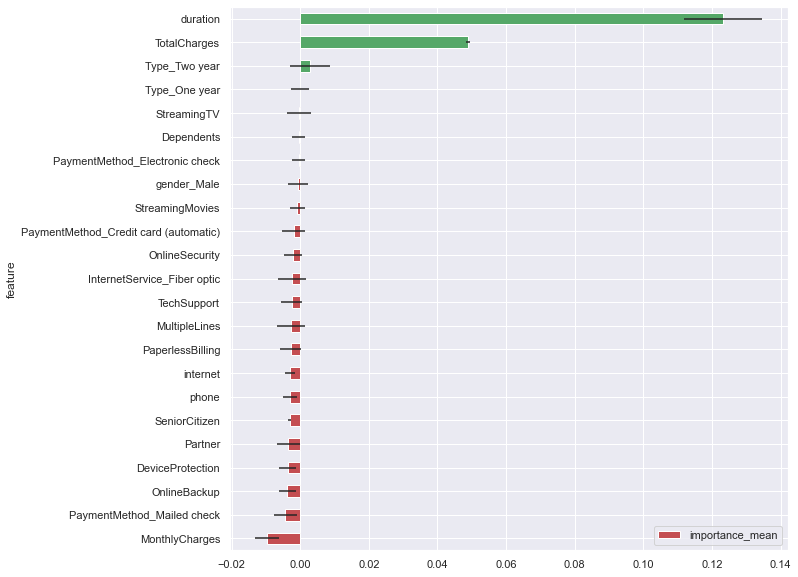

In [44]:
# около 16 минут
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

dataset = Dataset(df=train_in.join(train_out), target="Lost",
                 features=train_in.columns)

lofo_imp = LOFOImportance(dataset, cv=cv, model=model, scoring="roc_auc")
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(10, 10))

In [45]:
# отбросим худший признак
importance_features = train_in.drop(columns=['MonthlyCharges']).columns

In [46]:
model = CatBoostClassifier(
#     cat_features=cat_columns_important,
#     iterations=500,
    custom_metric='AUC',
    eval_metric='AUC',
    depth=2,
    learning_rate=0.6,
    l2_leaf_reg=0.3,
)
model.fit(train_in[importance_features], train_out, verbose=50)

predicted_proba = model.predict_proba(test_in[importance_features])

0:	total: 2.51ms	remaining: 2.51s
50:	total: 127ms	remaining: 2.36s
100:	total: 249ms	remaining: 2.22s
150:	total: 372ms	remaining: 2.09s
200:	total: 500ms	remaining: 1.99s
250:	total: 625ms	remaining: 1.86s
300:	total: 750ms	remaining: 1.74s
350:	total: 875ms	remaining: 1.62s
400:	total: 999ms	remaining: 1.49s
450:	total: 1.13s	remaining: 1.38s
500:	total: 1.25s	remaining: 1.25s
550:	total: 1.38s	remaining: 1.12s
600:	total: 1.5s	remaining: 998ms
650:	total: 1.63s	remaining: 872ms
700:	total: 1.75s	remaining: 747ms
750:	total: 1.87s	remaining: 621ms
800:	total: 2s	remaining: 496ms
850:	total: 2.12s	remaining: 371ms
900:	total: 2.24s	remaining: 246ms
950:	total: 2.36s	remaining: 122ms
999:	total: 2.48s	remaining: 0us


In [47]:
show_result(
    target_test=target_test,
    predicted_proba=predicted_proba,
    model=model,
    name_suff='_tune_important'
)

ROC-AUC: 0.9308352062827766

Threshold=0.20:	ROC_AUC=0.853	Accuracy=0.850
Threshold=0.25:	ROC_AUC=0.861	Accuracy=0.867
Threshold=0.30:	ROC_AUC=0.860	Accuracy=0.876
Threshold=0.35:	ROC_AUC=0.863	Accuracy=0.887
Threshold=0.40:	ROC_AUC=0.861	Accuracy=0.894
Threshold=0.45:	ROC_AUC=0.854	Accuracy=0.896
Threshold=0.50:	ROC_AUC=0.845	Accuracy=0.896
Threshold=0.55:	ROC_AUC=0.846	Accuracy=0.903
Threshold=0.60:	ROC_AUC=0.846	Accuracy=0.910
Threshold=0.65:	ROC_AUC=0.835	Accuracy=0.906
Threshold=0.70:	ROC_AUC=0.816	Accuracy=0.897
Threshold=0.75:	ROC_AUC=0.804	Accuracy=0.892
Threshold=0.80:	ROC_AUC=0.797	Accuracy=0.891


![](./image/6.png)

Получаем значение ROC-AUC немного выше, при этом количество признаков уменьшилось. Оценивать важность признаков можно будет и дальше до тех пор, пока LOFO будет определять признаки с отрицательным вкладом.

## Keras
Оценим возможности полносвязной нейронной сети. 

In [48]:
# создаем и обучаем сеть
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=20, input_dim=train_in.shape[1], activation='sigmoid'))
model.add(keras.layers.Dense(units=10, activation='sigmoid'))
model.add(keras.layers.Dense(units=5, activation='sigmoid'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

optimizer = Adam(lr=0.0001)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['AUC'])

model.fit(
    train_in, train_out,
    epochs=50,
    verbose=2,
    validation_split=0.25
)

Epoch 1/50
133/133 - 0s - loss: 0.6384 - auc: 0.5224 - val_loss: 0.5809 - val_auc: 0.7065
Epoch 2/50
133/133 - 0s - loss: 0.5800 - auc: 0.6356 - val_loss: 0.5599 - val_auc: 0.7375
Epoch 3/50
133/133 - 0s - loss: 0.5643 - auc: 0.7612 - val_loss: 0.5437 - val_auc: 0.7722
Epoch 4/50
133/133 - 0s - loss: 0.5450 - auc: 0.7768 - val_loss: 0.5194 - val_auc: 0.8042
Epoch 5/50
133/133 - 0s - loss: 0.5246 - auc: 0.7943 - val_loss: 0.4979 - val_auc: 0.8207
Epoch 6/50
133/133 - 0s - loss: 0.5016 - auc: 0.7983 - val_loss: 0.4768 - val_auc: 0.8144
Epoch 7/50
133/133 - 0s - loss: 0.4820 - auc: 0.8081 - val_loss: 0.4587 - val_auc: 0.8223
Epoch 8/50
133/133 - 0s - loss: 0.4672 - auc: 0.8106 - val_loss: 0.4629 - val_auc: 0.8225
Epoch 9/50
133/133 - 0s - loss: 0.4576 - auc: 0.8114 - val_loss: 0.4404 - val_auc: 0.8163
Epoch 10/50
133/133 - 0s - loss: 0.4537 - auc: 0.8098 - val_loss: 0.4360 - val_auc: 0.8204
Epoch 11/50
133/133 - 0s - loss: 0.4473 - auc: 0.8227 - val_loss: 0.4252 - val_auc: 0.8257
Epoch 12

In [49]:
# получаем предсказанные вероятности положительного класса
predicted_proba = model.predict_proba(test_in)

# из вектора (N,1) делаем (N,2) дополнив вероятностями отрицательного класса в стиле SKLearn
predicted_proba = np.concatenate(
    (1-predicted_proba,
    predicted_proba),
    axis=1
)

Instructions for updating:
Please use `model.predict()` instead.


In [50]:
show_result(
    target_test=target_test,
    predicted_proba=predicted_proba,
    model=model,
)

ROC-AUC: 0.8399441990234828

Threshold=0.20:	ROC_AUC=0.753	Accuracy=0.749
Threshold=0.25:	ROC_AUC=0.752	Accuracy=0.755
Threshold=0.30:	ROC_AUC=0.757	Accuracy=0.764
Threshold=0.35:	ROC_AUC=0.759	Accuracy=0.769
Threshold=0.40:	ROC_AUC=0.706	Accuracy=0.817
Threshold=0.45:	ROC_AUC=0.688	Accuracy=0.814
Threshold=0.50:	ROC_AUC=0.687	Accuracy=0.816
Threshold=0.55:	ROC_AUC=0.669	Accuracy=0.819
Threshold=0.60:	ROC_AUC=0.660	Accuracy=0.815
Threshold=0.65:	ROC_AUC=0.655	Accuracy=0.813
Threshold=0.70:	ROC_AUC=0.646	Accuracy=0.809
Threshold=0.75:	ROC_AUC=0.640	Accuracy=0.807
Threshold=0.80:	ROC_AUC=0.633	Accuracy=0.805


![](./image/7.png)

Полносвязная сеть показывает худший результат, по сравнению с настроенной моделью CatBoost

# Итоги

Лучший результат показывает модель `CatBoost` с настроенными гиперпараметрами. Требуемое значение `ROC-AUC=0.88` достигнуто с запасом (0.93). `Accuracy` для лучшей модели может составлять до 90.5%.

Выбор метрики ROC-AUC позволяет подобрать хорошую модель без привязки к пороговому значению отнесения к положительному или отрицательному классу целевого признака.

Что сделано:
- исследовательский анализ данных
- все данные объединены в один датасет
- добавлен признак (количество дней действия контракта)
- корреляционный анализ признаков + важность для базовой модели с помощь LOFO
- данные подготовлены для работы с моделями (приведение типов, кодирование)
- проверены следующие модели:
    - LogisticRegressionCV
    - lgb
    - RandomForestClassifier
    - CatBoostClassifier
    - Нейросетевая модель

# Отчет

В отчёте ответьте на вопросы:
- Какие пункты [плана](#План-работы) были выполнены, а какие — нет (поясните почему)?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи выделили?
- Какая ваша итоговая модель и какое у неё качество?

На что обращает внимание тимлид, проверяя проект:
- Ответили на все вопросы или нет?
- Понятны ли ответы на вопросы?

### 1. Объединение данных - выполнено
Все представленные таблицы (файлы) были [объединены](#Объединение-данных). Т.к. в `internet` и `phone` было меньше записей, то получившиеся пропуски были [запонены](#Избавимся-от-пропусков). Для наглядности были построены [диаграммы Венна](#Диаграммы-Вена) для абонентов с подключенным интернетом и/или телефоном.

### 2. Исследование баланса классов, корреляции признаков, поиск инсайтов - выполнено
С помощью графиков был исследован [баланс классов](#Исследование-баланса-классов). Построена [корреляционная матрица](#Важность-признаков) и определены мультиколлениарные признаки. Произведена оценка важности признаков с помощью библиотеки [LOFO](#LOFO) (по дефолтной модели). Так же по совету код-ревьюера анализ на мультиколлениарность был дополнен техникой [VIF](#VIF). Обнаружены колонки не несущие полезной нагрузки и содержащие утечку целевого признака

### 3. Подготовка данных и признаков - выполнено
Был [добавлен признак](#Добавление-фич) с длительностью действия контракта в днях. Выявленные на предыдущем шаге признаки (неинформативные, лики, мультиколлениарные) были удалены, [категориальные признаки](#Категориальные-колонки) закодированы и сформирована [отложенная выборка](#Разделение-данных-(отложенная-выборка)) с учетом баланса классов целевого признака
    
### 4. Подбор модели и гиперпараметров - выполнено
Для наглядности отображения полученных результатов была написана [функция](#Графики) построения графиков и вывода метрик. Протестированы следующие модели:
- [LogisticRegressionCV](#LogisticRegressionCV)
- [RandomForestClassifier](#RandomForestClassifier)
- [LGBMClassifier](#LGBMClassifier)
- [CatBoostClassifier](#CatBoostClassifier)
- [Полносвязная нейросеть](#Keras)

Для лучшей модели (**CatBoostClassifier**) [подобраны лучшие гиперпараметры](#GridSearch-CatBoostClassifier) и [улучшен результат](#CatBoostClassifier-с-подобранными-гиперпараметрами) до ROC-AUC=0.925. Дополнительно с помощью LOFO был отброшен еще один признак и [улучшено качество модели](#GridSearch-CatBoostClassifier-importance_features) до **ROC-AUC=0.931**

### 5. Анализ и интерпретация результатов - выполнено
Для лучшей модели полнота равняется 90.5% (порог=0.5). Также имеется "рейтинг" [полезности признаков](#GridSearch-CatBoostClassifier-importance_features), по которому можно показать бизнесу, что больше всего может влиять на факт ухода клиента, а что меньше.

Но это только предположение...))

~Охапка дров~ Собственно отчет готов :)